In [1]:
import os
import random
import shutil
import itertools
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

import brevitas.nn as qnn
from brevitas.nn import QuantLinear, QuantReLU, QuantConv2d
from brevitas.quant.binary import SignedBinaryActPerTensorConst
from brevitas.quant.binary import SignedBinaryWeightPerTensorConst
from brevitas.inject.enum import QuantType

# Network Definition

In [2]:
input_length = 28*28
hidden_0 = 256
hidden_1 = 256
hidden_2 = 256
output_length = 10

In [3]:
class MLP(nn.Module):
    def __init__(self, dropout=0.5):
        super(MLP, self).__init__()
        
        self.input = qnn.QuantIdentity(quant_type='int', scaling_impl_type='const', bit_width=8, min_val=-128.0, max_val=127.0, return_quant_tensor=True)
        
        self.fc0   = qnn.QuantLinear(input_length, hidden_0, weight_bit_width=8, weight_quant_type=QuantType.INT, bias=False)
        self.bn0   = nn.BatchNorm1d(hidden_0)
        self.sig0  = qnn.QuantSigmoid(bit_width=8, return_quant_tensor=True)
        self.drop0 = nn.Dropout(dropout)
        
        self.fc1   = qnn.QuantLinear(hidden_0, hidden_1, weight_bit_width=8, weight_quant_type=QuantType.INT, bias=False)
        self.bn1   = nn.BatchNorm1d(hidden_1)
        self.sig1  = qnn.QuantSigmoid(bit_width=8, return_quant_tensor=True)
        self.drop1 = nn.Dropout(dropout)
        
        self.fc2   = qnn.QuantLinear(hidden_1, hidden_2, weight_bit_width=8, weight_quant_type=QuantType.INT, bias=False)
        self.bn2   = nn.BatchNorm1d(hidden_2)
        self.sig2  = qnn.QuantSigmoid(bit_width=8, return_quant_tensor=True)
        self.drop2 = nn.Dropout(dropout)
        
        self.out   = qnn.QuantLinear(hidden_2, output_length, weight_bit_width=8, weight_quant_type=QuantType.INT, bias=False)

    def forward(self, x):
        
        out = x.reshape(x.shape[0], -1)
        out = self.input(out)
        out = self.drop0(self.sig0(self.bn0(self.fc0(out))))
        out = self.drop1(self.sig1(self.bn1(self.fc1(out))))
        out = self.drop2(self.sig2(self.bn2(self.fc2(out))))
        out = self.out(out)
        
        return out

# Random Seed Utility

In [4]:
def set_random_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# Define Dataloader

In [5]:
def get_dataloaders(batch_size):
    transform = transforms.ToTensor()
    dataset = datasets.MNIST("data", train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST("data", train=False, download=True, transform=transform)
    val_size = int(0.2 * len(dataset))
    train_size = len(dataset) - val_size
    train_set, val_set = random_split(dataset, [train_size, val_size])
    return (
        DataLoader(train_set, batch_size=batch_size, shuffle=True),
        DataLoader(val_set, batch_size=batch_size),
        DataLoader(test_dataset, batch_size=batch_size),
    )

# Training Pipeline

In [6]:
def train_validate_test(config, save_dir):
    set_random_seed()
    os.makedirs(save_dir, exist_ok=True)
    log_file = os.path.join(save_dir, "training_log.txt")
    resume_path = os.path.join(save_dir, "checkpoint.pth")

    epochs, batch_size, lr1, lr2, lr3, dropout = config
    train_loader, val_loader, test_loader = get_dataloaders(batch_size)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = MLP(dropout=dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr1)

    start_epoch = 0
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    if os.path.exists(resume_path):
        ckpt = torch.load(resume_path)
        model.load_state_dict(ckpt["model_state"])
        optimizer.load_state_dict(ckpt["optimizer_state"])
        history = ckpt["history"]
        start_epoch = ckpt["epoch"] + 1
        print(f"🔄 Resuming from epoch {start_epoch}")
    else:
        with open(log_file, "w") as f:
            f.write("Training started\n")

    def evaluate(loader):
        model.eval()
        loss_total, correct, total = 0, 0, 0
        with torch.no_grad():
            for x, y in loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)
                loss_total += loss.item() * x.size(0)
                _, pred = out.max(1)
                correct += (pred == y).sum().item()
                total += x.size(0)
        return loss_total / total, correct / total

    for epoch in range(start_epoch, epochs):
        model.train()
        lr = lr1 if epoch < 0.5 * epochs else lr2 if epoch < 0.8 * epochs else lr3
        for g in optimizer.param_groups:
            g["lr"] = lr

        train_loss, correct, total = 0, 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * x.size(0)
            _, pred = out.max(1)
            correct += (pred == y).sum().item()
            total += x.size(0)

        val_loss, val_acc = evaluate(val_loader)
        train_loss /= total
        train_acc = correct / total
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        log_line = (f"Epoch {epoch+1}/{epochs} - LR: {lr:.5f} | "
                    f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
                    f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
        print(log_line)
        with open(log_file, "a") as f:
            f.write(log_line + "\n")

        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "history": history
        }, resume_path)

    # Final Test
    test_loss, test_acc = evaluate(test_loader)
    final_line = f"Final Test Loss: {test_loss:.4f} Accuracy: {test_acc:.4f}"
    print(final_line)
    with open(log_file, "a") as f:
        f.write(final_line + "\n")
        f.write("Training completed\n")

    torch.save(model.state_dict(), os.path.join(save_dir, "final_model.pth"))

    # Plot and show
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Val Loss")
    plt.legend()
    plt.title("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(history["train_acc"], label="Train Acc")
    plt.plot(history["val_acc"], label="Val Acc")
    plt.legend()
    plt.title("Accuracy")
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "training_plot.png"))
    plt.show()

    return test_acc

# Exploring Best Hyperparameter

In [7]:
def Hyperparameter_searching(root_path, epochs, batch_sizes, lr_pool, dropout_rates):
    output_root = root_path
    os.makedirs(output_root, exist_ok=True)
    
    epochs = epochs
    batch_sizes = batch_sizes
    lr_pool = lr_pool
    
    # Generate descending LR combinations
    lr_combos = [combo for combo in itertools.product(lr_pool, repeat=3)
                 if (combo[0] > combo[1] > combo[2]) or (combo[0] == combo[1] == combo[2])]
    
    all_runs = [
        f"batch{bs}_lr{lr1}_{lr2}_{lr3}"
        for bs, (lr1, lr2, lr3) in itertools.product(batch_sizes, lr_combos)
    ]
    
    completed_runs = []
    for run in all_runs:
        log_path = os.path.join(output_root, run, "training_log.txt")
        if os.path.exists(log_path):
            with open(log_path, "r") as f:
                if any("Training completed" in line for line in f):
                    completed_runs.append(run)
    
    if len(completed_runs) == len(all_runs):
        print("✅ All combinations completed. Restarting from scratch...")
        for run in all_runs:
            shutil.rmtree(os.path.join(output_root, run), ignore_errors=True)
        if os.path.exists(os.path.join(output_root, "summary.csv")):
            os.remove(os.path.join(output_root, "summary.csv"))
        completed_runs = []
    
    results = []
    for batch_size, (lr1, lr2, lr3), dropout in itertools.product(batch_sizes, lr_combos, dropout_rates):
        run_name = f"batch{batch_size}_lr{lr1}_{lr2}_{lr3}_dp{dropout}"
        save_dir = os.path.join(output_root, run_name)
    
        if run_name in completed_runs:
            print(f"✅ Skipping {run_name}")
            with open(os.path.join(save_dir, "training_log.txt")) as f:
                for line in f:
                    if "Final Test Loss" in line:
                        acc = float(line.strip().split()[-1])
                        results.append((run_name, acc))
            continue
    
        print(f"🚀 Running: {run_name}")
        acc = train_validate_test([epochs, batch_size, lr1, lr2, lr3, dropout], save_dir)
        results.append((run_name, acc))
    
    results.sort(key=lambda x: x[1], reverse=True)
    best_config, best_acc = results[0]
    print(f"🏆 Best Config: {best_config} Accuracy: {best_acc:.4f}")
    
    with open(os.path.join(output_root, "summary.csv"), "w") as f:
        f.write("Config,Accuracy\n")
        for name, acc in results:
            f.write(f"{name},{acc:.4f}\n")

🚀 Running: batch64_lr0.01_0.01_0.01_dp0.0


/home/yuhao/anaconda3/envs/brevitas_lyh/lib/python3.9/site-packages/torch/_tensor.py:1362: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392022560/work/c10/core/TensorImpl.h:1900.)
  return super().rename(names)


/home/yuhao/anaconda3/envs/brevitas_lyh/lib/python3.9/site-packages/brevitas/nn/quant_linear.py:69: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392022560/work/torch/csrc/utils/python_arg_parser.cpp:368.)
  output_tensor = linear(x, quant_weight, quant_bias)


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3541, Acc: 0.8930 | Val Loss: 0.1977, Acc: 0.9413


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1523, Acc: 0.9548 | Val Loss: 0.1836, Acc: 0.9458


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1068, Acc: 0.9671 | Val Loss: 0.1357, Acc: 0.9599


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0833, Acc: 0.9736 | Val Loss: 0.1182, Acc: 0.9645


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0642, Acc: 0.9793 | Val Loss: 0.1042, Acc: 0.9691


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0551, Acc: 0.9819 | Val Loss: 0.1174, Acc: 0.9683


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0471, Acc: 0.9848 | Val Loss: 0.1027, Acc: 0.9728


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0399, Acc: 0.9868 | Val Loss: 0.1245, Acc: 0.9688


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0353, Acc: 0.9883 | Val Loss: 0.1107, Acc: 0.9721


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0327, Acc: 0.9896 | Val Loss: 0.1355, Acc: 0.9702


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0310, Acc: 0.9897 | Val Loss: 0.1147, Acc: 0.9722


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0289, Acc: 0.9903 | Val Loss: 0.1281, Acc: 0.9691


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0233, Acc: 0.9916 | Val Loss: 0.1186, Acc: 0.9728


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0235, Acc: 0.9917 | Val Loss: 0.1347, Acc: 0.9675


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0227, Acc: 0.9925 | Val Loss: 0.1582, Acc: 0.9700


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0226, Acc: 0.9927 | Val Loss: 0.1380, Acc: 0.9717


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9934 | Val Loss: 0.1540, Acc: 0.9711


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9943 | Val Loss: 0.1206, Acc: 0.9703


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9935 | Val Loss: 0.1140, Acc: 0.9719


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9946 | Val Loss: 0.1276, Acc: 0.9696


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9937 | Val Loss: 0.2074, Acc: 0.9547


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9948 | Val Loss: 0.1238, Acc: 0.9702


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9946 | Val Loss: 0.1038, Acc: 0.9716


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9949 | Val Loss: 0.1317, Acc: 0.9721


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9953 | Val Loss: 0.1088, Acc: 0.9756


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9953 | Val Loss: 0.1022, Acc: 0.9746


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9951 | Val Loss: 0.1195, Acc: 0.9736


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9958 | Val Loss: 0.1408, Acc: 0.9711


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9963 | Val Loss: 0.1327, Acc: 0.9725


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9960 | Val Loss: 0.1173, Acc: 0.9746


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9957 | Val Loss: 0.1464, Acc: 0.9719


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9960 | Val Loss: 0.1517, Acc: 0.9724


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9953 | Val Loss: 0.1416, Acc: 0.9712


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9965 | Val Loss: 0.1648, Acc: 0.9666


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9961 | Val Loss: 0.1249, Acc: 0.9740


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9964 | Val Loss: 0.1134, Acc: 0.9733


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9967 | Val Loss: 0.1124, Acc: 0.9732


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9967 | Val Loss: 0.1702, Acc: 0.9707


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9965 | Val Loss: 0.1496, Acc: 0.9742


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9964 | Val Loss: 0.1606, Acc: 0.9673


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9966 | Val Loss: 0.1192, Acc: 0.9728


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.1387, Acc: 0.9719


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9964 | Val Loss: 0.1192, Acc: 0.9743


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9971 | Val Loss: 0.1276, Acc: 0.9741


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9975 | Val Loss: 0.1120, Acc: 0.9732


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.1044, Acc: 0.9759


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9968 | Val Loss: 0.1279, Acc: 0.9738


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.1679, Acc: 0.9739


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9970 | Val Loss: 0.1260, Acc: 0.9759


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9977 | Val Loss: 0.1601, Acc: 0.9775


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 0.1467, Acc: 0.9710


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.1447, Acc: 0.9774


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.1282, Acc: 0.9748


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9969 | Val Loss: 0.1468, Acc: 0.9728


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.1318, Acc: 0.9743


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.1368, Acc: 0.9762


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1629, Acc: 0.9752


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.1062, Acc: 0.9746


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.1014, Acc: 0.9751


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.1456, Acc: 0.9765


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.1038, Acc: 0.9748


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9977 | Val Loss: 0.1745, Acc: 0.9739


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.1658, Acc: 0.9767


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9981 | Val Loss: 0.1615, Acc: 0.9775


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1381, Acc: 0.9755


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.1728, Acc: 0.9767


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.1698, Acc: 0.9758


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.1502, Acc: 0.9746


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.1138, Acc: 0.9762


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.1232, Acc: 0.9750


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.1400, Acc: 0.9768


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.1094, Acc: 0.9768


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.1039, Acc: 0.9762


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.1519, Acc: 0.9768


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1218, Acc: 0.9744


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1188, Acc: 0.9751


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.1094, Acc: 0.9743


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1506, Acc: 0.9754


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1208, Acc: 0.9754


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1497, Acc: 0.9753


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.1553, Acc: 0.9752


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.1171, Acc: 0.9760


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.1290, Acc: 0.9766


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1970, Acc: 0.9764


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.1741, Acc: 0.9751


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.1850, Acc: 0.9745


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1586, Acc: 0.9745


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.1066, Acc: 0.9772


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.1387, Acc: 0.9770


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.1693, Acc: 0.9765


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.1138, Acc: 0.9753


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.0899, Acc: 0.9745


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1615, Acc: 0.9761


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1514, Acc: 0.9758


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1289, Acc: 0.9762


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1362, Acc: 0.9740


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1492, Acc: 0.9762


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1787, Acc: 0.9761


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1327, Acc: 0.9753


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1306, Acc: 0.9760


Final Test Loss: 0.1180 Accuracy: 0.9777


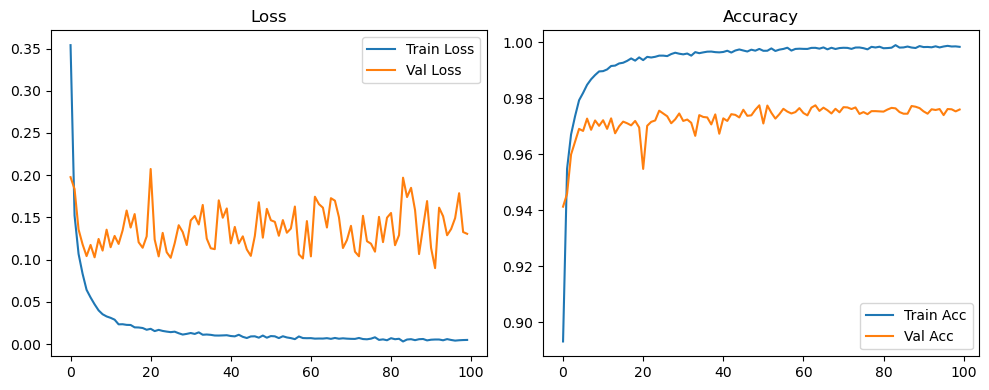

🚀 Running: batch64_lr0.01_0.01_0.01_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4628, Acc: 0.8580 | Val Loss: 0.2421, Acc: 0.9257


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2591, Acc: 0.9213 | Val Loss: 0.1563, Acc: 0.9517


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1900, Acc: 0.9414 | Val Loss: 0.1381, Acc: 0.9578


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1470, Acc: 0.9540 | Val Loss: 0.1192, Acc: 0.9642


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1199, Acc: 0.9630 | Val Loss: 0.1129, Acc: 0.9667


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1073, Acc: 0.9654 | Val Loss: 0.1156, Acc: 0.9664


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0948, Acc: 0.9699 | Val Loss: 0.1016, Acc: 0.9700


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0824, Acc: 0.9743 | Val Loss: 0.0991, Acc: 0.9712


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0746, Acc: 0.9758 | Val Loss: 0.1087, Acc: 0.9702


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0709, Acc: 0.9776 | Val Loss: 0.0954, Acc: 0.9732


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0641, Acc: 0.9788 | Val Loss: 0.1012, Acc: 0.9730


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0597, Acc: 0.9800 | Val Loss: 0.1041, Acc: 0.9734


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0567, Acc: 0.9820 | Val Loss: 0.0994, Acc: 0.9732


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0514, Acc: 0.9832 | Val Loss: 0.0976, Acc: 0.9761


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0515, Acc: 0.9834 | Val Loss: 0.1011, Acc: 0.9738


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0475, Acc: 0.9842 | Val Loss: 0.0950, Acc: 0.9755


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0442, Acc: 0.9858 | Val Loss: 0.0915, Acc: 0.9750


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0437, Acc: 0.9855 | Val Loss: 0.1021, Acc: 0.9741


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0402, Acc: 0.9862 | Val Loss: 0.0889, Acc: 0.9754


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0401, Acc: 0.9869 | Val Loss: 0.0949, Acc: 0.9751


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0397, Acc: 0.9869 | Val Loss: 0.0843, Acc: 0.9757


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0357, Acc: 0.9881 | Val Loss: 0.0967, Acc: 0.9755


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0336, Acc: 0.9889 | Val Loss: 0.0908, Acc: 0.9752


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0343, Acc: 0.9885 | Val Loss: 0.0957, Acc: 0.9751


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0320, Acc: 0.9895 | Val Loss: 0.0917, Acc: 0.9757


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0323, Acc: 0.9896 | Val Loss: 0.0887, Acc: 0.9779


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0337, Acc: 0.9888 | Val Loss: 0.0902, Acc: 0.9767


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0294, Acc: 0.9903 | Val Loss: 0.0939, Acc: 0.9772


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0285, Acc: 0.9899 | Val Loss: 0.1000, Acc: 0.9764


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0271, Acc: 0.9908 | Val Loss: 0.1029, Acc: 0.9778


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0287, Acc: 0.9906 | Val Loss: 0.0898, Acc: 0.9768


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0262, Acc: 0.9916 | Val Loss: 0.0895, Acc: 0.9751


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0285, Acc: 0.9904 | Val Loss: 0.0943, Acc: 0.9748


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9912 | Val Loss: 0.0937, Acc: 0.9773


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9918 | Val Loss: 0.0908, Acc: 0.9772


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0247, Acc: 0.9916 | Val Loss: 0.0844, Acc: 0.9763


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0251, Acc: 0.9921 | Val Loss: 0.0946, Acc: 0.9778


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9921 | Val Loss: 0.1110, Acc: 0.9773


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0221, Acc: 0.9923 | Val Loss: 0.1078, Acc: 0.9778


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0232, Acc: 0.9921 | Val Loss: 0.0960, Acc: 0.9778


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9929 | Val Loss: 0.1019, Acc: 0.9785


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9931 | Val Loss: 0.1147, Acc: 0.9770


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0229, Acc: 0.9924 | Val Loss: 0.1136, Acc: 0.9785


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0229, Acc: 0.9928 | Val Loss: 0.0957, Acc: 0.9780


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0214, Acc: 0.9924 | Val Loss: 0.1102, Acc: 0.9776


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9931 | Val Loss: 0.0885, Acc: 0.9782


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0200, Acc: 0.9938 | Val Loss: 0.0850, Acc: 0.9793


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0176, Acc: 0.9944 | Val Loss: 0.1058, Acc: 0.9771


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0195, Acc: 0.9934 | Val Loss: 0.1050, Acc: 0.9773


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9935 | Val Loss: 0.0897, Acc: 0.9786


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9941 | Val Loss: 0.1076, Acc: 0.9782


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9938 | Val Loss: 0.1106, Acc: 0.9759


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9940 | Val Loss: 0.0933, Acc: 0.9771


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9942 | Val Loss: 0.0884, Acc: 0.9774


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0186, Acc: 0.9937 | Val Loss: 0.0868, Acc: 0.9787


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0181, Acc: 0.9946 | Val Loss: 0.0981, Acc: 0.9807


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9949 | Val Loss: 0.0946, Acc: 0.9767


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9946 | Val Loss: 0.1117, Acc: 0.9792


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9944 | Val Loss: 0.0933, Acc: 0.9790


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9946 | Val Loss: 0.0955, Acc: 0.9795


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9947 | Val Loss: 0.1127, Acc: 0.9788


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9949 | Val Loss: 0.1216, Acc: 0.9796


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9945 | Val Loss: 0.0989, Acc: 0.9796


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9946 | Val Loss: 0.0866, Acc: 0.9790


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9946 | Val Loss: 0.1025, Acc: 0.9798


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9950 | Val Loss: 0.1167, Acc: 0.9803


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0156, Acc: 0.9948 | Val Loss: 0.1255, Acc: 0.9778


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9956 | Val Loss: 0.1020, Acc: 0.9766


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9948 | Val Loss: 0.1172, Acc: 0.9772


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9957 | Val Loss: 0.1143, Acc: 0.9772


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9955 | Val Loss: 0.1323, Acc: 0.9785


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9955 | Val Loss: 0.1282, Acc: 0.9762


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9953 | Val Loss: 0.1057, Acc: 0.9770


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9952 | Val Loss: 0.1111, Acc: 0.9771


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9956 | Val Loss: 0.1109, Acc: 0.9786


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9962 | Val Loss: 0.1130, Acc: 0.9789


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9958 | Val Loss: 0.1077, Acc: 0.9790


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9949 | Val Loss: 0.1127, Acc: 0.9782


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9961 | Val Loss: 0.1232, Acc: 0.9779


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9958 | Val Loss: 0.1155, Acc: 0.9778


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9960 | Val Loss: 0.1164, Acc: 0.9762


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9952 | Val Loss: 0.1222, Acc: 0.9779


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9956 | Val Loss: 0.0828, Acc: 0.9785


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9960 | Val Loss: 0.1111, Acc: 0.9790


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9957 | Val Loss: 0.1164, Acc: 0.9777


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9955 | Val Loss: 0.1556, Acc: 0.9779


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9954 | Val Loss: 0.1193, Acc: 0.9780


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9958 | Val Loss: 0.1087, Acc: 0.9773


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9956 | Val Loss: 0.0939, Acc: 0.9787


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9961 | Val Loss: 0.1164, Acc: 0.9788


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9957 | Val Loss: 0.1174, Acc: 0.9780


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9966 | Val Loss: 0.1580, Acc: 0.9776


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9956 | Val Loss: 0.1457, Acc: 0.9775


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9959 | Val Loss: 0.0847, Acc: 0.9785


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9967 | Val Loss: 0.1032, Acc: 0.9787


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9957 | Val Loss: 0.1153, Acc: 0.9786


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9958 | Val Loss: 0.1294, Acc: 0.9792


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9961 | Val Loss: 0.0938, Acc: 0.9783


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9964 | Val Loss: 0.1016, Acc: 0.9792


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9962 | Val Loss: 0.1150, Acc: 0.9792


Final Test Loss: 0.1090 Accuracy: 0.9793


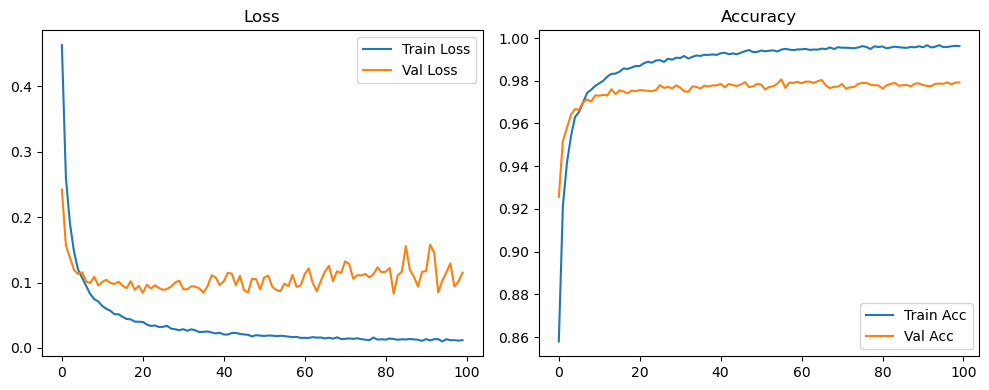

🚀 Running: batch64_lr0.01_0.01_0.01_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.6696, Acc: 0.7873 | Val Loss: 0.2973, Acc: 0.9108


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.3993, Acc: 0.8821 | Val Loss: 0.2073, Acc: 0.9381


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.3262, Acc: 0.9033 | Val Loss: 0.1802, Acc: 0.9447


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2684, Acc: 0.9189 | Val Loss: 0.1512, Acc: 0.9530


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.2383, Acc: 0.9285 | Val Loss: 0.1335, Acc: 0.9587


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.2125, Acc: 0.9353 | Val Loss: 0.1304, Acc: 0.9609


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1969, Acc: 0.9406 | Val Loss: 0.1166, Acc: 0.9642


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1863, Acc: 0.9439 | Val Loss: 0.1111, Acc: 0.9657


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1752, Acc: 0.9469 | Val Loss: 0.1099, Acc: 0.9652


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1682, Acc: 0.9484 | Val Loss: 0.1086, Acc: 0.9675


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1615, Acc: 0.9507 | Val Loss: 0.1039, Acc: 0.9699


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1497, Acc: 0.9550 | Val Loss: 0.0983, Acc: 0.9718


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1493, Acc: 0.9547 | Val Loss: 0.0961, Acc: 0.9712


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1390, Acc: 0.9573 | Val Loss: 0.0986, Acc: 0.9708


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1340, Acc: 0.9593 | Val Loss: 0.0976, Acc: 0.9721


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1302, Acc: 0.9607 | Val Loss: 0.0974, Acc: 0.9732


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1286, Acc: 0.9611 | Val Loss: 0.0979, Acc: 0.9722


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1243, Acc: 0.9618 | Val Loss: 0.0925, Acc: 0.9726


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1205, Acc: 0.9635 | Val Loss: 0.0888, Acc: 0.9742


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1222, Acc: 0.9626 | Val Loss: 0.0910, Acc: 0.9738


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.1160, Acc: 0.9643 | Val Loss: 0.0914, Acc: 0.9741


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.1107, Acc: 0.9661 | Val Loss: 0.0900, Acc: 0.9740


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.1062, Acc: 0.9675 | Val Loss: 0.0861, Acc: 0.9742


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.1076, Acc: 0.9665 | Val Loss: 0.0906, Acc: 0.9740


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.1033, Acc: 0.9686 | Val Loss: 0.0855, Acc: 0.9748


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0975, Acc: 0.9697 | Val Loss: 0.0886, Acc: 0.9748


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0994, Acc: 0.9695 | Val Loss: 0.0903, Acc: 0.9750


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0980, Acc: 0.9689 | Val Loss: 0.0895, Acc: 0.9745


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0947, Acc: 0.9710 | Val Loss: 0.0930, Acc: 0.9754


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0913, Acc: 0.9707 | Val Loss: 0.1000, Acc: 0.9758


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0944, Acc: 0.9706 | Val Loss: 0.0837, Acc: 0.9756


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0897, Acc: 0.9714 | Val Loss: 0.0864, Acc: 0.9762


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0887, Acc: 0.9715 | Val Loss: 0.0894, Acc: 0.9760


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0874, Acc: 0.9726 | Val Loss: 0.0901, Acc: 0.9753


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0866, Acc: 0.9734 | Val Loss: 0.0845, Acc: 0.9768


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0874, Acc: 0.9734 | Val Loss: 0.0876, Acc: 0.9753


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0827, Acc: 0.9741 | Val Loss: 0.0848, Acc: 0.9754


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0811, Acc: 0.9744 | Val Loss: 0.0893, Acc: 0.9757


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0799, Acc: 0.9755 | Val Loss: 0.0903, Acc: 0.9752


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0777, Acc: 0.9759 | Val Loss: 0.0854, Acc: 0.9768


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0792, Acc: 0.9751 | Val Loss: 0.0903, Acc: 0.9752


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0765, Acc: 0.9758 | Val Loss: 0.0858, Acc: 0.9768


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0752, Acc: 0.9778 | Val Loss: 0.0820, Acc: 0.9782


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0780, Acc: 0.9757 | Val Loss: 0.0938, Acc: 0.9768


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0763, Acc: 0.9761 | Val Loss: 0.0810, Acc: 0.9771


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0757, Acc: 0.9753 | Val Loss: 0.0852, Acc: 0.9756


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0747, Acc: 0.9766 | Val Loss: 0.0883, Acc: 0.9767


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0732, Acc: 0.9778 | Val Loss: 0.0917, Acc: 0.9767


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0703, Acc: 0.9779 | Val Loss: 0.0827, Acc: 0.9753


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0730, Acc: 0.9775 | Val Loss: 0.0881, Acc: 0.9767


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0719, Acc: 0.9778 | Val Loss: 0.0928, Acc: 0.9758


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0724, Acc: 0.9777 | Val Loss: 0.0912, Acc: 0.9755


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0698, Acc: 0.9780 | Val Loss: 0.0812, Acc: 0.9762


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0696, Acc: 0.9784 | Val Loss: 0.0828, Acc: 0.9762


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0697, Acc: 0.9783 | Val Loss: 0.0949, Acc: 0.9771


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0673, Acc: 0.9787 | Val Loss: 0.0875, Acc: 0.9755


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0652, Acc: 0.9788 | Val Loss: 0.0876, Acc: 0.9765


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0635, Acc: 0.9804 | Val Loss: 0.0980, Acc: 0.9770


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0647, Acc: 0.9796 | Val Loss: 0.0917, Acc: 0.9764


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0681, Acc: 0.9788 | Val Loss: 0.1103, Acc: 0.9764


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0647, Acc: 0.9795 | Val Loss: 0.0880, Acc: 0.9759


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0648, Acc: 0.9791 | Val Loss: 0.0963, Acc: 0.9770


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0653, Acc: 0.9799 | Val Loss: 0.0802, Acc: 0.9766


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0634, Acc: 0.9800 | Val Loss: 0.0957, Acc: 0.9749


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0628, Acc: 0.9800 | Val Loss: 0.0933, Acc: 0.9768


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0625, Acc: 0.9810 | Val Loss: 0.0907, Acc: 0.9766


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0621, Acc: 0.9808 | Val Loss: 0.1072, Acc: 0.9762


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0631, Acc: 0.9808 | Val Loss: 0.1002, Acc: 0.9765


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0620, Acc: 0.9804 | Val Loss: 0.0913, Acc: 0.9761


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0599, Acc: 0.9810 | Val Loss: 0.1078, Acc: 0.9752


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0636, Acc: 0.9799 | Val Loss: 0.1015, Acc: 0.9757


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0584, Acc: 0.9822 | Val Loss: 0.0822, Acc: 0.9759


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0567, Acc: 0.9818 | Val Loss: 0.1004, Acc: 0.9771


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0597, Acc: 0.9808 | Val Loss: 0.0839, Acc: 0.9751


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0564, Acc: 0.9828 | Val Loss: 0.0941, Acc: 0.9766


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0616, Acc: 0.9813 | Val Loss: 0.1026, Acc: 0.9776


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0582, Acc: 0.9826 | Val Loss: 0.0962, Acc: 0.9770


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0579, Acc: 0.9822 | Val Loss: 0.0876, Acc: 0.9763


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0570, Acc: 0.9829 | Val Loss: 0.0949, Acc: 0.9760


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0569, Acc: 0.9829 | Val Loss: 0.0889, Acc: 0.9772


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0555, Acc: 0.9832 | Val Loss: 0.0872, Acc: 0.9758


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0556, Acc: 0.9823 | Val Loss: 0.0957, Acc: 0.9767


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0525, Acc: 0.9831 | Val Loss: 0.0991, Acc: 0.9775


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0559, Acc: 0.9827 | Val Loss: 0.0896, Acc: 0.9772


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0552, Acc: 0.9826 | Val Loss: 0.0926, Acc: 0.9771


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0529, Acc: 0.9838 | Val Loss: 0.0793, Acc: 0.9773


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0532, Acc: 0.9831 | Val Loss: 0.1069, Acc: 0.9765


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0545, Acc: 0.9827 | Val Loss: 0.0835, Acc: 0.9772


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0535, Acc: 0.9832 | Val Loss: 0.1003, Acc: 0.9767


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0508, Acc: 0.9843 | Val Loss: 0.1002, Acc: 0.9769


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0550, Acc: 0.9824 | Val Loss: 0.0832, Acc: 0.9769


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0527, Acc: 0.9837 | Val Loss: 0.0970, Acc: 0.9759


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0490, Acc: 0.9849 | Val Loss: 0.1156, Acc: 0.9778


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0513, Acc: 0.9840 | Val Loss: 0.0865, Acc: 0.9764


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0530, Acc: 0.9831 | Val Loss: 0.0818, Acc: 0.9783


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0527, Acc: 0.9830 | Val Loss: 0.0889, Acc: 0.9781


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0478, Acc: 0.9845 | Val Loss: 0.0967, Acc: 0.9771


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0510, Acc: 0.9839 | Val Loss: 0.0972, Acc: 0.9768


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0515, Acc: 0.9838 | Val Loss: 0.0875, Acc: 0.9762


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0519, Acc: 0.9835 | Val Loss: 0.1065, Acc: 0.9770


Final Test Loss: 0.0917 Accuracy: 0.9784


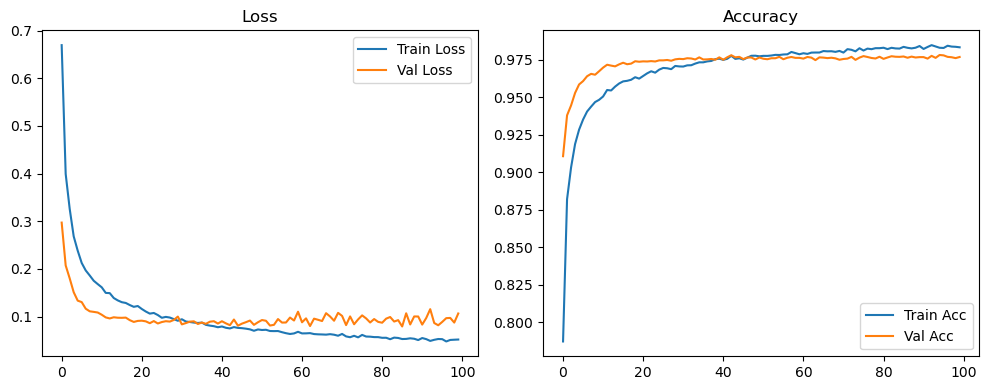

🚀 Running: batch64_lr0.01_0.005_0.002_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3541, Acc: 0.8930 | Val Loss: 0.1977, Acc: 0.9413


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1523, Acc: 0.9548 | Val Loss: 0.1836, Acc: 0.9458


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1068, Acc: 0.9671 | Val Loss: 0.1357, Acc: 0.9599


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0833, Acc: 0.9736 | Val Loss: 0.1182, Acc: 0.9645


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0642, Acc: 0.9793 | Val Loss: 0.1042, Acc: 0.9691


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0551, Acc: 0.9819 | Val Loss: 0.1174, Acc: 0.9683


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0471, Acc: 0.9848 | Val Loss: 0.1027, Acc: 0.9728


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0399, Acc: 0.9868 | Val Loss: 0.1245, Acc: 0.9688


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0353, Acc: 0.9883 | Val Loss: 0.1107, Acc: 0.9721


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0327, Acc: 0.9896 | Val Loss: 0.1355, Acc: 0.9702


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0310, Acc: 0.9897 | Val Loss: 0.1147, Acc: 0.9722


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0289, Acc: 0.9903 | Val Loss: 0.1281, Acc: 0.9691


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0233, Acc: 0.9916 | Val Loss: 0.1186, Acc: 0.9728


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0235, Acc: 0.9917 | Val Loss: 0.1347, Acc: 0.9675


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0227, Acc: 0.9925 | Val Loss: 0.1582, Acc: 0.9700


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0226, Acc: 0.9927 | Val Loss: 0.1380, Acc: 0.9717


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9934 | Val Loss: 0.1540, Acc: 0.9711


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9943 | Val Loss: 0.1206, Acc: 0.9703


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9935 | Val Loss: 0.1140, Acc: 0.9719


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9946 | Val Loss: 0.1276, Acc: 0.9696


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9937 | Val Loss: 0.2074, Acc: 0.9547


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9948 | Val Loss: 0.1238, Acc: 0.9702


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9946 | Val Loss: 0.1038, Acc: 0.9716


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9949 | Val Loss: 0.1317, Acc: 0.9721


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9953 | Val Loss: 0.1088, Acc: 0.9756


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9953 | Val Loss: 0.1022, Acc: 0.9746


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9951 | Val Loss: 0.1195, Acc: 0.9736


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9958 | Val Loss: 0.1408, Acc: 0.9711


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9963 | Val Loss: 0.1327, Acc: 0.9725


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9960 | Val Loss: 0.1173, Acc: 0.9746


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9957 | Val Loss: 0.1464, Acc: 0.9719


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9960 | Val Loss: 0.1517, Acc: 0.9724


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9953 | Val Loss: 0.1416, Acc: 0.9712


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9965 | Val Loss: 0.1648, Acc: 0.9666


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9961 | Val Loss: 0.1249, Acc: 0.9740


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9964 | Val Loss: 0.1134, Acc: 0.9733


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9967 | Val Loss: 0.1124, Acc: 0.9732


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9967 | Val Loss: 0.1702, Acc: 0.9707


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9965 | Val Loss: 0.1496, Acc: 0.9742


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9964 | Val Loss: 0.1606, Acc: 0.9673


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9966 | Val Loss: 0.1192, Acc: 0.9728


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.1387, Acc: 0.9719


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9964 | Val Loss: 0.1192, Acc: 0.9743


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9971 | Val Loss: 0.1276, Acc: 0.9741


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9975 | Val Loss: 0.1120, Acc: 0.9732


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.1044, Acc: 0.9759


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9968 | Val Loss: 0.1279, Acc: 0.9738


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.1679, Acc: 0.9739


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9970 | Val Loss: 0.1260, Acc: 0.9759


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9977 | Val Loss: 0.1601, Acc: 0.9775


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1197, Acc: 0.9785


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1308, Acc: 0.9779


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1384, Acc: 0.9772


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1786, Acc: 0.9769


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9987 | Val Loss: 0.1440, Acc: 0.9768


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1287, Acc: 0.9778


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1237, Acc: 0.9770


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1651, Acc: 0.9780


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1471, Acc: 0.9754


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1488, Acc: 0.9769


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1328, Acc: 0.9772


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1515, Acc: 0.9772


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1235, Acc: 0.9774


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1435, Acc: 0.9773


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.1491, Acc: 0.9769


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1486, Acc: 0.9771


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1352, Acc: 0.9760


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1507, Acc: 0.9768


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1654, Acc: 0.9779


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1422, Acc: 0.9767


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1480, Acc: 0.9778


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1883, Acc: 0.9774


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.1827, Acc: 0.9761


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1667, Acc: 0.9771


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1847, Acc: 0.9771


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1833, Acc: 0.9768


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1658, Acc: 0.9748


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.2018, Acc: 0.9755


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1817, Acc: 0.9752


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1902, Acc: 0.9755


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1501, Acc: 0.9762


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1861, Acc: 0.9762


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.2055, Acc: 0.9774


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1571, Acc: 0.9772


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1504, Acc: 0.9777


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1529, Acc: 0.9788


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1565, Acc: 0.9778


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1838, Acc: 0.9784


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9997 | Val Loss: 0.1709, Acc: 0.9786


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1714, Acc: 0.9774


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1843, Acc: 0.9788


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1471, Acc: 0.9783


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2099, Acc: 0.9798


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1874, Acc: 0.9783


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1716, Acc: 0.9786


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1740, Acc: 0.9783


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.1719, Acc: 0.9792


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1907, Acc: 0.9768


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1990, Acc: 0.9790


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1929, Acc: 0.9788


Final Test Loss: 0.1544 Accuracy: 0.9811


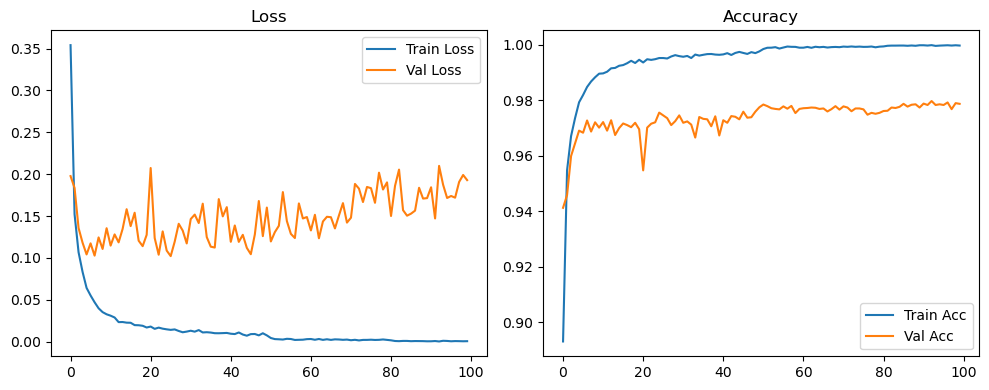

🚀 Running: batch64_lr0.01_0.005_0.002_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4628, Acc: 0.8580 | Val Loss: 0.2421, Acc: 0.9257


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2591, Acc: 0.9213 | Val Loss: 0.1563, Acc: 0.9517


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1900, Acc: 0.9414 | Val Loss: 0.1381, Acc: 0.9578


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1470, Acc: 0.9540 | Val Loss: 0.1192, Acc: 0.9642


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1199, Acc: 0.9630 | Val Loss: 0.1129, Acc: 0.9667


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1073, Acc: 0.9654 | Val Loss: 0.1156, Acc: 0.9664


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0948, Acc: 0.9699 | Val Loss: 0.1016, Acc: 0.9700


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0824, Acc: 0.9743 | Val Loss: 0.0991, Acc: 0.9712


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0746, Acc: 0.9758 | Val Loss: 0.1087, Acc: 0.9702


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0709, Acc: 0.9776 | Val Loss: 0.0954, Acc: 0.9732


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0641, Acc: 0.9788 | Val Loss: 0.1012, Acc: 0.9730


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0597, Acc: 0.9800 | Val Loss: 0.1041, Acc: 0.9734


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0567, Acc: 0.9820 | Val Loss: 0.0994, Acc: 0.9732


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0514, Acc: 0.9832 | Val Loss: 0.0976, Acc: 0.9761


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0515, Acc: 0.9834 | Val Loss: 0.1011, Acc: 0.9738


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0475, Acc: 0.9842 | Val Loss: 0.0950, Acc: 0.9755


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0442, Acc: 0.9858 | Val Loss: 0.0915, Acc: 0.9750


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0437, Acc: 0.9855 | Val Loss: 0.1021, Acc: 0.9741


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0402, Acc: 0.9862 | Val Loss: 0.0889, Acc: 0.9754


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0401, Acc: 0.9869 | Val Loss: 0.0949, Acc: 0.9751


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0397, Acc: 0.9869 | Val Loss: 0.0843, Acc: 0.9757


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0357, Acc: 0.9881 | Val Loss: 0.0967, Acc: 0.9755


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0336, Acc: 0.9889 | Val Loss: 0.0908, Acc: 0.9752


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0343, Acc: 0.9885 | Val Loss: 0.0957, Acc: 0.9751


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0320, Acc: 0.9895 | Val Loss: 0.0917, Acc: 0.9757


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0323, Acc: 0.9896 | Val Loss: 0.0887, Acc: 0.9779


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0337, Acc: 0.9888 | Val Loss: 0.0902, Acc: 0.9767


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0294, Acc: 0.9903 | Val Loss: 0.0939, Acc: 0.9772


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0285, Acc: 0.9899 | Val Loss: 0.1000, Acc: 0.9764


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0271, Acc: 0.9908 | Val Loss: 0.1029, Acc: 0.9778


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0287, Acc: 0.9906 | Val Loss: 0.0898, Acc: 0.9768


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0262, Acc: 0.9916 | Val Loss: 0.0895, Acc: 0.9751


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0285, Acc: 0.9904 | Val Loss: 0.0943, Acc: 0.9748


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9912 | Val Loss: 0.0937, Acc: 0.9773


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9918 | Val Loss: 0.0908, Acc: 0.9772


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0247, Acc: 0.9916 | Val Loss: 0.0844, Acc: 0.9763


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0251, Acc: 0.9921 | Val Loss: 0.0946, Acc: 0.9778


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9921 | Val Loss: 0.1110, Acc: 0.9773


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0221, Acc: 0.9923 | Val Loss: 0.1078, Acc: 0.9778


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0232, Acc: 0.9921 | Val Loss: 0.0960, Acc: 0.9778


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9929 | Val Loss: 0.1019, Acc: 0.9785


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9931 | Val Loss: 0.1147, Acc: 0.9770


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0229, Acc: 0.9924 | Val Loss: 0.1136, Acc: 0.9785


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0229, Acc: 0.9928 | Val Loss: 0.0957, Acc: 0.9780


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0214, Acc: 0.9924 | Val Loss: 0.1102, Acc: 0.9776


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9931 | Val Loss: 0.0885, Acc: 0.9782


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0200, Acc: 0.9938 | Val Loss: 0.0850, Acc: 0.9793


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0176, Acc: 0.9944 | Val Loss: 0.1058, Acc: 0.9771


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0195, Acc: 0.9934 | Val Loss: 0.1050, Acc: 0.9773


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9935 | Val Loss: 0.0897, Acc: 0.9786


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0146, Acc: 0.9952 | Val Loss: 0.1008, Acc: 0.9791


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9959 | Val Loss: 0.0881, Acc: 0.9796


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9962 | Val Loss: 0.1067, Acc: 0.9789


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9961 | Val Loss: 0.1062, Acc: 0.9790


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9962 | Val Loss: 0.0896, Acc: 0.9802


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9966 | Val Loss: 0.0973, Acc: 0.9798


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9969 | Val Loss: 0.0949, Acc: 0.9792


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9968 | Val Loss: 0.1054, Acc: 0.9799


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9967 | Val Loss: 0.1052, Acc: 0.9798


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9968 | Val Loss: 0.0938, Acc: 0.9797


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9971 | Val Loss: 0.0896, Acc: 0.9784


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9973 | Val Loss: 0.1141, Acc: 0.9799


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9969 | Val Loss: 0.0915, Acc: 0.9798


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.0993, Acc: 0.9802


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9971 | Val Loss: 0.1009, Acc: 0.9789


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.1206, Acc: 0.9790


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9971 | Val Loss: 0.1188, Acc: 0.9792


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9971 | Val Loss: 0.0912, Acc: 0.9784


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9971 | Val Loss: 0.1354, Acc: 0.9789


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.0921, Acc: 0.9786


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9973 | Val Loss: 0.1283, Acc: 0.9797


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9972 | Val Loss: 0.1226, Acc: 0.9786


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9976 | Val Loss: 0.1055, Acc: 0.9796


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.1133, Acc: 0.9791


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.1092, Acc: 0.9796


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.1071, Acc: 0.9798


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9974 | Val Loss: 0.1124, Acc: 0.9792


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 0.0969, Acc: 0.9798


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.1081, Acc: 0.9788


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9977 | Val Loss: 0.1211, Acc: 0.9794


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9983 | Val Loss: 0.1165, Acc: 0.9793


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.1256, Acc: 0.9797


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1142, Acc: 0.9807


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9984 | Val Loss: 0.1157, Acc: 0.9805


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1265, Acc: 0.9804


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1219, Acc: 0.9796


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1195, Acc: 0.9812


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.1222, Acc: 0.9807


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1348, Acc: 0.9807


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9987 | Val Loss: 0.1241, Acc: 0.9815


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.1118, Acc: 0.9805


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1141, Acc: 0.9805


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1111, Acc: 0.9801


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.1150, Acc: 0.9800


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1350, Acc: 0.9808


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.1142, Acc: 0.9809


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1123, Acc: 0.9807


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9989 | Val Loss: 0.1076, Acc: 0.9815


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.1256, Acc: 0.9808


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.1072, Acc: 0.9808


Final Test Loss: 0.1133 Accuracy: 0.9812


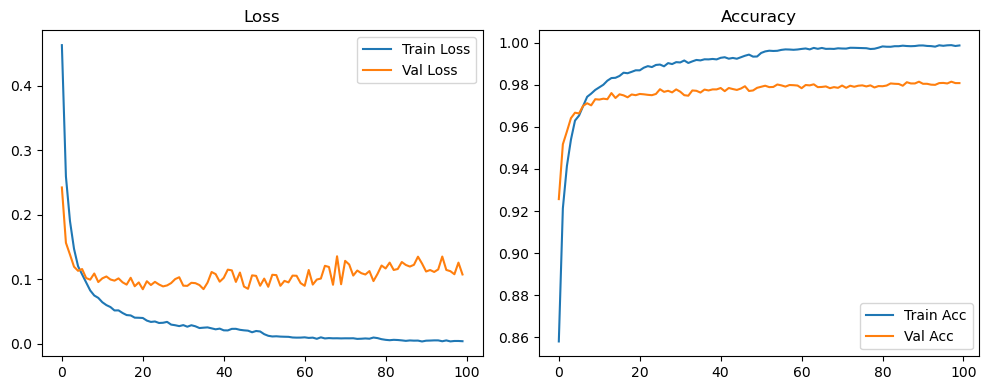

🚀 Running: batch64_lr0.01_0.005_0.002_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.6696, Acc: 0.7873 | Val Loss: 0.2973, Acc: 0.9108


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.3993, Acc: 0.8821 | Val Loss: 0.2073, Acc: 0.9381


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.3262, Acc: 0.9033 | Val Loss: 0.1802, Acc: 0.9447


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2684, Acc: 0.9189 | Val Loss: 0.1512, Acc: 0.9530


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.2383, Acc: 0.9285 | Val Loss: 0.1335, Acc: 0.9587


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.2125, Acc: 0.9353 | Val Loss: 0.1304, Acc: 0.9609


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1969, Acc: 0.9406 | Val Loss: 0.1166, Acc: 0.9642


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1863, Acc: 0.9439 | Val Loss: 0.1111, Acc: 0.9657


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1752, Acc: 0.9469 | Val Loss: 0.1099, Acc: 0.9652


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1682, Acc: 0.9484 | Val Loss: 0.1086, Acc: 0.9675


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1615, Acc: 0.9507 | Val Loss: 0.1039, Acc: 0.9699


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1497, Acc: 0.9550 | Val Loss: 0.0983, Acc: 0.9718


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1493, Acc: 0.9547 | Val Loss: 0.0961, Acc: 0.9712


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1390, Acc: 0.9573 | Val Loss: 0.0986, Acc: 0.9708


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1340, Acc: 0.9593 | Val Loss: 0.0976, Acc: 0.9721


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1302, Acc: 0.9607 | Val Loss: 0.0974, Acc: 0.9732


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1286, Acc: 0.9611 | Val Loss: 0.0979, Acc: 0.9722


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1243, Acc: 0.9618 | Val Loss: 0.0925, Acc: 0.9726


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1205, Acc: 0.9635 | Val Loss: 0.0888, Acc: 0.9742


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1222, Acc: 0.9626 | Val Loss: 0.0910, Acc: 0.9738


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.1160, Acc: 0.9643 | Val Loss: 0.0914, Acc: 0.9741


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.1107, Acc: 0.9661 | Val Loss: 0.0900, Acc: 0.9740


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.1062, Acc: 0.9675 | Val Loss: 0.0861, Acc: 0.9742


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.1076, Acc: 0.9665 | Val Loss: 0.0906, Acc: 0.9740


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.1033, Acc: 0.9686 | Val Loss: 0.0855, Acc: 0.9748


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0975, Acc: 0.9697 | Val Loss: 0.0886, Acc: 0.9748


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0994, Acc: 0.9695 | Val Loss: 0.0903, Acc: 0.9750


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0980, Acc: 0.9689 | Val Loss: 0.0895, Acc: 0.9745


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0947, Acc: 0.9710 | Val Loss: 0.0930, Acc: 0.9754


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0913, Acc: 0.9707 | Val Loss: 0.1000, Acc: 0.9758


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0944, Acc: 0.9706 | Val Loss: 0.0837, Acc: 0.9756


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0897, Acc: 0.9714 | Val Loss: 0.0864, Acc: 0.9762


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0887, Acc: 0.9715 | Val Loss: 0.0894, Acc: 0.9760


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0874, Acc: 0.9726 | Val Loss: 0.0901, Acc: 0.9753


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0866, Acc: 0.9734 | Val Loss: 0.0845, Acc: 0.9768


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0874, Acc: 0.9734 | Val Loss: 0.0876, Acc: 0.9753


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0827, Acc: 0.9741 | Val Loss: 0.0848, Acc: 0.9754


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0811, Acc: 0.9744 | Val Loss: 0.0893, Acc: 0.9757


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0799, Acc: 0.9755 | Val Loss: 0.0903, Acc: 0.9752


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0777, Acc: 0.9759 | Val Loss: 0.0854, Acc: 0.9768


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0792, Acc: 0.9751 | Val Loss: 0.0903, Acc: 0.9752


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0765, Acc: 0.9758 | Val Loss: 0.0858, Acc: 0.9768


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0752, Acc: 0.9778 | Val Loss: 0.0820, Acc: 0.9782


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0780, Acc: 0.9757 | Val Loss: 0.0938, Acc: 0.9768


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0763, Acc: 0.9761 | Val Loss: 0.0810, Acc: 0.9771


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0757, Acc: 0.9753 | Val Loss: 0.0852, Acc: 0.9756


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0747, Acc: 0.9766 | Val Loss: 0.0883, Acc: 0.9767


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0732, Acc: 0.9778 | Val Loss: 0.0917, Acc: 0.9767


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0703, Acc: 0.9779 | Val Loss: 0.0827, Acc: 0.9753


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0730, Acc: 0.9775 | Val Loss: 0.0881, Acc: 0.9767


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0659, Acc: 0.9798 | Val Loss: 0.0854, Acc: 0.9774


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0618, Acc: 0.9804 | Val Loss: 0.0890, Acc: 0.9763


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0594, Acc: 0.9812 | Val Loss: 0.0848, Acc: 0.9764


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0565, Acc: 0.9820 | Val Loss: 0.0910, Acc: 0.9764


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0576, Acc: 0.9821 | Val Loss: 0.0875, Acc: 0.9779


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0527, Acc: 0.9838 | Val Loss: 0.0868, Acc: 0.9778


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0517, Acc: 0.9835 | Val Loss: 0.0829, Acc: 0.9773


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0493, Acc: 0.9840 | Val Loss: 0.0957, Acc: 0.9772


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0503, Acc: 0.9846 | Val Loss: 0.0844, Acc: 0.9775


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0537, Acc: 0.9831 | Val Loss: 0.0821, Acc: 0.9780


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0486, Acc: 0.9846 | Val Loss: 0.0972, Acc: 0.9781


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0511, Acc: 0.9843 | Val Loss: 0.0945, Acc: 0.9777


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0498, Acc: 0.9843 | Val Loss: 0.0798, Acc: 0.9772


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0487, Acc: 0.9845 | Val Loss: 0.0972, Acc: 0.9761


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0498, Acc: 0.9844 | Val Loss: 0.0967, Acc: 0.9767


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0480, Acc: 0.9848 | Val Loss: 0.0894, Acc: 0.9775


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0486, Acc: 0.9849 | Val Loss: 0.0977, Acc: 0.9761


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0471, Acc: 0.9848 | Val Loss: 0.0921, Acc: 0.9772


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0505, Acc: 0.9839 | Val Loss: 0.0911, Acc: 0.9771


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0467, Acc: 0.9848 | Val Loss: 0.1025, Acc: 0.9772


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0481, Acc: 0.9848 | Val Loss: 0.0892, Acc: 0.9772


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0476, Acc: 0.9849 | Val Loss: 0.0861, Acc: 0.9765


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0435, Acc: 0.9858 | Val Loss: 0.0977, Acc: 0.9780


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0452, Acc: 0.9854 | Val Loss: 0.0952, Acc: 0.9766


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0428, Acc: 0.9865 | Val Loss: 0.0891, Acc: 0.9760


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0470, Acc: 0.9854 | Val Loss: 0.0861, Acc: 0.9773


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0444, Acc: 0.9859 | Val Loss: 0.0888, Acc: 0.9780


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0439, Acc: 0.9865 | Val Loss: 0.0873, Acc: 0.9772


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0435, Acc: 0.9861 | Val Loss: 0.0996, Acc: 0.9768


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0451, Acc: 0.9862 | Val Loss: 0.0889, Acc: 0.9783


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0418, Acc: 0.9869 | Val Loss: 0.0886, Acc: 0.9778


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0387, Acc: 0.9876 | Val Loss: 0.0912, Acc: 0.9784


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0372, Acc: 0.9877 | Val Loss: 0.0997, Acc: 0.9783


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0387, Acc: 0.9874 | Val Loss: 0.0902, Acc: 0.9786


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0382, Acc: 0.9880 | Val Loss: 0.1006, Acc: 0.9772


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0358, Acc: 0.9886 | Val Loss: 0.0965, Acc: 0.9779


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0346, Acc: 0.9890 | Val Loss: 0.1006, Acc: 0.9783


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0361, Acc: 0.9882 | Val Loss: 0.0922, Acc: 0.9781


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0373, Acc: 0.9886 | Val Loss: 0.0900, Acc: 0.9786


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0344, Acc: 0.9884 | Val Loss: 0.0853, Acc: 0.9783


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0365, Acc: 0.9889 | Val Loss: 0.0940, Acc: 0.9780


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0361, Acc: 0.9885 | Val Loss: 0.0859, Acc: 0.9783


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0335, Acc: 0.9893 | Val Loss: 0.0950, Acc: 0.9784


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0354, Acc: 0.9887 | Val Loss: 0.0988, Acc: 0.9780


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0339, Acc: 0.9887 | Val Loss: 0.0888, Acc: 0.9788


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0347, Acc: 0.9886 | Val Loss: 0.0962, Acc: 0.9787


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0319, Acc: 0.9898 | Val Loss: 0.0952, Acc: 0.9775


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0346, Acc: 0.9891 | Val Loss: 0.0848, Acc: 0.9779


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0339, Acc: 0.9885 | Val Loss: 0.0898, Acc: 0.9776


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0349, Acc: 0.9896 | Val Loss: 0.1007, Acc: 0.9775


Final Test Loss: 0.0853 Accuracy: 0.9805


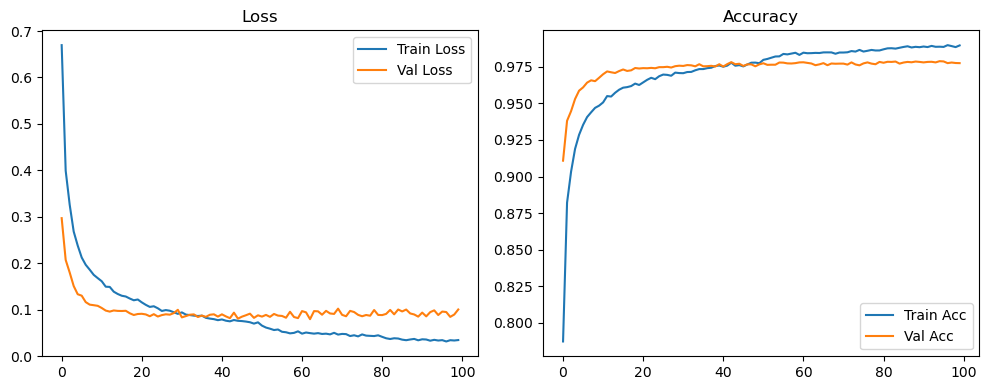

🚀 Running: batch64_lr0.01_0.005_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3541, Acc: 0.8930 | Val Loss: 0.1977, Acc: 0.9413


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1523, Acc: 0.9548 | Val Loss: 0.1836, Acc: 0.9458


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1068, Acc: 0.9671 | Val Loss: 0.1357, Acc: 0.9599


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0833, Acc: 0.9736 | Val Loss: 0.1182, Acc: 0.9645


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0642, Acc: 0.9793 | Val Loss: 0.1042, Acc: 0.9691


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0551, Acc: 0.9819 | Val Loss: 0.1174, Acc: 0.9683


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0471, Acc: 0.9848 | Val Loss: 0.1027, Acc: 0.9728


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0399, Acc: 0.9868 | Val Loss: 0.1245, Acc: 0.9688


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0353, Acc: 0.9883 | Val Loss: 0.1107, Acc: 0.9721


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0327, Acc: 0.9896 | Val Loss: 0.1355, Acc: 0.9702


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0310, Acc: 0.9897 | Val Loss: 0.1147, Acc: 0.9722


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0289, Acc: 0.9903 | Val Loss: 0.1281, Acc: 0.9691


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0233, Acc: 0.9916 | Val Loss: 0.1186, Acc: 0.9728


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0235, Acc: 0.9917 | Val Loss: 0.1347, Acc: 0.9675


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0227, Acc: 0.9925 | Val Loss: 0.1582, Acc: 0.9700


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0226, Acc: 0.9927 | Val Loss: 0.1380, Acc: 0.9717


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9934 | Val Loss: 0.1540, Acc: 0.9711


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9943 | Val Loss: 0.1206, Acc: 0.9703


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9935 | Val Loss: 0.1140, Acc: 0.9719


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9946 | Val Loss: 0.1276, Acc: 0.9696


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9937 | Val Loss: 0.2074, Acc: 0.9547


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9948 | Val Loss: 0.1238, Acc: 0.9702


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9946 | Val Loss: 0.1038, Acc: 0.9716


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9949 | Val Loss: 0.1317, Acc: 0.9721


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9953 | Val Loss: 0.1088, Acc: 0.9756


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9953 | Val Loss: 0.1022, Acc: 0.9746


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9951 | Val Loss: 0.1195, Acc: 0.9736


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9958 | Val Loss: 0.1408, Acc: 0.9711


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9963 | Val Loss: 0.1327, Acc: 0.9725


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9960 | Val Loss: 0.1173, Acc: 0.9746


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9957 | Val Loss: 0.1464, Acc: 0.9719


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9960 | Val Loss: 0.1517, Acc: 0.9724


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9953 | Val Loss: 0.1416, Acc: 0.9712


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9965 | Val Loss: 0.1648, Acc: 0.9666


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9961 | Val Loss: 0.1249, Acc: 0.9740


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9964 | Val Loss: 0.1134, Acc: 0.9733


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9967 | Val Loss: 0.1124, Acc: 0.9732


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9967 | Val Loss: 0.1702, Acc: 0.9707


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9965 | Val Loss: 0.1496, Acc: 0.9742


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9964 | Val Loss: 0.1606, Acc: 0.9673


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9966 | Val Loss: 0.1192, Acc: 0.9728


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.1387, Acc: 0.9719


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9964 | Val Loss: 0.1192, Acc: 0.9743


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9971 | Val Loss: 0.1276, Acc: 0.9741


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9975 | Val Loss: 0.1120, Acc: 0.9732


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.1044, Acc: 0.9759


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9968 | Val Loss: 0.1279, Acc: 0.9738


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.1679, Acc: 0.9739


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9970 | Val Loss: 0.1260, Acc: 0.9759


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9977 | Val Loss: 0.1601, Acc: 0.9775


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1197, Acc: 0.9785


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1308, Acc: 0.9779


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1384, Acc: 0.9772


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1786, Acc: 0.9769


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9987 | Val Loss: 0.1440, Acc: 0.9768


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1287, Acc: 0.9778


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1237, Acc: 0.9770


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1651, Acc: 0.9780


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1471, Acc: 0.9754


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1488, Acc: 0.9769


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1328, Acc: 0.9772


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1515, Acc: 0.9772


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1235, Acc: 0.9774


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1435, Acc: 0.9773


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.1491, Acc: 0.9769


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1486, Acc: 0.9771


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1352, Acc: 0.9760


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1507, Acc: 0.9768


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1654, Acc: 0.9779


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1422, Acc: 0.9767


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1480, Acc: 0.9778


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1883, Acc: 0.9774


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.1827, Acc: 0.9761


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1667, Acc: 0.9771


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1847, Acc: 0.9771


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1833, Acc: 0.9768


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1658, Acc: 0.9748


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.2018, Acc: 0.9755


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1817, Acc: 0.9752


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1902, Acc: 0.9755


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1600, Acc: 0.9765


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1773, Acc: 0.9772


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1974, Acc: 0.9772


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1726, Acc: 0.9778


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1631, Acc: 0.9775


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1692, Acc: 0.9784


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1742, Acc: 0.9776


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1818, Acc: 0.9776


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1871, Acc: 0.9782


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1870, Acc: 0.9779


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1723, Acc: 0.9786


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1905, Acc: 0.9779


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2121, Acc: 0.9782


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1905, Acc: 0.9782


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1881, Acc: 0.9788


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2007, Acc: 0.9785


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1982, Acc: 0.9788


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1775, Acc: 0.9773


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1889, Acc: 0.9781


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1943, Acc: 0.9786


Final Test Loss: 0.1658 Accuracy: 0.9820


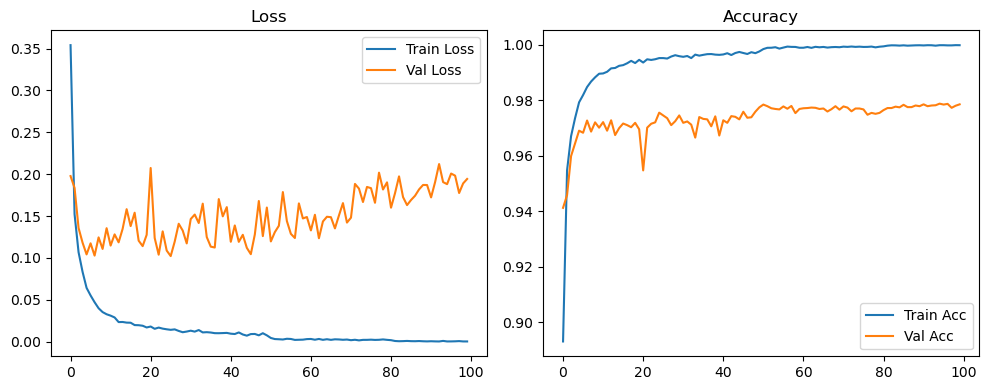

🚀 Running: batch64_lr0.01_0.005_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4628, Acc: 0.8580 | Val Loss: 0.2421, Acc: 0.9257


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2591, Acc: 0.9213 | Val Loss: 0.1563, Acc: 0.9517


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1900, Acc: 0.9414 | Val Loss: 0.1381, Acc: 0.9578


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1470, Acc: 0.9540 | Val Loss: 0.1192, Acc: 0.9642


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1199, Acc: 0.9630 | Val Loss: 0.1129, Acc: 0.9667


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1073, Acc: 0.9654 | Val Loss: 0.1156, Acc: 0.9664


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0948, Acc: 0.9699 | Val Loss: 0.1016, Acc: 0.9700


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0824, Acc: 0.9743 | Val Loss: 0.0991, Acc: 0.9712


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0746, Acc: 0.9758 | Val Loss: 0.1087, Acc: 0.9702


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0709, Acc: 0.9776 | Val Loss: 0.0954, Acc: 0.9732


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0641, Acc: 0.9788 | Val Loss: 0.1012, Acc: 0.9730


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0597, Acc: 0.9800 | Val Loss: 0.1041, Acc: 0.9734


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0567, Acc: 0.9820 | Val Loss: 0.0994, Acc: 0.9732


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0514, Acc: 0.9832 | Val Loss: 0.0976, Acc: 0.9761


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0515, Acc: 0.9834 | Val Loss: 0.1011, Acc: 0.9738


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0475, Acc: 0.9842 | Val Loss: 0.0950, Acc: 0.9755


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0442, Acc: 0.9858 | Val Loss: 0.0915, Acc: 0.9750


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0437, Acc: 0.9855 | Val Loss: 0.1021, Acc: 0.9741


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0402, Acc: 0.9862 | Val Loss: 0.0889, Acc: 0.9754


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0401, Acc: 0.9869 | Val Loss: 0.0949, Acc: 0.9751


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0397, Acc: 0.9869 | Val Loss: 0.0843, Acc: 0.9757


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0357, Acc: 0.9881 | Val Loss: 0.0967, Acc: 0.9755


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0336, Acc: 0.9889 | Val Loss: 0.0908, Acc: 0.9752


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0343, Acc: 0.9885 | Val Loss: 0.0957, Acc: 0.9751


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0320, Acc: 0.9895 | Val Loss: 0.0917, Acc: 0.9757


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0323, Acc: 0.9896 | Val Loss: 0.0887, Acc: 0.9779


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0337, Acc: 0.9888 | Val Loss: 0.0902, Acc: 0.9767


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0294, Acc: 0.9903 | Val Loss: 0.0939, Acc: 0.9772


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0285, Acc: 0.9899 | Val Loss: 0.1000, Acc: 0.9764


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0271, Acc: 0.9908 | Val Loss: 0.1029, Acc: 0.9778


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0287, Acc: 0.9906 | Val Loss: 0.0898, Acc: 0.9768


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0262, Acc: 0.9916 | Val Loss: 0.0895, Acc: 0.9751


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0285, Acc: 0.9904 | Val Loss: 0.0943, Acc: 0.9748


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9912 | Val Loss: 0.0937, Acc: 0.9773


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9918 | Val Loss: 0.0908, Acc: 0.9772


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0247, Acc: 0.9916 | Val Loss: 0.0844, Acc: 0.9763


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0251, Acc: 0.9921 | Val Loss: 0.0946, Acc: 0.9778


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9921 | Val Loss: 0.1110, Acc: 0.9773


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0221, Acc: 0.9923 | Val Loss: 0.1078, Acc: 0.9778


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0232, Acc: 0.9921 | Val Loss: 0.0960, Acc: 0.9778


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9929 | Val Loss: 0.1019, Acc: 0.9785


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9931 | Val Loss: 0.1147, Acc: 0.9770


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0229, Acc: 0.9924 | Val Loss: 0.1136, Acc: 0.9785


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0229, Acc: 0.9928 | Val Loss: 0.0957, Acc: 0.9780


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0214, Acc: 0.9924 | Val Loss: 0.1102, Acc: 0.9776


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9931 | Val Loss: 0.0885, Acc: 0.9782


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0200, Acc: 0.9938 | Val Loss: 0.0850, Acc: 0.9793


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0176, Acc: 0.9944 | Val Loss: 0.1058, Acc: 0.9771


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0195, Acc: 0.9934 | Val Loss: 0.1050, Acc: 0.9773


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9935 | Val Loss: 0.0897, Acc: 0.9786


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0146, Acc: 0.9952 | Val Loss: 0.1008, Acc: 0.9791


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9959 | Val Loss: 0.0881, Acc: 0.9796


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9962 | Val Loss: 0.1067, Acc: 0.9789


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9961 | Val Loss: 0.1062, Acc: 0.9790


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9962 | Val Loss: 0.0896, Acc: 0.9802


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9966 | Val Loss: 0.0973, Acc: 0.9798


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9969 | Val Loss: 0.0949, Acc: 0.9792


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9968 | Val Loss: 0.1054, Acc: 0.9799


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9967 | Val Loss: 0.1052, Acc: 0.9798


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9968 | Val Loss: 0.0938, Acc: 0.9797


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9971 | Val Loss: 0.0896, Acc: 0.9784


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9973 | Val Loss: 0.1141, Acc: 0.9799


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9969 | Val Loss: 0.0915, Acc: 0.9798


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.0993, Acc: 0.9802


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9971 | Val Loss: 0.1009, Acc: 0.9789


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.1206, Acc: 0.9790


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9971 | Val Loss: 0.1188, Acc: 0.9792


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9971 | Val Loss: 0.0912, Acc: 0.9784


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9971 | Val Loss: 0.1354, Acc: 0.9789


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.0921, Acc: 0.9786


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9973 | Val Loss: 0.1283, Acc: 0.9797


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9972 | Val Loss: 0.1226, Acc: 0.9786


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9976 | Val Loss: 0.1055, Acc: 0.9796


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.1133, Acc: 0.9791


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.1092, Acc: 0.9796


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.1071, Acc: 0.9798


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9974 | Val Loss: 0.1124, Acc: 0.9792


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 0.0969, Acc: 0.9798


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.1081, Acc: 0.9788


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9977 | Val Loss: 0.1211, Acc: 0.9794


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1138, Acc: 0.9800


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.1198, Acc: 0.9802


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9980 | Val Loss: 0.1235, Acc: 0.9802


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.1111, Acc: 0.9806


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1258, Acc: 0.9802


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1313, Acc: 0.9798


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1194, Acc: 0.9806


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9983 | Val Loss: 0.1174, Acc: 0.9803


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.1287, Acc: 0.9808


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1236, Acc: 0.9809


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.1077, Acc: 0.9807


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1129, Acc: 0.9812


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1079, Acc: 0.9804


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.1065, Acc: 0.9802


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1280, Acc: 0.9806


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1154, Acc: 0.9808


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1130, Acc: 0.9805


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1067, Acc: 0.9812


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1153, Acc: 0.9808


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1121, Acc: 0.9808


Final Test Loss: 0.1153 Accuracy: 0.9820


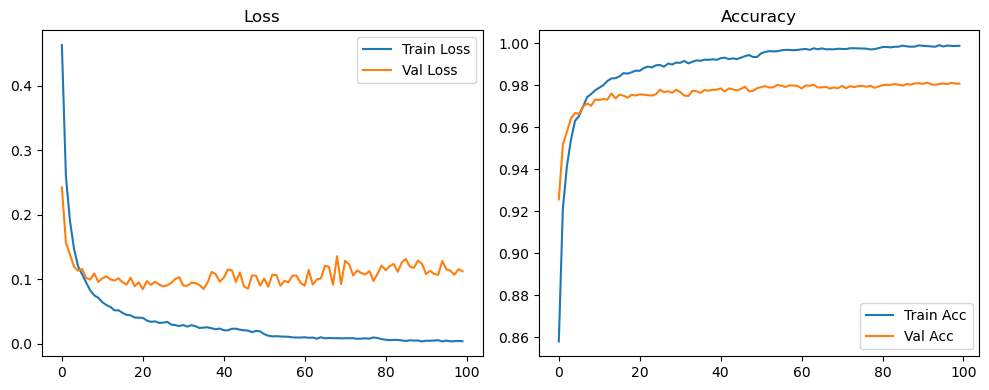

🚀 Running: batch64_lr0.01_0.005_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.6696, Acc: 0.7873 | Val Loss: 0.2973, Acc: 0.9108


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.3993, Acc: 0.8821 | Val Loss: 0.2073, Acc: 0.9381


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.3262, Acc: 0.9033 | Val Loss: 0.1802, Acc: 0.9447


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2684, Acc: 0.9189 | Val Loss: 0.1512, Acc: 0.9530


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.2383, Acc: 0.9285 | Val Loss: 0.1335, Acc: 0.9587


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.2125, Acc: 0.9353 | Val Loss: 0.1304, Acc: 0.9609


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1969, Acc: 0.9406 | Val Loss: 0.1166, Acc: 0.9642


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1863, Acc: 0.9439 | Val Loss: 0.1111, Acc: 0.9657


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1752, Acc: 0.9469 | Val Loss: 0.1099, Acc: 0.9652


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1682, Acc: 0.9484 | Val Loss: 0.1086, Acc: 0.9675


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1615, Acc: 0.9507 | Val Loss: 0.1039, Acc: 0.9699


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1497, Acc: 0.9550 | Val Loss: 0.0983, Acc: 0.9718


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1493, Acc: 0.9547 | Val Loss: 0.0961, Acc: 0.9712


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1390, Acc: 0.9573 | Val Loss: 0.0986, Acc: 0.9708


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1340, Acc: 0.9593 | Val Loss: 0.0976, Acc: 0.9721


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1302, Acc: 0.9607 | Val Loss: 0.0974, Acc: 0.9732


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1286, Acc: 0.9611 | Val Loss: 0.0979, Acc: 0.9722


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1243, Acc: 0.9618 | Val Loss: 0.0925, Acc: 0.9726


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1205, Acc: 0.9635 | Val Loss: 0.0888, Acc: 0.9742


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1222, Acc: 0.9626 | Val Loss: 0.0910, Acc: 0.9738


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.1160, Acc: 0.9643 | Val Loss: 0.0914, Acc: 0.9741


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.1107, Acc: 0.9661 | Val Loss: 0.0900, Acc: 0.9740


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.1062, Acc: 0.9675 | Val Loss: 0.0861, Acc: 0.9742


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.1076, Acc: 0.9665 | Val Loss: 0.0906, Acc: 0.9740


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.1033, Acc: 0.9686 | Val Loss: 0.0855, Acc: 0.9748


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0975, Acc: 0.9697 | Val Loss: 0.0886, Acc: 0.9748


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0994, Acc: 0.9695 | Val Loss: 0.0903, Acc: 0.9750


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0980, Acc: 0.9689 | Val Loss: 0.0895, Acc: 0.9745


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0947, Acc: 0.9710 | Val Loss: 0.0930, Acc: 0.9754


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0913, Acc: 0.9707 | Val Loss: 0.1000, Acc: 0.9758


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0944, Acc: 0.9706 | Val Loss: 0.0837, Acc: 0.9756


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0897, Acc: 0.9714 | Val Loss: 0.0864, Acc: 0.9762


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0887, Acc: 0.9715 | Val Loss: 0.0894, Acc: 0.9760


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0874, Acc: 0.9726 | Val Loss: 0.0901, Acc: 0.9753


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0866, Acc: 0.9734 | Val Loss: 0.0845, Acc: 0.9768


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0874, Acc: 0.9734 | Val Loss: 0.0876, Acc: 0.9753


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0827, Acc: 0.9741 | Val Loss: 0.0848, Acc: 0.9754


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0811, Acc: 0.9744 | Val Loss: 0.0893, Acc: 0.9757


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0799, Acc: 0.9755 | Val Loss: 0.0903, Acc: 0.9752


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0777, Acc: 0.9759 | Val Loss: 0.0854, Acc: 0.9768


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0792, Acc: 0.9751 | Val Loss: 0.0903, Acc: 0.9752


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0765, Acc: 0.9758 | Val Loss: 0.0858, Acc: 0.9768


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0752, Acc: 0.9778 | Val Loss: 0.0820, Acc: 0.9782


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0780, Acc: 0.9757 | Val Loss: 0.0938, Acc: 0.9768


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0763, Acc: 0.9761 | Val Loss: 0.0810, Acc: 0.9771


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0757, Acc: 0.9753 | Val Loss: 0.0852, Acc: 0.9756


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0747, Acc: 0.9766 | Val Loss: 0.0883, Acc: 0.9767


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0732, Acc: 0.9778 | Val Loss: 0.0917, Acc: 0.9767


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0703, Acc: 0.9779 | Val Loss: 0.0827, Acc: 0.9753


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0730, Acc: 0.9775 | Val Loss: 0.0881, Acc: 0.9767


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0659, Acc: 0.9798 | Val Loss: 0.0854, Acc: 0.9774


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0618, Acc: 0.9804 | Val Loss: 0.0890, Acc: 0.9763


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0594, Acc: 0.9812 | Val Loss: 0.0848, Acc: 0.9764


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0565, Acc: 0.9820 | Val Loss: 0.0910, Acc: 0.9764


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0576, Acc: 0.9821 | Val Loss: 0.0875, Acc: 0.9779


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0527, Acc: 0.9838 | Val Loss: 0.0868, Acc: 0.9778


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0517, Acc: 0.9835 | Val Loss: 0.0829, Acc: 0.9773


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0493, Acc: 0.9840 | Val Loss: 0.0957, Acc: 0.9772


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0503, Acc: 0.9846 | Val Loss: 0.0844, Acc: 0.9775


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0537, Acc: 0.9831 | Val Loss: 0.0821, Acc: 0.9780


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0486, Acc: 0.9846 | Val Loss: 0.0972, Acc: 0.9781


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0511, Acc: 0.9843 | Val Loss: 0.0945, Acc: 0.9777


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0498, Acc: 0.9843 | Val Loss: 0.0798, Acc: 0.9772


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0487, Acc: 0.9845 | Val Loss: 0.0972, Acc: 0.9761


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0498, Acc: 0.9844 | Val Loss: 0.0967, Acc: 0.9767


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0480, Acc: 0.9848 | Val Loss: 0.0894, Acc: 0.9775


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0486, Acc: 0.9849 | Val Loss: 0.0977, Acc: 0.9761


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0471, Acc: 0.9848 | Val Loss: 0.0921, Acc: 0.9772


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0505, Acc: 0.9839 | Val Loss: 0.0911, Acc: 0.9771


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0467, Acc: 0.9848 | Val Loss: 0.1025, Acc: 0.9772


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0481, Acc: 0.9848 | Val Loss: 0.0892, Acc: 0.9772


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0476, Acc: 0.9849 | Val Loss: 0.0861, Acc: 0.9765


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0435, Acc: 0.9858 | Val Loss: 0.0977, Acc: 0.9780


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0452, Acc: 0.9854 | Val Loss: 0.0952, Acc: 0.9766


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0428, Acc: 0.9865 | Val Loss: 0.0891, Acc: 0.9760


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0470, Acc: 0.9854 | Val Loss: 0.0861, Acc: 0.9773


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0444, Acc: 0.9859 | Val Loss: 0.0888, Acc: 0.9780


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0439, Acc: 0.9865 | Val Loss: 0.0873, Acc: 0.9772


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0435, Acc: 0.9861 | Val Loss: 0.0996, Acc: 0.9768


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0451, Acc: 0.9862 | Val Loss: 0.0889, Acc: 0.9783


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0414, Acc: 0.9868 | Val Loss: 0.0906, Acc: 0.9778


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0386, Acc: 0.9874 | Val Loss: 0.0930, Acc: 0.9781


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0373, Acc: 0.9875 | Val Loss: 0.0966, Acc: 0.9779


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0390, Acc: 0.9875 | Val Loss: 0.0902, Acc: 0.9788


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0379, Acc: 0.9879 | Val Loss: 0.0965, Acc: 0.9768


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0356, Acc: 0.9891 | Val Loss: 0.0962, Acc: 0.9778


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0348, Acc: 0.9892 | Val Loss: 0.0988, Acc: 0.9778


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0360, Acc: 0.9887 | Val Loss: 0.0933, Acc: 0.9782


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0369, Acc: 0.9884 | Val Loss: 0.0934, Acc: 0.9782


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0346, Acc: 0.9890 | Val Loss: 0.0905, Acc: 0.9780


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0364, Acc: 0.9886 | Val Loss: 0.0935, Acc: 0.9778


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0358, Acc: 0.9887 | Val Loss: 0.0875, Acc: 0.9780


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0343, Acc: 0.9892 | Val Loss: 0.0970, Acc: 0.9784


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0351, Acc: 0.9891 | Val Loss: 0.0966, Acc: 0.9782


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0336, Acc: 0.9888 | Val Loss: 0.0931, Acc: 0.9783


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0343, Acc: 0.9890 | Val Loss: 0.0956, Acc: 0.9789


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0320, Acc: 0.9899 | Val Loss: 0.0929, Acc: 0.9780


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0341, Acc: 0.9895 | Val Loss: 0.0877, Acc: 0.9780


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0331, Acc: 0.9889 | Val Loss: 0.0929, Acc: 0.9778


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0351, Acc: 0.9891 | Val Loss: 0.0957, Acc: 0.9782


Final Test Loss: 0.0804 Accuracy: 0.9815


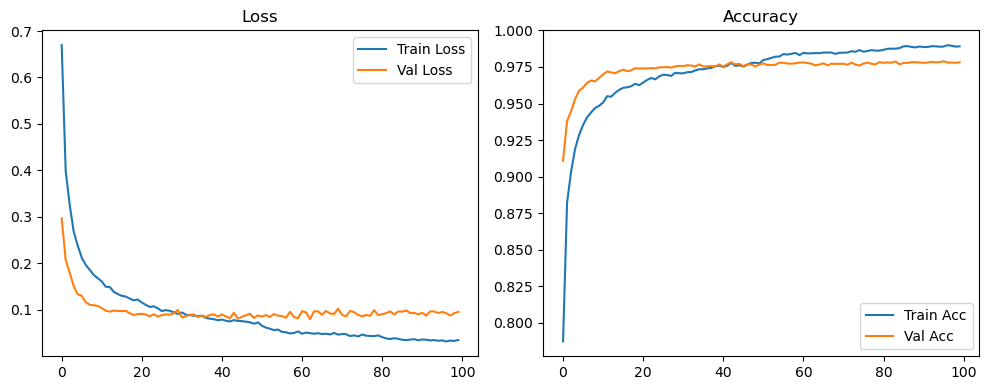

🚀 Running: batch64_lr0.01_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3541, Acc: 0.8930 | Val Loss: 0.1977, Acc: 0.9413


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1523, Acc: 0.9548 | Val Loss: 0.1836, Acc: 0.9458


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1068, Acc: 0.9671 | Val Loss: 0.1357, Acc: 0.9599


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0833, Acc: 0.9736 | Val Loss: 0.1182, Acc: 0.9645


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0642, Acc: 0.9793 | Val Loss: 0.1042, Acc: 0.9691


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0551, Acc: 0.9819 | Val Loss: 0.1174, Acc: 0.9683


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0471, Acc: 0.9848 | Val Loss: 0.1027, Acc: 0.9728


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0399, Acc: 0.9868 | Val Loss: 0.1245, Acc: 0.9688


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0353, Acc: 0.9883 | Val Loss: 0.1107, Acc: 0.9721


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0327, Acc: 0.9896 | Val Loss: 0.1355, Acc: 0.9702


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0310, Acc: 0.9897 | Val Loss: 0.1147, Acc: 0.9722


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0289, Acc: 0.9903 | Val Loss: 0.1281, Acc: 0.9691


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0233, Acc: 0.9916 | Val Loss: 0.1186, Acc: 0.9728


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0235, Acc: 0.9917 | Val Loss: 0.1347, Acc: 0.9675


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0227, Acc: 0.9925 | Val Loss: 0.1582, Acc: 0.9700


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0226, Acc: 0.9927 | Val Loss: 0.1380, Acc: 0.9717


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9934 | Val Loss: 0.1540, Acc: 0.9711


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9943 | Val Loss: 0.1206, Acc: 0.9703


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9935 | Val Loss: 0.1140, Acc: 0.9719


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9946 | Val Loss: 0.1276, Acc: 0.9696


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9937 | Val Loss: 0.2074, Acc: 0.9547


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9948 | Val Loss: 0.1238, Acc: 0.9702


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9946 | Val Loss: 0.1038, Acc: 0.9716


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9949 | Val Loss: 0.1317, Acc: 0.9721


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9953 | Val Loss: 0.1088, Acc: 0.9756


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9953 | Val Loss: 0.1022, Acc: 0.9746


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9951 | Val Loss: 0.1195, Acc: 0.9736


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9958 | Val Loss: 0.1408, Acc: 0.9711


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9963 | Val Loss: 0.1327, Acc: 0.9725


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9960 | Val Loss: 0.1173, Acc: 0.9746


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9957 | Val Loss: 0.1464, Acc: 0.9719


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9960 | Val Loss: 0.1517, Acc: 0.9724


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9953 | Val Loss: 0.1416, Acc: 0.9712


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9965 | Val Loss: 0.1648, Acc: 0.9666


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9961 | Val Loss: 0.1249, Acc: 0.9740


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9964 | Val Loss: 0.1134, Acc: 0.9733


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9967 | Val Loss: 0.1124, Acc: 0.9732


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9967 | Val Loss: 0.1702, Acc: 0.9707


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9965 | Val Loss: 0.1496, Acc: 0.9742


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9964 | Val Loss: 0.1606, Acc: 0.9673


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9966 | Val Loss: 0.1192, Acc: 0.9728


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.1387, Acc: 0.9719


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9964 | Val Loss: 0.1192, Acc: 0.9743


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9971 | Val Loss: 0.1276, Acc: 0.9741


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9975 | Val Loss: 0.1120, Acc: 0.9732


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.1044, Acc: 0.9759


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9968 | Val Loss: 0.1279, Acc: 0.9738


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.1679, Acc: 0.9739


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9970 | Val Loss: 0.1260, Acc: 0.9759


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9977 | Val Loss: 0.1601, Acc: 0.9775


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.1343, Acc: 0.9797


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1396, Acc: 0.9789


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1521, Acc: 0.9783


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1356, Acc: 0.9794


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1391, Acc: 0.9786


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1450, Acc: 0.9785


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.1579, Acc: 0.9788


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1950, Acc: 0.9785


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1603, Acc: 0.9783


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1575, Acc: 0.9780


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1589, Acc: 0.9779


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1591, Acc: 0.9783


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1474, Acc: 0.9782


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1745, Acc: 0.9790


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1575, Acc: 0.9789


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1591, Acc: 0.9783


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1700, Acc: 0.9777


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1828, Acc: 0.9792


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1629, Acc: 0.9794


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1671, Acc: 0.9792


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.1933, Acc: 0.9789


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1715, Acc: 0.9798


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1476, Acc: 0.9789


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1618, Acc: 0.9783


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.1922, Acc: 0.9801


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1644, Acc: 0.9791


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1722, Acc: 0.9786


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1903, Acc: 0.9778


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1934, Acc: 0.9776


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1721, Acc: 0.9794


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1633, Acc: 0.9790


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1759, Acc: 0.9803


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1831, Acc: 0.9796


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1869, Acc: 0.9796


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1765, Acc: 0.9788


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1799, Acc: 0.9800


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1564, Acc: 0.9801


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1529, Acc: 0.9798


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1546, Acc: 0.9791


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1731, Acc: 0.9798


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1569, Acc: 0.9788


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1598, Acc: 0.9788


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1649, Acc: 0.9793


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1667, Acc: 0.9795


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1812, Acc: 0.9798


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1648, Acc: 0.9788


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1667, Acc: 0.9791


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.1636, Acc: 0.9790


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1819, Acc: 0.9797


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1915, Acc: 0.9791


Final Test Loss: 0.1614 Accuracy: 0.9831


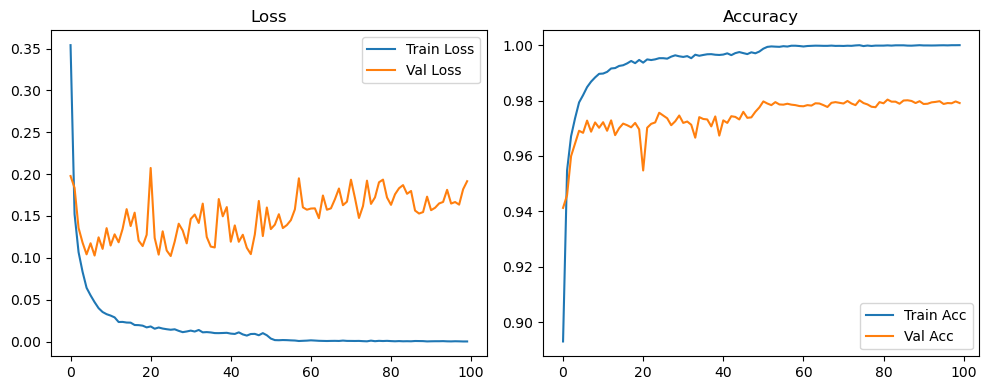

🚀 Running: batch64_lr0.01_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4628, Acc: 0.8580 | Val Loss: 0.2421, Acc: 0.9257


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2591, Acc: 0.9213 | Val Loss: 0.1563, Acc: 0.9517


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1900, Acc: 0.9414 | Val Loss: 0.1381, Acc: 0.9578


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1470, Acc: 0.9540 | Val Loss: 0.1192, Acc: 0.9642


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1199, Acc: 0.9630 | Val Loss: 0.1129, Acc: 0.9667


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1073, Acc: 0.9654 | Val Loss: 0.1156, Acc: 0.9664


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0948, Acc: 0.9699 | Val Loss: 0.1016, Acc: 0.9700


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0824, Acc: 0.9743 | Val Loss: 0.0991, Acc: 0.9712


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0746, Acc: 0.9758 | Val Loss: 0.1087, Acc: 0.9702


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0709, Acc: 0.9776 | Val Loss: 0.0954, Acc: 0.9732


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0641, Acc: 0.9788 | Val Loss: 0.1012, Acc: 0.9730


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0597, Acc: 0.9800 | Val Loss: 0.1041, Acc: 0.9734


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0567, Acc: 0.9820 | Val Loss: 0.0994, Acc: 0.9732


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0514, Acc: 0.9832 | Val Loss: 0.0976, Acc: 0.9761


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0515, Acc: 0.9834 | Val Loss: 0.1011, Acc: 0.9738


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0475, Acc: 0.9842 | Val Loss: 0.0950, Acc: 0.9755


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0442, Acc: 0.9858 | Val Loss: 0.0915, Acc: 0.9750


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0437, Acc: 0.9855 | Val Loss: 0.1021, Acc: 0.9741


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0402, Acc: 0.9862 | Val Loss: 0.0889, Acc: 0.9754


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0401, Acc: 0.9869 | Val Loss: 0.0949, Acc: 0.9751


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0397, Acc: 0.9869 | Val Loss: 0.0843, Acc: 0.9757


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0357, Acc: 0.9881 | Val Loss: 0.0967, Acc: 0.9755


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0336, Acc: 0.9889 | Val Loss: 0.0908, Acc: 0.9752


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0343, Acc: 0.9885 | Val Loss: 0.0957, Acc: 0.9751


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0320, Acc: 0.9895 | Val Loss: 0.0917, Acc: 0.9757


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0323, Acc: 0.9896 | Val Loss: 0.0887, Acc: 0.9779


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0337, Acc: 0.9888 | Val Loss: 0.0902, Acc: 0.9767


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0294, Acc: 0.9903 | Val Loss: 0.0939, Acc: 0.9772


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0285, Acc: 0.9899 | Val Loss: 0.1000, Acc: 0.9764


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0271, Acc: 0.9908 | Val Loss: 0.1029, Acc: 0.9778


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0287, Acc: 0.9906 | Val Loss: 0.0898, Acc: 0.9768


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0262, Acc: 0.9916 | Val Loss: 0.0895, Acc: 0.9751


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0285, Acc: 0.9904 | Val Loss: 0.0943, Acc: 0.9748


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9912 | Val Loss: 0.0937, Acc: 0.9773


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9918 | Val Loss: 0.0908, Acc: 0.9772


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0247, Acc: 0.9916 | Val Loss: 0.0844, Acc: 0.9763


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0251, Acc: 0.9921 | Val Loss: 0.0946, Acc: 0.9778


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9921 | Val Loss: 0.1110, Acc: 0.9773


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0221, Acc: 0.9923 | Val Loss: 0.1078, Acc: 0.9778


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0232, Acc: 0.9921 | Val Loss: 0.0960, Acc: 0.9778


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9929 | Val Loss: 0.1019, Acc: 0.9785


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9931 | Val Loss: 0.1147, Acc: 0.9770


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0229, Acc: 0.9924 | Val Loss: 0.1136, Acc: 0.9785


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0229, Acc: 0.9928 | Val Loss: 0.0957, Acc: 0.9780


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0214, Acc: 0.9924 | Val Loss: 0.1102, Acc: 0.9776


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9931 | Val Loss: 0.0885, Acc: 0.9782


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0200, Acc: 0.9938 | Val Loss: 0.0850, Acc: 0.9793


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0176, Acc: 0.9944 | Val Loss: 0.1058, Acc: 0.9771


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0195, Acc: 0.9934 | Val Loss: 0.1050, Acc: 0.9773


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9935 | Val Loss: 0.0897, Acc: 0.9786


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0142, Acc: 0.9952 | Val Loss: 0.0921, Acc: 0.9796


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9965 | Val Loss: 0.0928, Acc: 0.9801


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0100, Acc: 0.9966 | Val Loss: 0.1028, Acc: 0.9792


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 0.1033, Acc: 0.9798


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9968 | Val Loss: 0.0925, Acc: 0.9808


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9971 | Val Loss: 0.0914, Acc: 0.9804


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.0959, Acc: 0.9808


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.1015, Acc: 0.9808


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1040, Acc: 0.9804


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.0965, Acc: 0.9798


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.0975, Acc: 0.9802


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.1065, Acc: 0.9800


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.0978, Acc: 0.9802


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.0929, Acc: 0.9799


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.0945, Acc: 0.9794


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.1098, Acc: 0.9813


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9981 | Val Loss: 0.1099, Acc: 0.9791


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.0886, Acc: 0.9789


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9978 | Val Loss: 0.1178, Acc: 0.9794


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1074, Acc: 0.9794


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9979 | Val Loss: 0.1172, Acc: 0.9799


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.1264, Acc: 0.9798


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.1074, Acc: 0.9794


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.1003, Acc: 0.9795


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.1219, Acc: 0.9800


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.1087, Acc: 0.9798


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1010, Acc: 0.9801


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.1061, Acc: 0.9802


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1212, Acc: 0.9793


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9981 | Val Loss: 0.1018, Acc: 0.9798


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1117, Acc: 0.9796


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.1203, Acc: 0.9798


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1244, Acc: 0.9811


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1120, Acc: 0.9808


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9983 | Val Loss: 0.1108, Acc: 0.9802


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1201, Acc: 0.9805


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.1058, Acc: 0.9805


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.1168, Acc: 0.9808


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9986 | Val Loss: 0.1111, Acc: 0.9801


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1106, Acc: 0.9811


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.1115, Acc: 0.9804


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1089, Acc: 0.9805


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1051, Acc: 0.9802


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.1122, Acc: 0.9802


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1296, Acc: 0.9808


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1125, Acc: 0.9812


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.1114, Acc: 0.9801


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1110, Acc: 0.9808


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1158, Acc: 0.9808


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1168, Acc: 0.9803


Final Test Loss: 0.1183 Accuracy: 0.9826


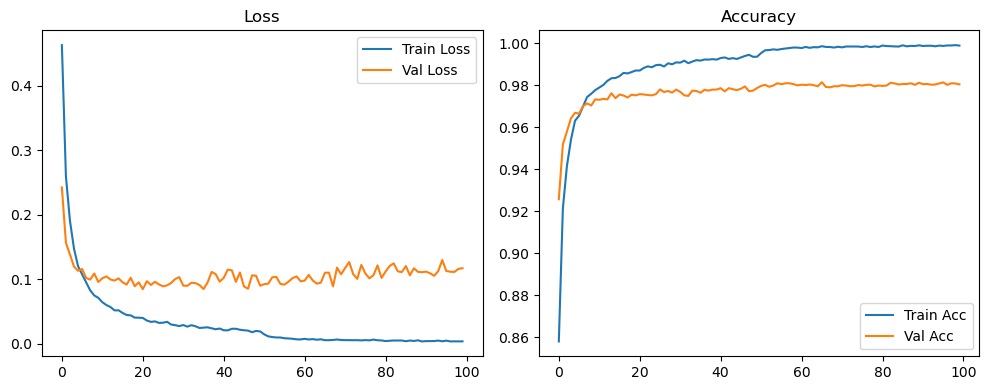

🚀 Running: batch64_lr0.01_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.6696, Acc: 0.7873 | Val Loss: 0.2973, Acc: 0.9108


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.3993, Acc: 0.8821 | Val Loss: 0.2073, Acc: 0.9381


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.3262, Acc: 0.9033 | Val Loss: 0.1802, Acc: 0.9447


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2684, Acc: 0.9189 | Val Loss: 0.1512, Acc: 0.9530


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.2383, Acc: 0.9285 | Val Loss: 0.1335, Acc: 0.9587


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.2125, Acc: 0.9353 | Val Loss: 0.1304, Acc: 0.9609


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1969, Acc: 0.9406 | Val Loss: 0.1166, Acc: 0.9642


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1863, Acc: 0.9439 | Val Loss: 0.1111, Acc: 0.9657


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1752, Acc: 0.9469 | Val Loss: 0.1099, Acc: 0.9652


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1682, Acc: 0.9484 | Val Loss: 0.1086, Acc: 0.9675


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1615, Acc: 0.9507 | Val Loss: 0.1039, Acc: 0.9699


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1497, Acc: 0.9550 | Val Loss: 0.0983, Acc: 0.9718


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1493, Acc: 0.9547 | Val Loss: 0.0961, Acc: 0.9712


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1390, Acc: 0.9573 | Val Loss: 0.0986, Acc: 0.9708


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1340, Acc: 0.9593 | Val Loss: 0.0976, Acc: 0.9721


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1302, Acc: 0.9607 | Val Loss: 0.0974, Acc: 0.9732


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1286, Acc: 0.9611 | Val Loss: 0.0979, Acc: 0.9722


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1243, Acc: 0.9618 | Val Loss: 0.0925, Acc: 0.9726


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1205, Acc: 0.9635 | Val Loss: 0.0888, Acc: 0.9742


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1222, Acc: 0.9626 | Val Loss: 0.0910, Acc: 0.9738


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.1160, Acc: 0.9643 | Val Loss: 0.0914, Acc: 0.9741


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.1107, Acc: 0.9661 | Val Loss: 0.0900, Acc: 0.9740


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.1062, Acc: 0.9675 | Val Loss: 0.0861, Acc: 0.9742


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.1076, Acc: 0.9665 | Val Loss: 0.0906, Acc: 0.9740


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.1033, Acc: 0.9686 | Val Loss: 0.0855, Acc: 0.9748


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0975, Acc: 0.9697 | Val Loss: 0.0886, Acc: 0.9748


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0994, Acc: 0.9695 | Val Loss: 0.0903, Acc: 0.9750


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0980, Acc: 0.9689 | Val Loss: 0.0895, Acc: 0.9745


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0947, Acc: 0.9710 | Val Loss: 0.0930, Acc: 0.9754


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0913, Acc: 0.9707 | Val Loss: 0.1000, Acc: 0.9758


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0944, Acc: 0.9706 | Val Loss: 0.0837, Acc: 0.9756


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0897, Acc: 0.9714 | Val Loss: 0.0864, Acc: 0.9762


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0887, Acc: 0.9715 | Val Loss: 0.0894, Acc: 0.9760


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0874, Acc: 0.9726 | Val Loss: 0.0901, Acc: 0.9753


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0866, Acc: 0.9734 | Val Loss: 0.0845, Acc: 0.9768


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0874, Acc: 0.9734 | Val Loss: 0.0876, Acc: 0.9753


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0827, Acc: 0.9741 | Val Loss: 0.0848, Acc: 0.9754


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0811, Acc: 0.9744 | Val Loss: 0.0893, Acc: 0.9757


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0799, Acc: 0.9755 | Val Loss: 0.0903, Acc: 0.9752


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0777, Acc: 0.9759 | Val Loss: 0.0854, Acc: 0.9768


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0792, Acc: 0.9751 | Val Loss: 0.0903, Acc: 0.9752


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0765, Acc: 0.9758 | Val Loss: 0.0858, Acc: 0.9768


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0752, Acc: 0.9778 | Val Loss: 0.0820, Acc: 0.9782


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0780, Acc: 0.9757 | Val Loss: 0.0938, Acc: 0.9768


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0763, Acc: 0.9761 | Val Loss: 0.0810, Acc: 0.9771


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0757, Acc: 0.9753 | Val Loss: 0.0852, Acc: 0.9756


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0747, Acc: 0.9766 | Val Loss: 0.0883, Acc: 0.9767


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0732, Acc: 0.9778 | Val Loss: 0.0917, Acc: 0.9767


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0703, Acc: 0.9779 | Val Loss: 0.0827, Acc: 0.9753


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0730, Acc: 0.9775 | Val Loss: 0.0881, Acc: 0.9767


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0649, Acc: 0.9802 | Val Loss: 0.0842, Acc: 0.9774


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0604, Acc: 0.9806 | Val Loss: 0.0909, Acc: 0.9762


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0586, Acc: 0.9811 | Val Loss: 0.0870, Acc: 0.9772


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0544, Acc: 0.9826 | Val Loss: 0.0864, Acc: 0.9765


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0553, Acc: 0.9825 | Val Loss: 0.0896, Acc: 0.9779


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0515, Acc: 0.9846 | Val Loss: 0.0854, Acc: 0.9774


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0502, Acc: 0.9839 | Val Loss: 0.0889, Acc: 0.9782


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0462, Acc: 0.9852 | Val Loss: 0.0952, Acc: 0.9778


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0470, Acc: 0.9847 | Val Loss: 0.0886, Acc: 0.9776


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0493, Acc: 0.9843 | Val Loss: 0.0818, Acc: 0.9778


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0461, Acc: 0.9850 | Val Loss: 0.0916, Acc: 0.9775


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0472, Acc: 0.9851 | Val Loss: 0.0911, Acc: 0.9779


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0461, Acc: 0.9853 | Val Loss: 0.0822, Acc: 0.9778


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0453, Acc: 0.9855 | Val Loss: 0.0927, Acc: 0.9768


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0454, Acc: 0.9853 | Val Loss: 0.0957, Acc: 0.9773


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0447, Acc: 0.9864 | Val Loss: 0.0838, Acc: 0.9778


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0453, Acc: 0.9860 | Val Loss: 0.0914, Acc: 0.9772


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0427, Acc: 0.9863 | Val Loss: 0.0847, Acc: 0.9779


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0462, Acc: 0.9851 | Val Loss: 0.0915, Acc: 0.9775


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0418, Acc: 0.9867 | Val Loss: 0.0926, Acc: 0.9777


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0432, Acc: 0.9863 | Val Loss: 0.0890, Acc: 0.9778


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0428, Acc: 0.9861 | Val Loss: 0.0907, Acc: 0.9782


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0390, Acc: 0.9870 | Val Loss: 0.0918, Acc: 0.9782


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0418, Acc: 0.9867 | Val Loss: 0.0951, Acc: 0.9778


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0390, Acc: 0.9874 | Val Loss: 0.0932, Acc: 0.9772


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0434, Acc: 0.9864 | Val Loss: 0.0862, Acc: 0.9782


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0390, Acc: 0.9873 | Val Loss: 0.0908, Acc: 0.9775


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0394, Acc: 0.9878 | Val Loss: 0.0928, Acc: 0.9779


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0400, Acc: 0.9872 | Val Loss: 0.0944, Acc: 0.9778


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0408, Acc: 0.9880 | Val Loss: 0.0875, Acc: 0.9783


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0385, Acc: 0.9878 | Val Loss: 0.0890, Acc: 0.9781


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0375, Acc: 0.9874 | Val Loss: 0.0900, Acc: 0.9779


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0371, Acc: 0.9879 | Val Loss: 0.0936, Acc: 0.9776


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0376, Acc: 0.9877 | Val Loss: 0.0909, Acc: 0.9777


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0379, Acc: 0.9879 | Val Loss: 0.0955, Acc: 0.9779


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0363, Acc: 0.9885 | Val Loss: 0.0949, Acc: 0.9776


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0350, Acc: 0.9890 | Val Loss: 0.0961, Acc: 0.9776


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0369, Acc: 0.9884 | Val Loss: 0.0917, Acc: 0.9779


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0372, Acc: 0.9884 | Val Loss: 0.0918, Acc: 0.9778


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0354, Acc: 0.9887 | Val Loss: 0.0878, Acc: 0.9782


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0371, Acc: 0.9881 | Val Loss: 0.0937, Acc: 0.9783


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0361, Acc: 0.9886 | Val Loss: 0.0883, Acc: 0.9784


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0348, Acc: 0.9891 | Val Loss: 0.0914, Acc: 0.9778


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0375, Acc: 0.9884 | Val Loss: 0.0973, Acc: 0.9776


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0340, Acc: 0.9887 | Val Loss: 0.0920, Acc: 0.9784


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0363, Acc: 0.9881 | Val Loss: 0.0965, Acc: 0.9778


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0334, Acc: 0.9889 | Val Loss: 0.0924, Acc: 0.9780


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0359, Acc: 0.9889 | Val Loss: 0.0876, Acc: 0.9774


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0350, Acc: 0.9886 | Val Loss: 0.0895, Acc: 0.9777


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0356, Acc: 0.9889 | Val Loss: 0.0928, Acc: 0.9783


Final Test Loss: 0.0813 Accuracy: 0.9813


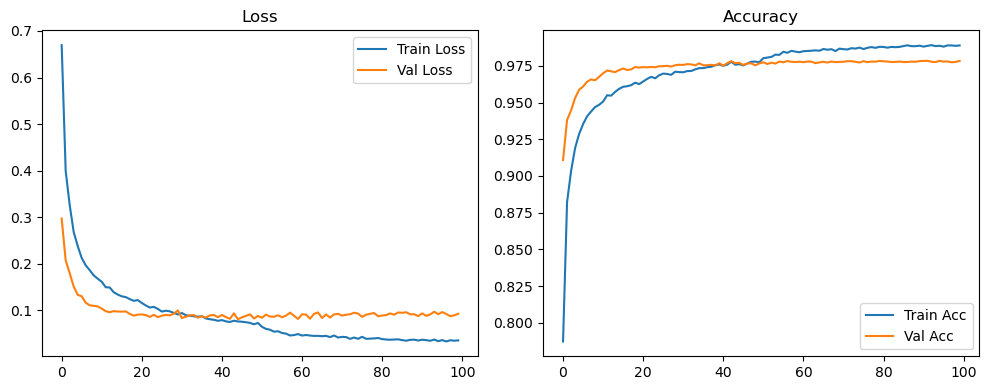

🚀 Running: batch64_lr0.005_0.005_0.005_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.3521, Acc: 0.8956 | Val Loss: 0.1921, Acc: 0.9421


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1443, Acc: 0.9561 | Val Loss: 0.1616, Acc: 0.9528


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0978, Acc: 0.9693 | Val Loss: 0.1172, Acc: 0.9629


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0736, Acc: 0.9769 | Val Loss: 0.1183, Acc: 0.9655


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0555, Acc: 0.9821 | Val Loss: 0.1177, Acc: 0.9676


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0473, Acc: 0.9849 | Val Loss: 0.1137, Acc: 0.9702


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0451, Acc: 0.9854 | Val Loss: 0.1137, Acc: 0.9698


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0378, Acc: 0.9875 | Val Loss: 0.1338, Acc: 0.9654


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0340, Acc: 0.9885 | Val Loss: 0.1192, Acc: 0.9712


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0356, Acc: 0.9881 | Val Loss: 0.1188, Acc: 0.9719


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0283, Acc: 0.9907 | Val Loss: 0.1160, Acc: 0.9726


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0247, Acc: 0.9921 | Val Loss: 0.1227, Acc: 0.9731


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0234, Acc: 0.9920 | Val Loss: 0.1255, Acc: 0.9721


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0231, Acc: 0.9922 | Val Loss: 0.1133, Acc: 0.9753


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0228, Acc: 0.9925 | Val Loss: 0.1334, Acc: 0.9729


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0210, Acc: 0.9933 | Val Loss: 0.1973, Acc: 0.9557


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0189, Acc: 0.9941 | Val Loss: 0.1372, Acc: 0.9732


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0185, Acc: 0.9945 | Val Loss: 0.1336, Acc: 0.9712


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0174, Acc: 0.9942 | Val Loss: 0.1259, Acc: 0.9742


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0194, Acc: 0.9935 | Val Loss: 0.1474, Acc: 0.9711


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0174, Acc: 0.9944 | Val Loss: 0.1318, Acc: 0.9747


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9953 | Val Loss: 0.1243, Acc: 0.9756


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9956 | Val Loss: 0.1167, Acc: 0.9756


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9966 | Val Loss: 0.1429, Acc: 0.9693


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9956 | Val Loss: 0.1292, Acc: 0.9755


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9959 | Val Loss: 0.1205, Acc: 0.9741


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9962 | Val Loss: 0.1543, Acc: 0.9696


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9964 | Val Loss: 0.1269, Acc: 0.9748


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9970 | Val Loss: 0.1353, Acc: 0.9731


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9969 | Val Loss: 0.1228, Acc: 0.9748


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9960 | Val Loss: 0.1205, Acc: 0.9750


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9967 | Val Loss: 0.1133, Acc: 0.9755


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.1240, Acc: 0.9747


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9969 | Val Loss: 0.1256, Acc: 0.9742


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9968 | Val Loss: 0.1161, Acc: 0.9780


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9969 | Val Loss: 0.1103, Acc: 0.9758


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.1262, Acc: 0.9761


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.1304, Acc: 0.9761


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.1423, Acc: 0.9745


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.1226, Acc: 0.9759


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9972 | Val Loss: 0.1345, Acc: 0.9729


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9977 | Val Loss: 0.1233, Acc: 0.9766


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.1127, Acc: 0.9768


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9969 | Val Loss: 0.1132, Acc: 0.9754


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.1351, Acc: 0.9769


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9973 | Val Loss: 0.1139, Acc: 0.9774


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1411, Acc: 0.9743


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.1292, Acc: 0.9765


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.1410, Acc: 0.9756


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.1384, Acc: 0.9733


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.1207, Acc: 0.9773


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.1405, Acc: 0.9758


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.1371, Acc: 0.9741


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9972 | Val Loss: 0.1308, Acc: 0.9752


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9976 | Val Loss: 0.1414, Acc: 0.9757


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1391, Acc: 0.9768


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.1421, Acc: 0.9767


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1465, Acc: 0.9740


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.1243, Acc: 0.9754


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1228, Acc: 0.9773


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.1289, Acc: 0.9759


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1516, Acc: 0.9738


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1236, Acc: 0.9789


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.1269, Acc: 0.9762


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1261, Acc: 0.9767


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1492, Acc: 0.9764


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1377, Acc: 0.9752


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9981 | Val Loss: 0.1306, Acc: 0.9753


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.1100, Acc: 0.9765


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1455, Acc: 0.9766


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.1230, Acc: 0.9752


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1292, Acc: 0.9762


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1130, Acc: 0.9789


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.1503, Acc: 0.9775


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1645, Acc: 0.9721


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.1013, Acc: 0.9782


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.1432, Acc: 0.9764


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.1581, Acc: 0.9735


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1512, Acc: 0.9759


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1222, Acc: 0.9772


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1281, Acc: 0.9769


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.1385, Acc: 0.9766


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9988 | Val Loss: 0.1183, Acc: 0.9759


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1258, Acc: 0.9765


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1475, Acc: 0.9758


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1432, Acc: 0.9775


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.1198, Acc: 0.9772


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1209, Acc: 0.9772


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1116, Acc: 0.9779


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1550, Acc: 0.9768


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1277, Acc: 0.9785


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1186, Acc: 0.9790


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9983 | Val Loss: 0.1167, Acc: 0.9775


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1175, Acc: 0.9774


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1533, Acc: 0.9760


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9986 | Val Loss: 0.1535, Acc: 0.9753


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.1273, Acc: 0.9771


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1101, Acc: 0.9781


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1500, Acc: 0.9746


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1411, Acc: 0.9787


Final Test Loss: 0.1328 Accuracy: 0.9780


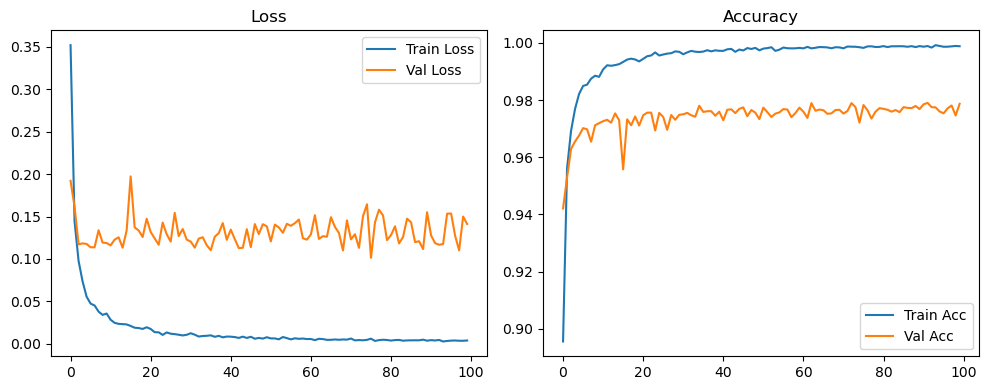

🚀 Running: batch64_lr0.005_0.005_0.005_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4754, Acc: 0.8566 | Val Loss: 0.2517, Acc: 0.9244


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2825, Acc: 0.9139 | Val Loss: 0.1868, Acc: 0.9422


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.2203, Acc: 0.9320 | Val Loss: 0.1544, Acc: 0.9522


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1800, Acc: 0.9456 | Val Loss: 0.1436, Acc: 0.9575


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1491, Acc: 0.9550 | Val Loss: 0.1283, Acc: 0.9617


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1323, Acc: 0.9578 | Val Loss: 0.1232, Acc: 0.9623


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1191, Acc: 0.9629 | Val Loss: 0.1146, Acc: 0.9650


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.1025, Acc: 0.9676 | Val Loss: 0.1095, Acc: 0.9653


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0914, Acc: 0.9705 | Val Loss: 0.1086, Acc: 0.9681


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0871, Acc: 0.9715 | Val Loss: 0.0945, Acc: 0.9722


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0781, Acc: 0.9747 | Val Loss: 0.1043, Acc: 0.9712


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0724, Acc: 0.9767 | Val Loss: 0.1067, Acc: 0.9713


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0720, Acc: 0.9767 | Val Loss: 0.1013, Acc: 0.9711


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0635, Acc: 0.9794 | Val Loss: 0.0980, Acc: 0.9737


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0604, Acc: 0.9800 | Val Loss: 0.1018, Acc: 0.9718


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0569, Acc: 0.9814 | Val Loss: 0.0994, Acc: 0.9730


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0541, Acc: 0.9817 | Val Loss: 0.1028, Acc: 0.9730


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0535, Acc: 0.9826 | Val Loss: 0.0943, Acc: 0.9732


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0500, Acc: 0.9833 | Val Loss: 0.1026, Acc: 0.9739


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0478, Acc: 0.9835 | Val Loss: 0.0966, Acc: 0.9733


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0480, Acc: 0.9839 | Val Loss: 0.0950, Acc: 0.9743


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0433, Acc: 0.9850 | Val Loss: 0.0908, Acc: 0.9740


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0411, Acc: 0.9861 | Val Loss: 0.0946, Acc: 0.9742


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0417, Acc: 0.9856 | Val Loss: 0.0966, Acc: 0.9738


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0381, Acc: 0.9881 | Val Loss: 0.0933, Acc: 0.9754


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0375, Acc: 0.9878 | Val Loss: 0.0968, Acc: 0.9737


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0380, Acc: 0.9876 | Val Loss: 0.0916, Acc: 0.9755


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0326, Acc: 0.9889 | Val Loss: 0.0966, Acc: 0.9762


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0358, Acc: 0.9881 | Val Loss: 0.0923, Acc: 0.9749


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0358, Acc: 0.9879 | Val Loss: 0.0896, Acc: 0.9763


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0318, Acc: 0.9893 | Val Loss: 0.0902, Acc: 0.9749


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0319, Acc: 0.9893 | Val Loss: 0.0912, Acc: 0.9760


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0333, Acc: 0.9889 | Val Loss: 0.1003, Acc: 0.9753


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0306, Acc: 0.9900 | Val Loss: 0.1070, Acc: 0.9753


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0284, Acc: 0.9901 | Val Loss: 0.1043, Acc: 0.9752


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0295, Acc: 0.9903 | Val Loss: 0.1115, Acc: 0.9755


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0283, Acc: 0.9904 | Val Loss: 0.1084, Acc: 0.9750


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0284, Acc: 0.9900 | Val Loss: 0.1031, Acc: 0.9755


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0262, Acc: 0.9909 | Val Loss: 0.1035, Acc: 0.9756


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0280, Acc: 0.9910 | Val Loss: 0.0857, Acc: 0.9768


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0263, Acc: 0.9911 | Val Loss: 0.0947, Acc: 0.9778


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0237, Acc: 0.9920 | Val Loss: 0.1018, Acc: 0.9760


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0258, Acc: 0.9914 | Val Loss: 0.0957, Acc: 0.9768


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0261, Acc: 0.9913 | Val Loss: 0.0935, Acc: 0.9773


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0235, Acc: 0.9919 | Val Loss: 0.1037, Acc: 0.9768


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0247, Acc: 0.9919 | Val Loss: 0.0925, Acc: 0.9781


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0221, Acc: 0.9922 | Val Loss: 0.1048, Acc: 0.9772


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0244, Acc: 0.9916 | Val Loss: 0.0952, Acc: 0.9765


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0227, Acc: 0.9924 | Val Loss: 0.1039, Acc: 0.9758


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0221, Acc: 0.9928 | Val Loss: 0.1069, Acc: 0.9758


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0241, Acc: 0.9926 | Val Loss: 0.0991, Acc: 0.9758


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0203, Acc: 0.9936 | Val Loss: 0.0959, Acc: 0.9752


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0211, Acc: 0.9926 | Val Loss: 0.1069, Acc: 0.9758


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0225, Acc: 0.9926 | Val Loss: 0.0981, Acc: 0.9769


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0227, Acc: 0.9928 | Val Loss: 0.1039, Acc: 0.9775


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0208, Acc: 0.9929 | Val Loss: 0.0955, Acc: 0.9759


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0202, Acc: 0.9930 | Val Loss: 0.0981, Acc: 0.9765


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0191, Acc: 0.9936 | Val Loss: 0.0945, Acc: 0.9769


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0191, Acc: 0.9933 | Val Loss: 0.1185, Acc: 0.9768


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0194, Acc: 0.9932 | Val Loss: 0.0988, Acc: 0.9762


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0190, Acc: 0.9940 | Val Loss: 0.1054, Acc: 0.9767


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0176, Acc: 0.9942 | Val Loss: 0.0969, Acc: 0.9761


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0184, Acc: 0.9940 | Val Loss: 0.0990, Acc: 0.9775


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0189, Acc: 0.9934 | Val Loss: 0.1019, Acc: 0.9771


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0196, Acc: 0.9941 | Val Loss: 0.0986, Acc: 0.9768


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0176, Acc: 0.9941 | Val Loss: 0.1031, Acc: 0.9767


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0177, Acc: 0.9944 | Val Loss: 0.1042, Acc: 0.9768


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0181, Acc: 0.9944 | Val Loss: 0.0917, Acc: 0.9775


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0194, Acc: 0.9938 | Val Loss: 0.1026, Acc: 0.9775


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0180, Acc: 0.9942 | Val Loss: 0.0999, Acc: 0.9762


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0176, Acc: 0.9942 | Val Loss: 0.1138, Acc: 0.9772


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0170, Acc: 0.9944 | Val Loss: 0.0943, Acc: 0.9768


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0159, Acc: 0.9946 | Val Loss: 0.1108, Acc: 0.9772


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0162, Acc: 0.9948 | Val Loss: 0.1156, Acc: 0.9762


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0164, Acc: 0.9949 | Val Loss: 0.1176, Acc: 0.9768


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0168, Acc: 0.9945 | Val Loss: 0.0936, Acc: 0.9778


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0153, Acc: 0.9948 | Val Loss: 0.1094, Acc: 0.9780


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0160, Acc: 0.9949 | Val Loss: 0.1144, Acc: 0.9767


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0183, Acc: 0.9940 | Val Loss: 0.1084, Acc: 0.9765


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0144, Acc: 0.9951 | Val Loss: 0.1176, Acc: 0.9774


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9950 | Val Loss: 0.1197, Acc: 0.9764


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0156, Acc: 0.9949 | Val Loss: 0.1199, Acc: 0.9757


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9945 | Val Loss: 0.1042, Acc: 0.9775


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0143, Acc: 0.9949 | Val Loss: 0.1054, Acc: 0.9773


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0143, Acc: 0.9952 | Val Loss: 0.1085, Acc: 0.9768


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0146, Acc: 0.9949 | Val Loss: 0.1198, Acc: 0.9778


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0156, Acc: 0.9947 | Val Loss: 0.1130, Acc: 0.9765


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0148, Acc: 0.9950 | Val Loss: 0.1090, Acc: 0.9773


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9947 | Val Loss: 0.1040, Acc: 0.9773


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0143, Acc: 0.9953 | Val Loss: 0.0985, Acc: 0.9782


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0139, Acc: 0.9954 | Val Loss: 0.1056, Acc: 0.9777


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9959 | Val Loss: 0.0984, Acc: 0.9771


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9955 | Val Loss: 0.0973, Acc: 0.9778


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0146, Acc: 0.9955 | Val Loss: 0.1147, Acc: 0.9772


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9958 | Val Loss: 0.0994, Acc: 0.9774


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0152, Acc: 0.9953 | Val Loss: 0.0910, Acc: 0.9797


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9955 | Val Loss: 0.1060, Acc: 0.9780


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9955 | Val Loss: 0.1203, Acc: 0.9773


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9957 | Val Loss: 0.1049, Acc: 0.9788


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0138, Acc: 0.9955 | Val Loss: 0.1163, Acc: 0.9790


Final Test Loss: 0.0843 Accuracy: 0.9828


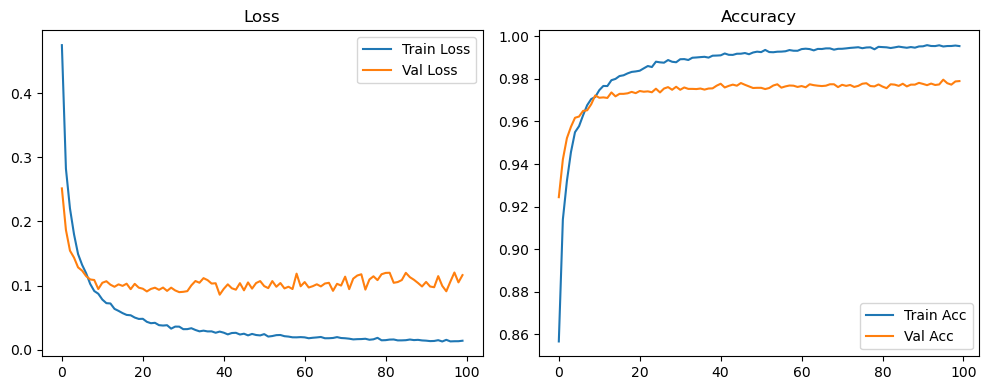

🚀 Running: batch64_lr0.005_0.005_0.005_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.7112, Acc: 0.7748 | Val Loss: 0.3188, Acc: 0.9058


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.4387, Acc: 0.8675 | Val Loss: 0.2415, Acc: 0.9279


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.3592, Acc: 0.8924 | Val Loss: 0.2127, Acc: 0.9353


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.3072, Acc: 0.9094 | Val Loss: 0.1803, Acc: 0.9447


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.2730, Acc: 0.9187 | Val Loss: 0.1520, Acc: 0.9544


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.2465, Acc: 0.9258 | Val Loss: 0.1477, Acc: 0.9544


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.2215, Acc: 0.9342 | Val Loss: 0.1357, Acc: 0.9605


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.2102, Acc: 0.9360 | Val Loss: 0.1269, Acc: 0.9606


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.1974, Acc: 0.9395 | Val Loss: 0.1214, Acc: 0.9640


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.1876, Acc: 0.9424 | Val Loss: 0.1153, Acc: 0.9667


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.1800, Acc: 0.9451 | Val Loss: 0.1182, Acc: 0.9653


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.1711, Acc: 0.9474 | Val Loss: 0.1123, Acc: 0.9687


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.1642, Acc: 0.9507 | Val Loss: 0.1079, Acc: 0.9688


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.1572, Acc: 0.9523 | Val Loss: 0.1095, Acc: 0.9688


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.1517, Acc: 0.9534 | Val Loss: 0.1037, Acc: 0.9692


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.1460, Acc: 0.9561 | Val Loss: 0.1014, Acc: 0.9707


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.1422, Acc: 0.9561 | Val Loss: 0.1064, Acc: 0.9712


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.1386, Acc: 0.9573 | Val Loss: 0.1005, Acc: 0.9722


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.1294, Acc: 0.9602 | Val Loss: 0.0996, Acc: 0.9728


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.1333, Acc: 0.9590 | Val Loss: 0.0983, Acc: 0.9709


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.1307, Acc: 0.9598 | Val Loss: 0.0963, Acc: 0.9731


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.1217, Acc: 0.9625 | Val Loss: 0.0901, Acc: 0.9734


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.1190, Acc: 0.9640 | Val Loss: 0.0954, Acc: 0.9731


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.1158, Acc: 0.9635 | Val Loss: 0.0976, Acc: 0.9725


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.1155, Acc: 0.9644 | Val Loss: 0.0930, Acc: 0.9742


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.1079, Acc: 0.9656 | Val Loss: 0.0941, Acc: 0.9745


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.1135, Acc: 0.9645 | Val Loss: 0.0930, Acc: 0.9736


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.1069, Acc: 0.9664 | Val Loss: 0.0925, Acc: 0.9739


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.1029, Acc: 0.9679 | Val Loss: 0.0898, Acc: 0.9742


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.1034, Acc: 0.9676 | Val Loss: 0.0894, Acc: 0.9749


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.1013, Acc: 0.9688 | Val Loss: 0.0879, Acc: 0.9748


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0988, Acc: 0.9695 | Val Loss: 0.0912, Acc: 0.9741


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.1008, Acc: 0.9681 | Val Loss: 0.0904, Acc: 0.9743


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0938, Acc: 0.9697 | Val Loss: 0.0906, Acc: 0.9732


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0958, Acc: 0.9695 | Val Loss: 0.0903, Acc: 0.9745


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0972, Acc: 0.9698 | Val Loss: 0.0869, Acc: 0.9756


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0916, Acc: 0.9710 | Val Loss: 0.0903, Acc: 0.9752


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0907, Acc: 0.9716 | Val Loss: 0.0991, Acc: 0.9742


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0890, Acc: 0.9711 | Val Loss: 0.0962, Acc: 0.9739


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0869, Acc: 0.9725 | Val Loss: 0.0870, Acc: 0.9752


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0871, Acc: 0.9726 | Val Loss: 0.0904, Acc: 0.9762


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0821, Acc: 0.9736 | Val Loss: 0.0902, Acc: 0.9761


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0840, Acc: 0.9737 | Val Loss: 0.0966, Acc: 0.9750


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0833, Acc: 0.9741 | Val Loss: 0.0924, Acc: 0.9755


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0840, Acc: 0.9745 | Val Loss: 0.0940, Acc: 0.9760


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0832, Acc: 0.9733 | Val Loss: 0.0876, Acc: 0.9758


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0780, Acc: 0.9756 | Val Loss: 0.0913, Acc: 0.9765


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0791, Acc: 0.9759 | Val Loss: 0.0962, Acc: 0.9760


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0798, Acc: 0.9748 | Val Loss: 0.0864, Acc: 0.9773


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0804, Acc: 0.9754 | Val Loss: 0.0860, Acc: 0.9771


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0772, Acc: 0.9755 | Val Loss: 0.0894, Acc: 0.9758


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0777, Acc: 0.9762 | Val Loss: 0.0943, Acc: 0.9770


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0759, Acc: 0.9759 | Val Loss: 0.0877, Acc: 0.9767


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0792, Acc: 0.9747 | Val Loss: 0.0860, Acc: 0.9761


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0764, Acc: 0.9760 | Val Loss: 0.0948, Acc: 0.9764


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0746, Acc: 0.9770 | Val Loss: 0.0883, Acc: 0.9766


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0712, Acc: 0.9771 | Val Loss: 0.0863, Acc: 0.9773


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0712, Acc: 0.9768 | Val Loss: 0.0872, Acc: 0.9759


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0712, Acc: 0.9774 | Val Loss: 0.0954, Acc: 0.9768


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0696, Acc: 0.9780 | Val Loss: 0.0858, Acc: 0.9772


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0684, Acc: 0.9781 | Val Loss: 0.1030, Acc: 0.9758


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0700, Acc: 0.9788 | Val Loss: 0.0884, Acc: 0.9766


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0675, Acc: 0.9786 | Val Loss: 0.0869, Acc: 0.9758


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0689, Acc: 0.9785 | Val Loss: 0.0875, Acc: 0.9757


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0655, Acc: 0.9789 | Val Loss: 0.0912, Acc: 0.9768


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0665, Acc: 0.9788 | Val Loss: 0.0886, Acc: 0.9778


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0631, Acc: 0.9803 | Val Loss: 0.0973, Acc: 0.9760


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0650, Acc: 0.9798 | Val Loss: 0.0859, Acc: 0.9773


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0666, Acc: 0.9781 | Val Loss: 0.0864, Acc: 0.9778


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0662, Acc: 0.9794 | Val Loss: 0.0919, Acc: 0.9773


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0652, Acc: 0.9794 | Val Loss: 0.0899, Acc: 0.9773


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0643, Acc: 0.9798 | Val Loss: 0.0958, Acc: 0.9752


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0605, Acc: 0.9801 | Val Loss: 0.1015, Acc: 0.9765


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0658, Acc: 0.9798 | Val Loss: 0.0928, Acc: 0.9774


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0592, Acc: 0.9809 | Val Loss: 0.0905, Acc: 0.9777


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0638, Acc: 0.9801 | Val Loss: 0.0860, Acc: 0.9772


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0598, Acc: 0.9802 | Val Loss: 0.0916, Acc: 0.9771


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0615, Acc: 0.9806 | Val Loss: 0.0912, Acc: 0.9778


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0604, Acc: 0.9812 | Val Loss: 0.0905, Acc: 0.9773


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0585, Acc: 0.9811 | Val Loss: 0.0908, Acc: 0.9778


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0595, Acc: 0.9812 | Val Loss: 0.0920, Acc: 0.9774


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0586, Acc: 0.9814 | Val Loss: 0.0865, Acc: 0.9772


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0570, Acc: 0.9811 | Val Loss: 0.0961, Acc: 0.9779


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0578, Acc: 0.9816 | Val Loss: 0.0817, Acc: 0.9778


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0587, Acc: 0.9816 | Val Loss: 0.0994, Acc: 0.9752


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0567, Acc: 0.9825 | Val Loss: 0.0927, Acc: 0.9763


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0576, Acc: 0.9816 | Val Loss: 0.0963, Acc: 0.9757


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0565, Acc: 0.9819 | Val Loss: 0.0879, Acc: 0.9763


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0522, Acc: 0.9835 | Val Loss: 0.0958, Acc: 0.9766


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0548, Acc: 0.9831 | Val Loss: 0.0919, Acc: 0.9765


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0558, Acc: 0.9821 | Val Loss: 0.0949, Acc: 0.9762


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0589, Acc: 0.9814 | Val Loss: 0.0900, Acc: 0.9770


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0520, Acc: 0.9834 | Val Loss: 0.0982, Acc: 0.9768


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0562, Acc: 0.9814 | Val Loss: 0.0890, Acc: 0.9774


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0541, Acc: 0.9826 | Val Loss: 0.0976, Acc: 0.9772


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0570, Acc: 0.9816 | Val Loss: 0.0891, Acc: 0.9773


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0510, Acc: 0.9835 | Val Loss: 0.0874, Acc: 0.9762


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0527, Acc: 0.9832 | Val Loss: 0.0918, Acc: 0.9762


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0539, Acc: 0.9832 | Val Loss: 0.0965, Acc: 0.9770


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0522, Acc: 0.9836 | Val Loss: 0.0903, Acc: 0.9762


Final Test Loss: 0.0811 Accuracy: 0.9792


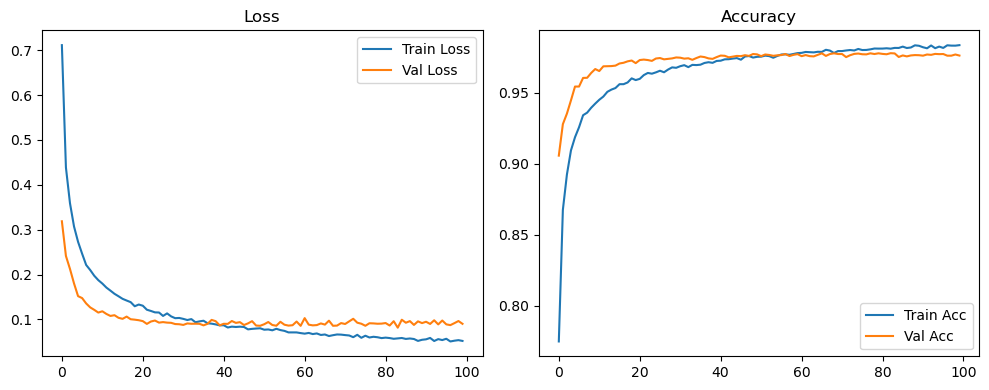

🚀 Running: batch64_lr0.005_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.3521, Acc: 0.8956 | Val Loss: 0.1921, Acc: 0.9421


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1443, Acc: 0.9561 | Val Loss: 0.1616, Acc: 0.9528


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0978, Acc: 0.9693 | Val Loss: 0.1172, Acc: 0.9629


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0736, Acc: 0.9769 | Val Loss: 0.1183, Acc: 0.9655


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0555, Acc: 0.9821 | Val Loss: 0.1177, Acc: 0.9676


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0473, Acc: 0.9849 | Val Loss: 0.1137, Acc: 0.9702


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0451, Acc: 0.9854 | Val Loss: 0.1137, Acc: 0.9698


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0378, Acc: 0.9875 | Val Loss: 0.1338, Acc: 0.9654


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0340, Acc: 0.9885 | Val Loss: 0.1192, Acc: 0.9712


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0356, Acc: 0.9881 | Val Loss: 0.1188, Acc: 0.9719


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0283, Acc: 0.9907 | Val Loss: 0.1160, Acc: 0.9726


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0247, Acc: 0.9921 | Val Loss: 0.1227, Acc: 0.9731


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0234, Acc: 0.9920 | Val Loss: 0.1255, Acc: 0.9721


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0231, Acc: 0.9922 | Val Loss: 0.1133, Acc: 0.9753


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0228, Acc: 0.9925 | Val Loss: 0.1334, Acc: 0.9729


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0210, Acc: 0.9933 | Val Loss: 0.1973, Acc: 0.9557


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0189, Acc: 0.9941 | Val Loss: 0.1372, Acc: 0.9732


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0185, Acc: 0.9945 | Val Loss: 0.1336, Acc: 0.9712


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0174, Acc: 0.9942 | Val Loss: 0.1259, Acc: 0.9742


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0194, Acc: 0.9935 | Val Loss: 0.1474, Acc: 0.9711


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0174, Acc: 0.9944 | Val Loss: 0.1318, Acc: 0.9747


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9953 | Val Loss: 0.1243, Acc: 0.9756


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9956 | Val Loss: 0.1167, Acc: 0.9756


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9966 | Val Loss: 0.1429, Acc: 0.9693


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9956 | Val Loss: 0.1292, Acc: 0.9755


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9959 | Val Loss: 0.1205, Acc: 0.9741


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9962 | Val Loss: 0.1543, Acc: 0.9696


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9964 | Val Loss: 0.1269, Acc: 0.9748


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9970 | Val Loss: 0.1353, Acc: 0.9731


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9969 | Val Loss: 0.1228, Acc: 0.9748


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9960 | Val Loss: 0.1205, Acc: 0.9750


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9967 | Val Loss: 0.1133, Acc: 0.9755


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.1240, Acc: 0.9747


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9969 | Val Loss: 0.1256, Acc: 0.9742


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9968 | Val Loss: 0.1161, Acc: 0.9780


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9969 | Val Loss: 0.1103, Acc: 0.9758


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.1262, Acc: 0.9761


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.1304, Acc: 0.9761


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.1423, Acc: 0.9745


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.1226, Acc: 0.9759


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9972 | Val Loss: 0.1345, Acc: 0.9729


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9977 | Val Loss: 0.1233, Acc: 0.9766


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.1127, Acc: 0.9768


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9969 | Val Loss: 0.1132, Acc: 0.9754


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.1351, Acc: 0.9769


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9973 | Val Loss: 0.1139, Acc: 0.9774


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1411, Acc: 0.9743


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.1292, Acc: 0.9765


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.1410, Acc: 0.9756


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.1384, Acc: 0.9733


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.1157, Acc: 0.9796


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1327, Acc: 0.9795


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1286, Acc: 0.9795


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1295, Acc: 0.9787


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1321, Acc: 0.9798


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1285, Acc: 0.9801


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1410, Acc: 0.9793


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1463, Acc: 0.9781


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1318, Acc: 0.9787


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1290, Acc: 0.9786


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1446, Acc: 0.9780


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1224, Acc: 0.9788


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1380, Acc: 0.9778


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1273, Acc: 0.9795


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1445, Acc: 0.9789


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1255, Acc: 0.9802


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1287, Acc: 0.9812


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1435, Acc: 0.9791


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1450, Acc: 0.9805


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1477, Acc: 0.9800


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1328, Acc: 0.9792


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1347, Acc: 0.9798


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.1269, Acc: 0.9801


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.1315, Acc: 0.9797


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1349, Acc: 0.9788


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.1277, Acc: 0.9792


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1272, Acc: 0.9795


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1468, Acc: 0.9797


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1565, Acc: 0.9798


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1489, Acc: 0.9796


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1452, Acc: 0.9798


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1402, Acc: 0.9801


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1420, Acc: 0.9798


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1377, Acc: 0.9805


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1460, Acc: 0.9796


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1452, Acc: 0.9802


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1465, Acc: 0.9810


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1421, Acc: 0.9809


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1496, Acc: 0.9802


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1447, Acc: 0.9803


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1650, Acc: 0.9794


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1639, Acc: 0.9802


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1625, Acc: 0.9788


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1501, Acc: 0.9802


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.1470, Acc: 0.9798


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1461, Acc: 0.9802


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1407, Acc: 0.9793


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1391, Acc: 0.9794


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1382, Acc: 0.9796


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1474, Acc: 0.9803


Final Test Loss: 0.1312 Accuracy: 0.9829


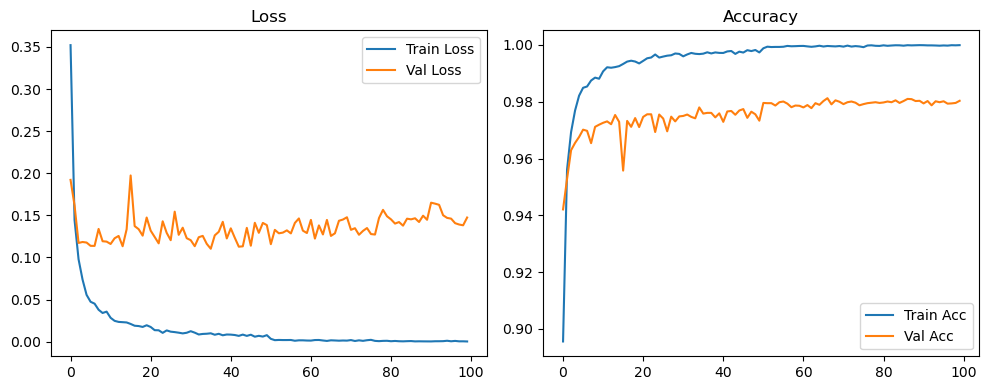

🚀 Running: batch64_lr0.005_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4754, Acc: 0.8566 | Val Loss: 0.2517, Acc: 0.9244


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2825, Acc: 0.9139 | Val Loss: 0.1868, Acc: 0.9422


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.2203, Acc: 0.9320 | Val Loss: 0.1544, Acc: 0.9522


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1800, Acc: 0.9456 | Val Loss: 0.1436, Acc: 0.9575


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1491, Acc: 0.9550 | Val Loss: 0.1283, Acc: 0.9617


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1323, Acc: 0.9578 | Val Loss: 0.1232, Acc: 0.9623


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1191, Acc: 0.9629 | Val Loss: 0.1146, Acc: 0.9650


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.1025, Acc: 0.9676 | Val Loss: 0.1095, Acc: 0.9653


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0914, Acc: 0.9705 | Val Loss: 0.1086, Acc: 0.9681


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0871, Acc: 0.9715 | Val Loss: 0.0945, Acc: 0.9722


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0781, Acc: 0.9747 | Val Loss: 0.1043, Acc: 0.9712


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0724, Acc: 0.9767 | Val Loss: 0.1067, Acc: 0.9713


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0720, Acc: 0.9767 | Val Loss: 0.1013, Acc: 0.9711


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0635, Acc: 0.9794 | Val Loss: 0.0980, Acc: 0.9737


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0604, Acc: 0.9800 | Val Loss: 0.1018, Acc: 0.9718


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0569, Acc: 0.9814 | Val Loss: 0.0994, Acc: 0.9730


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0541, Acc: 0.9817 | Val Loss: 0.1028, Acc: 0.9730


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0535, Acc: 0.9826 | Val Loss: 0.0943, Acc: 0.9732


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0500, Acc: 0.9833 | Val Loss: 0.1026, Acc: 0.9739


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0478, Acc: 0.9835 | Val Loss: 0.0966, Acc: 0.9733


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0480, Acc: 0.9839 | Val Loss: 0.0950, Acc: 0.9743


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0433, Acc: 0.9850 | Val Loss: 0.0908, Acc: 0.9740


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0411, Acc: 0.9861 | Val Loss: 0.0946, Acc: 0.9742


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0417, Acc: 0.9856 | Val Loss: 0.0966, Acc: 0.9738


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0381, Acc: 0.9881 | Val Loss: 0.0933, Acc: 0.9754


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0375, Acc: 0.9878 | Val Loss: 0.0968, Acc: 0.9737


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0380, Acc: 0.9876 | Val Loss: 0.0916, Acc: 0.9755


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0326, Acc: 0.9889 | Val Loss: 0.0966, Acc: 0.9762


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0358, Acc: 0.9881 | Val Loss: 0.0923, Acc: 0.9749


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0358, Acc: 0.9879 | Val Loss: 0.0896, Acc: 0.9763


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0318, Acc: 0.9893 | Val Loss: 0.0902, Acc: 0.9749


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0319, Acc: 0.9893 | Val Loss: 0.0912, Acc: 0.9760


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0333, Acc: 0.9889 | Val Loss: 0.1003, Acc: 0.9753


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0306, Acc: 0.9900 | Val Loss: 0.1070, Acc: 0.9753


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0284, Acc: 0.9901 | Val Loss: 0.1043, Acc: 0.9752


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0295, Acc: 0.9903 | Val Loss: 0.1115, Acc: 0.9755


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0283, Acc: 0.9904 | Val Loss: 0.1084, Acc: 0.9750


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0284, Acc: 0.9900 | Val Loss: 0.1031, Acc: 0.9755


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0262, Acc: 0.9909 | Val Loss: 0.1035, Acc: 0.9756


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0280, Acc: 0.9910 | Val Loss: 0.0857, Acc: 0.9768


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0263, Acc: 0.9911 | Val Loss: 0.0947, Acc: 0.9778


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0237, Acc: 0.9920 | Val Loss: 0.1018, Acc: 0.9760


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0258, Acc: 0.9914 | Val Loss: 0.0957, Acc: 0.9768


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0261, Acc: 0.9913 | Val Loss: 0.0935, Acc: 0.9773


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0235, Acc: 0.9919 | Val Loss: 0.1037, Acc: 0.9768


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0247, Acc: 0.9919 | Val Loss: 0.0925, Acc: 0.9781


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0221, Acc: 0.9922 | Val Loss: 0.1048, Acc: 0.9772


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0244, Acc: 0.9916 | Val Loss: 0.0952, Acc: 0.9765


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0227, Acc: 0.9924 | Val Loss: 0.1039, Acc: 0.9758


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0221, Acc: 0.9928 | Val Loss: 0.1069, Acc: 0.9758


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0191, Acc: 0.9938 | Val Loss: 0.0983, Acc: 0.9773


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0140, Acc: 0.9950 | Val Loss: 0.1049, Acc: 0.9761


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0127, Acc: 0.9956 | Val Loss: 0.1143, Acc: 0.9771


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0133, Acc: 0.9957 | Val Loss: 0.1106, Acc: 0.9762


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0140, Acc: 0.9956 | Val Loss: 0.0993, Acc: 0.9781


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0121, Acc: 0.9960 | Val Loss: 0.1063, Acc: 0.9768


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0112, Acc: 0.9960 | Val Loss: 0.1118, Acc: 0.9770


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9962 | Val Loss: 0.1096, Acc: 0.9768


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9964 | Val Loss: 0.1135, Acc: 0.9772


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9967 | Val Loss: 0.1217, Acc: 0.9762


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0112, Acc: 0.9962 | Val Loss: 0.1079, Acc: 0.9770


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9968 | Val Loss: 0.1079, Acc: 0.9778


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9969 | Val Loss: 0.1106, Acc: 0.9778


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9966 | Val Loss: 0.1180, Acc: 0.9772


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0100, Acc: 0.9970 | Val Loss: 0.1162, Acc: 0.9767


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0105, Acc: 0.9967 | Val Loss: 0.1118, Acc: 0.9779


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9971 | Val Loss: 0.1244, Acc: 0.9777


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0101, Acc: 0.9968 | Val Loss: 0.1113, Acc: 0.9773


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9971 | Val Loss: 0.1136, Acc: 0.9775


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9968 | Val Loss: 0.1113, Acc: 0.9773


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.1244, Acc: 0.9770


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0100, Acc: 0.9969 | Val Loss: 0.1105, Acc: 0.9779


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.1096, Acc: 0.9776


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9973 | Val Loss: 0.1162, Acc: 0.9770


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9969 | Val Loss: 0.1169, Acc: 0.9780


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9969 | Val Loss: 0.1068, Acc: 0.9776


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.1187, Acc: 0.9771


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9971 | Val Loss: 0.1173, Acc: 0.9766


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9965 | Val Loss: 0.1149, Acc: 0.9776


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.1195, Acc: 0.9783


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.1187, Acc: 0.9781


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9974 | Val Loss: 0.1086, Acc: 0.9788


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9978 | Val Loss: 0.1123, Acc: 0.9786


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9979 | Val Loss: 0.1154, Acc: 0.9790


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9979 | Val Loss: 0.1250, Acc: 0.9783


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.1234, Acc: 0.9775


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9978 | Val Loss: 0.1233, Acc: 0.9775


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.1210, Acc: 0.9778


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.1292, Acc: 0.9774


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.1152, Acc: 0.9781


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9981 | Val Loss: 0.1266, Acc: 0.9782


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.1205, Acc: 0.9777


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9977 | Val Loss: 0.1209, Acc: 0.9780


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9982 | Val Loss: 0.1312, Acc: 0.9787


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.1241, Acc: 0.9782


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.1167, Acc: 0.9785


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1261, Acc: 0.9779


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9981 | Val Loss: 0.1199, Acc: 0.9783


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.1235, Acc: 0.9799


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1237, Acc: 0.9798


Final Test Loss: 0.1144 Accuracy: 0.9814


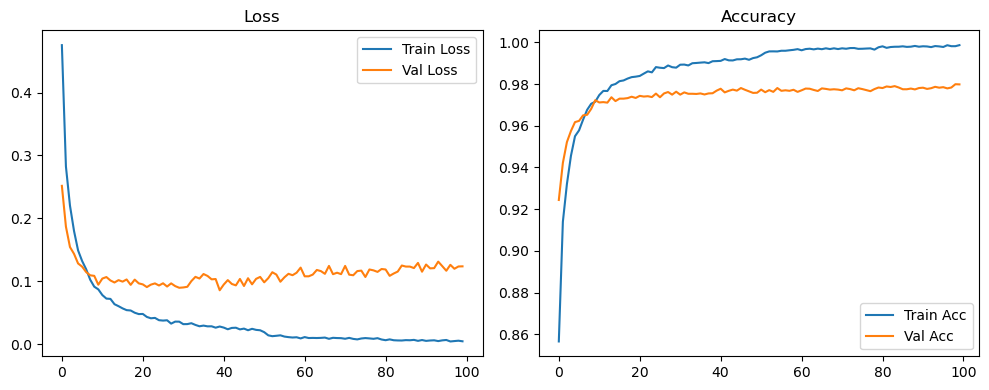

🚀 Running: batch64_lr0.005_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.7112, Acc: 0.7748 | Val Loss: 0.3188, Acc: 0.9058


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.4387, Acc: 0.8675 | Val Loss: 0.2415, Acc: 0.9279


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.3592, Acc: 0.8924 | Val Loss: 0.2127, Acc: 0.9353


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.3072, Acc: 0.9094 | Val Loss: 0.1803, Acc: 0.9447


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.2730, Acc: 0.9187 | Val Loss: 0.1520, Acc: 0.9544


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.2465, Acc: 0.9258 | Val Loss: 0.1477, Acc: 0.9544


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.2215, Acc: 0.9342 | Val Loss: 0.1357, Acc: 0.9605


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.2102, Acc: 0.9360 | Val Loss: 0.1269, Acc: 0.9606


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.1974, Acc: 0.9395 | Val Loss: 0.1214, Acc: 0.9640


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.1876, Acc: 0.9424 | Val Loss: 0.1153, Acc: 0.9667


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.1800, Acc: 0.9451 | Val Loss: 0.1182, Acc: 0.9653


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.1711, Acc: 0.9474 | Val Loss: 0.1123, Acc: 0.9687


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.1642, Acc: 0.9507 | Val Loss: 0.1079, Acc: 0.9688


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.1572, Acc: 0.9523 | Val Loss: 0.1095, Acc: 0.9688


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.1517, Acc: 0.9534 | Val Loss: 0.1037, Acc: 0.9692


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.1460, Acc: 0.9561 | Val Loss: 0.1014, Acc: 0.9707


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.1422, Acc: 0.9561 | Val Loss: 0.1064, Acc: 0.9712


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.1386, Acc: 0.9573 | Val Loss: 0.1005, Acc: 0.9722


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.1294, Acc: 0.9602 | Val Loss: 0.0996, Acc: 0.9728


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.1333, Acc: 0.9590 | Val Loss: 0.0983, Acc: 0.9709


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.1307, Acc: 0.9598 | Val Loss: 0.0963, Acc: 0.9731


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.1217, Acc: 0.9625 | Val Loss: 0.0901, Acc: 0.9734


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.1190, Acc: 0.9640 | Val Loss: 0.0954, Acc: 0.9731


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.1158, Acc: 0.9635 | Val Loss: 0.0976, Acc: 0.9725


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.1155, Acc: 0.9644 | Val Loss: 0.0930, Acc: 0.9742


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.1079, Acc: 0.9656 | Val Loss: 0.0941, Acc: 0.9745


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.1135, Acc: 0.9645 | Val Loss: 0.0930, Acc: 0.9736


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.1069, Acc: 0.9664 | Val Loss: 0.0925, Acc: 0.9739


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.1029, Acc: 0.9679 | Val Loss: 0.0898, Acc: 0.9742


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.1034, Acc: 0.9676 | Val Loss: 0.0894, Acc: 0.9749


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.1013, Acc: 0.9688 | Val Loss: 0.0879, Acc: 0.9748


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0988, Acc: 0.9695 | Val Loss: 0.0912, Acc: 0.9741


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.1008, Acc: 0.9681 | Val Loss: 0.0904, Acc: 0.9743


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0938, Acc: 0.9697 | Val Loss: 0.0906, Acc: 0.9732


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0958, Acc: 0.9695 | Val Loss: 0.0903, Acc: 0.9745


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0972, Acc: 0.9698 | Val Loss: 0.0869, Acc: 0.9756


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0916, Acc: 0.9710 | Val Loss: 0.0903, Acc: 0.9752


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0907, Acc: 0.9716 | Val Loss: 0.0991, Acc: 0.9742


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0890, Acc: 0.9711 | Val Loss: 0.0962, Acc: 0.9739


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0869, Acc: 0.9725 | Val Loss: 0.0870, Acc: 0.9752


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0871, Acc: 0.9726 | Val Loss: 0.0904, Acc: 0.9762


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0821, Acc: 0.9736 | Val Loss: 0.0902, Acc: 0.9761


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0840, Acc: 0.9737 | Val Loss: 0.0966, Acc: 0.9750


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0833, Acc: 0.9741 | Val Loss: 0.0924, Acc: 0.9755


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0840, Acc: 0.9745 | Val Loss: 0.0940, Acc: 0.9760


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0832, Acc: 0.9733 | Val Loss: 0.0876, Acc: 0.9758


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0780, Acc: 0.9756 | Val Loss: 0.0913, Acc: 0.9765


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0791, Acc: 0.9759 | Val Loss: 0.0962, Acc: 0.9760


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0798, Acc: 0.9748 | Val Loss: 0.0864, Acc: 0.9773


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0804, Acc: 0.9754 | Val Loss: 0.0860, Acc: 0.9771


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0704, Acc: 0.9780 | Val Loss: 0.0873, Acc: 0.9762


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0678, Acc: 0.9788 | Val Loss: 0.0899, Acc: 0.9771


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0634, Acc: 0.9794 | Val Loss: 0.0899, Acc: 0.9779


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0658, Acc: 0.9792 | Val Loss: 0.0837, Acc: 0.9771


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0612, Acc: 0.9807 | Val Loss: 0.0911, Acc: 0.9774


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0606, Acc: 0.9815 | Val Loss: 0.0837, Acc: 0.9778


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0584, Acc: 0.9815 | Val Loss: 0.0875, Acc: 0.9779


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0568, Acc: 0.9813 | Val Loss: 0.0881, Acc: 0.9780


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0561, Acc: 0.9818 | Val Loss: 0.0916, Acc: 0.9778


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0559, Acc: 0.9821 | Val Loss: 0.0855, Acc: 0.9782


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0546, Acc: 0.9824 | Val Loss: 0.0935, Acc: 0.9773


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0550, Acc: 0.9826 | Val Loss: 0.0938, Acc: 0.9768


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0540, Acc: 0.9829 | Val Loss: 0.0873, Acc: 0.9772


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0540, Acc: 0.9832 | Val Loss: 0.0935, Acc: 0.9767


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0513, Acc: 0.9826 | Val Loss: 0.0912, Acc: 0.9782


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0530, Acc: 0.9834 | Val Loss: 0.0891, Acc: 0.9780


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0492, Acc: 0.9841 | Val Loss: 0.0898, Acc: 0.9782


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0513, Acc: 0.9833 | Val Loss: 0.0852, Acc: 0.9779


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0521, Acc: 0.9834 | Val Loss: 0.0892, Acc: 0.9783


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0521, Acc: 0.9839 | Val Loss: 0.0889, Acc: 0.9783


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0530, Acc: 0.9830 | Val Loss: 0.0890, Acc: 0.9790


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0525, Acc: 0.9836 | Val Loss: 0.0952, Acc: 0.9777


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0468, Acc: 0.9842 | Val Loss: 0.0938, Acc: 0.9778


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0531, Acc: 0.9835 | Val Loss: 0.0902, Acc: 0.9788


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0462, Acc: 0.9849 | Val Loss: 0.0932, Acc: 0.9785


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0505, Acc: 0.9838 | Val Loss: 0.0878, Acc: 0.9792


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0492, Acc: 0.9838 | Val Loss: 0.0902, Acc: 0.9788


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0495, Acc: 0.9842 | Val Loss: 0.0939, Acc: 0.9779


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0481, Acc: 0.9850 | Val Loss: 0.0914, Acc: 0.9784


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0460, Acc: 0.9854 | Val Loss: 0.0877, Acc: 0.9790


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0454, Acc: 0.9856 | Val Loss: 0.0895, Acc: 0.9784


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0456, Acc: 0.9856 | Val Loss: 0.0914, Acc: 0.9787


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0453, Acc: 0.9857 | Val Loss: 0.0940, Acc: 0.9791


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0440, Acc: 0.9859 | Val Loss: 0.0888, Acc: 0.9785


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0437, Acc: 0.9859 | Val Loss: 0.0970, Acc: 0.9771


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0430, Acc: 0.9867 | Val Loss: 0.0914, Acc: 0.9775


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0431, Acc: 0.9864 | Val Loss: 0.0912, Acc: 0.9785


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0428, Acc: 0.9862 | Val Loss: 0.0934, Acc: 0.9788


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0394, Acc: 0.9871 | Val Loss: 0.0949, Acc: 0.9780


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0395, Acc: 0.9876 | Val Loss: 0.0896, Acc: 0.9782


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0408, Acc: 0.9866 | Val Loss: 0.0926, Acc: 0.9778


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0428, Acc: 0.9859 | Val Loss: 0.0915, Acc: 0.9782


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0398, Acc: 0.9873 | Val Loss: 0.0909, Acc: 0.9789


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0397, Acc: 0.9868 | Val Loss: 0.0949, Acc: 0.9778


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0412, Acc: 0.9866 | Val Loss: 0.0956, Acc: 0.9784


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0434, Acc: 0.9864 | Val Loss: 0.0926, Acc: 0.9784


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0382, Acc: 0.9879 | Val Loss: 0.0944, Acc: 0.9776


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0390, Acc: 0.9873 | Val Loss: 0.0900, Acc: 0.9776


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0387, Acc: 0.9873 | Val Loss: 0.0967, Acc: 0.9783


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0387, Acc: 0.9874 | Val Loss: 0.0947, Acc: 0.9784


Final Test Loss: 0.0892 Accuracy: 0.9782


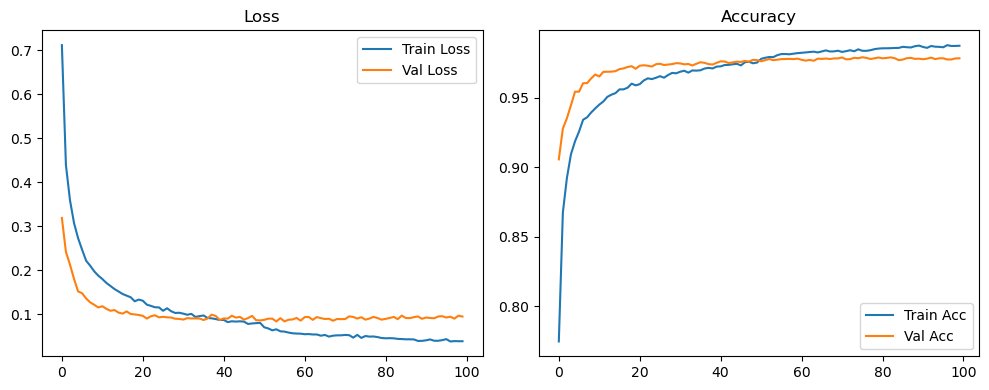

🚀 Running: batch64_lr0.002_0.002_0.002_dp0.0


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.3740, Acc: 0.8974 | Val Loss: 0.1895, Acc: 0.9412


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1329, Acc: 0.9597 | Val Loss: 0.1416, Acc: 0.9553


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0818, Acc: 0.9750 | Val Loss: 0.1186, Acc: 0.9617


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0605, Acc: 0.9803 | Val Loss: 0.1053, Acc: 0.9676


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0430, Acc: 0.9856 | Val Loss: 0.1168, Acc: 0.9663


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0381, Acc: 0.9874 | Val Loss: 0.1084, Acc: 0.9689


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0302, Acc: 0.9901 | Val Loss: 0.0992, Acc: 0.9746


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0264, Acc: 0.9913 | Val Loss: 0.1158, Acc: 0.9686


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0250, Acc: 0.9918 | Val Loss: 0.1276, Acc: 0.9693


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0234, Acc: 0.9918 | Val Loss: 0.1163, Acc: 0.9722


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0220, Acc: 0.9927 | Val Loss: 0.1025, Acc: 0.9748


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0187, Acc: 0.9936 | Val Loss: 0.1340, Acc: 0.9701


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0159, Acc: 0.9945 | Val Loss: 0.1201, Acc: 0.9742


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0194, Acc: 0.9935 | Val Loss: 0.1182, Acc: 0.9732


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0147, Acc: 0.9950 | Val Loss: 0.1494, Acc: 0.9699


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0131, Acc: 0.9956 | Val Loss: 0.1179, Acc: 0.9749


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0155, Acc: 0.9953 | Val Loss: 0.1130, Acc: 0.9736


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0150, Acc: 0.9951 | Val Loss: 0.1392, Acc: 0.9706


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0123, Acc: 0.9961 | Val Loss: 0.1151, Acc: 0.9754


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0125, Acc: 0.9960 | Val Loss: 0.1255, Acc: 0.9728


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0127, Acc: 0.9959 | Val Loss: 0.1527, Acc: 0.9665


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9963 | Val Loss: 0.1208, Acc: 0.9735


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0107, Acc: 0.9967 | Val Loss: 0.1134, Acc: 0.9748


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9961 | Val Loss: 0.1338, Acc: 0.9731


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0125, Acc: 0.9961 | Val Loss: 0.1066, Acc: 0.9763


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.1140, Acc: 0.9771


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9968 | Val Loss: 0.1543, Acc: 0.9708


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9972 | Val Loss: 0.1324, Acc: 0.9737


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.1085, Acc: 0.9757


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9977 | Val Loss: 0.1314, Acc: 0.9744


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9971 | Val Loss: 0.1262, Acc: 0.9742


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.1088, Acc: 0.9768


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.1492, Acc: 0.9728


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9968 | Val Loss: 0.1196, Acc: 0.9775


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.1309, Acc: 0.9768


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9975 | Val Loss: 0.1203, Acc: 0.9774


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9976 | Val Loss: 0.1482, Acc: 0.9708


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.1386, Acc: 0.9751


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.1205, Acc: 0.9759


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.1385, Acc: 0.9743


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.1209, Acc: 0.9766


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1247, Acc: 0.9770


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.1268, Acc: 0.9765


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9974 | Val Loss: 0.1302, Acc: 0.9731


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9982 | Val Loss: 0.1304, Acc: 0.9768


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1245, Acc: 0.9771


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9979 | Val Loss: 0.1186, Acc: 0.9764


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9984 | Val Loss: 0.1339, Acc: 0.9764


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9981 | Val Loss: 0.1106, Acc: 0.9780


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.1244, Acc: 0.9772


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.1197, Acc: 0.9779


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.1446, Acc: 0.9742


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.1226, Acc: 0.9781


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1351, Acc: 0.9776


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1448, Acc: 0.9759


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1195, Acc: 0.9774


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1394, Acc: 0.9770


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9987 | Val Loss: 0.1279, Acc: 0.9758


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1279, Acc: 0.9775


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1307, Acc: 0.9765


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1600, Acc: 0.9748


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.1206, Acc: 0.9777


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1139, Acc: 0.9784


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1273, Acc: 0.9786


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1545, Acc: 0.9764


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1430, Acc: 0.9771


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1442, Acc: 0.9755


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1504, Acc: 0.9751


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1248, Acc: 0.9777


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1307, Acc: 0.9792


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1350, Acc: 0.9768


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1458, Acc: 0.9778


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.1164, Acc: 0.9789


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.1211, Acc: 0.9778


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.1291, Acc: 0.9779


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1257, Acc: 0.9780


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1474, Acc: 0.9768


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1242, Acc: 0.9795


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1249, Acc: 0.9792


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1260, Acc: 0.9779


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.1228, Acc: 0.9786


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1254, Acc: 0.9777


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.1327, Acc: 0.9759


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1179, Acc: 0.9774


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1360, Acc: 0.9778


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.1416, Acc: 0.9769


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1332, Acc: 0.9766


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1375, Acc: 0.9766


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1480, Acc: 0.9762


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1345, Acc: 0.9748


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1616, Acc: 0.9753


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.1397, Acc: 0.9752


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1331, Acc: 0.9776


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1431, Acc: 0.9757


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1374, Acc: 0.9770


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1334, Acc: 0.9762


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1260, Acc: 0.9789


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.1489, Acc: 0.9757


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1432, Acc: 0.9757


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1380, Acc: 0.9771


Final Test Loss: 0.1278 Accuracy: 0.9787


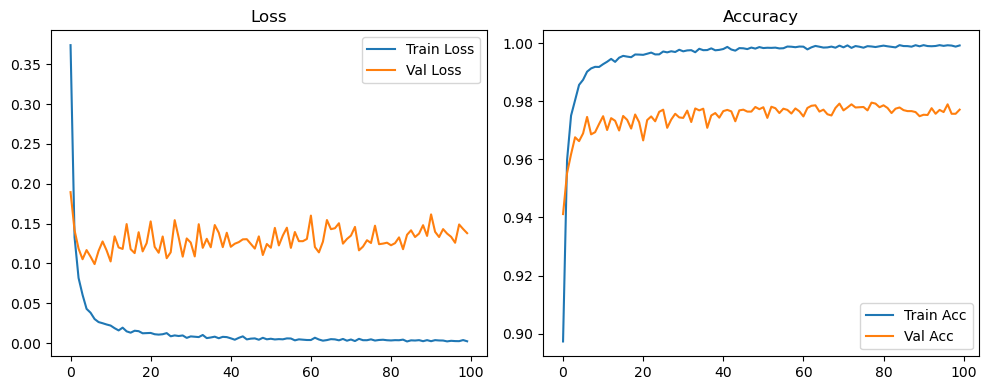

🚀 Running: batch64_lr0.002_0.002_0.002_dp0.2


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.5195, Acc: 0.8516 | Val Loss: 0.2643, Acc: 0.9188


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.3050, Acc: 0.9082 | Val Loss: 0.2035, Acc: 0.9375


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.2450, Acc: 0.9259 | Val Loss: 0.1726, Acc: 0.9491


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.2104, Acc: 0.9363 | Val Loss: 0.1510, Acc: 0.9554


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.1829, Acc: 0.9443 | Val Loss: 0.1433, Acc: 0.9580


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.1658, Acc: 0.9482 | Val Loss: 0.1355, Acc: 0.9595


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.1516, Acc: 0.9528 | Val Loss: 0.1279, Acc: 0.9630


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.1342, Acc: 0.9580 | Val Loss: 0.1316, Acc: 0.9598


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.1253, Acc: 0.9605 | Val Loss: 0.1264, Acc: 0.9639


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.1205, Acc: 0.9611 | Val Loss: 0.1121, Acc: 0.9686


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.1091, Acc: 0.9648 | Val Loss: 0.1195, Acc: 0.9658


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.1015, Acc: 0.9670 | Val Loss: 0.1147, Acc: 0.9683


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0962, Acc: 0.9689 | Val Loss: 0.1141, Acc: 0.9674


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0920, Acc: 0.9699 | Val Loss: 0.1166, Acc: 0.9673


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0888, Acc: 0.9716 | Val Loss: 0.1118, Acc: 0.9697


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0804, Acc: 0.9749 | Val Loss: 0.1139, Acc: 0.9685


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0807, Acc: 0.9739 | Val Loss: 0.1116, Acc: 0.9694


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0782, Acc: 0.9745 | Val Loss: 0.1134, Acc: 0.9695


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0717, Acc: 0.9763 | Val Loss: 0.1103, Acc: 0.9705


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0695, Acc: 0.9777 | Val Loss: 0.1101, Acc: 0.9709


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0719, Acc: 0.9764 | Val Loss: 0.1119, Acc: 0.9705


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0620, Acc: 0.9792 | Val Loss: 0.1090, Acc: 0.9707


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0598, Acc: 0.9801 | Val Loss: 0.1200, Acc: 0.9672


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0600, Acc: 0.9797 | Val Loss: 0.1163, Acc: 0.9697


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0584, Acc: 0.9807 | Val Loss: 0.1084, Acc: 0.9712


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0588, Acc: 0.9808 | Val Loss: 0.1035, Acc: 0.9719


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0565, Acc: 0.9816 | Val Loss: 0.1100, Acc: 0.9722


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0509, Acc: 0.9827 | Val Loss: 0.1127, Acc: 0.9731


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0525, Acc: 0.9820 | Val Loss: 0.1091, Acc: 0.9716


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0507, Acc: 0.9825 | Val Loss: 0.1033, Acc: 0.9747


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0483, Acc: 0.9835 | Val Loss: 0.1046, Acc: 0.9742


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0463, Acc: 0.9848 | Val Loss: 0.1058, Acc: 0.9735


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0481, Acc: 0.9843 | Val Loss: 0.1071, Acc: 0.9727


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0455, Acc: 0.9846 | Val Loss: 0.1131, Acc: 0.9724


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0450, Acc: 0.9853 | Val Loss: 0.1088, Acc: 0.9725


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0446, Acc: 0.9847 | Val Loss: 0.1096, Acc: 0.9739


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0422, Acc: 0.9859 | Val Loss: 0.1133, Acc: 0.9723


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0386, Acc: 0.9866 | Val Loss: 0.1126, Acc: 0.9746


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0405, Acc: 0.9862 | Val Loss: 0.1117, Acc: 0.9742


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0398, Acc: 0.9867 | Val Loss: 0.1078, Acc: 0.9732


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0389, Acc: 0.9867 | Val Loss: 0.1075, Acc: 0.9749


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0364, Acc: 0.9877 | Val Loss: 0.1099, Acc: 0.9747


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0370, Acc: 0.9873 | Val Loss: 0.1102, Acc: 0.9740


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0385, Acc: 0.9870 | Val Loss: 0.1077, Acc: 0.9747


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0359, Acc: 0.9877 | Val Loss: 0.1113, Acc: 0.9742


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0352, Acc: 0.9884 | Val Loss: 0.1105, Acc: 0.9747


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0364, Acc: 0.9878 | Val Loss: 0.1129, Acc: 0.9735


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0349, Acc: 0.9880 | Val Loss: 0.1167, Acc: 0.9734


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0337, Acc: 0.9885 | Val Loss: 0.1084, Acc: 0.9740


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0356, Acc: 0.9884 | Val Loss: 0.1074, Acc: 0.9742


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0332, Acc: 0.9885 | Val Loss: 0.1148, Acc: 0.9743


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0329, Acc: 0.9890 | Val Loss: 0.1065, Acc: 0.9758


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0319, Acc: 0.9892 | Val Loss: 0.1135, Acc: 0.9758


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0316, Acc: 0.9891 | Val Loss: 0.1137, Acc: 0.9751


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0323, Acc: 0.9888 | Val Loss: 0.1125, Acc: 0.9758


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0297, Acc: 0.9901 | Val Loss: 0.1106, Acc: 0.9764


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0305, Acc: 0.9899 | Val Loss: 0.1111, Acc: 0.9741


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0279, Acc: 0.9904 | Val Loss: 0.1160, Acc: 0.9739


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0295, Acc: 0.9900 | Val Loss: 0.1202, Acc: 0.9737


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0278, Acc: 0.9904 | Val Loss: 0.1113, Acc: 0.9735


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0304, Acc: 0.9895 | Val Loss: 0.1146, Acc: 0.9738


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0263, Acc: 0.9909 | Val Loss: 0.1238, Acc: 0.9731


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0291, Acc: 0.9901 | Val Loss: 0.1131, Acc: 0.9743


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0264, Acc: 0.9910 | Val Loss: 0.1189, Acc: 0.9753


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0289, Acc: 0.9904 | Val Loss: 0.1079, Acc: 0.9759


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0261, Acc: 0.9911 | Val Loss: 0.1158, Acc: 0.9757


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0257, Acc: 0.9904 | Val Loss: 0.1191, Acc: 0.9752


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0276, Acc: 0.9907 | Val Loss: 0.1106, Acc: 0.9744


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0296, Acc: 0.9899 | Val Loss: 0.1087, Acc: 0.9763


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0235, Acc: 0.9922 | Val Loss: 0.1134, Acc: 0.9760


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0261, Acc: 0.9913 | Val Loss: 0.1061, Acc: 0.9758


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0260, Acc: 0.9915 | Val Loss: 0.1121, Acc: 0.9753


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0267, Acc: 0.9911 | Val Loss: 0.1118, Acc: 0.9741


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0231, Acc: 0.9925 | Val Loss: 0.1114, Acc: 0.9761


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0241, Acc: 0.9914 | Val Loss: 0.1130, Acc: 0.9754


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0253, Acc: 0.9917 | Val Loss: 0.1121, Acc: 0.9752


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0236, Acc: 0.9919 | Val Loss: 0.1115, Acc: 0.9765


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0253, Acc: 0.9919 | Val Loss: 0.1164, Acc: 0.9749


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0239, Acc: 0.9923 | Val Loss: 0.1062, Acc: 0.9770


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0224, Acc: 0.9920 | Val Loss: 0.1089, Acc: 0.9762


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0217, Acc: 0.9923 | Val Loss: 0.1135, Acc: 0.9762


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0240, Acc: 0.9922 | Val Loss: 0.1124, Acc: 0.9762


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0233, Acc: 0.9927 | Val Loss: 0.1112, Acc: 0.9780


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0251, Acc: 0.9919 | Val Loss: 0.1131, Acc: 0.9769


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0224, Acc: 0.9921 | Val Loss: 0.1146, Acc: 0.9762


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0212, Acc: 0.9924 | Val Loss: 0.1193, Acc: 0.9768


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0237, Acc: 0.9922 | Val Loss: 0.1162, Acc: 0.9748


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0207, Acc: 0.9929 | Val Loss: 0.1163, Acc: 0.9772


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0234, Acc: 0.9923 | Val Loss: 0.1197, Acc: 0.9753


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0231, Acc: 0.9923 | Val Loss: 0.1082, Acc: 0.9752


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0222, Acc: 0.9924 | Val Loss: 0.1117, Acc: 0.9758


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0205, Acc: 0.9926 | Val Loss: 0.1151, Acc: 0.9763


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0207, Acc: 0.9931 | Val Loss: 0.1181, Acc: 0.9758


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0213, Acc: 0.9928 | Val Loss: 0.1156, Acc: 0.9766


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0197, Acc: 0.9932 | Val Loss: 0.1211, Acc: 0.9745


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0234, Acc: 0.9920 | Val Loss: 0.1104, Acc: 0.9749


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0194, Acc: 0.9935 | Val Loss: 0.1117, Acc: 0.9769


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0210, Acc: 0.9932 | Val Loss: 0.1132, Acc: 0.9761


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0206, Acc: 0.9931 | Val Loss: 0.1135, Acc: 0.9773


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0201, Acc: 0.9930 | Val Loss: 0.1147, Acc: 0.9772


Final Test Loss: 0.0973 Accuracy: 0.9786


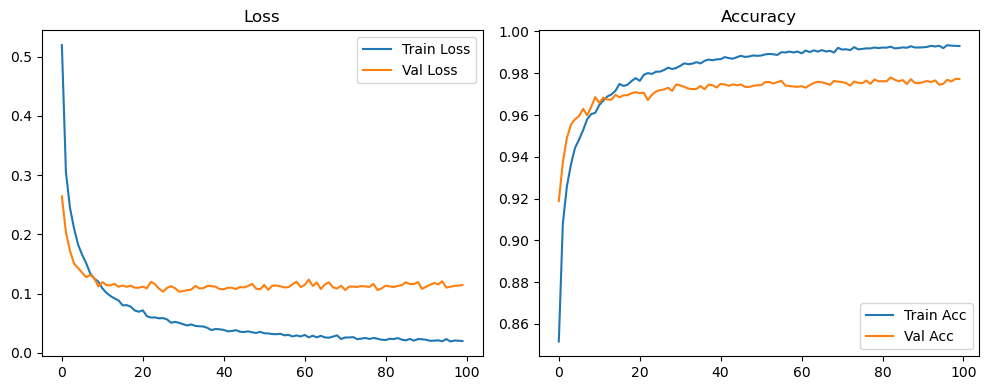

🚀 Running: batch64_lr0.002_0.002_0.002_dp0.5


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.8241, Acc: 0.7417 | Val Loss: 0.3488, Acc: 0.8971


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.4981, Acc: 0.8489 | Val Loss: 0.2890, Acc: 0.9133


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.4248, Acc: 0.8718 | Val Loss: 0.2641, Acc: 0.9222


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.3728, Acc: 0.8895 | Val Loss: 0.2309, Acc: 0.9300


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.3389, Acc: 0.8980 | Val Loss: 0.1997, Acc: 0.9413


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.3059, Acc: 0.9091 | Val Loss: 0.1873, Acc: 0.9433


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.2816, Acc: 0.9159 | Val Loss: 0.1719, Acc: 0.9482


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.2656, Acc: 0.9201 | Val Loss: 0.1629, Acc: 0.9511


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.2444, Acc: 0.9266 | Val Loss: 0.1542, Acc: 0.9541


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.2352, Acc: 0.9286 | Val Loss: 0.1439, Acc: 0.9568


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.2207, Acc: 0.9338 | Val Loss: 0.1433, Acc: 0.9574


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.2075, Acc: 0.9375 | Val Loss: 0.1360, Acc: 0.9596


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.1996, Acc: 0.9399 | Val Loss: 0.1341, Acc: 0.9603


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.1925, Acc: 0.9416 | Val Loss: 0.1288, Acc: 0.9607


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.1865, Acc: 0.9433 | Val Loss: 0.1250, Acc: 0.9628


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.1782, Acc: 0.9455 | Val Loss: 0.1205, Acc: 0.9647


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.1757, Acc: 0.9463 | Val Loss: 0.1199, Acc: 0.9644


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.1669, Acc: 0.9484 | Val Loss: 0.1186, Acc: 0.9658


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.1610, Acc: 0.9513 | Val Loss: 0.1141, Acc: 0.9669


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.1590, Acc: 0.9519 | Val Loss: 0.1111, Acc: 0.9667


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.1574, Acc: 0.9521 | Val Loss: 0.1103, Acc: 0.9674


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.1483, Acc: 0.9544 | Val Loss: 0.1087, Acc: 0.9681


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.1436, Acc: 0.9562 | Val Loss: 0.1096, Acc: 0.9686


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.1412, Acc: 0.9562 | Val Loss: 0.1108, Acc: 0.9688


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.1396, Acc: 0.9562 | Val Loss: 0.1061, Acc: 0.9689


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.1344, Acc: 0.9576 | Val Loss: 0.1068, Acc: 0.9695


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.1349, Acc: 0.9589 | Val Loss: 0.1039, Acc: 0.9710


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.1295, Acc: 0.9592 | Val Loss: 0.1022, Acc: 0.9709


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.1273, Acc: 0.9605 | Val Loss: 0.1044, Acc: 0.9704


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.1248, Acc: 0.9618 | Val Loss: 0.1016, Acc: 0.9719


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.1234, Acc: 0.9617 | Val Loss: 0.1007, Acc: 0.9720


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.1185, Acc: 0.9628 | Val Loss: 0.1014, Acc: 0.9724


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.1207, Acc: 0.9637 | Val Loss: 0.1018, Acc: 0.9710


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.1130, Acc: 0.9642 | Val Loss: 0.1016, Acc: 0.9720


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.1194, Acc: 0.9623 | Val Loss: 0.0992, Acc: 0.9722


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.1165, Acc: 0.9637 | Val Loss: 0.1007, Acc: 0.9727


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.1126, Acc: 0.9655 | Val Loss: 0.0987, Acc: 0.9733


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.1084, Acc: 0.9659 | Val Loss: 0.1039, Acc: 0.9724


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.1099, Acc: 0.9652 | Val Loss: 0.0997, Acc: 0.9725


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.1046, Acc: 0.9661 | Val Loss: 0.0971, Acc: 0.9741


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.1042, Acc: 0.9670 | Val Loss: 0.0995, Acc: 0.9728


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0999, Acc: 0.9687 | Val Loss: 0.0995, Acc: 0.9726


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0970, Acc: 0.9688 | Val Loss: 0.1046, Acc: 0.9732


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0995, Acc: 0.9685 | Val Loss: 0.1010, Acc: 0.9738


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.1002, Acc: 0.9679 | Val Loss: 0.1045, Acc: 0.9735


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.1028, Acc: 0.9678 | Val Loss: 0.1015, Acc: 0.9731


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0980, Acc: 0.9680 | Val Loss: 0.1008, Acc: 0.9741


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0976, Acc: 0.9686 | Val Loss: 0.1020, Acc: 0.9736


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0944, Acc: 0.9702 | Val Loss: 0.0978, Acc: 0.9744


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0943, Acc: 0.9695 | Val Loss: 0.0973, Acc: 0.9738


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0905, Acc: 0.9702 | Val Loss: 0.1022, Acc: 0.9724


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0930, Acc: 0.9709 | Val Loss: 0.1039, Acc: 0.9732


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0899, Acc: 0.9720 | Val Loss: 0.0983, Acc: 0.9741


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0898, Acc: 0.9710 | Val Loss: 0.0995, Acc: 0.9744


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0904, Acc: 0.9715 | Val Loss: 0.0987, Acc: 0.9738


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0863, Acc: 0.9730 | Val Loss: 0.0986, Acc: 0.9747


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0894, Acc: 0.9718 | Val Loss: 0.0982, Acc: 0.9746


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0870, Acc: 0.9723 | Val Loss: 0.0964, Acc: 0.9752


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0855, Acc: 0.9721 | Val Loss: 0.0994, Acc: 0.9748


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0855, Acc: 0.9731 | Val Loss: 0.0947, Acc: 0.9735


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0812, Acc: 0.9742 | Val Loss: 0.1029, Acc: 0.9742


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0837, Acc: 0.9728 | Val Loss: 0.0990, Acc: 0.9740


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0822, Acc: 0.9734 | Val Loss: 0.0946, Acc: 0.9749


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0781, Acc: 0.9748 | Val Loss: 0.0980, Acc: 0.9753


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0793, Acc: 0.9751 | Val Loss: 0.1021, Acc: 0.9736


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0825, Acc: 0.9737 | Val Loss: 0.0979, Acc: 0.9744


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0796, Acc: 0.9746 | Val Loss: 0.0982, Acc: 0.9741


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0776, Acc: 0.9757 | Val Loss: 0.0962, Acc: 0.9746


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0791, Acc: 0.9749 | Val Loss: 0.0986, Acc: 0.9747


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0763, Acc: 0.9758 | Val Loss: 0.0993, Acc: 0.9735


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0753, Acc: 0.9758 | Val Loss: 0.1013, Acc: 0.9759


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0744, Acc: 0.9766 | Val Loss: 0.1008, Acc: 0.9735


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0723, Acc: 0.9765 | Val Loss: 0.0974, Acc: 0.9752


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0755, Acc: 0.9754 | Val Loss: 0.0991, Acc: 0.9759


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0715, Acc: 0.9777 | Val Loss: 0.0969, Acc: 0.9743


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0742, Acc: 0.9766 | Val Loss: 0.0940, Acc: 0.9751


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0729, Acc: 0.9778 | Val Loss: 0.1009, Acc: 0.9736


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0748, Acc: 0.9764 | Val Loss: 0.1014, Acc: 0.9748


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0735, Acc: 0.9771 | Val Loss: 0.0977, Acc: 0.9760


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0719, Acc: 0.9770 | Val Loss: 0.0994, Acc: 0.9756


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0691, Acc: 0.9778 | Val Loss: 0.0994, Acc: 0.9754


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0711, Acc: 0.9771 | Val Loss: 0.0983, Acc: 0.9748


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0725, Acc: 0.9775 | Val Loss: 0.0963, Acc: 0.9758


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0684, Acc: 0.9789 | Val Loss: 0.0967, Acc: 0.9759


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0673, Acc: 0.9783 | Val Loss: 0.1042, Acc: 0.9743


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0693, Acc: 0.9776 | Val Loss: 0.1027, Acc: 0.9750


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0688, Acc: 0.9781 | Val Loss: 0.0999, Acc: 0.9769


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0685, Acc: 0.9785 | Val Loss: 0.1039, Acc: 0.9757


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0681, Acc: 0.9785 | Val Loss: 0.0989, Acc: 0.9745


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0665, Acc: 0.9787 | Val Loss: 0.0939, Acc: 0.9767


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0653, Acc: 0.9790 | Val Loss: 0.1002, Acc: 0.9758


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0679, Acc: 0.9785 | Val Loss: 0.0974, Acc: 0.9756


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0663, Acc: 0.9781 | Val Loss: 0.0993, Acc: 0.9752


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0679, Acc: 0.9782 | Val Loss: 0.1020, Acc: 0.9753


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0649, Acc: 0.9791 | Val Loss: 0.1040, Acc: 0.9757


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0664, Acc: 0.9786 | Val Loss: 0.0990, Acc: 0.9757


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0638, Acc: 0.9791 | Val Loss: 0.0998, Acc: 0.9747


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0644, Acc: 0.9803 | Val Loss: 0.0956, Acc: 0.9752


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0633, Acc: 0.9795 | Val Loss: 0.1014, Acc: 0.9748


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0652, Acc: 0.9791 | Val Loss: 0.1026, Acc: 0.9752


Final Test Loss: 0.0823 Accuracy: 0.9773


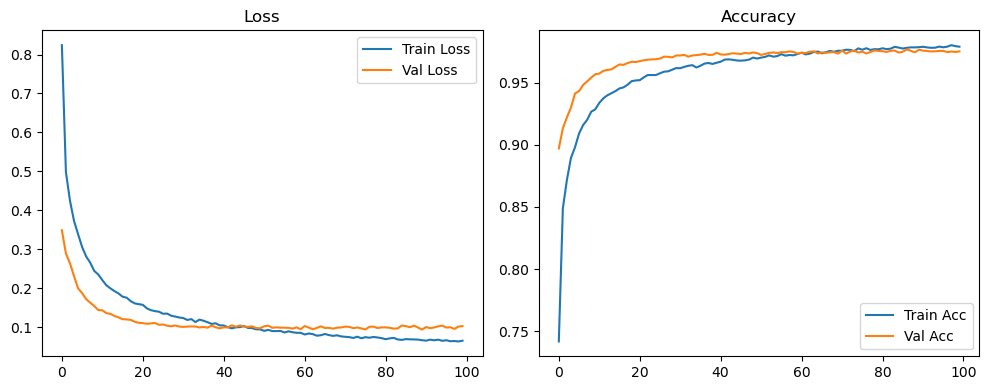

🚀 Running: batch64_lr0.001_0.001_0.001_dp0.0


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.4143, Acc: 0.8975 | Val Loss: 0.1837, Acc: 0.9435


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1289, Acc: 0.9611 | Val Loss: 0.1133, Acc: 0.9637


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0763, Acc: 0.9769 | Val Loss: 0.0965, Acc: 0.9688


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0518, Acc: 0.9839 | Val Loss: 0.0969, Acc: 0.9705


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0378, Acc: 0.9875 | Val Loss: 0.1033, Acc: 0.9683


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0315, Acc: 0.9895 | Val Loss: 0.1002, Acc: 0.9702


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0259, Acc: 0.9916 | Val Loss: 0.0938, Acc: 0.9735


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0243, Acc: 0.9923 | Val Loss: 0.1296, Acc: 0.9647


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0185, Acc: 0.9939 | Val Loss: 0.1115, Acc: 0.9720


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0160, Acc: 0.9945 | Val Loss: 0.1176, Acc: 0.9688


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0200, Acc: 0.9934 | Val Loss: 0.1207, Acc: 0.9697


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0169, Acc: 0.9945 | Val Loss: 0.0974, Acc: 0.9744


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0131, Acc: 0.9955 | Val Loss: 0.1299, Acc: 0.9684


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0147, Acc: 0.9949 | Val Loss: 0.1012, Acc: 0.9744


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0121, Acc: 0.9959 | Val Loss: 0.1114, Acc: 0.9734


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0133, Acc: 0.9955 | Val Loss: 0.1063, Acc: 0.9757


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0107, Acc: 0.9965 | Val Loss: 0.1091, Acc: 0.9745


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0116, Acc: 0.9959 | Val Loss: 0.1116, Acc: 0.9747


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0095, Acc: 0.9966 | Val Loss: 0.1132, Acc: 0.9742


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0135, Acc: 0.9953 | Val Loss: 0.1168, Acc: 0.9749


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9972 | Val Loss: 0.1248, Acc: 0.9721


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9975 | Val Loss: 0.1187, Acc: 0.9733


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9970 | Val Loss: 0.1302, Acc: 0.9720


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.1478, Acc: 0.9687


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0101, Acc: 0.9965 | Val Loss: 0.1129, Acc: 0.9748


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.1129, Acc: 0.9755


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.1232, Acc: 0.9744


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0092, Acc: 0.9969 | Val Loss: 0.1157, Acc: 0.9766


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9977 | Val Loss: 0.1294, Acc: 0.9722


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.1117, Acc: 0.9771


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1337, Acc: 0.9733


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.1290, Acc: 0.9738


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9976 | Val Loss: 0.1169, Acc: 0.9753


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.1323, Acc: 0.9747


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1170, Acc: 0.9757


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.1252, Acc: 0.9747


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.1297, Acc: 0.9756


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.1148, Acc: 0.9765


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.1047, Acc: 0.9785


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9986 | Val Loss: 0.1246, Acc: 0.9732


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.1333, Acc: 0.9739


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1265, Acc: 0.9758


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1300, Acc: 0.9755


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9983 | Val Loss: 0.1375, Acc: 0.9741


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1342, Acc: 0.9750


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.1241, Acc: 0.9762


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1210, Acc: 0.9767


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1233, Acc: 0.9774


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1426, Acc: 0.9739


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.1342, Acc: 0.9745


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.1292, Acc: 0.9769


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.1454, Acc: 0.9738


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.1296, Acc: 0.9766


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1237, Acc: 0.9769


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.1308, Acc: 0.9757


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.1417, Acc: 0.9748


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1483, Acc: 0.9720


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1387, Acc: 0.9742


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1366, Acc: 0.9755


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1219, Acc: 0.9781


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1313, Acc: 0.9762


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1372, Acc: 0.9773


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1261, Acc: 0.9786


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1313, Acc: 0.9780


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.1510, Acc: 0.9730


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1361, Acc: 0.9767


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9986 | Val Loss: 0.1261, Acc: 0.9768


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1384, Acc: 0.9756


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.1211, Acc: 0.9788


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.1361, Acc: 0.9758


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1274, Acc: 0.9762


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.2060, Acc: 0.9655


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1274, Acc: 0.9786


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1411, Acc: 0.9764


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1354, Acc: 0.9772


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.1247, Acc: 0.9777


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1267, Acc: 0.9789


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1282, Acc: 0.9779


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1267, Acc: 0.9783


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1393, Acc: 0.9771


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1376, Acc: 0.9772


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.1335, Acc: 0.9783


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1321, Acc: 0.9782


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1446, Acc: 0.9762


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1417, Acc: 0.9776


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1378, Acc: 0.9780


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1440, Acc: 0.9755


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1388, Acc: 0.9775


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9991 | Val Loss: 0.1374, Acc: 0.9777


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1391, Acc: 0.9772


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1510, Acc: 0.9747


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.1255, Acc: 0.9792


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9991 | Val Loss: 0.1429, Acc: 0.9772


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1456, Acc: 0.9754


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.1497, Acc: 0.9765


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.1485, Acc: 0.9754


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1403, Acc: 0.9781


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1512, Acc: 0.9777


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1453, Acc: 0.9768


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1346, Acc: 0.9788


Final Test Loss: 0.1335 Accuracy: 0.9790


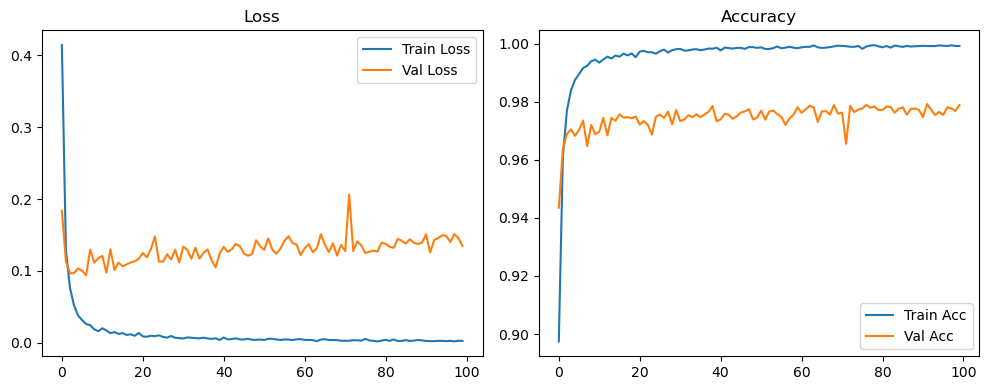

🚀 Running: batch64_lr0.001_0.001_0.001_dp0.2


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.5970, Acc: 0.8416 | Val Loss: 0.2850, Acc: 0.9127


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.3227, Acc: 0.9029 | Val Loss: 0.2107, Acc: 0.9353


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.2611, Acc: 0.9210 | Val Loss: 0.1823, Acc: 0.9452


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.2251, Acc: 0.9319 | Val Loss: 0.1585, Acc: 0.9517


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.1973, Acc: 0.9393 | Val Loss: 0.1444, Acc: 0.9552


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.1790, Acc: 0.9437 | Val Loss: 0.1391, Acc: 0.9573


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.1659, Acc: 0.9483 | Val Loss: 0.1277, Acc: 0.9614


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.1477, Acc: 0.9541 | Val Loss: 0.1288, Acc: 0.9614


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.1392, Acc: 0.9561 | Val Loss: 0.1233, Acc: 0.9641


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.1322, Acc: 0.9583 | Val Loss: 0.1143, Acc: 0.9654


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.1241, Acc: 0.9604 | Val Loss: 0.1177, Acc: 0.9655


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.1156, Acc: 0.9637 | Val Loss: 0.1123, Acc: 0.9683


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.1110, Acc: 0.9638 | Val Loss: 0.1122, Acc: 0.9684


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.1028, Acc: 0.9667 | Val Loss: 0.1110, Acc: 0.9686


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.1001, Acc: 0.9685 | Val Loss: 0.1090, Acc: 0.9692


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0931, Acc: 0.9695 | Val Loss: 0.1114, Acc: 0.9700


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0893, Acc: 0.9711 | Val Loss: 0.1109, Acc: 0.9677


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0872, Acc: 0.9714 | Val Loss: 0.1082, Acc: 0.9706


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0822, Acc: 0.9729 | Val Loss: 0.1086, Acc: 0.9698


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0782, Acc: 0.9741 | Val Loss: 0.1098, Acc: 0.9692


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0800, Acc: 0.9738 | Val Loss: 0.1067, Acc: 0.9712


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0749, Acc: 0.9746 | Val Loss: 0.1107, Acc: 0.9702


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0678, Acc: 0.9774 | Val Loss: 0.1108, Acc: 0.9703


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0688, Acc: 0.9777 | Val Loss: 0.1161, Acc: 0.9692


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0679, Acc: 0.9775 | Val Loss: 0.1100, Acc: 0.9709


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0643, Acc: 0.9791 | Val Loss: 0.1109, Acc: 0.9717


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0646, Acc: 0.9787 | Val Loss: 0.1078, Acc: 0.9716


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0609, Acc: 0.9796 | Val Loss: 0.1085, Acc: 0.9719


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0580, Acc: 0.9803 | Val Loss: 0.1123, Acc: 0.9712


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0571, Acc: 0.9811 | Val Loss: 0.1133, Acc: 0.9708


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0532, Acc: 0.9822 | Val Loss: 0.1224, Acc: 0.9708


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0548, Acc: 0.9817 | Val Loss: 0.1089, Acc: 0.9721


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0578, Acc: 0.9810 | Val Loss: 0.1085, Acc: 0.9727


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0512, Acc: 0.9832 | Val Loss: 0.1125, Acc: 0.9718


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0510, Acc: 0.9827 | Val Loss: 0.1103, Acc: 0.9718


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0507, Acc: 0.9829 | Val Loss: 0.1139, Acc: 0.9727


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0471, Acc: 0.9846 | Val Loss: 0.1140, Acc: 0.9712


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0485, Acc: 0.9837 | Val Loss: 0.1130, Acc: 0.9704


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0467, Acc: 0.9841 | Val Loss: 0.1158, Acc: 0.9705


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0473, Acc: 0.9847 | Val Loss: 0.1083, Acc: 0.9721


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0466, Acc: 0.9840 | Val Loss: 0.1109, Acc: 0.9726


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0408, Acc: 0.9858 | Val Loss: 0.1102, Acc: 0.9738


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0463, Acc: 0.9851 | Val Loss: 0.1141, Acc: 0.9726


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0439, Acc: 0.9854 | Val Loss: 0.1083, Acc: 0.9749


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0424, Acc: 0.9858 | Val Loss: 0.1184, Acc: 0.9718


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0432, Acc: 0.9857 | Val Loss: 0.1118, Acc: 0.9722


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0416, Acc: 0.9862 | Val Loss: 0.1146, Acc: 0.9735


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0395, Acc: 0.9868 | Val Loss: 0.1258, Acc: 0.9721


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0398, Acc: 0.9868 | Val Loss: 0.1189, Acc: 0.9730


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0391, Acc: 0.9872 | Val Loss: 0.1115, Acc: 0.9729


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0381, Acc: 0.9873 | Val Loss: 0.1184, Acc: 0.9724


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0372, Acc: 0.9872 | Val Loss: 0.1200, Acc: 0.9727


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0377, Acc: 0.9871 | Val Loss: 0.1171, Acc: 0.9725


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0356, Acc: 0.9877 | Val Loss: 0.1152, Acc: 0.9744


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0365, Acc: 0.9878 | Val Loss: 0.1175, Acc: 0.9733


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0371, Acc: 0.9875 | Val Loss: 0.1174, Acc: 0.9725


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0324, Acc: 0.9888 | Val Loss: 0.1120, Acc: 0.9737


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0344, Acc: 0.9887 | Val Loss: 0.1109, Acc: 0.9736


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0348, Acc: 0.9880 | Val Loss: 0.1160, Acc: 0.9747


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0328, Acc: 0.9894 | Val Loss: 0.1139, Acc: 0.9744


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0347, Acc: 0.9887 | Val Loss: 0.1219, Acc: 0.9727


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0279, Acc: 0.9906 | Val Loss: 0.1220, Acc: 0.9736


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0289, Acc: 0.9900 | Val Loss: 0.1147, Acc: 0.9741


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0313, Acc: 0.9896 | Val Loss: 0.1200, Acc: 0.9742


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0309, Acc: 0.9901 | Val Loss: 0.1173, Acc: 0.9745


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0303, Acc: 0.9899 | Val Loss: 0.1149, Acc: 0.9743


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0311, Acc: 0.9899 | Val Loss: 0.1147, Acc: 0.9732


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0282, Acc: 0.9901 | Val Loss: 0.1180, Acc: 0.9738


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0325, Acc: 0.9890 | Val Loss: 0.1175, Acc: 0.9746


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0285, Acc: 0.9908 | Val Loss: 0.1196, Acc: 0.9736


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0302, Acc: 0.9897 | Val Loss: 0.1238, Acc: 0.9730


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0309, Acc: 0.9893 | Val Loss: 0.1213, Acc: 0.9738


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0285, Acc: 0.9908 | Val Loss: 0.1175, Acc: 0.9742


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0283, Acc: 0.9902 | Val Loss: 0.1190, Acc: 0.9735


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0286, Acc: 0.9902 | Val Loss: 0.1197, Acc: 0.9740


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0285, Acc: 0.9904 | Val Loss: 0.1166, Acc: 0.9747


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0285, Acc: 0.9905 | Val Loss: 0.1165, Acc: 0.9738


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0261, Acc: 0.9915 | Val Loss: 0.1231, Acc: 0.9736


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0275, Acc: 0.9912 | Val Loss: 0.1172, Acc: 0.9739


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0234, Acc: 0.9917 | Val Loss: 0.1223, Acc: 0.9747


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0274, Acc: 0.9905 | Val Loss: 0.1197, Acc: 0.9738


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0263, Acc: 0.9910 | Val Loss: 0.1190, Acc: 0.9741


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0259, Acc: 0.9916 | Val Loss: 0.1157, Acc: 0.9750


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0258, Acc: 0.9914 | Val Loss: 0.1218, Acc: 0.9746


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0262, Acc: 0.9912 | Val Loss: 0.1166, Acc: 0.9743


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0236, Acc: 0.9918 | Val Loss: 0.1163, Acc: 0.9759


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0267, Acc: 0.9914 | Val Loss: 0.1178, Acc: 0.9750


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0273, Acc: 0.9912 | Val Loss: 0.1160, Acc: 0.9742


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0236, Acc: 0.9923 | Val Loss: 0.1292, Acc: 0.9734


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0232, Acc: 0.9924 | Val Loss: 0.1129, Acc: 0.9748


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0248, Acc: 0.9920 | Val Loss: 0.1207, Acc: 0.9752


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0254, Acc: 0.9916 | Val Loss: 0.1278, Acc: 0.9736


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0225, Acc: 0.9924 | Val Loss: 0.1195, Acc: 0.9740


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0246, Acc: 0.9918 | Val Loss: 0.1234, Acc: 0.9737


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0224, Acc: 0.9926 | Val Loss: 0.1238, Acc: 0.9728


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0254, Acc: 0.9918 | Val Loss: 0.1209, Acc: 0.9751


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0235, Acc: 0.9922 | Val Loss: 0.1214, Acc: 0.9736


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0217, Acc: 0.9925 | Val Loss: 0.1238, Acc: 0.9746


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0227, Acc: 0.9926 | Val Loss: 0.1224, Acc: 0.9734


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0211, Acc: 0.9929 | Val Loss: 0.1234, Acc: 0.9747


Final Test Loss: 0.1078 Accuracy: 0.9783


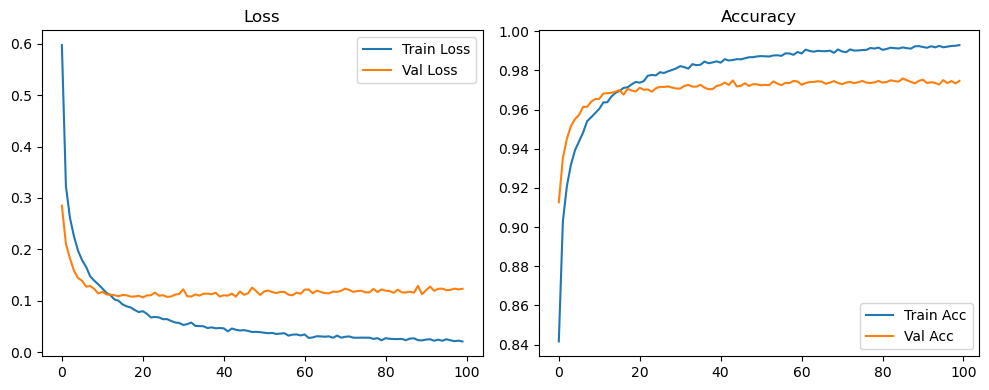

🚀 Running: batch64_lr0.001_0.001_0.001_dp0.5


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.9734, Acc: 0.7001 | Val Loss: 0.3854, Acc: 0.8898


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.5581, Acc: 0.8296 | Val Loss: 0.3168, Acc: 0.9060


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.4785, Acc: 0.8551 | Val Loss: 0.2941, Acc: 0.9123


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.4287, Acc: 0.8718 | Val Loss: 0.2708, Acc: 0.9197


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.3977, Acc: 0.8815 | Val Loss: 0.2444, Acc: 0.9259


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.3626, Acc: 0.8916 | Val Loss: 0.2326, Acc: 0.9297


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.3427, Acc: 0.8985 | Val Loss: 0.2191, Acc: 0.9347


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.3254, Acc: 0.9027 | Val Loss: 0.2081, Acc: 0.9386


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.3066, Acc: 0.9085 | Val Loss: 0.1935, Acc: 0.9416


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.2908, Acc: 0.9132 | Val Loss: 0.1859, Acc: 0.9449


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.2784, Acc: 0.9176 | Val Loss: 0.1797, Acc: 0.9457


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.2591, Acc: 0.9209 | Val Loss: 0.1706, Acc: 0.9488


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.2520, Acc: 0.9240 | Val Loss: 0.1676, Acc: 0.9494


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.2404, Acc: 0.9265 | Val Loss: 0.1600, Acc: 0.9521


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.2322, Acc: 0.9313 | Val Loss: 0.1626, Acc: 0.9531


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.2239, Acc: 0.9336 | Val Loss: 0.1510, Acc: 0.9551


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.2181, Acc: 0.9340 | Val Loss: 0.1476, Acc: 0.9563


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.2111, Acc: 0.9358 | Val Loss: 0.1453, Acc: 0.9569


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.2031, Acc: 0.9378 | Val Loss: 0.1426, Acc: 0.9587


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.1986, Acc: 0.9398 | Val Loss: 0.1403, Acc: 0.9593


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.1936, Acc: 0.9421 | Val Loss: 0.1320, Acc: 0.9617


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.1884, Acc: 0.9418 | Val Loss: 0.1328, Acc: 0.9611


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.1780, Acc: 0.9457 | Val Loss: 0.1307, Acc: 0.9625


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.1790, Acc: 0.9451 | Val Loss: 0.1286, Acc: 0.9622


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.1727, Acc: 0.9469 | Val Loss: 0.1254, Acc: 0.9636


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.1683, Acc: 0.9480 | Val Loss: 0.1246, Acc: 0.9637


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.1689, Acc: 0.9490 | Val Loss: 0.1259, Acc: 0.9632


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.1611, Acc: 0.9494 | Val Loss: 0.1241, Acc: 0.9649


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.1548, Acc: 0.9524 | Val Loss: 0.1221, Acc: 0.9653


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.1560, Acc: 0.9522 | Val Loss: 0.1229, Acc: 0.9650


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.1502, Acc: 0.9536 | Val Loss: 0.1224, Acc: 0.9651


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.1481, Acc: 0.9536 | Val Loss: 0.1208, Acc: 0.9655


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.1493, Acc: 0.9532 | Val Loss: 0.1166, Acc: 0.9667


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.1420, Acc: 0.9558 | Val Loss: 0.1199, Acc: 0.9660


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.1446, Acc: 0.9542 | Val Loss: 0.1177, Acc: 0.9672


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.1429, Acc: 0.9555 | Val Loss: 0.1153, Acc: 0.9684


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.1356, Acc: 0.9578 | Val Loss: 0.1120, Acc: 0.9677


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.1369, Acc: 0.9566 | Val Loss: 0.1117, Acc: 0.9683


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.1374, Acc: 0.9578 | Val Loss: 0.1160, Acc: 0.9667


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.1294, Acc: 0.9600 | Val Loss: 0.1135, Acc: 0.9683


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.1297, Acc: 0.9590 | Val Loss: 0.1136, Acc: 0.9688


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.1273, Acc: 0.9598 | Val Loss: 0.1102, Acc: 0.9698


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.1239, Acc: 0.9609 | Val Loss: 0.1151, Acc: 0.9677


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.1214, Acc: 0.9622 | Val Loss: 0.1122, Acc: 0.9694


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.1260, Acc: 0.9602 | Val Loss: 0.1157, Acc: 0.9694


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.1213, Acc: 0.9614 | Val Loss: 0.1138, Acc: 0.9694


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.1208, Acc: 0.9626 | Val Loss: 0.1128, Acc: 0.9690


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.1194, Acc: 0.9630 | Val Loss: 0.1143, Acc: 0.9705


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.1195, Acc: 0.9629 | Val Loss: 0.1086, Acc: 0.9701


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.1137, Acc: 0.9629 | Val Loss: 0.1088, Acc: 0.9705


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.1142, Acc: 0.9639 | Val Loss: 0.1104, Acc: 0.9692


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.1146, Acc: 0.9628 | Val Loss: 0.1117, Acc: 0.9692


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.1145, Acc: 0.9646 | Val Loss: 0.1108, Acc: 0.9699


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.1114, Acc: 0.9640 | Val Loss: 0.1101, Acc: 0.9698


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.1116, Acc: 0.9650 | Val Loss: 0.1090, Acc: 0.9698


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.1089, Acc: 0.9654 | Val Loss: 0.1059, Acc: 0.9706


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.1086, Acc: 0.9653 | Val Loss: 0.1094, Acc: 0.9711


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.1059, Acc: 0.9660 | Val Loss: 0.1063, Acc: 0.9700


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.1077, Acc: 0.9663 | Val Loss: 0.1072, Acc: 0.9697


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.1055, Acc: 0.9660 | Val Loss: 0.1078, Acc: 0.9701


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.1038, Acc: 0.9661 | Val Loss: 0.1091, Acc: 0.9698


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.1009, Acc: 0.9677 | Val Loss: 0.1080, Acc: 0.9711


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0994, Acc: 0.9690 | Val Loss: 0.1073, Acc: 0.9702


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0996, Acc: 0.9682 | Val Loss: 0.1078, Acc: 0.9710


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0963, Acc: 0.9699 | Val Loss: 0.1090, Acc: 0.9701


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.1013, Acc: 0.9675 | Val Loss: 0.1044, Acc: 0.9724


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.1006, Acc: 0.9689 | Val Loss: 0.1063, Acc: 0.9709


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0944, Acc: 0.9700 | Val Loss: 0.1056, Acc: 0.9719


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0941, Acc: 0.9702 | Val Loss: 0.1087, Acc: 0.9719


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0920, Acc: 0.9708 | Val Loss: 0.1114, Acc: 0.9718


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0952, Acc: 0.9699 | Val Loss: 0.1093, Acc: 0.9722


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0910, Acc: 0.9705 | Val Loss: 0.1111, Acc: 0.9715


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0932, Acc: 0.9707 | Val Loss: 0.1053, Acc: 0.9713


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0925, Acc: 0.9711 | Val Loss: 0.1060, Acc: 0.9724


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0877, Acc: 0.9718 | Val Loss: 0.1056, Acc: 0.9718


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0886, Acc: 0.9720 | Val Loss: 0.1060, Acc: 0.9722


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0929, Acc: 0.9707 | Val Loss: 0.1055, Acc: 0.9717


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0924, Acc: 0.9701 | Val Loss: 0.1091, Acc: 0.9722


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0886, Acc: 0.9716 | Val Loss: 0.1092, Acc: 0.9724


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0867, Acc: 0.9726 | Val Loss: 0.1084, Acc: 0.9726


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0830, Acc: 0.9731 | Val Loss: 0.1081, Acc: 0.9727


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0900, Acc: 0.9707 | Val Loss: 0.1071, Acc: 0.9715


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0898, Acc: 0.9720 | Val Loss: 0.1061, Acc: 0.9724


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0827, Acc: 0.9735 | Val Loss: 0.1072, Acc: 0.9722


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0838, Acc: 0.9733 | Val Loss: 0.1084, Acc: 0.9702


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0826, Acc: 0.9740 | Val Loss: 0.1037, Acc: 0.9728


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0856, Acc: 0.9726 | Val Loss: 0.1052, Acc: 0.9731


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0846, Acc: 0.9728 | Val Loss: 0.1079, Acc: 0.9725


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0814, Acc: 0.9743 | Val Loss: 0.1048, Acc: 0.9711


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0800, Acc: 0.9746 | Val Loss: 0.1031, Acc: 0.9733


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0813, Acc: 0.9749 | Val Loss: 0.1032, Acc: 0.9734


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0773, Acc: 0.9751 | Val Loss: 0.1047, Acc: 0.9726


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0787, Acc: 0.9748 | Val Loss: 0.1053, Acc: 0.9736


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0820, Acc: 0.9729 | Val Loss: 0.1025, Acc: 0.9727


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0783, Acc: 0.9748 | Val Loss: 0.1054, Acc: 0.9723


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0846, Acc: 0.9735 | Val Loss: 0.1024, Acc: 0.9733


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0768, Acc: 0.9752 | Val Loss: 0.1052, Acc: 0.9732


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0788, Acc: 0.9745 | Val Loss: 0.1071, Acc: 0.9722


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0794, Acc: 0.9742 | Val Loss: 0.1052, Acc: 0.9732


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0797, Acc: 0.9736 | Val Loss: 0.1046, Acc: 0.9725


Final Test Loss: 0.0908 Accuracy: 0.9756


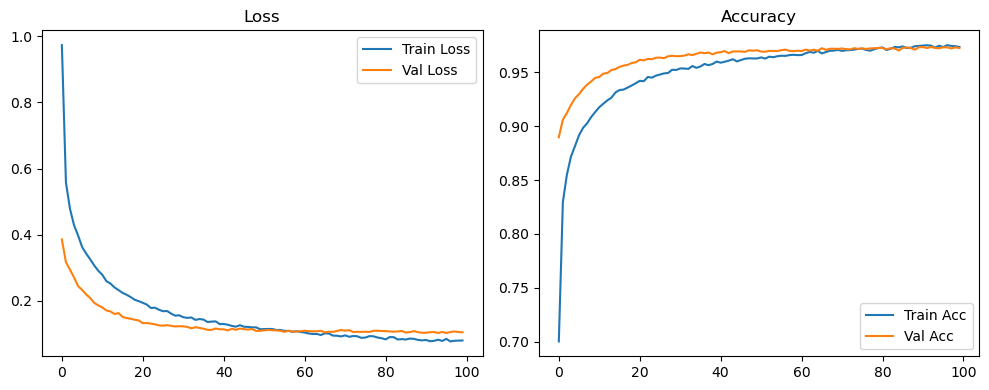

🚀 Running: batch128_lr0.01_0.01_0.01_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3691, Acc: 0.8895 | Val Loss: 0.2302, Acc: 0.9301


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1677, Acc: 0.9495 | Val Loss: 0.1512, Acc: 0.9537


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1010, Acc: 0.9683 | Val Loss: 0.1382, Acc: 0.9588


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0781, Acc: 0.9741 | Val Loss: 0.1104, Acc: 0.9699


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0568, Acc: 0.9816 | Val Loss: 0.1523, Acc: 0.9584


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0459, Acc: 0.9845 | Val Loss: 0.1280, Acc: 0.9651


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0364, Acc: 0.9884 | Val Loss: 0.1243, Acc: 0.9675


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0313, Acc: 0.9901 | Val Loss: 0.1211, Acc: 0.9673


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0256, Acc: 0.9914 | Val Loss: 0.1422, Acc: 0.9650


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0295, Acc: 0.9903 | Val Loss: 0.1171, Acc: 0.9704


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0226, Acc: 0.9925 | Val Loss: 0.1428, Acc: 0.9664


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9931 | Val Loss: 0.2269, Acc: 0.9477


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9926 | Val Loss: 0.1519, Acc: 0.9682


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0191, Acc: 0.9934 | Val Loss: 0.1530, Acc: 0.9671


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9939 | Val Loss: 0.1644, Acc: 0.9644


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9945 | Val Loss: 0.1431, Acc: 0.9718


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0172, Acc: 0.9940 | Val Loss: 0.1430, Acc: 0.9699


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9955 | Val Loss: 0.1441, Acc: 0.9716


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9951 | Val Loss: 0.1446, Acc: 0.9716


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9962 | Val Loss: 0.1446, Acc: 0.9715


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9954 | Val Loss: 0.1440, Acc: 0.9690


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9963 | Val Loss: 0.1350, Acc: 0.9728


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9962 | Val Loss: 0.1297, Acc: 0.9730


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9966 | Val Loss: 0.1927, Acc: 0.9665


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9957 | Val Loss: 0.1317, Acc: 0.9738


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9965 | Val Loss: 0.1532, Acc: 0.9667


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9965 | Val Loss: 0.2010, Acc: 0.9616


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9965 | Val Loss: 0.1353, Acc: 0.9730


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9969 | Val Loss: 0.1320, Acc: 0.9730


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9967 | Val Loss: 0.1610, Acc: 0.9647


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9972 | Val Loss: 0.1868, Acc: 0.9672


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.1626, Acc: 0.9675


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9971 | Val Loss: 0.1505, Acc: 0.9681


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.1493, Acc: 0.9759


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9973 | Val Loss: 0.1158, Acc: 0.9742


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.1520, Acc: 0.9705


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.1455, Acc: 0.9747


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9973 | Val Loss: 0.1426, Acc: 0.9738


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.1497, Acc: 0.9729


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.1357, Acc: 0.9720


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.1417, Acc: 0.9746


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.1185, Acc: 0.9757


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.1475, Acc: 0.9755


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9973 | Val Loss: 0.1838, Acc: 0.9684


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.1345, Acc: 0.9702


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9982 | Val Loss: 0.1677, Acc: 0.9738


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.1984, Acc: 0.9664


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9984 | Val Loss: 0.1489, Acc: 0.9744


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.1412, Acc: 0.9746


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.1881, Acc: 0.9700


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.1418, Acc: 0.9757


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9981 | Val Loss: 0.1549, Acc: 0.9746


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1901, Acc: 0.9693


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9978 | Val Loss: 0.1402, Acc: 0.9730


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.1516, Acc: 0.9722


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1164, Acc: 0.9755


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1607, Acc: 0.9738


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.1679, Acc: 0.9738


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1500, Acc: 0.9703


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1310, Acc: 0.9760


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1666, Acc: 0.9742


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1582, Acc: 0.9734


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9986 | Val Loss: 0.1471, Acc: 0.9741


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.1337, Acc: 0.9749


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.1395, Acc: 0.9758


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1552, Acc: 0.9746


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.1597, Acc: 0.9761


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1480, Acc: 0.9752


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.1406, Acc: 0.9726


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.1208, Acc: 0.9757


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.2093, Acc: 0.9692


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1736, Acc: 0.9753


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1876, Acc: 0.9754


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1784, Acc: 0.9745


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1584, Acc: 0.9741


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.1409, Acc: 0.9752


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.1377, Acc: 0.9751


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1243, Acc: 0.9754


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.2138, Acc: 0.9722


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1717, Acc: 0.9744


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1453, Acc: 0.9748


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1457, Acc: 0.9746


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1579, Acc: 0.9760


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1591, Acc: 0.9759


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.1437, Acc: 0.9745


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1492, Acc: 0.9758


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1662, Acc: 0.9758


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1866, Acc: 0.9706


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1761, Acc: 0.9742


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1583, Acc: 0.9758


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1444, Acc: 0.9759


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.1577, Acc: 0.9762


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9990 | Val Loss: 0.1281, Acc: 0.9709


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9994 | Val Loss: 0.1700, Acc: 0.9751


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9991 | Val Loss: 0.1240, Acc: 0.9762


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9987 | Val Loss: 0.1348, Acc: 0.9758


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1588, Acc: 0.9735


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1890, Acc: 0.9743


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.2099, Acc: 0.9718


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.1893, Acc: 0.9685


Final Test Loss: 0.1705 Accuracy: 0.9697


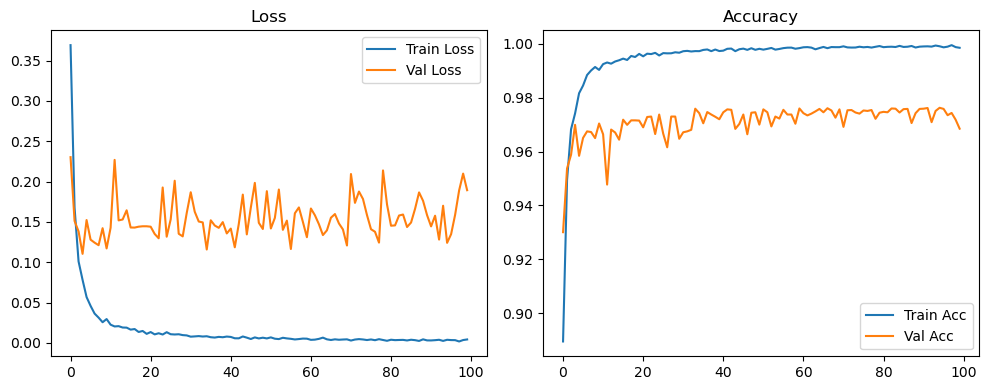

🚀 Running: batch128_lr0.01_0.01_0.01_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4610, Acc: 0.8600 | Val Loss: 0.2527, Acc: 0.9264


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2539, Acc: 0.9235 | Val Loss: 0.1758, Acc: 0.9457


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1869, Acc: 0.9435 | Val Loss: 0.1606, Acc: 0.9514


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1487, Acc: 0.9547 | Val Loss: 0.1282, Acc: 0.9613


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1250, Acc: 0.9615 | Val Loss: 0.1241, Acc: 0.9647


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1079, Acc: 0.9655 | Val Loss: 0.1223, Acc: 0.9651


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0926, Acc: 0.9703 | Val Loss: 0.1038, Acc: 0.9708


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0790, Acc: 0.9747 | Val Loss: 0.1045, Acc: 0.9685


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0700, Acc: 0.9768 | Val Loss: 0.1034, Acc: 0.9707


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0681, Acc: 0.9776 | Val Loss: 0.1058, Acc: 0.9698


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0585, Acc: 0.9806 | Val Loss: 0.1104, Acc: 0.9712


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0537, Acc: 0.9821 | Val Loss: 0.1046, Acc: 0.9738


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0495, Acc: 0.9837 | Val Loss: 0.1028, Acc: 0.9738


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0469, Acc: 0.9837 | Val Loss: 0.1050, Acc: 0.9733


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0448, Acc: 0.9845 | Val Loss: 0.1082, Acc: 0.9721


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0412, Acc: 0.9862 | Val Loss: 0.1014, Acc: 0.9741


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0398, Acc: 0.9868 | Val Loss: 0.1021, Acc: 0.9743


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0385, Acc: 0.9871 | Val Loss: 0.1007, Acc: 0.9741


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0364, Acc: 0.9883 | Val Loss: 0.1004, Acc: 0.9749


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0347, Acc: 0.9887 | Val Loss: 0.0993, Acc: 0.9746


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0333, Acc: 0.9887 | Val Loss: 0.1076, Acc: 0.9757


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0299, Acc: 0.9905 | Val Loss: 0.0959, Acc: 0.9733


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0323, Acc: 0.9890 | Val Loss: 0.1074, Acc: 0.9739


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0283, Acc: 0.9910 | Val Loss: 0.1100, Acc: 0.9761


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0254, Acc: 0.9912 | Val Loss: 0.1161, Acc: 0.9763


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0302, Acc: 0.9896 | Val Loss: 0.1109, Acc: 0.9750


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0288, Acc: 0.9907 | Val Loss: 0.1000, Acc: 0.9746


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9919 | Val Loss: 0.1067, Acc: 0.9742


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9914 | Val Loss: 0.1071, Acc: 0.9754


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0259, Acc: 0.9914 | Val Loss: 0.1018, Acc: 0.9736


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9925 | Val Loss: 0.1073, Acc: 0.9746


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9925 | Val Loss: 0.1161, Acc: 0.9762


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0221, Acc: 0.9920 | Val Loss: 0.1043, Acc: 0.9766


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0211, Acc: 0.9930 | Val Loss: 0.1140, Acc: 0.9762


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9930 | Val Loss: 0.1178, Acc: 0.9739


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0200, Acc: 0.9935 | Val Loss: 0.0952, Acc: 0.9785


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9938 | Val Loss: 0.1004, Acc: 0.9768


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9932 | Val Loss: 0.1048, Acc: 0.9779


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9932 | Val Loss: 0.1090, Acc: 0.9750


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9940 | Val Loss: 0.1178, Acc: 0.9750


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0191, Acc: 0.9936 | Val Loss: 0.1152, Acc: 0.9758


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9941 | Val Loss: 0.1069, Acc: 0.9765


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9945 | Val Loss: 0.1098, Acc: 0.9778


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9942 | Val Loss: 0.1087, Acc: 0.9769


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9945 | Val Loss: 0.1133, Acc: 0.9758


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0192, Acc: 0.9938 | Val Loss: 0.1144, Acc: 0.9779


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9945 | Val Loss: 0.1116, Acc: 0.9755


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9950 | Val Loss: 0.1130, Acc: 0.9766


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9941 | Val Loss: 0.1022, Acc: 0.9772


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9951 | Val Loss: 0.1098, Acc: 0.9768


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9953 | Val Loss: 0.0970, Acc: 0.9782


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9951 | Val Loss: 0.1026, Acc: 0.9785


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9950 | Val Loss: 0.1020, Acc: 0.9762


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9951 | Val Loss: 0.1087, Acc: 0.9780


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9948 | Val Loss: 0.0905, Acc: 0.9773


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9951 | Val Loss: 0.1068, Acc: 0.9779


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9955 | Val Loss: 0.1152, Acc: 0.9774


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9952 | Val Loss: 0.1225, Acc: 0.9785


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9955 | Val Loss: 0.1013, Acc: 0.9788


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9948 | Val Loss: 0.1032, Acc: 0.9783


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9958 | Val Loss: 0.1084, Acc: 0.9775


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9954 | Val Loss: 0.1109, Acc: 0.9759


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9958 | Val Loss: 0.1021, Acc: 0.9777


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9957 | Val Loss: 0.1308, Acc: 0.9760


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9957 | Val Loss: 0.1178, Acc: 0.9768


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9960 | Val Loss: 0.1032, Acc: 0.9778


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9959 | Val Loss: 0.1118, Acc: 0.9776


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9962 | Val Loss: 0.1148, Acc: 0.9779


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9955 | Val Loss: 0.0981, Acc: 0.9785


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9961 | Val Loss: 0.1313, Acc: 0.9771


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9960 | Val Loss: 0.1238, Acc: 0.9788


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9956 | Val Loss: 0.1052, Acc: 0.9774


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9961 | Val Loss: 0.1154, Acc: 0.9780


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9965 | Val Loss: 0.1044, Acc: 0.9786


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9964 | Val Loss: 0.0996, Acc: 0.9772


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9960 | Val Loss: 0.0948, Acc: 0.9783


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9960 | Val Loss: 0.1181, Acc: 0.9779


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9963 | Val Loss: 0.1027, Acc: 0.9771


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9966 | Val Loss: 0.1236, Acc: 0.9772


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9964 | Val Loss: 0.1100, Acc: 0.9773


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9965 | Val Loss: 0.1044, Acc: 0.9782


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9965 | Val Loss: 0.1093, Acc: 0.9787


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.1181, Acc: 0.9786


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9963 | Val Loss: 0.1045, Acc: 0.9793


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9962 | Val Loss: 0.0944, Acc: 0.9776


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9965 | Val Loss: 0.1104, Acc: 0.9779


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9966 | Val Loss: 0.1228, Acc: 0.9783


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9965 | Val Loss: 0.1204, Acc: 0.9792


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9970 | Val Loss: 0.1127, Acc: 0.9797


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9969 | Val Loss: 0.1167, Acc: 0.9789


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9970 | Val Loss: 0.1203, Acc: 0.9783


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9964 | Val Loss: 0.1005, Acc: 0.9783


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.1096, Acc: 0.9781


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9965 | Val Loss: 0.0914, Acc: 0.9759


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9973 | Val Loss: 0.1185, Acc: 0.9767


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.0960, Acc: 0.9772


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.1025, Acc: 0.9782


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9971 | Val Loss: 0.0954, Acc: 0.9786


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9967 | Val Loss: 0.1446, Acc: 0.9774


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9973 | Val Loss: 0.1147, Acc: 0.9784


Final Test Loss: 0.1087 Accuracy: 0.9784


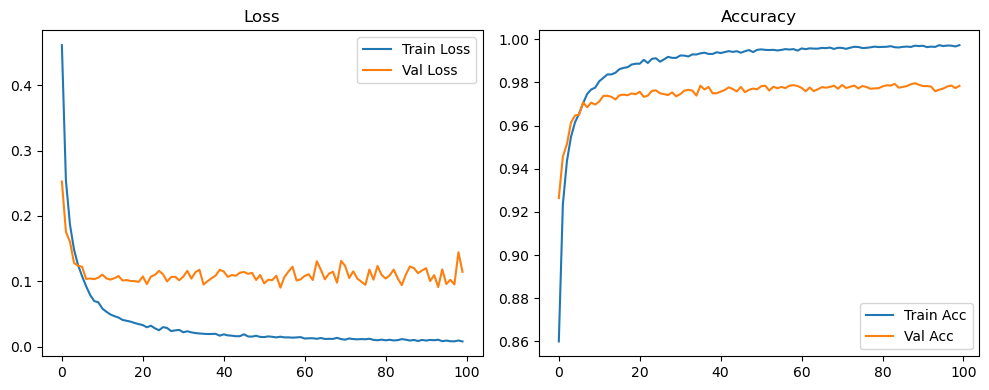

🚀 Running: batch128_lr0.01_0.01_0.01_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.6789, Acc: 0.7837 | Val Loss: 0.3178, Acc: 0.9050


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.4055, Acc: 0.8801 | Val Loss: 0.2265, Acc: 0.9328


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.3154, Acc: 0.9055 | Val Loss: 0.2004, Acc: 0.9405


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2606, Acc: 0.9223 | Val Loss: 0.1570, Acc: 0.9513


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.2290, Acc: 0.9313 | Val Loss: 0.1444, Acc: 0.9549


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.2054, Acc: 0.9381 | Val Loss: 0.1333, Acc: 0.9594


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1861, Acc: 0.9425 | Val Loss: 0.1304, Acc: 0.9622


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1687, Acc: 0.9490 | Val Loss: 0.1202, Acc: 0.9639


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1648, Acc: 0.9487 | Val Loss: 0.1177, Acc: 0.9665


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1546, Acc: 0.9538 | Val Loss: 0.1152, Acc: 0.9664


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1453, Acc: 0.9553 | Val Loss: 0.1096, Acc: 0.9682


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1375, Acc: 0.9576 | Val Loss: 0.1074, Acc: 0.9701


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1346, Acc: 0.9576 | Val Loss: 0.0981, Acc: 0.9712


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1258, Acc: 0.9610 | Val Loss: 0.1064, Acc: 0.9683


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1200, Acc: 0.9627 | Val Loss: 0.0959, Acc: 0.9720


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1197, Acc: 0.9636 | Val Loss: 0.1012, Acc: 0.9703


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1160, Acc: 0.9638 | Val Loss: 0.0960, Acc: 0.9714


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1071, Acc: 0.9662 | Val Loss: 0.0986, Acc: 0.9723


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1081, Acc: 0.9665 | Val Loss: 0.0941, Acc: 0.9738


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1012, Acc: 0.9678 | Val Loss: 0.0932, Acc: 0.9732


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0993, Acc: 0.9690 | Val Loss: 0.0964, Acc: 0.9726


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0985, Acc: 0.9692 | Val Loss: 0.0968, Acc: 0.9742


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0962, Acc: 0.9702 | Val Loss: 0.0928, Acc: 0.9742


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0942, Acc: 0.9705 | Val Loss: 0.0936, Acc: 0.9726


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0942, Acc: 0.9706 | Val Loss: 0.0940, Acc: 0.9734


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0900, Acc: 0.9723 | Val Loss: 0.0931, Acc: 0.9738


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0881, Acc: 0.9729 | Val Loss: 0.0939, Acc: 0.9749


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0843, Acc: 0.9732 | Val Loss: 0.1018, Acc: 0.9734


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0822, Acc: 0.9730 | Val Loss: 0.0922, Acc: 0.9739


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0822, Acc: 0.9750 | Val Loss: 0.0887, Acc: 0.9744


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0798, Acc: 0.9744 | Val Loss: 0.0918, Acc: 0.9752


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0772, Acc: 0.9762 | Val Loss: 0.0908, Acc: 0.9750


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0770, Acc: 0.9754 | Val Loss: 0.0910, Acc: 0.9742


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0744, Acc: 0.9767 | Val Loss: 0.0904, Acc: 0.9758


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0760, Acc: 0.9766 | Val Loss: 0.0899, Acc: 0.9756


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0733, Acc: 0.9768 | Val Loss: 0.0883, Acc: 0.9762


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0754, Acc: 0.9772 | Val Loss: 0.0850, Acc: 0.9752


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0733, Acc: 0.9771 | Val Loss: 0.0873, Acc: 0.9754


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0694, Acc: 0.9781 | Val Loss: 0.0999, Acc: 0.9758


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0692, Acc: 0.9784 | Val Loss: 0.0882, Acc: 0.9760


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0689, Acc: 0.9781 | Val Loss: 0.0928, Acc: 0.9756


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0626, Acc: 0.9802 | Val Loss: 0.0964, Acc: 0.9745


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0660, Acc: 0.9792 | Val Loss: 0.0988, Acc: 0.9759


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0646, Acc: 0.9799 | Val Loss: 0.0930, Acc: 0.9757


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0633, Acc: 0.9801 | Val Loss: 0.0880, Acc: 0.9756


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0655, Acc: 0.9795 | Val Loss: 0.0923, Acc: 0.9764


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0616, Acc: 0.9810 | Val Loss: 0.0872, Acc: 0.9765


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0613, Acc: 0.9804 | Val Loss: 0.0925, Acc: 0.9762


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0644, Acc: 0.9799 | Val Loss: 0.0897, Acc: 0.9763


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0588, Acc: 0.9815 | Val Loss: 0.1005, Acc: 0.9772


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0578, Acc: 0.9814 | Val Loss: 0.0987, Acc: 0.9772


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0590, Acc: 0.9813 | Val Loss: 0.0983, Acc: 0.9763


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0560, Acc: 0.9823 | Val Loss: 0.0986, Acc: 0.9751


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0572, Acc: 0.9822 | Val Loss: 0.0942, Acc: 0.9760


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0569, Acc: 0.9819 | Val Loss: 0.1027, Acc: 0.9762


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0572, Acc: 0.9821 | Val Loss: 0.0944, Acc: 0.9759


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0564, Acc: 0.9820 | Val Loss: 0.0986, Acc: 0.9768


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0546, Acc: 0.9833 | Val Loss: 0.1011, Acc: 0.9770


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0529, Acc: 0.9832 | Val Loss: 0.1047, Acc: 0.9775


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0556, Acc: 0.9824 | Val Loss: 0.0996, Acc: 0.9772


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0494, Acc: 0.9840 | Val Loss: 0.0937, Acc: 0.9772


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0518, Acc: 0.9832 | Val Loss: 0.0940, Acc: 0.9782


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0527, Acc: 0.9831 | Val Loss: 0.0929, Acc: 0.9764


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0511, Acc: 0.9839 | Val Loss: 0.1004, Acc: 0.9764


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0513, Acc: 0.9840 | Val Loss: 0.0964, Acc: 0.9772


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0552, Acc: 0.9826 | Val Loss: 0.0989, Acc: 0.9760


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0497, Acc: 0.9843 | Val Loss: 0.0951, Acc: 0.9765


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0517, Acc: 0.9835 | Val Loss: 0.0853, Acc: 0.9769


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0487, Acc: 0.9846 | Val Loss: 0.0938, Acc: 0.9770


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0502, Acc: 0.9842 | Val Loss: 0.0950, Acc: 0.9771


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0511, Acc: 0.9836 | Val Loss: 0.1090, Acc: 0.9765


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0485, Acc: 0.9847 | Val Loss: 0.0878, Acc: 0.9776


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0517, Acc: 0.9839 | Val Loss: 0.1119, Acc: 0.9769


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0493, Acc: 0.9845 | Val Loss: 0.0847, Acc: 0.9768


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0487, Acc: 0.9849 | Val Loss: 0.1041, Acc: 0.9762


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0472, Acc: 0.9856 | Val Loss: 0.0852, Acc: 0.9761


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0469, Acc: 0.9851 | Val Loss: 0.0892, Acc: 0.9772


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0466, Acc: 0.9849 | Val Loss: 0.0993, Acc: 0.9771


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0453, Acc: 0.9856 | Val Loss: 0.0954, Acc: 0.9771


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0437, Acc: 0.9860 | Val Loss: 0.1087, Acc: 0.9769


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0454, Acc: 0.9859 | Val Loss: 0.0986, Acc: 0.9765


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0441, Acc: 0.9859 | Val Loss: 0.0976, Acc: 0.9770


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0460, Acc: 0.9858 | Val Loss: 0.1023, Acc: 0.9764


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0441, Acc: 0.9865 | Val Loss: 0.0918, Acc: 0.9758


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0470, Acc: 0.9853 | Val Loss: 0.0830, Acc: 0.9753


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0441, Acc: 0.9856 | Val Loss: 0.1015, Acc: 0.9760


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0420, Acc: 0.9864 | Val Loss: 0.1031, Acc: 0.9764


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0419, Acc: 0.9862 | Val Loss: 0.0970, Acc: 0.9765


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0413, Acc: 0.9871 | Val Loss: 0.1030, Acc: 0.9760


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0433, Acc: 0.9857 | Val Loss: 0.0998, Acc: 0.9762


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0415, Acc: 0.9875 | Val Loss: 0.0933, Acc: 0.9762


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0401, Acc: 0.9873 | Val Loss: 0.0917, Acc: 0.9772


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0408, Acc: 0.9868 | Val Loss: 0.1121, Acc: 0.9758


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0417, Acc: 0.9871 | Val Loss: 0.0954, Acc: 0.9762


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0407, Acc: 0.9875 | Val Loss: 0.1036, Acc: 0.9752


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0424, Acc: 0.9863 | Val Loss: 0.1080, Acc: 0.9758


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0411, Acc: 0.9872 | Val Loss: 0.0999, Acc: 0.9766


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0397, Acc: 0.9869 | Val Loss: 0.0952, Acc: 0.9768


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0414, Acc: 0.9868 | Val Loss: 0.0846, Acc: 0.9766


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0408, Acc: 0.9870 | Val Loss: 0.0940, Acc: 0.9768


Final Test Loss: 0.0879 Accuracy: 0.9795


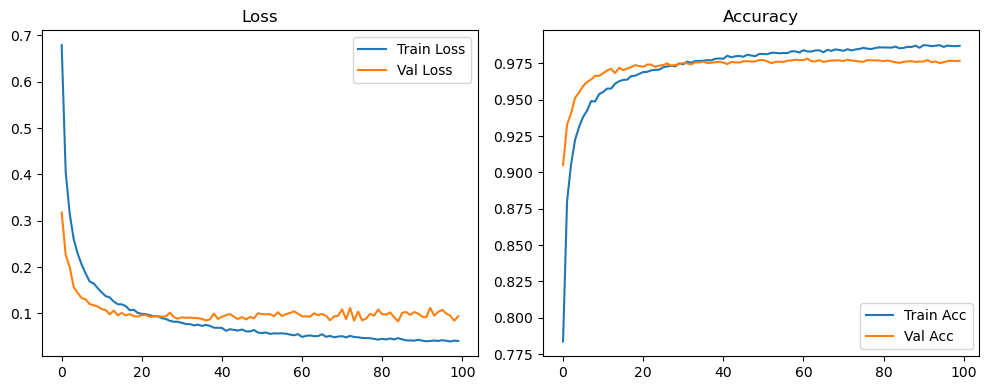

🚀 Running: batch128_lr0.01_0.005_0.002_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3691, Acc: 0.8895 | Val Loss: 0.2302, Acc: 0.9301


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1677, Acc: 0.9495 | Val Loss: 0.1512, Acc: 0.9537


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1010, Acc: 0.9683 | Val Loss: 0.1382, Acc: 0.9588


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0781, Acc: 0.9741 | Val Loss: 0.1104, Acc: 0.9699


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0568, Acc: 0.9816 | Val Loss: 0.1523, Acc: 0.9584


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0459, Acc: 0.9845 | Val Loss: 0.1280, Acc: 0.9651


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0364, Acc: 0.9884 | Val Loss: 0.1243, Acc: 0.9675


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0313, Acc: 0.9901 | Val Loss: 0.1211, Acc: 0.9673


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0256, Acc: 0.9914 | Val Loss: 0.1422, Acc: 0.9650


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0295, Acc: 0.9903 | Val Loss: 0.1171, Acc: 0.9704


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0226, Acc: 0.9925 | Val Loss: 0.1428, Acc: 0.9664


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9931 | Val Loss: 0.2269, Acc: 0.9477


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9926 | Val Loss: 0.1519, Acc: 0.9682


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0191, Acc: 0.9934 | Val Loss: 0.1530, Acc: 0.9671


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9939 | Val Loss: 0.1644, Acc: 0.9644


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9945 | Val Loss: 0.1431, Acc: 0.9718


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0172, Acc: 0.9940 | Val Loss: 0.1430, Acc: 0.9699


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9955 | Val Loss: 0.1441, Acc: 0.9716


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9951 | Val Loss: 0.1446, Acc: 0.9716


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9962 | Val Loss: 0.1446, Acc: 0.9715


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9954 | Val Loss: 0.1440, Acc: 0.9690


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9963 | Val Loss: 0.1350, Acc: 0.9728


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9962 | Val Loss: 0.1297, Acc: 0.9730


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9966 | Val Loss: 0.1927, Acc: 0.9665


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9957 | Val Loss: 0.1317, Acc: 0.9738


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9965 | Val Loss: 0.1532, Acc: 0.9667


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9965 | Val Loss: 0.2010, Acc: 0.9616


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9965 | Val Loss: 0.1353, Acc: 0.9730


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9969 | Val Loss: 0.1320, Acc: 0.9730


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9967 | Val Loss: 0.1610, Acc: 0.9647


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9972 | Val Loss: 0.1868, Acc: 0.9672


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.1626, Acc: 0.9675


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9971 | Val Loss: 0.1505, Acc: 0.9681


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.1493, Acc: 0.9759


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9973 | Val Loss: 0.1158, Acc: 0.9742


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.1520, Acc: 0.9705


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.1455, Acc: 0.9747


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9973 | Val Loss: 0.1426, Acc: 0.9738


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.1497, Acc: 0.9729


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.1357, Acc: 0.9720


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.1417, Acc: 0.9746


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.1185, Acc: 0.9757


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.1475, Acc: 0.9755


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9973 | Val Loss: 0.1838, Acc: 0.9684


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.1345, Acc: 0.9702


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9982 | Val Loss: 0.1677, Acc: 0.9738


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.1984, Acc: 0.9664


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9984 | Val Loss: 0.1489, Acc: 0.9744


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.1412, Acc: 0.9746


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.1881, Acc: 0.9700


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.1582, Acc: 0.9755


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1311, Acc: 0.9768


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.1631, Acc: 0.9760


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.1510, Acc: 0.9774


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1677, Acc: 0.9752


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1446, Acc: 0.9748


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1528, Acc: 0.9764


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1635, Acc: 0.9763


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1642, Acc: 0.9770


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1322, Acc: 0.9768


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1725, Acc: 0.9754


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1295, Acc: 0.9774


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1618, Acc: 0.9754


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1201, Acc: 0.9765


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1643, Acc: 0.9764


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1775, Acc: 0.9770


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1465, Acc: 0.9762


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.1694, Acc: 0.9762


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1601, Acc: 0.9776


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1901, Acc: 0.9760


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1359, Acc: 0.9764


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1558, Acc: 0.9779


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1828, Acc: 0.9774


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1479, Acc: 0.9774


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1653, Acc: 0.9759


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1790, Acc: 0.9766


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1363, Acc: 0.9777


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1800, Acc: 0.9782


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1488, Acc: 0.9783


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9995 | Val Loss: 0.1807, Acc: 0.9757


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1500, Acc: 0.9763


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1613, Acc: 0.9768


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1729, Acc: 0.9780


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1821, Acc: 0.9782


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1818, Acc: 0.9759


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1933, Acc: 0.9772


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1759, Acc: 0.9772


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9998 | Val Loss: 0.1883, Acc: 0.9778


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2080, Acc: 0.9770


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.2064, Acc: 0.9775


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.2012, Acc: 0.9774


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.2112, Acc: 0.9778


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2021, Acc: 0.9768


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1973, Acc: 0.9778


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1954, Acc: 0.9770


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2068, Acc: 0.9777


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1934, Acc: 0.9766


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1731, Acc: 0.9779


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1625, Acc: 0.9795


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1750, Acc: 0.9800


Final Test Loss: 0.1560 Accuracy: 0.9802


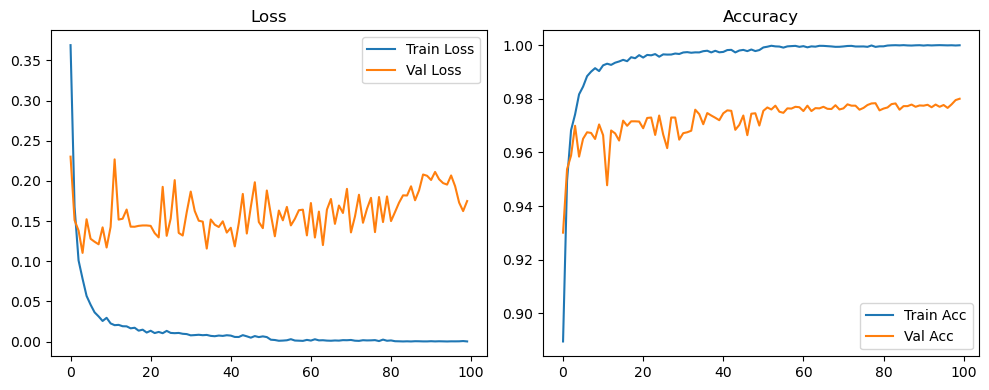

🚀 Running: batch128_lr0.01_0.005_0.002_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4610, Acc: 0.8600 | Val Loss: 0.2527, Acc: 0.9264


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2539, Acc: 0.9235 | Val Loss: 0.1758, Acc: 0.9457


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1869, Acc: 0.9435 | Val Loss: 0.1606, Acc: 0.9514


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1487, Acc: 0.9547 | Val Loss: 0.1282, Acc: 0.9613


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1250, Acc: 0.9615 | Val Loss: 0.1241, Acc: 0.9647


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1079, Acc: 0.9655 | Val Loss: 0.1223, Acc: 0.9651


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0926, Acc: 0.9703 | Val Loss: 0.1038, Acc: 0.9708


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0790, Acc: 0.9747 | Val Loss: 0.1045, Acc: 0.9685


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0700, Acc: 0.9768 | Val Loss: 0.1034, Acc: 0.9707


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0681, Acc: 0.9776 | Val Loss: 0.1058, Acc: 0.9698


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0585, Acc: 0.9806 | Val Loss: 0.1104, Acc: 0.9712


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0537, Acc: 0.9821 | Val Loss: 0.1046, Acc: 0.9738


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0495, Acc: 0.9837 | Val Loss: 0.1028, Acc: 0.9738


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0469, Acc: 0.9837 | Val Loss: 0.1050, Acc: 0.9733


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0448, Acc: 0.9845 | Val Loss: 0.1082, Acc: 0.9721


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0412, Acc: 0.9862 | Val Loss: 0.1014, Acc: 0.9741


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0398, Acc: 0.9868 | Val Loss: 0.1021, Acc: 0.9743


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0385, Acc: 0.9871 | Val Loss: 0.1007, Acc: 0.9741


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0364, Acc: 0.9883 | Val Loss: 0.1004, Acc: 0.9749


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0347, Acc: 0.9887 | Val Loss: 0.0993, Acc: 0.9746


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0333, Acc: 0.9887 | Val Loss: 0.1076, Acc: 0.9757


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0299, Acc: 0.9905 | Val Loss: 0.0959, Acc: 0.9733


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0323, Acc: 0.9890 | Val Loss: 0.1074, Acc: 0.9739


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0283, Acc: 0.9910 | Val Loss: 0.1100, Acc: 0.9761


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0254, Acc: 0.9912 | Val Loss: 0.1161, Acc: 0.9763


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0302, Acc: 0.9896 | Val Loss: 0.1109, Acc: 0.9750


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0288, Acc: 0.9907 | Val Loss: 0.1000, Acc: 0.9746


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9919 | Val Loss: 0.1067, Acc: 0.9742


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9914 | Val Loss: 0.1071, Acc: 0.9754


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0259, Acc: 0.9914 | Val Loss: 0.1018, Acc: 0.9736


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9925 | Val Loss: 0.1073, Acc: 0.9746


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9925 | Val Loss: 0.1161, Acc: 0.9762


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0221, Acc: 0.9920 | Val Loss: 0.1043, Acc: 0.9766


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0211, Acc: 0.9930 | Val Loss: 0.1140, Acc: 0.9762


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9930 | Val Loss: 0.1178, Acc: 0.9739


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0200, Acc: 0.9935 | Val Loss: 0.0952, Acc: 0.9785


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9938 | Val Loss: 0.1004, Acc: 0.9768


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9932 | Val Loss: 0.1048, Acc: 0.9779


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9932 | Val Loss: 0.1090, Acc: 0.9750


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9940 | Val Loss: 0.1178, Acc: 0.9750


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0191, Acc: 0.9936 | Val Loss: 0.1152, Acc: 0.9758


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9941 | Val Loss: 0.1069, Acc: 0.9765


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9945 | Val Loss: 0.1098, Acc: 0.9778


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9942 | Val Loss: 0.1087, Acc: 0.9769


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9945 | Val Loss: 0.1133, Acc: 0.9758


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0192, Acc: 0.9938 | Val Loss: 0.1144, Acc: 0.9779


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9945 | Val Loss: 0.1116, Acc: 0.9755


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9950 | Val Loss: 0.1130, Acc: 0.9766


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9941 | Val Loss: 0.1022, Acc: 0.9772


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9951 | Val Loss: 0.1098, Acc: 0.9768


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9961 | Val Loss: 0.1008, Acc: 0.9778


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9966 | Val Loss: 0.1109, Acc: 0.9783


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9974 | Val Loss: 0.1037, Acc: 0.9787


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9970 | Val Loss: 0.1050, Acc: 0.9782


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9973 | Val Loss: 0.0880, Acc: 0.9779


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.1075, Acc: 0.9799


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.0995, Acc: 0.9795


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.1107, Acc: 0.9796


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1121, Acc: 0.9787


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.1123, Acc: 0.9791


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.1179, Acc: 0.9792


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9980 | Val Loss: 0.1237, Acc: 0.9787


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.1151, Acc: 0.9782


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.1185, Acc: 0.9784


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9973 | Val Loss: 0.1191, Acc: 0.9784


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.1318, Acc: 0.9779


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.1282, Acc: 0.9775


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.1196, Acc: 0.9783


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.1143, Acc: 0.9772


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.1139, Acc: 0.9783


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9973 | Val Loss: 0.1189, Acc: 0.9792


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.1107, Acc: 0.9778


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1139, Acc: 0.9773


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9983 | Val Loss: 0.1197, Acc: 0.9783


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1101, Acc: 0.9787


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9979 | Val Loss: 0.1200, Acc: 0.9770


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.1282, Acc: 0.9785


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.1126, Acc: 0.9792


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9980 | Val Loss: 0.1242, Acc: 0.9788


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.1100, Acc: 0.9796


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.1049, Acc: 0.9801


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.1145, Acc: 0.9806


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.1099, Acc: 0.9799


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1178, Acc: 0.9802


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.1161, Acc: 0.9801


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.1221, Acc: 0.9791


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.1196, Acc: 0.9794


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.1156, Acc: 0.9802


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1229, Acc: 0.9798


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1219, Acc: 0.9805


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1159, Acc: 0.9799


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1187, Acc: 0.9798


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1186, Acc: 0.9802


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9987 | Val Loss: 0.1196, Acc: 0.9792


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1142, Acc: 0.9789


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1216, Acc: 0.9800


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1265, Acc: 0.9795


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.1326, Acc: 0.9797


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.1328, Acc: 0.9800


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1338, Acc: 0.9802


Final Test Loss: 0.1280 Accuracy: 0.9822


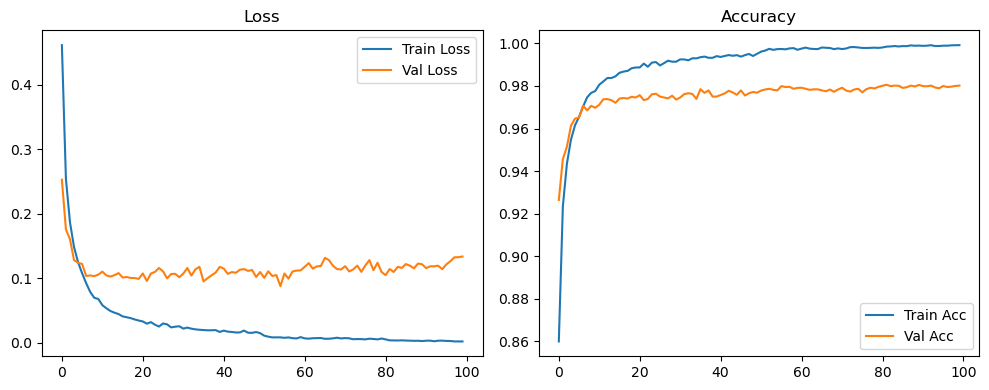

🚀 Running: batch128_lr0.01_0.005_0.002_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.6789, Acc: 0.7837 | Val Loss: 0.3178, Acc: 0.9050


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.4055, Acc: 0.8801 | Val Loss: 0.2265, Acc: 0.9328


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.3154, Acc: 0.9055 | Val Loss: 0.2004, Acc: 0.9405


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2606, Acc: 0.9223 | Val Loss: 0.1570, Acc: 0.9513


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.2290, Acc: 0.9313 | Val Loss: 0.1444, Acc: 0.9549


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.2054, Acc: 0.9381 | Val Loss: 0.1333, Acc: 0.9594


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1861, Acc: 0.9425 | Val Loss: 0.1304, Acc: 0.9622


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1687, Acc: 0.9490 | Val Loss: 0.1202, Acc: 0.9639


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1648, Acc: 0.9487 | Val Loss: 0.1177, Acc: 0.9665


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1546, Acc: 0.9538 | Val Loss: 0.1152, Acc: 0.9664


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1453, Acc: 0.9553 | Val Loss: 0.1096, Acc: 0.9682


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1375, Acc: 0.9576 | Val Loss: 0.1074, Acc: 0.9701


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1346, Acc: 0.9576 | Val Loss: 0.0981, Acc: 0.9712


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1258, Acc: 0.9610 | Val Loss: 0.1064, Acc: 0.9683


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1200, Acc: 0.9627 | Val Loss: 0.0959, Acc: 0.9720


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1197, Acc: 0.9636 | Val Loss: 0.1012, Acc: 0.9703


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1160, Acc: 0.9638 | Val Loss: 0.0960, Acc: 0.9714


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1071, Acc: 0.9662 | Val Loss: 0.0986, Acc: 0.9723


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1081, Acc: 0.9665 | Val Loss: 0.0941, Acc: 0.9738


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1012, Acc: 0.9678 | Val Loss: 0.0932, Acc: 0.9732


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0993, Acc: 0.9690 | Val Loss: 0.0964, Acc: 0.9726


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0985, Acc: 0.9692 | Val Loss: 0.0968, Acc: 0.9742


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0962, Acc: 0.9702 | Val Loss: 0.0928, Acc: 0.9742


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0942, Acc: 0.9705 | Val Loss: 0.0936, Acc: 0.9726


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0942, Acc: 0.9706 | Val Loss: 0.0940, Acc: 0.9734


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0900, Acc: 0.9723 | Val Loss: 0.0931, Acc: 0.9738


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0881, Acc: 0.9729 | Val Loss: 0.0939, Acc: 0.9749


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0843, Acc: 0.9732 | Val Loss: 0.1018, Acc: 0.9734


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0822, Acc: 0.9730 | Val Loss: 0.0922, Acc: 0.9739


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0822, Acc: 0.9750 | Val Loss: 0.0887, Acc: 0.9744


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0798, Acc: 0.9744 | Val Loss: 0.0918, Acc: 0.9752


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0772, Acc: 0.9762 | Val Loss: 0.0908, Acc: 0.9750


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0770, Acc: 0.9754 | Val Loss: 0.0910, Acc: 0.9742


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0744, Acc: 0.9767 | Val Loss: 0.0904, Acc: 0.9758


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0760, Acc: 0.9766 | Val Loss: 0.0899, Acc: 0.9756


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0733, Acc: 0.9768 | Val Loss: 0.0883, Acc: 0.9762


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0754, Acc: 0.9772 | Val Loss: 0.0850, Acc: 0.9752


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0733, Acc: 0.9771 | Val Loss: 0.0873, Acc: 0.9754


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0694, Acc: 0.9781 | Val Loss: 0.0999, Acc: 0.9758


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0692, Acc: 0.9784 | Val Loss: 0.0882, Acc: 0.9760


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0689, Acc: 0.9781 | Val Loss: 0.0928, Acc: 0.9756


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0626, Acc: 0.9802 | Val Loss: 0.0964, Acc: 0.9745


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0660, Acc: 0.9792 | Val Loss: 0.0988, Acc: 0.9759


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0646, Acc: 0.9799 | Val Loss: 0.0930, Acc: 0.9757


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0633, Acc: 0.9801 | Val Loss: 0.0880, Acc: 0.9756


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0655, Acc: 0.9795 | Val Loss: 0.0923, Acc: 0.9764


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0616, Acc: 0.9810 | Val Loss: 0.0872, Acc: 0.9765


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0613, Acc: 0.9804 | Val Loss: 0.0925, Acc: 0.9762


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0644, Acc: 0.9799 | Val Loss: 0.0897, Acc: 0.9763


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0588, Acc: 0.9815 | Val Loss: 0.1005, Acc: 0.9772


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0522, Acc: 0.9834 | Val Loss: 0.0933, Acc: 0.9779


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0512, Acc: 0.9834 | Val Loss: 0.0949, Acc: 0.9763


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0456, Acc: 0.9859 | Val Loss: 0.0999, Acc: 0.9757


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0458, Acc: 0.9856 | Val Loss: 0.0914, Acc: 0.9762


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0444, Acc: 0.9856 | Val Loss: 0.0938, Acc: 0.9763


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0452, Acc: 0.9856 | Val Loss: 0.0885, Acc: 0.9772


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0441, Acc: 0.9860 | Val Loss: 0.0974, Acc: 0.9764


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0423, Acc: 0.9866 | Val Loss: 0.0976, Acc: 0.9759


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0420, Acc: 0.9870 | Val Loss: 0.0977, Acc: 0.9770


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0425, Acc: 0.9862 | Val Loss: 0.1008, Acc: 0.9766


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0399, Acc: 0.9875 | Val Loss: 0.1018, Acc: 0.9758


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0398, Acc: 0.9875 | Val Loss: 0.0958, Acc: 0.9776


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0392, Acc: 0.9872 | Val Loss: 0.0867, Acc: 0.9779


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0401, Acc: 0.9877 | Val Loss: 0.0995, Acc: 0.9778


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0402, Acc: 0.9874 | Val Loss: 0.0965, Acc: 0.9773


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0428, Acc: 0.9863 | Val Loss: 0.1029, Acc: 0.9769


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0386, Acc: 0.9873 | Val Loss: 0.1031, Acc: 0.9774


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0391, Acc: 0.9874 | Val Loss: 0.0978, Acc: 0.9767


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0380, Acc: 0.9873 | Val Loss: 0.1022, Acc: 0.9778


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0374, Acc: 0.9883 | Val Loss: 0.0960, Acc: 0.9768


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0399, Acc: 0.9871 | Val Loss: 0.1023, Acc: 0.9774


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0374, Acc: 0.9880 | Val Loss: 0.0986, Acc: 0.9774


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0390, Acc: 0.9880 | Val Loss: 0.1061, Acc: 0.9766


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0375, Acc: 0.9880 | Val Loss: 0.0909, Acc: 0.9781


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0368, Acc: 0.9885 | Val Loss: 0.1006, Acc: 0.9777


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0361, Acc: 0.9887 | Val Loss: 0.0915, Acc: 0.9772


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0356, Acc: 0.9886 | Val Loss: 0.0953, Acc: 0.9768


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0361, Acc: 0.9883 | Val Loss: 0.0962, Acc: 0.9766


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0356, Acc: 0.9887 | Val Loss: 0.1006, Acc: 0.9773


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0341, Acc: 0.9886 | Val Loss: 0.1081, Acc: 0.9758


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0321, Acc: 0.9898 | Val Loss: 0.1031, Acc: 0.9763


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0309, Acc: 0.9899 | Val Loss: 0.1054, Acc: 0.9768


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0321, Acc: 0.9901 | Val Loss: 0.1045, Acc: 0.9764


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0299, Acc: 0.9905 | Val Loss: 0.1051, Acc: 0.9763


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0338, Acc: 0.9892 | Val Loss: 0.0947, Acc: 0.9758


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0289, Acc: 0.9907 | Val Loss: 0.0991, Acc: 0.9762


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0276, Acc: 0.9910 | Val Loss: 0.1040, Acc: 0.9764


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0280, Acc: 0.9911 | Val Loss: 0.0984, Acc: 0.9774


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0270, Acc: 0.9907 | Val Loss: 0.1060, Acc: 0.9765


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0257, Acc: 0.9914 | Val Loss: 0.1024, Acc: 0.9776


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0270, Acc: 0.9916 | Val Loss: 0.1026, Acc: 0.9773


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0264, Acc: 0.9918 | Val Loss: 0.1003, Acc: 0.9772


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0269, Acc: 0.9916 | Val Loss: 0.1001, Acc: 0.9770


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0271, Acc: 0.9916 | Val Loss: 0.1073, Acc: 0.9771


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0250, Acc: 0.9922 | Val Loss: 0.1057, Acc: 0.9765


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0275, Acc: 0.9909 | Val Loss: 0.1027, Acc: 0.9769


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0251, Acc: 0.9924 | Val Loss: 0.0990, Acc: 0.9771


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0246, Acc: 0.9913 | Val Loss: 0.1022, Acc: 0.9773


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0271, Acc: 0.9914 | Val Loss: 0.1081, Acc: 0.9762


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0251, Acc: 0.9918 | Val Loss: 0.1105, Acc: 0.9765


Final Test Loss: 0.1025 Accuracy: 0.9794


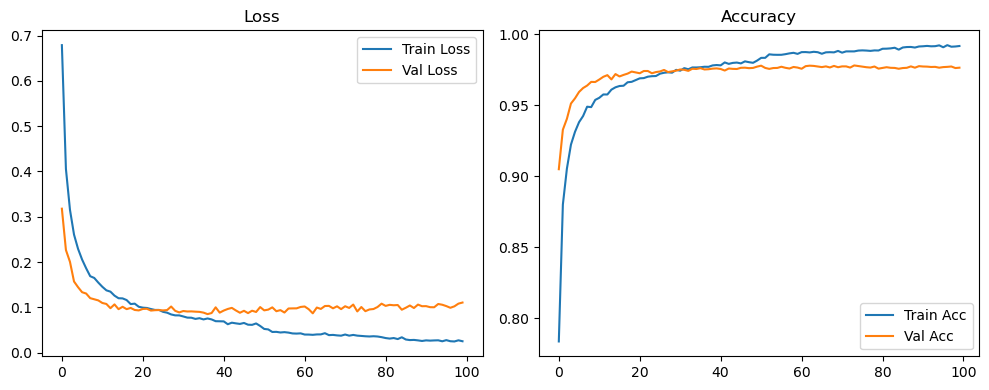

🚀 Running: batch128_lr0.01_0.005_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3691, Acc: 0.8895 | Val Loss: 0.2302, Acc: 0.9301


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1677, Acc: 0.9495 | Val Loss: 0.1512, Acc: 0.9537


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1010, Acc: 0.9683 | Val Loss: 0.1382, Acc: 0.9588


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0781, Acc: 0.9741 | Val Loss: 0.1104, Acc: 0.9699


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0568, Acc: 0.9816 | Val Loss: 0.1523, Acc: 0.9584


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0459, Acc: 0.9845 | Val Loss: 0.1280, Acc: 0.9651


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0364, Acc: 0.9884 | Val Loss: 0.1243, Acc: 0.9675


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0313, Acc: 0.9901 | Val Loss: 0.1211, Acc: 0.9673


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0256, Acc: 0.9914 | Val Loss: 0.1422, Acc: 0.9650


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0295, Acc: 0.9903 | Val Loss: 0.1171, Acc: 0.9704


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0226, Acc: 0.9925 | Val Loss: 0.1428, Acc: 0.9664


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9931 | Val Loss: 0.2269, Acc: 0.9477


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9926 | Val Loss: 0.1519, Acc: 0.9682


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0191, Acc: 0.9934 | Val Loss: 0.1530, Acc: 0.9671


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9939 | Val Loss: 0.1644, Acc: 0.9644


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9945 | Val Loss: 0.1431, Acc: 0.9718


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0172, Acc: 0.9940 | Val Loss: 0.1430, Acc: 0.9699


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9955 | Val Loss: 0.1441, Acc: 0.9716


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9951 | Val Loss: 0.1446, Acc: 0.9716


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9962 | Val Loss: 0.1446, Acc: 0.9715


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9954 | Val Loss: 0.1440, Acc: 0.9690


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9963 | Val Loss: 0.1350, Acc: 0.9728


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9962 | Val Loss: 0.1297, Acc: 0.9730


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9966 | Val Loss: 0.1927, Acc: 0.9665


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9957 | Val Loss: 0.1317, Acc: 0.9738


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9965 | Val Loss: 0.1532, Acc: 0.9667


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9965 | Val Loss: 0.2010, Acc: 0.9616


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9965 | Val Loss: 0.1353, Acc: 0.9730


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9969 | Val Loss: 0.1320, Acc: 0.9730


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9967 | Val Loss: 0.1610, Acc: 0.9647


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9972 | Val Loss: 0.1868, Acc: 0.9672


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.1626, Acc: 0.9675


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9971 | Val Loss: 0.1505, Acc: 0.9681


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.1493, Acc: 0.9759


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9973 | Val Loss: 0.1158, Acc: 0.9742


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.1520, Acc: 0.9705


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.1455, Acc: 0.9747


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9973 | Val Loss: 0.1426, Acc: 0.9738


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.1497, Acc: 0.9729


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.1357, Acc: 0.9720


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.1417, Acc: 0.9746


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.1185, Acc: 0.9757


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.1475, Acc: 0.9755


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9973 | Val Loss: 0.1838, Acc: 0.9684


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.1345, Acc: 0.9702


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9982 | Val Loss: 0.1677, Acc: 0.9738


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.1984, Acc: 0.9664


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9984 | Val Loss: 0.1489, Acc: 0.9744


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.1412, Acc: 0.9746


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.1881, Acc: 0.9700


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.1582, Acc: 0.9755


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1311, Acc: 0.9768


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.1631, Acc: 0.9760


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.1510, Acc: 0.9774


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1677, Acc: 0.9752


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1446, Acc: 0.9748


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1528, Acc: 0.9764


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1635, Acc: 0.9763


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1642, Acc: 0.9770


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1322, Acc: 0.9768


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1725, Acc: 0.9754


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1295, Acc: 0.9774


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1618, Acc: 0.9754


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1201, Acc: 0.9765


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1643, Acc: 0.9764


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1775, Acc: 0.9770


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1465, Acc: 0.9762


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.1694, Acc: 0.9762


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1601, Acc: 0.9776


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1901, Acc: 0.9760


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1359, Acc: 0.9764


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1558, Acc: 0.9779


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1828, Acc: 0.9774


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1479, Acc: 0.9774


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1653, Acc: 0.9759


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1790, Acc: 0.9766


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1363, Acc: 0.9777


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1800, Acc: 0.9782


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1488, Acc: 0.9783


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9995 | Val Loss: 0.1807, Acc: 0.9757


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1504, Acc: 0.9777


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1553, Acc: 0.9773


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1566, Acc: 0.9778


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1629, Acc: 0.9777


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1659, Acc: 0.9767


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1680, Acc: 0.9774


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1626, Acc: 0.9784


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1690, Acc: 0.9787


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1767, Acc: 0.9778


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1802, Acc: 0.9781


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1914, Acc: 0.9779


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1962, Acc: 0.9781


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2018, Acc: 0.9779


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1951, Acc: 0.9788


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2056, Acc: 0.9783


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1976, Acc: 0.9780


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.2046, Acc: 0.9781


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2049, Acc: 0.9784


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2092, Acc: 0.9786


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2079, Acc: 0.9788


Final Test Loss: 0.1942 Accuracy: 0.9798


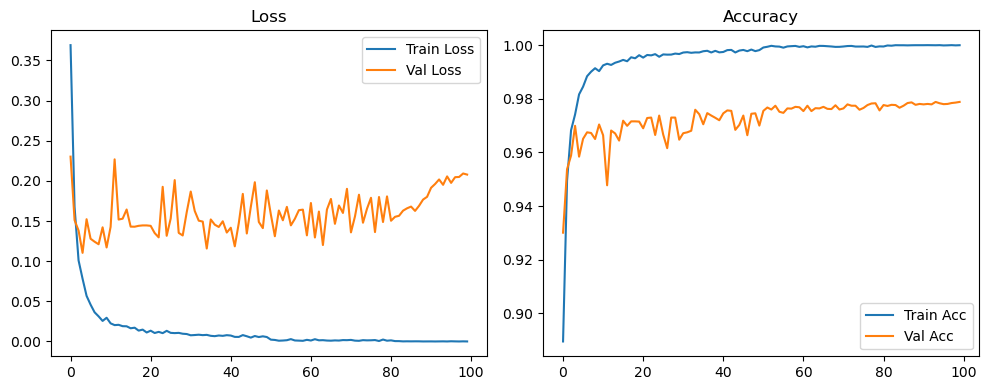

🚀 Running: batch128_lr0.01_0.005_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4610, Acc: 0.8600 | Val Loss: 0.2527, Acc: 0.9264


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2539, Acc: 0.9235 | Val Loss: 0.1758, Acc: 0.9457


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1869, Acc: 0.9435 | Val Loss: 0.1606, Acc: 0.9514


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1487, Acc: 0.9547 | Val Loss: 0.1282, Acc: 0.9613


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1250, Acc: 0.9615 | Val Loss: 0.1241, Acc: 0.9647


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1079, Acc: 0.9655 | Val Loss: 0.1223, Acc: 0.9651


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0926, Acc: 0.9703 | Val Loss: 0.1038, Acc: 0.9708


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0790, Acc: 0.9747 | Val Loss: 0.1045, Acc: 0.9685


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0700, Acc: 0.9768 | Val Loss: 0.1034, Acc: 0.9707


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0681, Acc: 0.9776 | Val Loss: 0.1058, Acc: 0.9698


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0585, Acc: 0.9806 | Val Loss: 0.1104, Acc: 0.9712


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0537, Acc: 0.9821 | Val Loss: 0.1046, Acc: 0.9738


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0495, Acc: 0.9837 | Val Loss: 0.1028, Acc: 0.9738


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0469, Acc: 0.9837 | Val Loss: 0.1050, Acc: 0.9733


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0448, Acc: 0.9845 | Val Loss: 0.1082, Acc: 0.9721


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0412, Acc: 0.9862 | Val Loss: 0.1014, Acc: 0.9741


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0398, Acc: 0.9868 | Val Loss: 0.1021, Acc: 0.9743


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0385, Acc: 0.9871 | Val Loss: 0.1007, Acc: 0.9741


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0364, Acc: 0.9883 | Val Loss: 0.1004, Acc: 0.9749


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0347, Acc: 0.9887 | Val Loss: 0.0993, Acc: 0.9746


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0333, Acc: 0.9887 | Val Loss: 0.1076, Acc: 0.9757


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0299, Acc: 0.9905 | Val Loss: 0.0959, Acc: 0.9733


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0323, Acc: 0.9890 | Val Loss: 0.1074, Acc: 0.9739


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0283, Acc: 0.9910 | Val Loss: 0.1100, Acc: 0.9761


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0254, Acc: 0.9912 | Val Loss: 0.1161, Acc: 0.9763


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0302, Acc: 0.9896 | Val Loss: 0.1109, Acc: 0.9750


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0288, Acc: 0.9907 | Val Loss: 0.1000, Acc: 0.9746


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9919 | Val Loss: 0.1067, Acc: 0.9742


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9914 | Val Loss: 0.1071, Acc: 0.9754


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0259, Acc: 0.9914 | Val Loss: 0.1018, Acc: 0.9736


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9925 | Val Loss: 0.1073, Acc: 0.9746


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9925 | Val Loss: 0.1161, Acc: 0.9762


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0221, Acc: 0.9920 | Val Loss: 0.1043, Acc: 0.9766


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0211, Acc: 0.9930 | Val Loss: 0.1140, Acc: 0.9762


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9930 | Val Loss: 0.1178, Acc: 0.9739


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0200, Acc: 0.9935 | Val Loss: 0.0952, Acc: 0.9785


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9938 | Val Loss: 0.1004, Acc: 0.9768


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9932 | Val Loss: 0.1048, Acc: 0.9779


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9932 | Val Loss: 0.1090, Acc: 0.9750


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9940 | Val Loss: 0.1178, Acc: 0.9750


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0191, Acc: 0.9936 | Val Loss: 0.1152, Acc: 0.9758


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9941 | Val Loss: 0.1069, Acc: 0.9765


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9945 | Val Loss: 0.1098, Acc: 0.9778


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9942 | Val Loss: 0.1087, Acc: 0.9769


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9945 | Val Loss: 0.1133, Acc: 0.9758


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0192, Acc: 0.9938 | Val Loss: 0.1144, Acc: 0.9779


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9945 | Val Loss: 0.1116, Acc: 0.9755


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9950 | Val Loss: 0.1130, Acc: 0.9766


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9941 | Val Loss: 0.1022, Acc: 0.9772


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9951 | Val Loss: 0.1098, Acc: 0.9768


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9961 | Val Loss: 0.1008, Acc: 0.9778


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9966 | Val Loss: 0.1109, Acc: 0.9783


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9974 | Val Loss: 0.1037, Acc: 0.9787


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9970 | Val Loss: 0.1050, Acc: 0.9782


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9973 | Val Loss: 0.0880, Acc: 0.9779


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.1075, Acc: 0.9799


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.0995, Acc: 0.9795


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.1107, Acc: 0.9796


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1121, Acc: 0.9787


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.1123, Acc: 0.9791


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.1179, Acc: 0.9792


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9980 | Val Loss: 0.1237, Acc: 0.9787


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.1151, Acc: 0.9782


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.1185, Acc: 0.9784


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9973 | Val Loss: 0.1191, Acc: 0.9784


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.1318, Acc: 0.9779


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.1282, Acc: 0.9775


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.1196, Acc: 0.9783


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.1143, Acc: 0.9772


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.1139, Acc: 0.9783


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9973 | Val Loss: 0.1189, Acc: 0.9792


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.1107, Acc: 0.9778


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1139, Acc: 0.9773


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9983 | Val Loss: 0.1197, Acc: 0.9783


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1101, Acc: 0.9787


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9979 | Val Loss: 0.1200, Acc: 0.9770


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.1282, Acc: 0.9785


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.1126, Acc: 0.9792


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9980 | Val Loss: 0.1242, Acc: 0.9788


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.1100, Acc: 0.9796


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.1057, Acc: 0.9800


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.1118, Acc: 0.9809


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.1136, Acc: 0.9802


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1153, Acc: 0.9802


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1155, Acc: 0.9806


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1210, Acc: 0.9797


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1166, Acc: 0.9798


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1148, Acc: 0.9802


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1226, Acc: 0.9806


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9988 | Val Loss: 0.1173, Acc: 0.9810


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1131, Acc: 0.9808


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1135, Acc: 0.9803


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.1128, Acc: 0.9803


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1170, Acc: 0.9805


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1094, Acc: 0.9800


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1180, Acc: 0.9805


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1192, Acc: 0.9810


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1281, Acc: 0.9803


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.1270, Acc: 0.9808


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1282, Acc: 0.9809


Final Test Loss: 0.1277 Accuracy: 0.9819


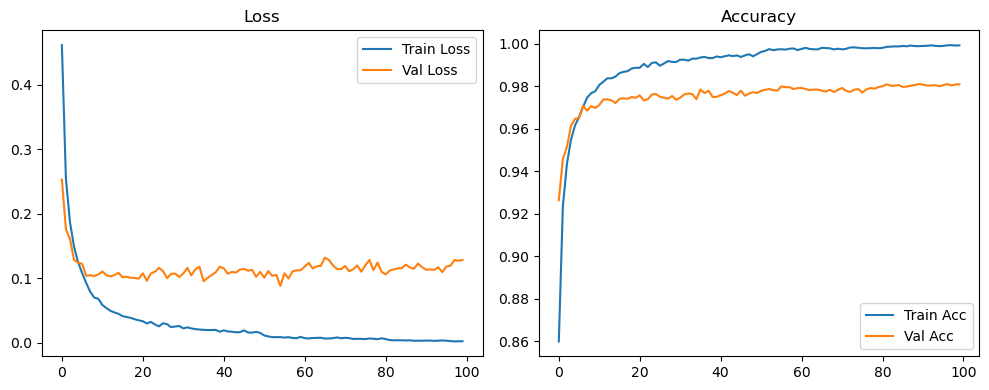

🚀 Running: batch128_lr0.01_0.005_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.6789, Acc: 0.7837 | Val Loss: 0.3178, Acc: 0.9050


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.4055, Acc: 0.8801 | Val Loss: 0.2265, Acc: 0.9328


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.3154, Acc: 0.9055 | Val Loss: 0.2004, Acc: 0.9405


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2606, Acc: 0.9223 | Val Loss: 0.1570, Acc: 0.9513


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.2290, Acc: 0.9313 | Val Loss: 0.1444, Acc: 0.9549


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.2054, Acc: 0.9381 | Val Loss: 0.1333, Acc: 0.9594


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1861, Acc: 0.9425 | Val Loss: 0.1304, Acc: 0.9622


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1687, Acc: 0.9490 | Val Loss: 0.1202, Acc: 0.9639


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1648, Acc: 0.9487 | Val Loss: 0.1177, Acc: 0.9665


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1546, Acc: 0.9538 | Val Loss: 0.1152, Acc: 0.9664


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1453, Acc: 0.9553 | Val Loss: 0.1096, Acc: 0.9682


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1375, Acc: 0.9576 | Val Loss: 0.1074, Acc: 0.9701


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1346, Acc: 0.9576 | Val Loss: 0.0981, Acc: 0.9712


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1258, Acc: 0.9610 | Val Loss: 0.1064, Acc: 0.9683


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1200, Acc: 0.9627 | Val Loss: 0.0959, Acc: 0.9720


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1197, Acc: 0.9636 | Val Loss: 0.1012, Acc: 0.9703


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1160, Acc: 0.9638 | Val Loss: 0.0960, Acc: 0.9714


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1071, Acc: 0.9662 | Val Loss: 0.0986, Acc: 0.9723


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1081, Acc: 0.9665 | Val Loss: 0.0941, Acc: 0.9738


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1012, Acc: 0.9678 | Val Loss: 0.0932, Acc: 0.9732


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0993, Acc: 0.9690 | Val Loss: 0.0964, Acc: 0.9726


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0985, Acc: 0.9692 | Val Loss: 0.0968, Acc: 0.9742


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0962, Acc: 0.9702 | Val Loss: 0.0928, Acc: 0.9742


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0942, Acc: 0.9705 | Val Loss: 0.0936, Acc: 0.9726


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0942, Acc: 0.9706 | Val Loss: 0.0940, Acc: 0.9734


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0900, Acc: 0.9723 | Val Loss: 0.0931, Acc: 0.9738


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0881, Acc: 0.9729 | Val Loss: 0.0939, Acc: 0.9749


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0843, Acc: 0.9732 | Val Loss: 0.1018, Acc: 0.9734


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0822, Acc: 0.9730 | Val Loss: 0.0922, Acc: 0.9739


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0822, Acc: 0.9750 | Val Loss: 0.0887, Acc: 0.9744


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0798, Acc: 0.9744 | Val Loss: 0.0918, Acc: 0.9752


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0772, Acc: 0.9762 | Val Loss: 0.0908, Acc: 0.9750


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0770, Acc: 0.9754 | Val Loss: 0.0910, Acc: 0.9742


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0744, Acc: 0.9767 | Val Loss: 0.0904, Acc: 0.9758


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0760, Acc: 0.9766 | Val Loss: 0.0899, Acc: 0.9756


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0733, Acc: 0.9768 | Val Loss: 0.0883, Acc: 0.9762


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0754, Acc: 0.9772 | Val Loss: 0.0850, Acc: 0.9752


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0733, Acc: 0.9771 | Val Loss: 0.0873, Acc: 0.9754


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0694, Acc: 0.9781 | Val Loss: 0.0999, Acc: 0.9758


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0692, Acc: 0.9784 | Val Loss: 0.0882, Acc: 0.9760


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0689, Acc: 0.9781 | Val Loss: 0.0928, Acc: 0.9756


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0626, Acc: 0.9802 | Val Loss: 0.0964, Acc: 0.9745


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0660, Acc: 0.9792 | Val Loss: 0.0988, Acc: 0.9759


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0646, Acc: 0.9799 | Val Loss: 0.0930, Acc: 0.9757


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0633, Acc: 0.9801 | Val Loss: 0.0880, Acc: 0.9756


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0655, Acc: 0.9795 | Val Loss: 0.0923, Acc: 0.9764


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0616, Acc: 0.9810 | Val Loss: 0.0872, Acc: 0.9765


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0613, Acc: 0.9804 | Val Loss: 0.0925, Acc: 0.9762


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0644, Acc: 0.9799 | Val Loss: 0.0897, Acc: 0.9763


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0588, Acc: 0.9815 | Val Loss: 0.1005, Acc: 0.9772


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0522, Acc: 0.9834 | Val Loss: 0.0933, Acc: 0.9779


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0512, Acc: 0.9834 | Val Loss: 0.0949, Acc: 0.9763


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0456, Acc: 0.9859 | Val Loss: 0.0999, Acc: 0.9757


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0458, Acc: 0.9856 | Val Loss: 0.0914, Acc: 0.9762


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0444, Acc: 0.9856 | Val Loss: 0.0938, Acc: 0.9763


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0452, Acc: 0.9856 | Val Loss: 0.0885, Acc: 0.9772


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0441, Acc: 0.9860 | Val Loss: 0.0974, Acc: 0.9764


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0423, Acc: 0.9866 | Val Loss: 0.0976, Acc: 0.9759


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0420, Acc: 0.9870 | Val Loss: 0.0977, Acc: 0.9770


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0425, Acc: 0.9862 | Val Loss: 0.1008, Acc: 0.9766


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0399, Acc: 0.9875 | Val Loss: 0.1018, Acc: 0.9758


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0398, Acc: 0.9875 | Val Loss: 0.0958, Acc: 0.9776


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0392, Acc: 0.9872 | Val Loss: 0.0867, Acc: 0.9779


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0401, Acc: 0.9877 | Val Loss: 0.0995, Acc: 0.9778


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0402, Acc: 0.9874 | Val Loss: 0.0965, Acc: 0.9773


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0428, Acc: 0.9863 | Val Loss: 0.1029, Acc: 0.9769


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0386, Acc: 0.9873 | Val Loss: 0.1031, Acc: 0.9774


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0391, Acc: 0.9874 | Val Loss: 0.0978, Acc: 0.9767


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0380, Acc: 0.9873 | Val Loss: 0.1022, Acc: 0.9778


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0374, Acc: 0.9883 | Val Loss: 0.0960, Acc: 0.9768


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0399, Acc: 0.9871 | Val Loss: 0.1023, Acc: 0.9774


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0374, Acc: 0.9880 | Val Loss: 0.0986, Acc: 0.9774


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0390, Acc: 0.9880 | Val Loss: 0.1061, Acc: 0.9766


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0375, Acc: 0.9880 | Val Loss: 0.0909, Acc: 0.9781


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0368, Acc: 0.9885 | Val Loss: 0.1006, Acc: 0.9777


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0361, Acc: 0.9887 | Val Loss: 0.0915, Acc: 0.9772


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0356, Acc: 0.9886 | Val Loss: 0.0953, Acc: 0.9768


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0361, Acc: 0.9883 | Val Loss: 0.0962, Acc: 0.9766


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0356, Acc: 0.9887 | Val Loss: 0.1006, Acc: 0.9773


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0341, Acc: 0.9886 | Val Loss: 0.1081, Acc: 0.9758


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0319, Acc: 0.9899 | Val Loss: 0.1020, Acc: 0.9766


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0311, Acc: 0.9900 | Val Loss: 0.1032, Acc: 0.9762


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0320, Acc: 0.9900 | Val Loss: 0.1028, Acc: 0.9760


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0303, Acc: 0.9904 | Val Loss: 0.1007, Acc: 0.9764


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0341, Acc: 0.9891 | Val Loss: 0.0959, Acc: 0.9759


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0289, Acc: 0.9904 | Val Loss: 0.0982, Acc: 0.9768


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0274, Acc: 0.9915 | Val Loss: 0.1005, Acc: 0.9766


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0281, Acc: 0.9910 | Val Loss: 0.0979, Acc: 0.9772


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0271, Acc: 0.9910 | Val Loss: 0.1036, Acc: 0.9770


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0255, Acc: 0.9914 | Val Loss: 0.0999, Acc: 0.9775


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0267, Acc: 0.9917 | Val Loss: 0.1012, Acc: 0.9769


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0264, Acc: 0.9916 | Val Loss: 0.0993, Acc: 0.9770


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0264, Acc: 0.9914 | Val Loss: 0.1007, Acc: 0.9766


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0270, Acc: 0.9916 | Val Loss: 0.1016, Acc: 0.9775


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0246, Acc: 0.9924 | Val Loss: 0.1009, Acc: 0.9762


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0270, Acc: 0.9913 | Val Loss: 0.1001, Acc: 0.9777


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0252, Acc: 0.9921 | Val Loss: 0.1002, Acc: 0.9768


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0245, Acc: 0.9921 | Val Loss: 0.1013, Acc: 0.9772


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0265, Acc: 0.9917 | Val Loss: 0.1038, Acc: 0.9766


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0249, Acc: 0.9916 | Val Loss: 0.1063, Acc: 0.9768


Final Test Loss: 0.1004 Accuracy: 0.9801


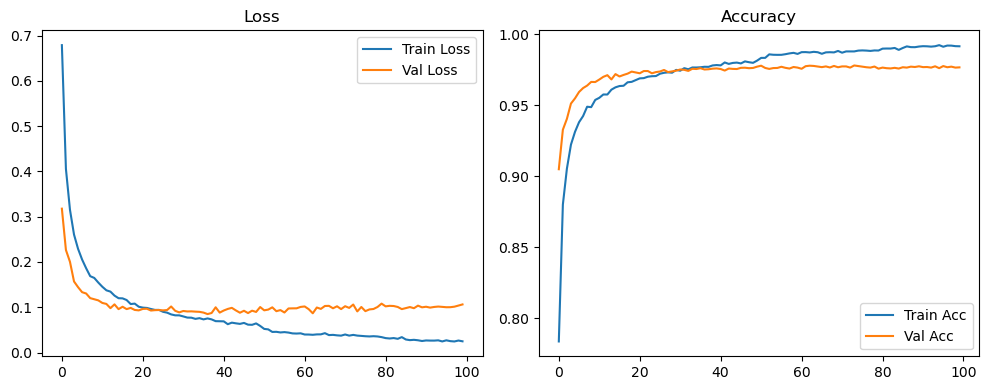

🚀 Running: batch128_lr0.01_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3691, Acc: 0.8895 | Val Loss: 0.2302, Acc: 0.9301


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1677, Acc: 0.9495 | Val Loss: 0.1512, Acc: 0.9537


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1010, Acc: 0.9683 | Val Loss: 0.1382, Acc: 0.9588


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0781, Acc: 0.9741 | Val Loss: 0.1104, Acc: 0.9699


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0568, Acc: 0.9816 | Val Loss: 0.1523, Acc: 0.9584


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0459, Acc: 0.9845 | Val Loss: 0.1280, Acc: 0.9651


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0364, Acc: 0.9884 | Val Loss: 0.1243, Acc: 0.9675


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0313, Acc: 0.9901 | Val Loss: 0.1211, Acc: 0.9673


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0256, Acc: 0.9914 | Val Loss: 0.1422, Acc: 0.9650


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0295, Acc: 0.9903 | Val Loss: 0.1171, Acc: 0.9704


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0226, Acc: 0.9925 | Val Loss: 0.1428, Acc: 0.9664


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9931 | Val Loss: 0.2269, Acc: 0.9477


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9926 | Val Loss: 0.1519, Acc: 0.9682


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0191, Acc: 0.9934 | Val Loss: 0.1530, Acc: 0.9671


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9939 | Val Loss: 0.1644, Acc: 0.9644


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9945 | Val Loss: 0.1431, Acc: 0.9718


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0172, Acc: 0.9940 | Val Loss: 0.1430, Acc: 0.9699


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9955 | Val Loss: 0.1441, Acc: 0.9716


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9951 | Val Loss: 0.1446, Acc: 0.9716


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9962 | Val Loss: 0.1446, Acc: 0.9715


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9954 | Val Loss: 0.1440, Acc: 0.9690


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9963 | Val Loss: 0.1350, Acc: 0.9728


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9962 | Val Loss: 0.1297, Acc: 0.9730


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9966 | Val Loss: 0.1927, Acc: 0.9665


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9957 | Val Loss: 0.1317, Acc: 0.9738


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9965 | Val Loss: 0.1532, Acc: 0.9667


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9965 | Val Loss: 0.2010, Acc: 0.9616


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9965 | Val Loss: 0.1353, Acc: 0.9730


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9969 | Val Loss: 0.1320, Acc: 0.9730


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9967 | Val Loss: 0.1610, Acc: 0.9647


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9972 | Val Loss: 0.1868, Acc: 0.9672


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.1626, Acc: 0.9675


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9971 | Val Loss: 0.1505, Acc: 0.9681


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.1493, Acc: 0.9759


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9973 | Val Loss: 0.1158, Acc: 0.9742


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.1520, Acc: 0.9705


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.1455, Acc: 0.9747


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9973 | Val Loss: 0.1426, Acc: 0.9738


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.1497, Acc: 0.9729


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.1357, Acc: 0.9720


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.1417, Acc: 0.9746


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.1185, Acc: 0.9757


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.1475, Acc: 0.9755


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9973 | Val Loss: 0.1838, Acc: 0.9684


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.1345, Acc: 0.9702


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9982 | Val Loss: 0.1677, Acc: 0.9738


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.1984, Acc: 0.9664


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9984 | Val Loss: 0.1489, Acc: 0.9744


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.1412, Acc: 0.9746


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.1881, Acc: 0.9700


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9991 | Val Loss: 0.1357, Acc: 0.9772


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1488, Acc: 0.9782


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1576, Acc: 0.9777


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1670, Acc: 0.9781


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1691, Acc: 0.9778


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1787, Acc: 0.9779


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1669, Acc: 0.9782


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1794, Acc: 0.9787


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1961, Acc: 0.9777


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.2006, Acc: 0.9771


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.2082, Acc: 0.9767


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.1947, Acc: 0.9779


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.2068, Acc: 0.9776


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1991, Acc: 0.9782


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1842, Acc: 0.9778


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.1662, Acc: 0.9779


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1635, Acc: 0.9782


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1767, Acc: 0.9778


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1863, Acc: 0.9785


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1963, Acc: 0.9778


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.1885, Acc: 0.9772


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1767, Acc: 0.9787


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1688, Acc: 0.9791


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1803, Acc: 0.9794


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1857, Acc: 0.9796


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1867, Acc: 0.9785


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1964, Acc: 0.9786


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2045, Acc: 0.9784


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1984, Acc: 0.9772


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2039, Acc: 0.9778


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1942, Acc: 0.9782


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2048, Acc: 0.9792


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2024, Acc: 0.9781


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2007, Acc: 0.9789


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2067, Acc: 0.9774


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2023, Acc: 0.9771


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1987, Acc: 0.9775


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2021, Acc: 0.9787


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1999, Acc: 0.9778


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1950, Acc: 0.9780


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2068, Acc: 0.9774


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2055, Acc: 0.9785


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2069, Acc: 0.9781


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.2081, Acc: 0.9788


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2095, Acc: 0.9782


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2063, Acc: 0.9787


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2127, Acc: 0.9792


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2009, Acc: 0.9790


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2118, Acc: 0.9787


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1934, Acc: 0.9788


Final Test Loss: 0.1661 Accuracy: 0.9800


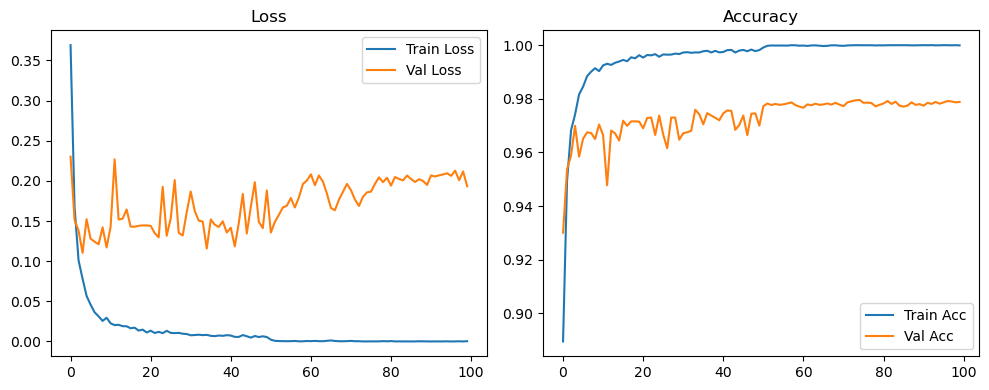

🚀 Running: batch128_lr0.01_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4610, Acc: 0.8600 | Val Loss: 0.2527, Acc: 0.9264


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2539, Acc: 0.9235 | Val Loss: 0.1758, Acc: 0.9457


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1869, Acc: 0.9435 | Val Loss: 0.1606, Acc: 0.9514


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1487, Acc: 0.9547 | Val Loss: 0.1282, Acc: 0.9613


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1250, Acc: 0.9615 | Val Loss: 0.1241, Acc: 0.9647


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1079, Acc: 0.9655 | Val Loss: 0.1223, Acc: 0.9651


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0926, Acc: 0.9703 | Val Loss: 0.1038, Acc: 0.9708


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0790, Acc: 0.9747 | Val Loss: 0.1045, Acc: 0.9685


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0700, Acc: 0.9768 | Val Loss: 0.1034, Acc: 0.9707


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0681, Acc: 0.9776 | Val Loss: 0.1058, Acc: 0.9698


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0585, Acc: 0.9806 | Val Loss: 0.1104, Acc: 0.9712


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0537, Acc: 0.9821 | Val Loss: 0.1046, Acc: 0.9738


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0495, Acc: 0.9837 | Val Loss: 0.1028, Acc: 0.9738


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0469, Acc: 0.9837 | Val Loss: 0.1050, Acc: 0.9733


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0448, Acc: 0.9845 | Val Loss: 0.1082, Acc: 0.9721


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0412, Acc: 0.9862 | Val Loss: 0.1014, Acc: 0.9741


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0398, Acc: 0.9868 | Val Loss: 0.1021, Acc: 0.9743


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0385, Acc: 0.9871 | Val Loss: 0.1007, Acc: 0.9741


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0364, Acc: 0.9883 | Val Loss: 0.1004, Acc: 0.9749


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0347, Acc: 0.9887 | Val Loss: 0.0993, Acc: 0.9746


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0333, Acc: 0.9887 | Val Loss: 0.1076, Acc: 0.9757


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0299, Acc: 0.9905 | Val Loss: 0.0959, Acc: 0.9733


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0323, Acc: 0.9890 | Val Loss: 0.1074, Acc: 0.9739


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0283, Acc: 0.9910 | Val Loss: 0.1100, Acc: 0.9761


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0254, Acc: 0.9912 | Val Loss: 0.1161, Acc: 0.9763


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0302, Acc: 0.9896 | Val Loss: 0.1109, Acc: 0.9750


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0288, Acc: 0.9907 | Val Loss: 0.1000, Acc: 0.9746


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9919 | Val Loss: 0.1067, Acc: 0.9742


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9914 | Val Loss: 0.1071, Acc: 0.9754


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0259, Acc: 0.9914 | Val Loss: 0.1018, Acc: 0.9736


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9925 | Val Loss: 0.1073, Acc: 0.9746


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9925 | Val Loss: 0.1161, Acc: 0.9762


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0221, Acc: 0.9920 | Val Loss: 0.1043, Acc: 0.9766


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0211, Acc: 0.9930 | Val Loss: 0.1140, Acc: 0.9762


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9930 | Val Loss: 0.1178, Acc: 0.9739


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0200, Acc: 0.9935 | Val Loss: 0.0952, Acc: 0.9785


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9938 | Val Loss: 0.1004, Acc: 0.9768


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9932 | Val Loss: 0.1048, Acc: 0.9779


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9932 | Val Loss: 0.1090, Acc: 0.9750


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9940 | Val Loss: 0.1178, Acc: 0.9750


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0191, Acc: 0.9936 | Val Loss: 0.1152, Acc: 0.9758


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9941 | Val Loss: 0.1069, Acc: 0.9765


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9945 | Val Loss: 0.1098, Acc: 0.9778


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9942 | Val Loss: 0.1087, Acc: 0.9769


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9945 | Val Loss: 0.1133, Acc: 0.9758


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0192, Acc: 0.9938 | Val Loss: 0.1144, Acc: 0.9779


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9945 | Val Loss: 0.1116, Acc: 0.9755


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9950 | Val Loss: 0.1130, Acc: 0.9766


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9941 | Val Loss: 0.1022, Acc: 0.9772


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9951 | Val Loss: 0.1098, Acc: 0.9768


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0109, Acc: 0.9962 | Val Loss: 0.1028, Acc: 0.9779


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9969 | Val Loss: 0.1114, Acc: 0.9786


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.1102, Acc: 0.9787


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9975 | Val Loss: 0.1159, Acc: 0.9798


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9978 | Val Loss: 0.1040, Acc: 0.9787


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.1087, Acc: 0.9794


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.1100, Acc: 0.9798


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.1168, Acc: 0.9798


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.1122, Acc: 0.9795


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1082, Acc: 0.9795


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.1217, Acc: 0.9793


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.1197, Acc: 0.9799


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.1209, Acc: 0.9799


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9983 | Val Loss: 0.1254, Acc: 0.9794


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1161, Acc: 0.9801


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1155, Acc: 0.9791


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1236, Acc: 0.9798


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1136, Acc: 0.9792


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1146, Acc: 0.9791


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9985 | Val Loss: 0.1245, Acc: 0.9797


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1160, Acc: 0.9798


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9985 | Val Loss: 0.1224, Acc: 0.9796


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.1202, Acc: 0.9800


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1244, Acc: 0.9795


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1181, Acc: 0.9800


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.1325, Acc: 0.9788


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1191, Acc: 0.9798


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1286, Acc: 0.9802


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1308, Acc: 0.9797


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.1223, Acc: 0.9804


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1188, Acc: 0.9799


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1192, Acc: 0.9802


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1246, Acc: 0.9802


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9987 | Val Loss: 0.1206, Acc: 0.9803


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1256, Acc: 0.9802


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1245, Acc: 0.9800


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1217, Acc: 0.9803


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.1194, Acc: 0.9800


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1333, Acc: 0.9799


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1261, Acc: 0.9808


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1199, Acc: 0.9808


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1254, Acc: 0.9802


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1232, Acc: 0.9800


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1226, Acc: 0.9798


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1248, Acc: 0.9807


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1248, Acc: 0.9805


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1266, Acc: 0.9798


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1310, Acc: 0.9804


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.1319, Acc: 0.9802


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1363, Acc: 0.9798


Final Test Loss: 0.1297 Accuracy: 0.9811


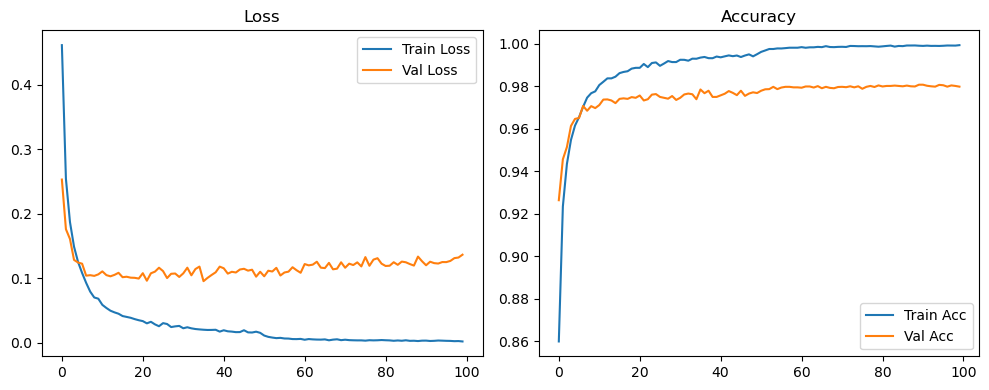

🚀 Running: batch128_lr0.01_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.6789, Acc: 0.7837 | Val Loss: 0.3178, Acc: 0.9050


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.4055, Acc: 0.8801 | Val Loss: 0.2265, Acc: 0.9328


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.3154, Acc: 0.9055 | Val Loss: 0.2004, Acc: 0.9405


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2606, Acc: 0.9223 | Val Loss: 0.1570, Acc: 0.9513


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.2290, Acc: 0.9313 | Val Loss: 0.1444, Acc: 0.9549


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.2054, Acc: 0.9381 | Val Loss: 0.1333, Acc: 0.9594


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1861, Acc: 0.9425 | Val Loss: 0.1304, Acc: 0.9622


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1687, Acc: 0.9490 | Val Loss: 0.1202, Acc: 0.9639


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1648, Acc: 0.9487 | Val Loss: 0.1177, Acc: 0.9665


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1546, Acc: 0.9538 | Val Loss: 0.1152, Acc: 0.9664


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1453, Acc: 0.9553 | Val Loss: 0.1096, Acc: 0.9682


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1375, Acc: 0.9576 | Val Loss: 0.1074, Acc: 0.9701


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1346, Acc: 0.9576 | Val Loss: 0.0981, Acc: 0.9712


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1258, Acc: 0.9610 | Val Loss: 0.1064, Acc: 0.9683


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1200, Acc: 0.9627 | Val Loss: 0.0959, Acc: 0.9720


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1197, Acc: 0.9636 | Val Loss: 0.1012, Acc: 0.9703


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1160, Acc: 0.9638 | Val Loss: 0.0960, Acc: 0.9714


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1071, Acc: 0.9662 | Val Loss: 0.0986, Acc: 0.9723


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1081, Acc: 0.9665 | Val Loss: 0.0941, Acc: 0.9738


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1012, Acc: 0.9678 | Val Loss: 0.0932, Acc: 0.9732


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0993, Acc: 0.9690 | Val Loss: 0.0964, Acc: 0.9726


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0985, Acc: 0.9692 | Val Loss: 0.0968, Acc: 0.9742


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0962, Acc: 0.9702 | Val Loss: 0.0928, Acc: 0.9742


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0942, Acc: 0.9705 | Val Loss: 0.0936, Acc: 0.9726


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0942, Acc: 0.9706 | Val Loss: 0.0940, Acc: 0.9734


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0900, Acc: 0.9723 | Val Loss: 0.0931, Acc: 0.9738


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0881, Acc: 0.9729 | Val Loss: 0.0939, Acc: 0.9749


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0843, Acc: 0.9732 | Val Loss: 0.1018, Acc: 0.9734


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0822, Acc: 0.9730 | Val Loss: 0.0922, Acc: 0.9739


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0822, Acc: 0.9750 | Val Loss: 0.0887, Acc: 0.9744


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0798, Acc: 0.9744 | Val Loss: 0.0918, Acc: 0.9752


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0772, Acc: 0.9762 | Val Loss: 0.0908, Acc: 0.9750


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0770, Acc: 0.9754 | Val Loss: 0.0910, Acc: 0.9742


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0744, Acc: 0.9767 | Val Loss: 0.0904, Acc: 0.9758


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0760, Acc: 0.9766 | Val Loss: 0.0899, Acc: 0.9756


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0733, Acc: 0.9768 | Val Loss: 0.0883, Acc: 0.9762


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0754, Acc: 0.9772 | Val Loss: 0.0850, Acc: 0.9752


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0733, Acc: 0.9771 | Val Loss: 0.0873, Acc: 0.9754


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0694, Acc: 0.9781 | Val Loss: 0.0999, Acc: 0.9758


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0692, Acc: 0.9784 | Val Loss: 0.0882, Acc: 0.9760


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0689, Acc: 0.9781 | Val Loss: 0.0928, Acc: 0.9756


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0626, Acc: 0.9802 | Val Loss: 0.0964, Acc: 0.9745


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0660, Acc: 0.9792 | Val Loss: 0.0988, Acc: 0.9759


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0646, Acc: 0.9799 | Val Loss: 0.0930, Acc: 0.9757


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0633, Acc: 0.9801 | Val Loss: 0.0880, Acc: 0.9756


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0655, Acc: 0.9795 | Val Loss: 0.0923, Acc: 0.9764


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0616, Acc: 0.9810 | Val Loss: 0.0872, Acc: 0.9765


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0613, Acc: 0.9804 | Val Loss: 0.0925, Acc: 0.9762


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0644, Acc: 0.9799 | Val Loss: 0.0897, Acc: 0.9763


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0588, Acc: 0.9815 | Val Loss: 0.1005, Acc: 0.9772


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0516, Acc: 0.9832 | Val Loss: 0.0919, Acc: 0.9776


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0511, Acc: 0.9834 | Val Loss: 0.0900, Acc: 0.9765


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0450, Acc: 0.9859 | Val Loss: 0.0953, Acc: 0.9760


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0446, Acc: 0.9859 | Val Loss: 0.0932, Acc: 0.9761


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0425, Acc: 0.9860 | Val Loss: 0.0905, Acc: 0.9770


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0424, Acc: 0.9864 | Val Loss: 0.0903, Acc: 0.9779


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0417, Acc: 0.9868 | Val Loss: 0.0942, Acc: 0.9765


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0402, Acc: 0.9873 | Val Loss: 0.0948, Acc: 0.9765


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0389, Acc: 0.9878 | Val Loss: 0.0929, Acc: 0.9772


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0397, Acc: 0.9875 | Val Loss: 0.0968, Acc: 0.9781


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0375, Acc: 0.9879 | Val Loss: 0.0963, Acc: 0.9775


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0378, Acc: 0.9880 | Val Loss: 0.0914, Acc: 0.9782


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0360, Acc: 0.9885 | Val Loss: 0.0892, Acc: 0.9783


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0372, Acc: 0.9885 | Val Loss: 0.0943, Acc: 0.9773


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0359, Acc: 0.9887 | Val Loss: 0.0972, Acc: 0.9770


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0389, Acc: 0.9879 | Val Loss: 0.0954, Acc: 0.9767


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0353, Acc: 0.9887 | Val Loss: 0.0972, Acc: 0.9779


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0351, Acc: 0.9885 | Val Loss: 0.0941, Acc: 0.9778


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0343, Acc: 0.9886 | Val Loss: 0.0974, Acc: 0.9778


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0345, Acc: 0.9890 | Val Loss: 0.0980, Acc: 0.9778


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0361, Acc: 0.9886 | Val Loss: 0.0999, Acc: 0.9782


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0339, Acc: 0.9891 | Val Loss: 0.0969, Acc: 0.9778


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0355, Acc: 0.9889 | Val Loss: 0.1008, Acc: 0.9774


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0337, Acc: 0.9891 | Val Loss: 0.0960, Acc: 0.9782


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0324, Acc: 0.9893 | Val Loss: 0.0967, Acc: 0.9782


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0337, Acc: 0.9895 | Val Loss: 0.0992, Acc: 0.9778


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0320, Acc: 0.9897 | Val Loss: 0.0949, Acc: 0.9768


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0330, Acc: 0.9893 | Val Loss: 0.1002, Acc: 0.9775


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0325, Acc: 0.9901 | Val Loss: 0.0980, Acc: 0.9782


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0306, Acc: 0.9899 | Val Loss: 0.1008, Acc: 0.9776


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0300, Acc: 0.9905 | Val Loss: 0.0999, Acc: 0.9778


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0303, Acc: 0.9900 | Val Loss: 0.1009, Acc: 0.9776


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0309, Acc: 0.9902 | Val Loss: 0.0999, Acc: 0.9777


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0293, Acc: 0.9905 | Val Loss: 0.1008, Acc: 0.9779


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0340, Acc: 0.9896 | Val Loss: 0.0938, Acc: 0.9769


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0292, Acc: 0.9905 | Val Loss: 0.0998, Acc: 0.9771


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0281, Acc: 0.9905 | Val Loss: 0.1000, Acc: 0.9779


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0289, Acc: 0.9907 | Val Loss: 0.0992, Acc: 0.9782


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0276, Acc: 0.9909 | Val Loss: 0.1027, Acc: 0.9773


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0265, Acc: 0.9910 | Val Loss: 0.0995, Acc: 0.9775


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0288, Acc: 0.9912 | Val Loss: 0.0978, Acc: 0.9773


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0275, Acc: 0.9915 | Val Loss: 0.0974, Acc: 0.9782


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0272, Acc: 0.9915 | Val Loss: 0.0983, Acc: 0.9768


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0280, Acc: 0.9907 | Val Loss: 0.1001, Acc: 0.9782


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0259, Acc: 0.9920 | Val Loss: 0.1001, Acc: 0.9778


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0287, Acc: 0.9904 | Val Loss: 0.0978, Acc: 0.9781


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0264, Acc: 0.9912 | Val Loss: 0.0973, Acc: 0.9780


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0262, Acc: 0.9912 | Val Loss: 0.0986, Acc: 0.9778


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0284, Acc: 0.9909 | Val Loss: 0.1009, Acc: 0.9779


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0272, Acc: 0.9912 | Val Loss: 0.0993, Acc: 0.9788


Final Test Loss: 0.0926 Accuracy: 0.9804


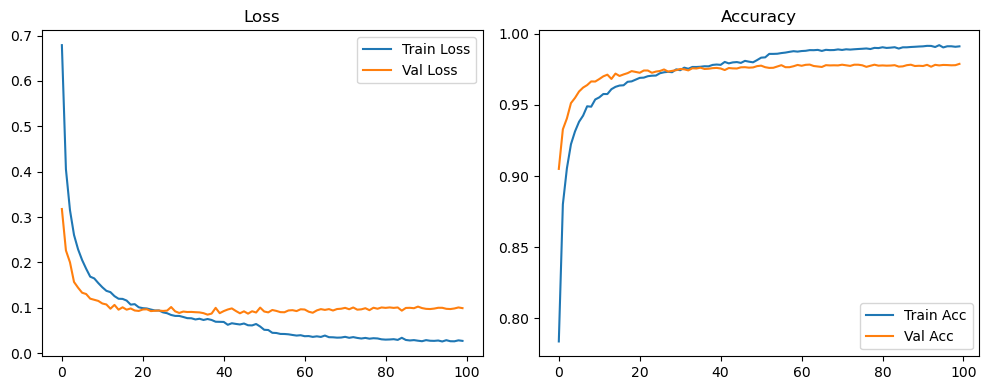

🚀 Running: batch128_lr0.005_0.005_0.005_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.3779, Acc: 0.8919 | Val Loss: 0.2248, Acc: 0.9309


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1645, Acc: 0.9502 | Val Loss: 0.1382, Acc: 0.9565


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0940, Acc: 0.9710 | Val Loss: 0.1197, Acc: 0.9642


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0675, Acc: 0.9779 | Val Loss: 0.1065, Acc: 0.9681


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0503, Acc: 0.9832 | Val Loss: 0.1318, Acc: 0.9627


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0334, Acc: 0.9888 | Val Loss: 0.1244, Acc: 0.9671


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0328, Acc: 0.9891 | Val Loss: 0.1225, Acc: 0.9677


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0258, Acc: 0.9914 | Val Loss: 0.1255, Acc: 0.9697


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0261, Acc: 0.9908 | Val Loss: 0.1196, Acc: 0.9713


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0227, Acc: 0.9920 | Val Loss: 0.1372, Acc: 0.9687


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0203, Acc: 0.9931 | Val Loss: 0.1347, Acc: 0.9691


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0181, Acc: 0.9938 | Val Loss: 0.1286, Acc: 0.9708


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0155, Acc: 0.9947 | Val Loss: 0.1466, Acc: 0.9688


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0203, Acc: 0.9930 | Val Loss: 0.1392, Acc: 0.9703


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0173, Acc: 0.9943 | Val Loss: 0.1595, Acc: 0.9689


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0172, Acc: 0.9946 | Val Loss: 0.1365, Acc: 0.9708


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9965 | Val Loss: 0.1290, Acc: 0.9730


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0143, Acc: 0.9953 | Val Loss: 0.1376, Acc: 0.9693


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0131, Acc: 0.9954 | Val Loss: 0.1684, Acc: 0.9673


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9957 | Val Loss: 0.1532, Acc: 0.9692


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9955 | Val Loss: 0.1216, Acc: 0.9725


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9968 | Val Loss: 0.1441, Acc: 0.9717


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.1355, Acc: 0.9730


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9966 | Val Loss: 0.1409, Acc: 0.9719


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9957 | Val Loss: 0.1386, Acc: 0.9726


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.1358, Acc: 0.9730


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.1292, Acc: 0.9723


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.1452, Acc: 0.9747


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9969 | Val Loss: 0.1335, Acc: 0.9730


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.1402, Acc: 0.9751


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9975 | Val Loss: 0.1429, Acc: 0.9739


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.1359, Acc: 0.9742


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.1573, Acc: 0.9712


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.1663, Acc: 0.9692


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.1253, Acc: 0.9745


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1628, Acc: 0.9723


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.1328, Acc: 0.9757


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.1427, Acc: 0.9732


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.1363, Acc: 0.9730


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.1413, Acc: 0.9737


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1632, Acc: 0.9725


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.1544, Acc: 0.9727


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.1312, Acc: 0.9769


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.1349, Acc: 0.9753


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.1480, Acc: 0.9751


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.1506, Acc: 0.9748


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.1365, Acc: 0.9774


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9981 | Val Loss: 0.1507, Acc: 0.9753


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9983 | Val Loss: 0.1508, Acc: 0.9760


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1492, Acc: 0.9743


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9978 | Val Loss: 0.1645, Acc: 0.9708


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1669, Acc: 0.9736


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.1563, Acc: 0.9732


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1577, Acc: 0.9712


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1422, Acc: 0.9712


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1672, Acc: 0.9730


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1411, Acc: 0.9763


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1547, Acc: 0.9732


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1447, Acc: 0.9756


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.1397, Acc: 0.9760


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1679, Acc: 0.9742


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.1581, Acc: 0.9742


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.1456, Acc: 0.9754


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1849, Acc: 0.9692


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1730, Acc: 0.9713


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9986 | Val Loss: 0.1670, Acc: 0.9727


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.1328, Acc: 0.9749


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1839, Acc: 0.9661


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.1211, Acc: 0.9746


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1610, Acc: 0.9762


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.1536, Acc: 0.9762


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1353, Acc: 0.9749


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.1499, Acc: 0.9753


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1437, Acc: 0.9710


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1881, Acc: 0.9728


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.1336, Acc: 0.9740


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1698, Acc: 0.9738


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.1552, Acc: 0.9756


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1577, Acc: 0.9718


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1626, Acc: 0.9762


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1500, Acc: 0.9752


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1602, Acc: 0.9747


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1753, Acc: 0.9713


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1513, Acc: 0.9763


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.1512, Acc: 0.9781


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1383, Acc: 0.9758


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.1388, Acc: 0.9759


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1543, Acc: 0.9761


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1682, Acc: 0.9749


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1586, Acc: 0.9746


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1501, Acc: 0.9771


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.1462, Acc: 0.9727


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1368, Acc: 0.9771


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1478, Acc: 0.9787


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.1787, Acc: 0.9727


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1601, Acc: 0.9746


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1475, Acc: 0.9768


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1397, Acc: 0.9771


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1288, Acc: 0.9764


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1498, Acc: 0.9756


Final Test Loss: 0.1319 Accuracy: 0.9774


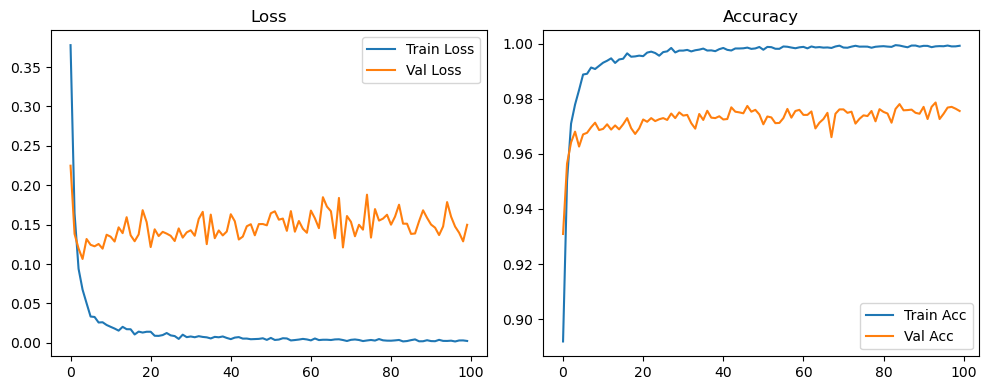

🚀 Running: batch128_lr0.005_0.005_0.005_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4857, Acc: 0.8566 | Val Loss: 0.2755, Acc: 0.9183


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2845, Acc: 0.9141 | Val Loss: 0.2048, Acc: 0.9390


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.2161, Acc: 0.9337 | Val Loss: 0.1857, Acc: 0.9448


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1762, Acc: 0.9469 | Val Loss: 0.1518, Acc: 0.9537


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1504, Acc: 0.9546 | Val Loss: 0.1371, Acc: 0.9604


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1283, Acc: 0.9598 | Val Loss: 0.1296, Acc: 0.9629


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1127, Acc: 0.9647 | Val Loss: 0.1192, Acc: 0.9662


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0966, Acc: 0.9691 | Val Loss: 0.1224, Acc: 0.9633


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0877, Acc: 0.9719 | Val Loss: 0.1177, Acc: 0.9692


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0820, Acc: 0.9729 | Val Loss: 0.1195, Acc: 0.9670


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0742, Acc: 0.9757 | Val Loss: 0.1106, Acc: 0.9709


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0665, Acc: 0.9789 | Val Loss: 0.1204, Acc: 0.9683


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0644, Acc: 0.9786 | Val Loss: 0.1136, Acc: 0.9708


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0585, Acc: 0.9805 | Val Loss: 0.1120, Acc: 0.9707


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0536, Acc: 0.9820 | Val Loss: 0.1315, Acc: 0.9674


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0512, Acc: 0.9830 | Val Loss: 0.1174, Acc: 0.9729


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0535, Acc: 0.9824 | Val Loss: 0.1137, Acc: 0.9722


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0499, Acc: 0.9841 | Val Loss: 0.1159, Acc: 0.9713


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0447, Acc: 0.9851 | Val Loss: 0.1122, Acc: 0.9723


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0422, Acc: 0.9857 | Val Loss: 0.1193, Acc: 0.9713


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0454, Acc: 0.9846 | Val Loss: 0.1236, Acc: 0.9712


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0389, Acc: 0.9864 | Val Loss: 0.1230, Acc: 0.9736


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0380, Acc: 0.9876 | Val Loss: 0.1248, Acc: 0.9709


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0362, Acc: 0.9879 | Val Loss: 0.1214, Acc: 0.9707


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0337, Acc: 0.9883 | Val Loss: 0.1221, Acc: 0.9732


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0364, Acc: 0.9879 | Val Loss: 0.1261, Acc: 0.9728


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0352, Acc: 0.9885 | Val Loss: 0.1263, Acc: 0.9726


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0338, Acc: 0.9888 | Val Loss: 0.1151, Acc: 0.9734


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0311, Acc: 0.9895 | Val Loss: 0.1204, Acc: 0.9728


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0315, Acc: 0.9895 | Val Loss: 0.1243, Acc: 0.9734


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0299, Acc: 0.9900 | Val Loss: 0.1150, Acc: 0.9731


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0309, Acc: 0.9900 | Val Loss: 0.1169, Acc: 0.9734


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0294, Acc: 0.9900 | Val Loss: 0.1189, Acc: 0.9738


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0278, Acc: 0.9908 | Val Loss: 0.1137, Acc: 0.9752


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0277, Acc: 0.9905 | Val Loss: 0.1274, Acc: 0.9741


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0232, Acc: 0.9919 | Val Loss: 0.1219, Acc: 0.9756


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0251, Acc: 0.9909 | Val Loss: 0.1340, Acc: 0.9723


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0287, Acc: 0.9906 | Val Loss: 0.1147, Acc: 0.9746


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0229, Acc: 0.9925 | Val Loss: 0.1235, Acc: 0.9746


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0217, Acc: 0.9923 | Val Loss: 0.1149, Acc: 0.9751


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0220, Acc: 0.9924 | Val Loss: 0.1152, Acc: 0.9739


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0199, Acc: 0.9929 | Val Loss: 0.1147, Acc: 0.9750


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0199, Acc: 0.9937 | Val Loss: 0.1157, Acc: 0.9741


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0219, Acc: 0.9928 | Val Loss: 0.1156, Acc: 0.9749


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0237, Acc: 0.9921 | Val Loss: 0.1180, Acc: 0.9728


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0212, Acc: 0.9932 | Val Loss: 0.1094, Acc: 0.9749


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0190, Acc: 0.9939 | Val Loss: 0.1127, Acc: 0.9758


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0188, Acc: 0.9938 | Val Loss: 0.1226, Acc: 0.9738


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0188, Acc: 0.9934 | Val Loss: 0.1174, Acc: 0.9752


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0180, Acc: 0.9940 | Val Loss: 0.1225, Acc: 0.9736


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0179, Acc: 0.9940 | Val Loss: 0.1197, Acc: 0.9747


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0180, Acc: 0.9938 | Val Loss: 0.1268, Acc: 0.9748


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0180, Acc: 0.9938 | Val Loss: 0.1217, Acc: 0.9738


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0187, Acc: 0.9934 | Val Loss: 0.1320, Acc: 0.9746


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9941 | Val Loss: 0.1233, Acc: 0.9764


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0192, Acc: 0.9933 | Val Loss: 0.1118, Acc: 0.9757


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0184, Acc: 0.9941 | Val Loss: 0.1152, Acc: 0.9767


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0143, Acc: 0.9952 | Val Loss: 0.1213, Acc: 0.9762


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0158, Acc: 0.9949 | Val Loss: 0.1166, Acc: 0.9771


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9938 | Val Loss: 0.1196, Acc: 0.9762


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0160, Acc: 0.9945 | Val Loss: 0.1210, Acc: 0.9742


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0148, Acc: 0.9948 | Val Loss: 0.1274, Acc: 0.9758


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0146, Acc: 0.9953 | Val Loss: 0.1162, Acc: 0.9766


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0146, Acc: 0.9950 | Val Loss: 0.1164, Acc: 0.9768


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0158, Acc: 0.9948 | Val Loss: 0.1298, Acc: 0.9748


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9951 | Val Loss: 0.1216, Acc: 0.9756


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0158, Acc: 0.9950 | Val Loss: 0.1255, Acc: 0.9754


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0144, Acc: 0.9950 | Val Loss: 0.1212, Acc: 0.9762


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9947 | Val Loss: 0.1180, Acc: 0.9759


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0139, Acc: 0.9952 | Val Loss: 0.1239, Acc: 0.9760


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9956 | Val Loss: 0.1218, Acc: 0.9758


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9954 | Val Loss: 0.1327, Acc: 0.9752


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9953 | Val Loss: 0.1208, Acc: 0.9761


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9957 | Val Loss: 0.1335, Acc: 0.9757


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0139, Acc: 0.9952 | Val Loss: 0.1159, Acc: 0.9758


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9955 | Val Loss: 0.1226, Acc: 0.9761


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9955 | Val Loss: 0.1292, Acc: 0.9775


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0138, Acc: 0.9952 | Val Loss: 0.1373, Acc: 0.9756


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9957 | Val Loss: 0.1278, Acc: 0.9762


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9959 | Val Loss: 0.1301, Acc: 0.9770


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0122, Acc: 0.9961 | Val Loss: 0.1133, Acc: 0.9771


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9955 | Val Loss: 0.1269, Acc: 0.9757


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9958 | Val Loss: 0.1193, Acc: 0.9749


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9960 | Val Loss: 0.1186, Acc: 0.9766


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9958 | Val Loss: 0.1339, Acc: 0.9748


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9960 | Val Loss: 0.1173, Acc: 0.9767


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9963 | Val Loss: 0.1402, Acc: 0.9750


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9959 | Val Loss: 0.1164, Acc: 0.9768


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9959 | Val Loss: 0.1107, Acc: 0.9761


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9964 | Val Loss: 0.1189, Acc: 0.9755


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9966 | Val Loss: 0.1327, Acc: 0.9758


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9965 | Val Loss: 0.1228, Acc: 0.9757


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9961 | Val Loss: 0.1080, Acc: 0.9769


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9959 | Val Loss: 0.1257, Acc: 0.9766


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9964 | Val Loss: 0.1192, Acc: 0.9771


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0139, Acc: 0.9953 | Val Loss: 0.1122, Acc: 0.9771


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9965 | Val Loss: 0.1272, Acc: 0.9761


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9968 | Val Loss: 0.1354, Acc: 0.9761


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9967 | Val Loss: 0.1257, Acc: 0.9765


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9962 | Val Loss: 0.1311, Acc: 0.9762


Final Test Loss: 0.1182 Accuracy: 0.9783


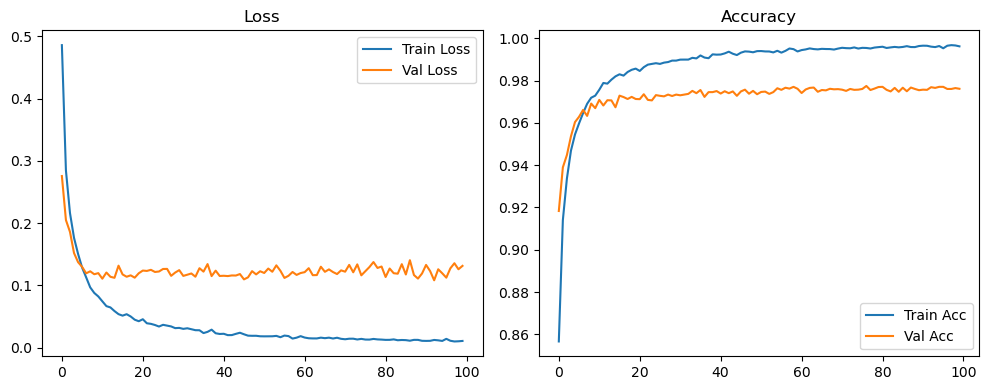

🚀 Running: batch128_lr0.005_0.005_0.005_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.7462, Acc: 0.7630 | Val Loss: 0.3201, Acc: 0.9038


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.4546, Acc: 0.8628 | Val Loss: 0.2700, Acc: 0.9207


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.3630, Acc: 0.8916 | Val Loss: 0.2326, Acc: 0.9316


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.3036, Acc: 0.9098 | Val Loss: 0.1887, Acc: 0.9427


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.2691, Acc: 0.9199 | Val Loss: 0.1674, Acc: 0.9501


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.2412, Acc: 0.9278 | Val Loss: 0.1545, Acc: 0.9526


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.2174, Acc: 0.9347 | Val Loss: 0.1421, Acc: 0.9589


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.1967, Acc: 0.9407 | Val Loss: 0.1407, Acc: 0.9588


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.1900, Acc: 0.9422 | Val Loss: 0.1253, Acc: 0.9641


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.1793, Acc: 0.9457 | Val Loss: 0.1255, Acc: 0.9637


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.1662, Acc: 0.9497 | Val Loss: 0.1229, Acc: 0.9643


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.1603, Acc: 0.9509 | Val Loss: 0.1161, Acc: 0.9664


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.1520, Acc: 0.9521 | Val Loss: 0.1123, Acc: 0.9684


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.1440, Acc: 0.9558 | Val Loss: 0.1153, Acc: 0.9678


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.1349, Acc: 0.9590 | Val Loss: 0.1116, Acc: 0.9678


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.1343, Acc: 0.9574 | Val Loss: 0.1070, Acc: 0.9688


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.1271, Acc: 0.9609 | Val Loss: 0.1072, Acc: 0.9692


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.1226, Acc: 0.9611 | Val Loss: 0.1035, Acc: 0.9699


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.1228, Acc: 0.9626 | Val Loss: 0.1016, Acc: 0.9717


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.1152, Acc: 0.9652 | Val Loss: 0.0962, Acc: 0.9722


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.1124, Acc: 0.9655 | Val Loss: 0.0996, Acc: 0.9720


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.1083, Acc: 0.9657 | Val Loss: 0.0979, Acc: 0.9720


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.1053, Acc: 0.9670 | Val Loss: 0.0963, Acc: 0.9722


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.1050, Acc: 0.9665 | Val Loss: 0.1061, Acc: 0.9697


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.1039, Acc: 0.9680 | Val Loss: 0.0960, Acc: 0.9720


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.1002, Acc: 0.9688 | Val Loss: 0.0990, Acc: 0.9720


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0972, Acc: 0.9695 | Val Loss: 0.0966, Acc: 0.9723


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0938, Acc: 0.9712 | Val Loss: 0.0966, Acc: 0.9722


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0918, Acc: 0.9710 | Val Loss: 0.0975, Acc: 0.9724


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0886, Acc: 0.9721 | Val Loss: 0.0925, Acc: 0.9742


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0910, Acc: 0.9717 | Val Loss: 0.0929, Acc: 0.9731


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0860, Acc: 0.9733 | Val Loss: 0.0951, Acc: 0.9748


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0841, Acc: 0.9736 | Val Loss: 0.0985, Acc: 0.9738


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0813, Acc: 0.9746 | Val Loss: 0.0948, Acc: 0.9736


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0808, Acc: 0.9742 | Val Loss: 0.0952, Acc: 0.9744


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0803, Acc: 0.9751 | Val Loss: 0.0947, Acc: 0.9748


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0818, Acc: 0.9742 | Val Loss: 0.0944, Acc: 0.9733


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0791, Acc: 0.9749 | Val Loss: 0.0938, Acc: 0.9750


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0769, Acc: 0.9766 | Val Loss: 0.0915, Acc: 0.9745


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0783, Acc: 0.9756 | Val Loss: 0.0935, Acc: 0.9741


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0772, Acc: 0.9762 | Val Loss: 0.0905, Acc: 0.9756


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0717, Acc: 0.9773 | Val Loss: 0.0949, Acc: 0.9746


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0725, Acc: 0.9769 | Val Loss: 0.0973, Acc: 0.9743


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0716, Acc: 0.9769 | Val Loss: 0.0973, Acc: 0.9748


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0711, Acc: 0.9774 | Val Loss: 0.0947, Acc: 0.9742


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0715, Acc: 0.9775 | Val Loss: 0.0960, Acc: 0.9756


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0674, Acc: 0.9786 | Val Loss: 0.0929, Acc: 0.9758


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0697, Acc: 0.9780 | Val Loss: 0.0930, Acc: 0.9758


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0657, Acc: 0.9786 | Val Loss: 0.0967, Acc: 0.9756


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0641, Acc: 0.9798 | Val Loss: 0.0940, Acc: 0.9762


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0632, Acc: 0.9798 | Val Loss: 0.0981, Acc: 0.9760


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0655, Acc: 0.9787 | Val Loss: 0.0957, Acc: 0.9768


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0628, Acc: 0.9799 | Val Loss: 0.1022, Acc: 0.9759


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0610, Acc: 0.9796 | Val Loss: 0.1001, Acc: 0.9752


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0614, Acc: 0.9804 | Val Loss: 0.1009, Acc: 0.9766


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0625, Acc: 0.9801 | Val Loss: 0.0959, Acc: 0.9758


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0589, Acc: 0.9812 | Val Loss: 0.0966, Acc: 0.9752


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0606, Acc: 0.9816 | Val Loss: 0.0959, Acc: 0.9755


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0610, Acc: 0.9806 | Val Loss: 0.0992, Acc: 0.9756


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0581, Acc: 0.9819 | Val Loss: 0.0942, Acc: 0.9754


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0578, Acc: 0.9820 | Val Loss: 0.0960, Acc: 0.9758


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0606, Acc: 0.9816 | Val Loss: 0.0980, Acc: 0.9750


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0559, Acc: 0.9821 | Val Loss: 0.0967, Acc: 0.9752


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0556, Acc: 0.9820 | Val Loss: 0.1019, Acc: 0.9755


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0549, Acc: 0.9825 | Val Loss: 0.1038, Acc: 0.9757


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0607, Acc: 0.9810 | Val Loss: 0.0975, Acc: 0.9766


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0522, Acc: 0.9830 | Val Loss: 0.0964, Acc: 0.9758


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0541, Acc: 0.9822 | Val Loss: 0.0957, Acc: 0.9766


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0523, Acc: 0.9832 | Val Loss: 0.0972, Acc: 0.9757


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0522, Acc: 0.9827 | Val Loss: 0.1050, Acc: 0.9765


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0540, Acc: 0.9826 | Val Loss: 0.0977, Acc: 0.9770


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0518, Acc: 0.9836 | Val Loss: 0.1040, Acc: 0.9755


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0493, Acc: 0.9841 | Val Loss: 0.1052, Acc: 0.9758


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0527, Acc: 0.9833 | Val Loss: 0.1004, Acc: 0.9759


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0495, Acc: 0.9841 | Val Loss: 0.1040, Acc: 0.9772


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0500, Acc: 0.9838 | Val Loss: 0.0994, Acc: 0.9760


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0501, Acc: 0.9839 | Val Loss: 0.0987, Acc: 0.9751


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0492, Acc: 0.9844 | Val Loss: 0.1035, Acc: 0.9753


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0498, Acc: 0.9842 | Val Loss: 0.0978, Acc: 0.9763


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0473, Acc: 0.9852 | Val Loss: 0.1016, Acc: 0.9762


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0489, Acc: 0.9846 | Val Loss: 0.1041, Acc: 0.9753


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0468, Acc: 0.9848 | Val Loss: 0.0971, Acc: 0.9775


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0473, Acc: 0.9844 | Val Loss: 0.0939, Acc: 0.9766


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0463, Acc: 0.9853 | Val Loss: 0.0942, Acc: 0.9762


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0498, Acc: 0.9845 | Val Loss: 0.0924, Acc: 0.9767


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0462, Acc: 0.9853 | Val Loss: 0.0974, Acc: 0.9770


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0474, Acc: 0.9843 | Val Loss: 0.0974, Acc: 0.9774


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0456, Acc: 0.9855 | Val Loss: 0.0972, Acc: 0.9768


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0460, Acc: 0.9851 | Val Loss: 0.0941, Acc: 0.9764


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0470, Acc: 0.9854 | Val Loss: 0.0925, Acc: 0.9768


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0429, Acc: 0.9863 | Val Loss: 0.0958, Acc: 0.9762


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0420, Acc: 0.9863 | Val Loss: 0.0868, Acc: 0.9768


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0438, Acc: 0.9851 | Val Loss: 0.0945, Acc: 0.9769


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0473, Acc: 0.9840 | Val Loss: 0.0968, Acc: 0.9768


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0448, Acc: 0.9854 | Val Loss: 0.1002, Acc: 0.9764


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0397, Acc: 0.9869 | Val Loss: 0.1002, Acc: 0.9756


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0431, Acc: 0.9863 | Val Loss: 0.0998, Acc: 0.9764


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0423, Acc: 0.9863 | Val Loss: 0.0917, Acc: 0.9762


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0478, Acc: 0.9857 | Val Loss: 0.0829, Acc: 0.9771


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0428, Acc: 0.9864 | Val Loss: 0.0999, Acc: 0.9758


Final Test Loss: 0.0890 Accuracy: 0.9785


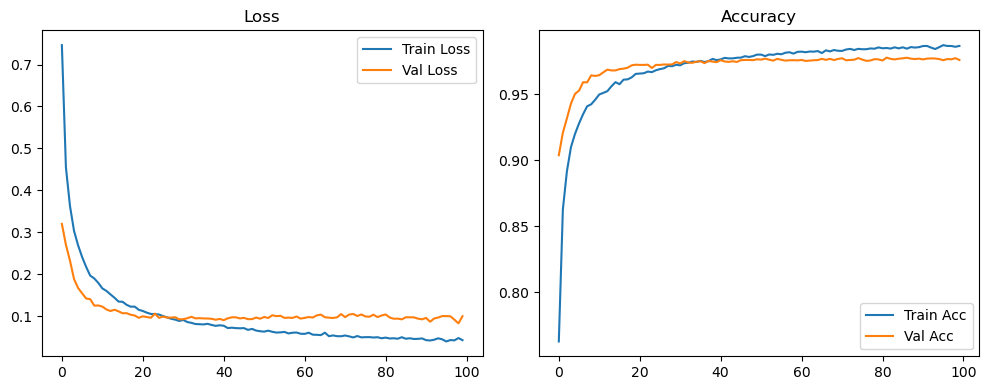

🚀 Running: batch128_lr0.005_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.3779, Acc: 0.8919 | Val Loss: 0.2248, Acc: 0.9309


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1645, Acc: 0.9502 | Val Loss: 0.1382, Acc: 0.9565


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0940, Acc: 0.9710 | Val Loss: 0.1197, Acc: 0.9642


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0675, Acc: 0.9779 | Val Loss: 0.1065, Acc: 0.9681


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0503, Acc: 0.9832 | Val Loss: 0.1318, Acc: 0.9627


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0334, Acc: 0.9888 | Val Loss: 0.1244, Acc: 0.9671


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0328, Acc: 0.9891 | Val Loss: 0.1225, Acc: 0.9677


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0258, Acc: 0.9914 | Val Loss: 0.1255, Acc: 0.9697


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0261, Acc: 0.9908 | Val Loss: 0.1196, Acc: 0.9713


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0227, Acc: 0.9920 | Val Loss: 0.1372, Acc: 0.9687


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0203, Acc: 0.9931 | Val Loss: 0.1347, Acc: 0.9691


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0181, Acc: 0.9938 | Val Loss: 0.1286, Acc: 0.9708


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0155, Acc: 0.9947 | Val Loss: 0.1466, Acc: 0.9688


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0203, Acc: 0.9930 | Val Loss: 0.1392, Acc: 0.9703


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0173, Acc: 0.9943 | Val Loss: 0.1595, Acc: 0.9689


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0172, Acc: 0.9946 | Val Loss: 0.1365, Acc: 0.9708


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9965 | Val Loss: 0.1290, Acc: 0.9730


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0143, Acc: 0.9953 | Val Loss: 0.1376, Acc: 0.9693


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0131, Acc: 0.9954 | Val Loss: 0.1684, Acc: 0.9673


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9957 | Val Loss: 0.1532, Acc: 0.9692


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9955 | Val Loss: 0.1216, Acc: 0.9725


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9968 | Val Loss: 0.1441, Acc: 0.9717


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.1355, Acc: 0.9730


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9966 | Val Loss: 0.1409, Acc: 0.9719


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9957 | Val Loss: 0.1386, Acc: 0.9726


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.1358, Acc: 0.9730


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.1292, Acc: 0.9723


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.1452, Acc: 0.9747


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9969 | Val Loss: 0.1335, Acc: 0.9730


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.1402, Acc: 0.9751


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9975 | Val Loss: 0.1429, Acc: 0.9739


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.1359, Acc: 0.9742


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.1573, Acc: 0.9712


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.1663, Acc: 0.9692


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.1253, Acc: 0.9745


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1628, Acc: 0.9723


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.1328, Acc: 0.9757


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.1427, Acc: 0.9732


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.1363, Acc: 0.9730


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.1413, Acc: 0.9737


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1632, Acc: 0.9725


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.1544, Acc: 0.9727


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.1312, Acc: 0.9769


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.1349, Acc: 0.9753


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.1480, Acc: 0.9751


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.1506, Acc: 0.9748


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.1365, Acc: 0.9774


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9981 | Val Loss: 0.1507, Acc: 0.9753


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9983 | Val Loss: 0.1508, Acc: 0.9760


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1492, Acc: 0.9743


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9990 | Val Loss: 0.1247, Acc: 0.9769


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1366, Acc: 0.9774


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1456, Acc: 0.9770


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1434, Acc: 0.9784


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1492, Acc: 0.9776


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1524, Acc: 0.9778


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1441, Acc: 0.9788


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1508, Acc: 0.9786


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1598, Acc: 0.9778


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1673, Acc: 0.9752


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1703, Acc: 0.9744


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.1586, Acc: 0.9769


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1596, Acc: 0.9774


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1574, Acc: 0.9764


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1564, Acc: 0.9778


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1756, Acc: 0.9753


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1684, Acc: 0.9765


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.1576, Acc: 0.9770


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1648, Acc: 0.9768


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.1647, Acc: 0.9777


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1568, Acc: 0.9783


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9997 | Val Loss: 0.1870, Acc: 0.9759


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1646, Acc: 0.9779


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.1545, Acc: 0.9785


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1569, Acc: 0.9776


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1570, Acc: 0.9772


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.1619, Acc: 0.9765


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1604, Acc: 0.9775


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1512, Acc: 0.9782


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1662, Acc: 0.9777


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1617, Acc: 0.9777


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1679, Acc: 0.9779


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1764, Acc: 0.9781


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1682, Acc: 0.9786


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1743, Acc: 0.9786


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1743, Acc: 0.9790


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1772, Acc: 0.9786


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1726, Acc: 0.9794


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1859, Acc: 0.9784


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1838, Acc: 0.9783


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1872, Acc: 0.9774


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1813, Acc: 0.9783


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.1757, Acc: 0.9789


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1775, Acc: 0.9789


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1839, Acc: 0.9787


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1870, Acc: 0.9778


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1864, Acc: 0.9789


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1792, Acc: 0.9788


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1791, Acc: 0.9780


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1765, Acc: 0.9791


Final Test Loss: 0.1655 Accuracy: 0.9793


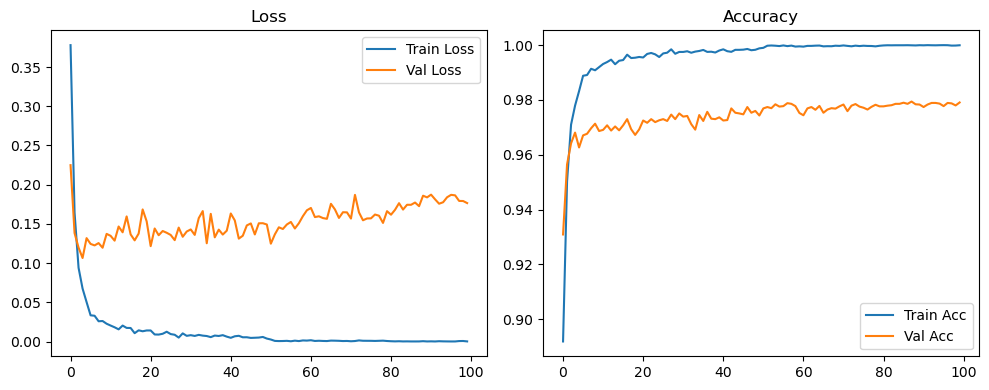

🚀 Running: batch128_lr0.005_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4861, Acc: 0.8562 | Val Loss: 0.2773, Acc: 0.9182


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2851, Acc: 0.9136 | Val Loss: 0.2036, Acc: 0.9381


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.2154, Acc: 0.9342 | Val Loss: 0.1866, Acc: 0.9442


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1748, Acc: 0.9474 | Val Loss: 0.1500, Acc: 0.9547


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1487, Acc: 0.9553 | Val Loss: 0.1352, Acc: 0.9605


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1263, Acc: 0.9605 | Val Loss: 0.1264, Acc: 0.9641


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1108, Acc: 0.9655 | Val Loss: 0.1209, Acc: 0.9660


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0956, Acc: 0.9699 | Val Loss: 0.1178, Acc: 0.9663


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0877, Acc: 0.9722 | Val Loss: 0.1166, Acc: 0.9683


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0821, Acc: 0.9741 | Val Loss: 0.1161, Acc: 0.9685


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0718, Acc: 0.9765 | Val Loss: 0.1121, Acc: 0.9708


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0649, Acc: 0.9785 | Val Loss: 0.1168, Acc: 0.9696


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0632, Acc: 0.9795 | Val Loss: 0.1087, Acc: 0.9718


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0555, Acc: 0.9815 | Val Loss: 0.1140, Acc: 0.9717


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0525, Acc: 0.9825 | Val Loss: 0.1205, Acc: 0.9711


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0505, Acc: 0.9837 | Val Loss: 0.1155, Acc: 0.9713


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0510, Acc: 0.9829 | Val Loss: 0.1117, Acc: 0.9731


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0477, Acc: 0.9845 | Val Loss: 0.1117, Acc: 0.9729


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0426, Acc: 0.9860 | Val Loss: 0.1085, Acc: 0.9731


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0405, Acc: 0.9866 | Val Loss: 0.1032, Acc: 0.9745


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0409, Acc: 0.9864 | Val Loss: 0.1181, Acc: 0.9726


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0363, Acc: 0.9879 | Val Loss: 0.1160, Acc: 0.9736


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0386, Acc: 0.9862 | Val Loss: 0.1177, Acc: 0.9723


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0340, Acc: 0.9885 | Val Loss: 0.1192, Acc: 0.9730


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0358, Acc: 0.9877 | Val Loss: 0.1266, Acc: 0.9730


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0340, Acc: 0.9886 | Val Loss: 0.1232, Acc: 0.9732


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0311, Acc: 0.9898 | Val Loss: 0.1177, Acc: 0.9740


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0292, Acc: 0.9900 | Val Loss: 0.1152, Acc: 0.9746


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0279, Acc: 0.9909 | Val Loss: 0.1133, Acc: 0.9738


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0274, Acc: 0.9907 | Val Loss: 0.1198, Acc: 0.9732


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0275, Acc: 0.9911 | Val Loss: 0.1192, Acc: 0.9749


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0289, Acc: 0.9906 | Val Loss: 0.1160, Acc: 0.9739


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0260, Acc: 0.9915 | Val Loss: 0.1156, Acc: 0.9729


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0240, Acc: 0.9922 | Val Loss: 0.1179, Acc: 0.9746


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0261, Acc: 0.9915 | Val Loss: 0.1180, Acc: 0.9738


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0232, Acc: 0.9920 | Val Loss: 0.1201, Acc: 0.9741


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0240, Acc: 0.9919 | Val Loss: 0.1190, Acc: 0.9728


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0237, Acc: 0.9917 | Val Loss: 0.1263, Acc: 0.9737


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0232, Acc: 0.9923 | Val Loss: 0.1211, Acc: 0.9735


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0213, Acc: 0.9927 | Val Loss: 0.1172, Acc: 0.9750


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0210, Acc: 0.9932 | Val Loss: 0.1192, Acc: 0.9749


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0197, Acc: 0.9932 | Val Loss: 0.1170, Acc: 0.9752


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0212, Acc: 0.9929 | Val Loss: 0.1237, Acc: 0.9749


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0201, Acc: 0.9932 | Val Loss: 0.1097, Acc: 0.9761


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0213, Acc: 0.9931 | Val Loss: 0.1213, Acc: 0.9751


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0218, Acc: 0.9929 | Val Loss: 0.1146, Acc: 0.9746


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0214, Acc: 0.9927 | Val Loss: 0.1149, Acc: 0.9747


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0178, Acc: 0.9941 | Val Loss: 0.1169, Acc: 0.9748


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0195, Acc: 0.9936 | Val Loss: 0.1172, Acc: 0.9759


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0178, Acc: 0.9939 | Val Loss: 0.1175, Acc: 0.9762


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0139, Acc: 0.9954 | Val Loss: 0.1132, Acc: 0.9768


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0128, Acc: 0.9956 | Val Loss: 0.1194, Acc: 0.9782


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9969 | Val Loss: 0.1277, Acc: 0.9772


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9966 | Val Loss: 0.1324, Acc: 0.9776


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9970 | Val Loss: 0.1292, Acc: 0.9775


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9973 | Val Loss: 0.1315, Acc: 0.9772


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9969 | Val Loss: 0.1274, Acc: 0.9763


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.1352, Acc: 0.9777


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9972 | Val Loss: 0.1264, Acc: 0.9786


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.1314, Acc: 0.9776


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.1419, Acc: 0.9782


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9973 | Val Loss: 0.1380, Acc: 0.9773


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.1320, Acc: 0.9769


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.1396, Acc: 0.9777


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.1353, Acc: 0.9778


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9975 | Val Loss: 0.1293, Acc: 0.9772


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.1306, Acc: 0.9760


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9974 | Val Loss: 0.1322, Acc: 0.9780


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9976 | Val Loss: 0.1440, Acc: 0.9780


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.1365, Acc: 0.9779


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.1357, Acc: 0.9784


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9978 | Val Loss: 0.1443, Acc: 0.9765


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9974 | Val Loss: 0.1382, Acc: 0.9770


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9975 | Val Loss: 0.1277, Acc: 0.9771


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1393, Acc: 0.9772


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9978 | Val Loss: 0.1402, Acc: 0.9773


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9976 | Val Loss: 0.1352, Acc: 0.9779


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9978 | Val Loss: 0.1447, Acc: 0.9763


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.1322, Acc: 0.9768


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9977 | Val Loss: 0.1351, Acc: 0.9774


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1387, Acc: 0.9768


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1379, Acc: 0.9763


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.1317, Acc: 0.9772


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9983 | Val Loss: 0.1365, Acc: 0.9768


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1430, Acc: 0.9772


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1462, Acc: 0.9776


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1436, Acc: 0.9772


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9987 | Val Loss: 0.1433, Acc: 0.9767


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1426, Acc: 0.9774


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1408, Acc: 0.9779


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1461, Acc: 0.9780


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1506, Acc: 0.9777


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1460, Acc: 0.9781


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.1491, Acc: 0.9770


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1503, Acc: 0.9777


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.1454, Acc: 0.9785


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.1424, Acc: 0.9774


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1456, Acc: 0.9769


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.1436, Acc: 0.9781


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1485, Acc: 0.9774


Final Test Loss: 0.1304 Accuracy: 0.9805


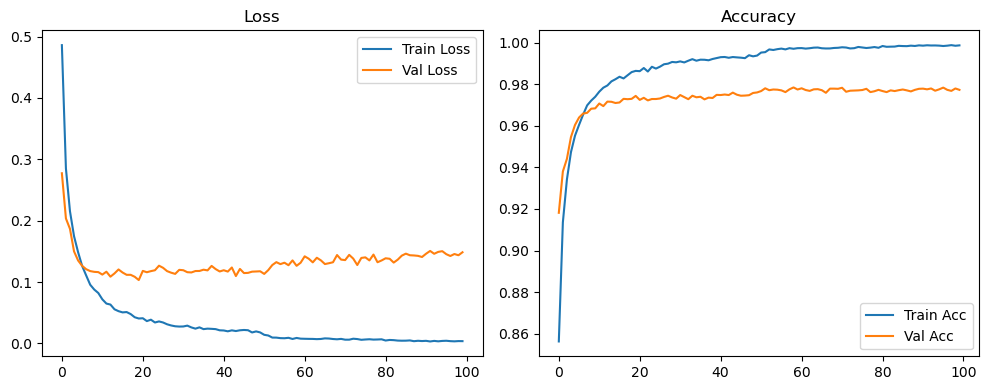

🚀 Running: batch128_lr0.005_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.7462, Acc: 0.7630 | Val Loss: 0.3201, Acc: 0.9038


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.4546, Acc: 0.8628 | Val Loss: 0.2700, Acc: 0.9207


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.3630, Acc: 0.8916 | Val Loss: 0.2326, Acc: 0.9316


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.3036, Acc: 0.9098 | Val Loss: 0.1887, Acc: 0.9427


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.2691, Acc: 0.9199 | Val Loss: 0.1674, Acc: 0.9501


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.2412, Acc: 0.9278 | Val Loss: 0.1545, Acc: 0.9526


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.2174, Acc: 0.9347 | Val Loss: 0.1421, Acc: 0.9589


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.1967, Acc: 0.9407 | Val Loss: 0.1407, Acc: 0.9588


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.1900, Acc: 0.9422 | Val Loss: 0.1253, Acc: 0.9641


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.1793, Acc: 0.9457 | Val Loss: 0.1255, Acc: 0.9637


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.1662, Acc: 0.9497 | Val Loss: 0.1229, Acc: 0.9643


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.1603, Acc: 0.9509 | Val Loss: 0.1161, Acc: 0.9664


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.1520, Acc: 0.9521 | Val Loss: 0.1123, Acc: 0.9684


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.1440, Acc: 0.9558 | Val Loss: 0.1153, Acc: 0.9678


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.1349, Acc: 0.9590 | Val Loss: 0.1116, Acc: 0.9678


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.1343, Acc: 0.9574 | Val Loss: 0.1070, Acc: 0.9688


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.1271, Acc: 0.9609 | Val Loss: 0.1072, Acc: 0.9692


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.1226, Acc: 0.9611 | Val Loss: 0.1035, Acc: 0.9699


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.1228, Acc: 0.9626 | Val Loss: 0.1016, Acc: 0.9717


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.1152, Acc: 0.9652 | Val Loss: 0.0962, Acc: 0.9722


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.1124, Acc: 0.9655 | Val Loss: 0.0996, Acc: 0.9720


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.1083, Acc: 0.9657 | Val Loss: 0.0979, Acc: 0.9720


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.1053, Acc: 0.9670 | Val Loss: 0.0963, Acc: 0.9722


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.1050, Acc: 0.9665 | Val Loss: 0.1061, Acc: 0.9697


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.1039, Acc: 0.9680 | Val Loss: 0.0960, Acc: 0.9720


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.1002, Acc: 0.9688 | Val Loss: 0.0990, Acc: 0.9720


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0972, Acc: 0.9695 | Val Loss: 0.0966, Acc: 0.9723


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0938, Acc: 0.9712 | Val Loss: 0.0966, Acc: 0.9722


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0918, Acc: 0.9710 | Val Loss: 0.0975, Acc: 0.9724


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0886, Acc: 0.9721 | Val Loss: 0.0925, Acc: 0.9742


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0910, Acc: 0.9717 | Val Loss: 0.0929, Acc: 0.9731


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0860, Acc: 0.9733 | Val Loss: 0.0951, Acc: 0.9748


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0841, Acc: 0.9736 | Val Loss: 0.0985, Acc: 0.9738


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0813, Acc: 0.9746 | Val Loss: 0.0948, Acc: 0.9736


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0808, Acc: 0.9742 | Val Loss: 0.0952, Acc: 0.9744


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0803, Acc: 0.9751 | Val Loss: 0.0947, Acc: 0.9748


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0818, Acc: 0.9742 | Val Loss: 0.0944, Acc: 0.9733


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0791, Acc: 0.9749 | Val Loss: 0.0938, Acc: 0.9750


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0769, Acc: 0.9766 | Val Loss: 0.0915, Acc: 0.9745


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0783, Acc: 0.9756 | Val Loss: 0.0935, Acc: 0.9741


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0772, Acc: 0.9762 | Val Loss: 0.0905, Acc: 0.9756


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0717, Acc: 0.9773 | Val Loss: 0.0949, Acc: 0.9746


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0725, Acc: 0.9769 | Val Loss: 0.0973, Acc: 0.9743


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0716, Acc: 0.9769 | Val Loss: 0.0973, Acc: 0.9748


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0711, Acc: 0.9774 | Val Loss: 0.0947, Acc: 0.9742


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0715, Acc: 0.9775 | Val Loss: 0.0960, Acc: 0.9756


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0674, Acc: 0.9786 | Val Loss: 0.0929, Acc: 0.9758


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0697, Acc: 0.9780 | Val Loss: 0.0930, Acc: 0.9758


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0657, Acc: 0.9786 | Val Loss: 0.0967, Acc: 0.9756


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0641, Acc: 0.9798 | Val Loss: 0.0940, Acc: 0.9762


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0576, Acc: 0.9820 | Val Loss: 0.0938, Acc: 0.9762


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0557, Acc: 0.9819 | Val Loss: 0.0934, Acc: 0.9766


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0531, Acc: 0.9831 | Val Loss: 0.0937, Acc: 0.9768


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0482, Acc: 0.9846 | Val Loss: 0.0981, Acc: 0.9770


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0485, Acc: 0.9852 | Val Loss: 0.0970, Acc: 0.9770


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0486, Acc: 0.9851 | Val Loss: 0.0940, Acc: 0.9764


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0452, Acc: 0.9854 | Val Loss: 0.0975, Acc: 0.9765


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0471, Acc: 0.9850 | Val Loss: 0.0955, Acc: 0.9768


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0475, Acc: 0.9845 | Val Loss: 0.0963, Acc: 0.9768


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0454, Acc: 0.9852 | Val Loss: 0.0952, Acc: 0.9773


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0436, Acc: 0.9860 | Val Loss: 0.1006, Acc: 0.9770


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0465, Acc: 0.9851 | Val Loss: 0.0955, Acc: 0.9765


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0438, Acc: 0.9860 | Val Loss: 0.0976, Acc: 0.9768


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0431, Acc: 0.9859 | Val Loss: 0.0993, Acc: 0.9760


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0426, Acc: 0.9866 | Val Loss: 0.1052, Acc: 0.9768


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0457, Acc: 0.9858 | Val Loss: 0.0955, Acc: 0.9777


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0402, Acc: 0.9867 | Val Loss: 0.1001, Acc: 0.9770


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0418, Acc: 0.9864 | Val Loss: 0.1010, Acc: 0.9771


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0411, Acc: 0.9867 | Val Loss: 0.0974, Acc: 0.9776


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0406, Acc: 0.9865 | Val Loss: 0.1053, Acc: 0.9768


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0418, Acc: 0.9873 | Val Loss: 0.1052, Acc: 0.9771


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0394, Acc: 0.9869 | Val Loss: 0.1030, Acc: 0.9760


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0397, Acc: 0.9872 | Val Loss: 0.1017, Acc: 0.9772


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0395, Acc: 0.9874 | Val Loss: 0.1019, Acc: 0.9768


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0395, Acc: 0.9868 | Val Loss: 0.0985, Acc: 0.9778


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0396, Acc: 0.9874 | Val Loss: 0.1009, Acc: 0.9768


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0387, Acc: 0.9875 | Val Loss: 0.1027, Acc: 0.9765


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0387, Acc: 0.9871 | Val Loss: 0.1049, Acc: 0.9766


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0400, Acc: 0.9872 | Val Loss: 0.1002, Acc: 0.9777


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0359, Acc: 0.9883 | Val Loss: 0.1022, Acc: 0.9766


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0362, Acc: 0.9883 | Val Loss: 0.1006, Acc: 0.9768


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0347, Acc: 0.9887 | Val Loss: 0.1004, Acc: 0.9769


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0340, Acc: 0.9891 | Val Loss: 0.1022, Acc: 0.9770


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0325, Acc: 0.9890 | Val Loss: 0.1038, Acc: 0.9766


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0340, Acc: 0.9890 | Val Loss: 0.1048, Acc: 0.9771


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0333, Acc: 0.9894 | Val Loss: 0.1033, Acc: 0.9763


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0335, Acc: 0.9890 | Val Loss: 0.1035, Acc: 0.9770


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0324, Acc: 0.9895 | Val Loss: 0.1043, Acc: 0.9768


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0327, Acc: 0.9893 | Val Loss: 0.1045, Acc: 0.9773


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0322, Acc: 0.9900 | Val Loss: 0.1020, Acc: 0.9772


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0304, Acc: 0.9901 | Val Loss: 0.1026, Acc: 0.9768


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0316, Acc: 0.9899 | Val Loss: 0.0995, Acc: 0.9773


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0312, Acc: 0.9900 | Val Loss: 0.1053, Acc: 0.9771


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0318, Acc: 0.9892 | Val Loss: 0.1059, Acc: 0.9758


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0321, Acc: 0.9897 | Val Loss: 0.1032, Acc: 0.9770


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0300, Acc: 0.9906 | Val Loss: 0.1019, Acc: 0.9770


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0302, Acc: 0.9897 | Val Loss: 0.1060, Acc: 0.9771


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0307, Acc: 0.9907 | Val Loss: 0.1041, Acc: 0.9768


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0339, Acc: 0.9897 | Val Loss: 0.1013, Acc: 0.9771


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0306, Acc: 0.9899 | Val Loss: 0.1042, Acc: 0.9768


Final Test Loss: 0.0975 Accuracy: 0.9798


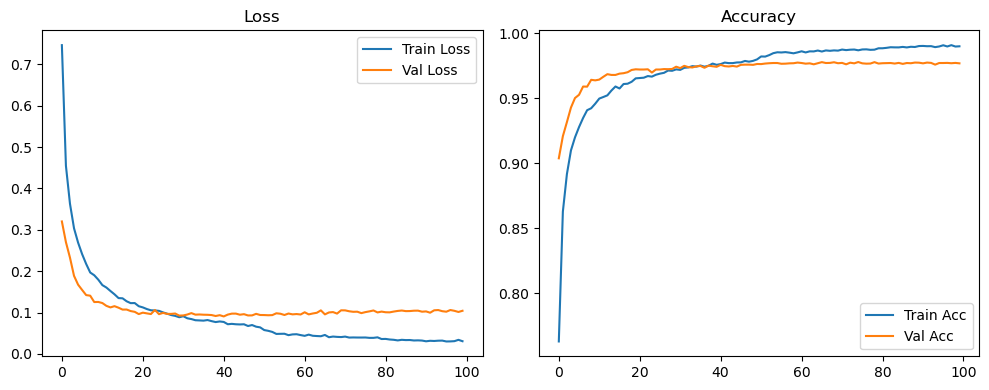

🚀 Running: batch128_lr0.002_0.002_0.002_dp0.0


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.4271, Acc: 0.8899 | Val Loss: 0.2700, Acc: 0.9190


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1747, Acc: 0.9470 | Val Loss: 0.1346, Acc: 0.9577


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0923, Acc: 0.9714 | Val Loss: 0.1089, Acc: 0.9663


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0614, Acc: 0.9809 | Val Loss: 0.1097, Acc: 0.9653


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0409, Acc: 0.9869 | Val Loss: 0.1036, Acc: 0.9683


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0278, Acc: 0.9912 | Val Loss: 0.1048, Acc: 0.9708


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0224, Acc: 0.9927 | Val Loss: 0.1110, Acc: 0.9705


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0177, Acc: 0.9943 | Val Loss: 0.1145, Acc: 0.9671


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0215, Acc: 0.9930 | Val Loss: 0.1115, Acc: 0.9704


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0158, Acc: 0.9947 | Val Loss: 0.1298, Acc: 0.9667


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0165, Acc: 0.9949 | Val Loss: 0.1200, Acc: 0.9693


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0135, Acc: 0.9955 | Val Loss: 0.1114, Acc: 0.9745


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9969 | Val Loss: 0.1099, Acc: 0.9743


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0112, Acc: 0.9963 | Val Loss: 0.1149, Acc: 0.9742


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0135, Acc: 0.9954 | Val Loss: 0.1333, Acc: 0.9673


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0105, Acc: 0.9966 | Val Loss: 0.1126, Acc: 0.9742


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0109, Acc: 0.9961 | Val Loss: 0.1493, Acc: 0.9686


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0124, Acc: 0.9957 | Val Loss: 0.1442, Acc: 0.9697


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.1306, Acc: 0.9722


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.1425, Acc: 0.9690


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9977 | Val Loss: 0.1310, Acc: 0.9737


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9977 | Val Loss: 0.1363, Acc: 0.9732


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9964 | Val Loss: 0.1251, Acc: 0.9722


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9978 | Val Loss: 0.1173, Acc: 0.9759


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9975 | Val Loss: 0.1297, Acc: 0.9730


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9975 | Val Loss: 0.1342, Acc: 0.9742


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.1310, Acc: 0.9727


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.1426, Acc: 0.9718


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.1353, Acc: 0.9736


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9971 | Val Loss: 0.1329, Acc: 0.9729


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.1333, Acc: 0.9746


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.1304, Acc: 0.9751


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1412, Acc: 0.9732


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.1299, Acc: 0.9740


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1384, Acc: 0.9753


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1257, Acc: 0.9752


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.1359, Acc: 0.9738


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.1316, Acc: 0.9755


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.1353, Acc: 0.9748


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1377, Acc: 0.9751


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.1201, Acc: 0.9772


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9986 | Val Loss: 0.1409, Acc: 0.9735


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1340, Acc: 0.9744


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1287, Acc: 0.9748


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9981 | Val Loss: 0.1207, Acc: 0.9765


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1341, Acc: 0.9767


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1370, Acc: 0.9761


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1354, Acc: 0.9758


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.1402, Acc: 0.9742


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1334, Acc: 0.9771


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1346, Acc: 0.9758


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.1408, Acc: 0.9748


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1702, Acc: 0.9705


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.1606, Acc: 0.9736


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1625, Acc: 0.9726


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1506, Acc: 0.9740


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9990 | Val Loss: 0.1503, Acc: 0.9749


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1409, Acc: 0.9768


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.1482, Acc: 0.9745


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1601, Acc: 0.9738


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1416, Acc: 0.9747


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1386, Acc: 0.9755


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1429, Acc: 0.9761


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1514, Acc: 0.9759


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1552, Acc: 0.9741


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.1327, Acc: 0.9751


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1426, Acc: 0.9756


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9995 | Val Loss: 0.1771, Acc: 0.9704


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1369, Acc: 0.9771


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.1666, Acc: 0.9731


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1609, Acc: 0.9743


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.1629, Acc: 0.9760


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1529, Acc: 0.9748


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1557, Acc: 0.9757


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1735, Acc: 0.9734


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.1525, Acc: 0.9759


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1745, Acc: 0.9734


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1979, Acc: 0.9725


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1490, Acc: 0.9767


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1521, Acc: 0.9762


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.1428, Acc: 0.9761


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1550, Acc: 0.9748


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1468, Acc: 0.9771


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9990 | Val Loss: 0.1441, Acc: 0.9766


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1367, Acc: 0.9762


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1371, Acc: 0.9773


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1510, Acc: 0.9774


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1449, Acc: 0.9768


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1525, Acc: 0.9753


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1529, Acc: 0.9751


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1576, Acc: 0.9772


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1641, Acc: 0.9756


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1658, Acc: 0.9737


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1473, Acc: 0.9745


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1551, Acc: 0.9746


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1648, Acc: 0.9726


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1382, Acc: 0.9773


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1437, Acc: 0.9778


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1509, Acc: 0.9771


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1742, Acc: 0.9745


Final Test Loss: 0.1524 Accuracy: 0.9764


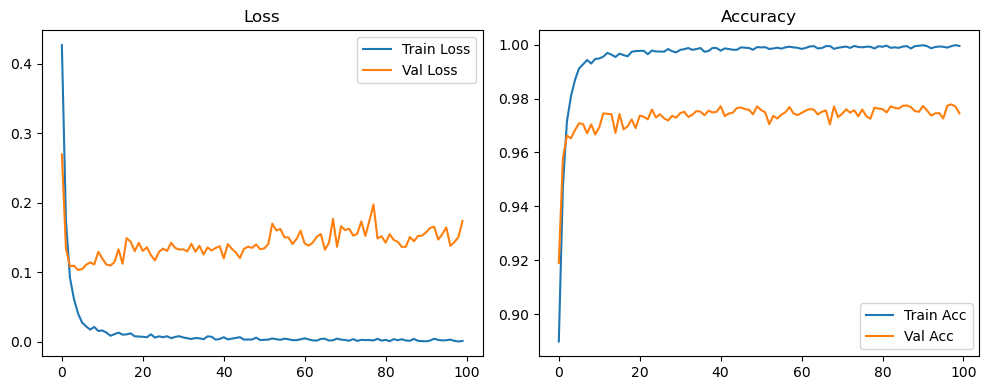

🚀 Running: batch128_lr0.002_0.002_0.002_dp0.2


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.5625, Acc: 0.8485 | Val Loss: 0.3042, Acc: 0.9093


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.3199, Acc: 0.9022 | Val Loss: 0.2275, Acc: 0.9307


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.2490, Acc: 0.9243 | Val Loss: 0.1919, Acc: 0.9414


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.2087, Acc: 0.9378 | Val Loss: 0.1629, Acc: 0.9500


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.1850, Acc: 0.9428 | Val Loss: 0.1518, Acc: 0.9542


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.1625, Acc: 0.9500 | Val Loss: 0.1404, Acc: 0.9569


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.1420, Acc: 0.9558 | Val Loss: 0.1366, Acc: 0.9612


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.1273, Acc: 0.9602 | Val Loss: 0.1374, Acc: 0.9603


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.1176, Acc: 0.9628 | Val Loss: 0.1263, Acc: 0.9639


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.1122, Acc: 0.9634 | Val Loss: 0.1266, Acc: 0.9647


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.1057, Acc: 0.9660 | Val Loss: 0.1283, Acc: 0.9639


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0934, Acc: 0.9696 | Val Loss: 0.1258, Acc: 0.9669


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0880, Acc: 0.9703 | Val Loss: 0.1212, Acc: 0.9672


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0803, Acc: 0.9746 | Val Loss: 0.1183, Acc: 0.9671


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0772, Acc: 0.9743 | Val Loss: 0.1311, Acc: 0.9656


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0722, Acc: 0.9767 | Val Loss: 0.1266, Acc: 0.9671


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0729, Acc: 0.9760 | Val Loss: 0.1236, Acc: 0.9674


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0658, Acc: 0.9784 | Val Loss: 0.1246, Acc: 0.9677


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0635, Acc: 0.9787 | Val Loss: 0.1201, Acc: 0.9693


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0602, Acc: 0.9803 | Val Loss: 0.1227, Acc: 0.9690


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0597, Acc: 0.9804 | Val Loss: 0.1271, Acc: 0.9694


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0570, Acc: 0.9812 | Val Loss: 0.1226, Acc: 0.9693


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0537, Acc: 0.9819 | Val Loss: 0.1238, Acc: 0.9682


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0491, Acc: 0.9838 | Val Loss: 0.1249, Acc: 0.9679


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0507, Acc: 0.9829 | Val Loss: 0.1309, Acc: 0.9682


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0510, Acc: 0.9832 | Val Loss: 0.1262, Acc: 0.9701


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0457, Acc: 0.9849 | Val Loss: 0.1255, Acc: 0.9703


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0444, Acc: 0.9852 | Val Loss: 0.1201, Acc: 0.9703


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0445, Acc: 0.9850 | Val Loss: 0.1289, Acc: 0.9690


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0423, Acc: 0.9860 | Val Loss: 0.1258, Acc: 0.9714


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0409, Acc: 0.9858 | Val Loss: 0.1281, Acc: 0.9708


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0424, Acc: 0.9864 | Val Loss: 0.1298, Acc: 0.9700


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0398, Acc: 0.9864 | Val Loss: 0.1331, Acc: 0.9689


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0359, Acc: 0.9879 | Val Loss: 0.1306, Acc: 0.9708


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0391, Acc: 0.9867 | Val Loss: 0.1344, Acc: 0.9693


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0377, Acc: 0.9876 | Val Loss: 0.1281, Acc: 0.9697


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0319, Acc: 0.9885 | Val Loss: 0.1292, Acc: 0.9711


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0332, Acc: 0.9885 | Val Loss: 0.1312, Acc: 0.9726


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0338, Acc: 0.9887 | Val Loss: 0.1333, Acc: 0.9720


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0339, Acc: 0.9886 | Val Loss: 0.1373, Acc: 0.9704


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0312, Acc: 0.9888 | Val Loss: 0.1392, Acc: 0.9701


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0310, Acc: 0.9895 | Val Loss: 0.1328, Acc: 0.9706


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0287, Acc: 0.9895 | Val Loss: 0.1346, Acc: 0.9699


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0323, Acc: 0.9891 | Val Loss: 0.1349, Acc: 0.9712


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0299, Acc: 0.9902 | Val Loss: 0.1366, Acc: 0.9713


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0330, Acc: 0.9894 | Val Loss: 0.1305, Acc: 0.9717


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0277, Acc: 0.9907 | Val Loss: 0.1293, Acc: 0.9727


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0268, Acc: 0.9913 | Val Loss: 0.1319, Acc: 0.9714


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0306, Acc: 0.9897 | Val Loss: 0.1273, Acc: 0.9711


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0268, Acc: 0.9906 | Val Loss: 0.1345, Acc: 0.9716


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0254, Acc: 0.9917 | Val Loss: 0.1378, Acc: 0.9716


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0264, Acc: 0.9909 | Val Loss: 0.1351, Acc: 0.9718


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0263, Acc: 0.9909 | Val Loss: 0.1352, Acc: 0.9731


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0265, Acc: 0.9909 | Val Loss: 0.1372, Acc: 0.9728


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0264, Acc: 0.9909 | Val Loss: 0.1327, Acc: 0.9729


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0231, Acc: 0.9922 | Val Loss: 0.1385, Acc: 0.9723


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0263, Acc: 0.9912 | Val Loss: 0.1447, Acc: 0.9711


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0234, Acc: 0.9922 | Val Loss: 0.1309, Acc: 0.9729


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0238, Acc: 0.9919 | Val Loss: 0.1363, Acc: 0.9712


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0252, Acc: 0.9919 | Val Loss: 0.1329, Acc: 0.9737


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0228, Acc: 0.9923 | Val Loss: 0.1333, Acc: 0.9732


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0205, Acc: 0.9935 | Val Loss: 0.1324, Acc: 0.9737


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0228, Acc: 0.9920 | Val Loss: 0.1339, Acc: 0.9740


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0208, Acc: 0.9929 | Val Loss: 0.1343, Acc: 0.9737


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0230, Acc: 0.9921 | Val Loss: 0.1355, Acc: 0.9716


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0259, Acc: 0.9913 | Val Loss: 0.1275, Acc: 0.9736


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0211, Acc: 0.9925 | Val Loss: 0.1410, Acc: 0.9722


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0210, Acc: 0.9924 | Val Loss: 0.1403, Acc: 0.9724


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0210, Acc: 0.9929 | Val Loss: 0.1375, Acc: 0.9723


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0221, Acc: 0.9918 | Val Loss: 0.1339, Acc: 0.9738


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0213, Acc: 0.9931 | Val Loss: 0.1299, Acc: 0.9751


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0196, Acc: 0.9933 | Val Loss: 0.1332, Acc: 0.9734


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0212, Acc: 0.9931 | Val Loss: 0.1320, Acc: 0.9742


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0209, Acc: 0.9929 | Val Loss: 0.1337, Acc: 0.9733


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0183, Acc: 0.9937 | Val Loss: 0.1319, Acc: 0.9740


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0197, Acc: 0.9933 | Val Loss: 0.1317, Acc: 0.9747


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0195, Acc: 0.9934 | Val Loss: 0.1396, Acc: 0.9742


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0178, Acc: 0.9942 | Val Loss: 0.1407, Acc: 0.9731


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0167, Acc: 0.9947 | Val Loss: 0.1402, Acc: 0.9728


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0186, Acc: 0.9939 | Val Loss: 0.1408, Acc: 0.9722


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0170, Acc: 0.9942 | Val Loss: 0.1379, Acc: 0.9734


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0166, Acc: 0.9940 | Val Loss: 0.1475, Acc: 0.9738


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0174, Acc: 0.9936 | Val Loss: 0.1562, Acc: 0.9736


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0203, Acc: 0.9932 | Val Loss: 0.1437, Acc: 0.9735


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0174, Acc: 0.9943 | Val Loss: 0.1505, Acc: 0.9718


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0174, Acc: 0.9940 | Val Loss: 0.1480, Acc: 0.9735


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0191, Acc: 0.9934 | Val Loss: 0.1501, Acc: 0.9722


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0171, Acc: 0.9942 | Val Loss: 0.1460, Acc: 0.9728


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0183, Acc: 0.9937 | Val Loss: 0.1508, Acc: 0.9727


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0164, Acc: 0.9947 | Val Loss: 0.1455, Acc: 0.9745


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0165, Acc: 0.9945 | Val Loss: 0.1420, Acc: 0.9743


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0160, Acc: 0.9944 | Val Loss: 0.1511, Acc: 0.9714


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0179, Acc: 0.9941 | Val Loss: 0.1424, Acc: 0.9727


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0171, Acc: 0.9939 | Val Loss: 0.1452, Acc: 0.9739


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0171, Acc: 0.9940 | Val Loss: 0.1437, Acc: 0.9740


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0173, Acc: 0.9941 | Val Loss: 0.1484, Acc: 0.9725


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0161, Acc: 0.9948 | Val Loss: 0.1405, Acc: 0.9737


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0153, Acc: 0.9949 | Val Loss: 0.1440, Acc: 0.9745


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0151, Acc: 0.9953 | Val Loss: 0.1410, Acc: 0.9748


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0141, Acc: 0.9948 | Val Loss: 0.1500, Acc: 0.9724


Final Test Loss: 0.1196 Accuracy: 0.9771


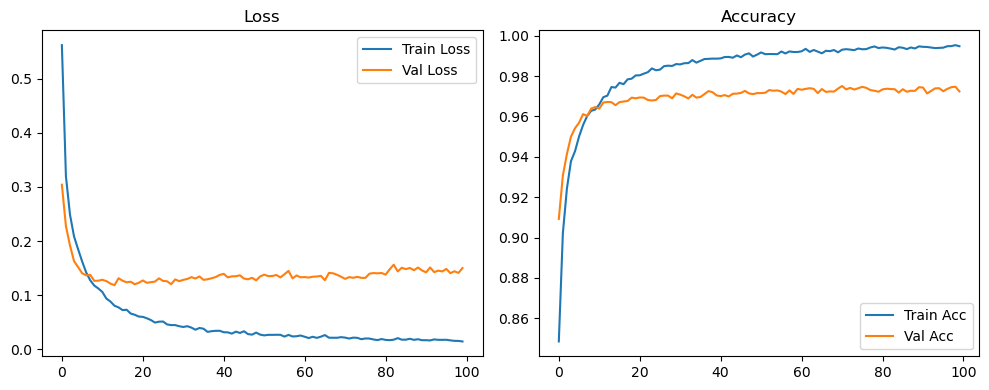

🚀 Running: batch128_lr0.002_0.002_0.002_dp0.5


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.9115, Acc: 0.7140 | Val Loss: 0.3619, Acc: 0.8942


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.5307, Acc: 0.8380 | Val Loss: 0.3104, Acc: 0.9083


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.4390, Acc: 0.8699 | Val Loss: 0.2801, Acc: 0.9165


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.3890, Acc: 0.8836 | Val Loss: 0.2526, Acc: 0.9238


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.3551, Acc: 0.8933 | Val Loss: 0.2299, Acc: 0.9310


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.3196, Acc: 0.9045 | Val Loss: 0.2152, Acc: 0.9337


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.2928, Acc: 0.9122 | Val Loss: 0.1958, Acc: 0.9417


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.2679, Acc: 0.9195 | Val Loss: 0.1882, Acc: 0.9431


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.2578, Acc: 0.9233 | Val Loss: 0.1761, Acc: 0.9468


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.2383, Acc: 0.9280 | Val Loss: 0.1695, Acc: 0.9512


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.2265, Acc: 0.9308 | Val Loss: 0.1593, Acc: 0.9533


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.2157, Acc: 0.9343 | Val Loss: 0.1458, Acc: 0.9563


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.2046, Acc: 0.9376 | Val Loss: 0.1456, Acc: 0.9568


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.1950, Acc: 0.9407 | Val Loss: 0.1447, Acc: 0.9575


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.1888, Acc: 0.9427 | Val Loss: 0.1431, Acc: 0.9581


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.1781, Acc: 0.9464 | Val Loss: 0.1333, Acc: 0.9635


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.1712, Acc: 0.9465 | Val Loss: 0.1331, Acc: 0.9618


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.1661, Acc: 0.9491 | Val Loss: 0.1288, Acc: 0.9627


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.1634, Acc: 0.9501 | Val Loss: 0.1269, Acc: 0.9633


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.1574, Acc: 0.9510 | Val Loss: 0.1224, Acc: 0.9661


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.1502, Acc: 0.9537 | Val Loss: 0.1231, Acc: 0.9657


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.1426, Acc: 0.9563 | Val Loss: 0.1231, Acc: 0.9643


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.1394, Acc: 0.9559 | Val Loss: 0.1221, Acc: 0.9649


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.1375, Acc: 0.9575 | Val Loss: 0.1245, Acc: 0.9646


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.1347, Acc: 0.9584 | Val Loss: 0.1251, Acc: 0.9649


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.1314, Acc: 0.9596 | Val Loss: 0.1165, Acc: 0.9667


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.1297, Acc: 0.9596 | Val Loss: 0.1197, Acc: 0.9673


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.1209, Acc: 0.9621 | Val Loss: 0.1135, Acc: 0.9692


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.1234, Acc: 0.9623 | Val Loss: 0.1127, Acc: 0.9674


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.1214, Acc: 0.9615 | Val Loss: 0.1124, Acc: 0.9705


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.1151, Acc: 0.9646 | Val Loss: 0.1123, Acc: 0.9695


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.1153, Acc: 0.9635 | Val Loss: 0.1134, Acc: 0.9698


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.1111, Acc: 0.9649 | Val Loss: 0.1129, Acc: 0.9686


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.1110, Acc: 0.9654 | Val Loss: 0.1102, Acc: 0.9693


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.1082, Acc: 0.9649 | Val Loss: 0.1105, Acc: 0.9703


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.1073, Acc: 0.9659 | Val Loss: 0.1064, Acc: 0.9703


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.1036, Acc: 0.9675 | Val Loss: 0.1114, Acc: 0.9709


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.1007, Acc: 0.9676 | Val Loss: 0.1102, Acc: 0.9705


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0996, Acc: 0.9684 | Val Loss: 0.1122, Acc: 0.9699


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.1003, Acc: 0.9681 | Val Loss: 0.1066, Acc: 0.9717


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0961, Acc: 0.9687 | Val Loss: 0.1099, Acc: 0.9698


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0924, Acc: 0.9707 | Val Loss: 0.1099, Acc: 0.9705


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0901, Acc: 0.9716 | Val Loss: 0.1133, Acc: 0.9698


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0917, Acc: 0.9704 | Val Loss: 0.1081, Acc: 0.9702


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0931, Acc: 0.9710 | Val Loss: 0.1088, Acc: 0.9711


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0889, Acc: 0.9717 | Val Loss: 0.1082, Acc: 0.9722


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0891, Acc: 0.9711 | Val Loss: 0.1067, Acc: 0.9707


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0855, Acc: 0.9726 | Val Loss: 0.1085, Acc: 0.9711


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0890, Acc: 0.9722 | Val Loss: 0.1052, Acc: 0.9714


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0848, Acc: 0.9727 | Val Loss: 0.1058, Acc: 0.9717


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0838, Acc: 0.9728 | Val Loss: 0.1049, Acc: 0.9712


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0836, Acc: 0.9733 | Val Loss: 0.1076, Acc: 0.9712


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0817, Acc: 0.9732 | Val Loss: 0.1066, Acc: 0.9714


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0789, Acc: 0.9738 | Val Loss: 0.1063, Acc: 0.9716


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0809, Acc: 0.9745 | Val Loss: 0.1055, Acc: 0.9718


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0793, Acc: 0.9742 | Val Loss: 0.1073, Acc: 0.9718


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0780, Acc: 0.9743 | Val Loss: 0.1062, Acc: 0.9731


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0792, Acc: 0.9745 | Val Loss: 0.1070, Acc: 0.9712


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0761, Acc: 0.9760 | Val Loss: 0.1083, Acc: 0.9716


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0760, Acc: 0.9756 | Val Loss: 0.1057, Acc: 0.9705


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0722, Acc: 0.9773 | Val Loss: 0.1100, Acc: 0.9721


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0727, Acc: 0.9768 | Val Loss: 0.1054, Acc: 0.9719


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0699, Acc: 0.9785 | Val Loss: 0.1054, Acc: 0.9722


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0712, Acc: 0.9759 | Val Loss: 0.1090, Acc: 0.9718


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0717, Acc: 0.9775 | Val Loss: 0.1099, Acc: 0.9720


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0746, Acc: 0.9757 | Val Loss: 0.1064, Acc: 0.9729


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0651, Acc: 0.9792 | Val Loss: 0.1098, Acc: 0.9723


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0685, Acc: 0.9785 | Val Loss: 0.1055, Acc: 0.9728


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0643, Acc: 0.9783 | Val Loss: 0.1102, Acc: 0.9728


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0713, Acc: 0.9771 | Val Loss: 0.1037, Acc: 0.9740


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0685, Acc: 0.9777 | Val Loss: 0.1091, Acc: 0.9733


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0670, Acc: 0.9784 | Val Loss: 0.1058, Acc: 0.9731


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0666, Acc: 0.9784 | Val Loss: 0.1045, Acc: 0.9728


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0679, Acc: 0.9782 | Val Loss: 0.1063, Acc: 0.9733


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0672, Acc: 0.9779 | Val Loss: 0.1020, Acc: 0.9731


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0661, Acc: 0.9785 | Val Loss: 0.1044, Acc: 0.9733


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0629, Acc: 0.9797 | Val Loss: 0.1069, Acc: 0.9740


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0661, Acc: 0.9790 | Val Loss: 0.1081, Acc: 0.9730


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0652, Acc: 0.9789 | Val Loss: 0.1092, Acc: 0.9719


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0635, Acc: 0.9798 | Val Loss: 0.1062, Acc: 0.9739


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0607, Acc: 0.9797 | Val Loss: 0.1072, Acc: 0.9734


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0618, Acc: 0.9806 | Val Loss: 0.1078, Acc: 0.9737


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0617, Acc: 0.9808 | Val Loss: 0.1087, Acc: 0.9722


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0588, Acc: 0.9811 | Val Loss: 0.1069, Acc: 0.9728


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0597, Acc: 0.9806 | Val Loss: 0.1104, Acc: 0.9732


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0605, Acc: 0.9808 | Val Loss: 0.1061, Acc: 0.9725


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0590, Acc: 0.9804 | Val Loss: 0.1080, Acc: 0.9731


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0612, Acc: 0.9804 | Val Loss: 0.1092, Acc: 0.9732


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0591, Acc: 0.9810 | Val Loss: 0.1077, Acc: 0.9732


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0582, Acc: 0.9810 | Val Loss: 0.1047, Acc: 0.9740


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0577, Acc: 0.9813 | Val Loss: 0.1107, Acc: 0.9729


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0572, Acc: 0.9811 | Val Loss: 0.1070, Acc: 0.9728


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0550, Acc: 0.9822 | Val Loss: 0.1118, Acc: 0.9737


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0598, Acc: 0.9809 | Val Loss: 0.1056, Acc: 0.9732


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0547, Acc: 0.9817 | Val Loss: 0.1083, Acc: 0.9738


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0538, Acc: 0.9829 | Val Loss: 0.1078, Acc: 0.9727


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0557, Acc: 0.9826 | Val Loss: 0.1068, Acc: 0.9735


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0546, Acc: 0.9824 | Val Loss: 0.1046, Acc: 0.9732


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0562, Acc: 0.9821 | Val Loss: 0.1078, Acc: 0.9730


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0559, Acc: 0.9815 | Val Loss: 0.1074, Acc: 0.9730


Final Test Loss: 0.0941 Accuracy: 0.9761


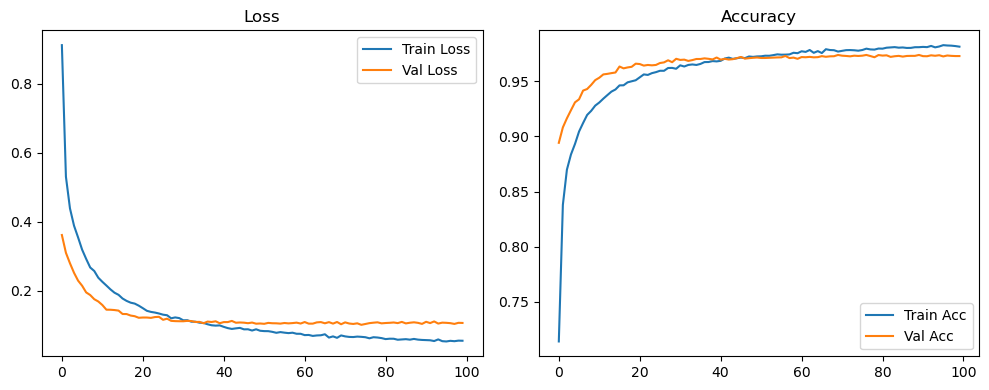

🚀 Running: batch128_lr0.001_0.001_0.001_dp0.0


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.5068, Acc: 0.8847 | Val Loss: 0.2874, Acc: 0.9166


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1750, Acc: 0.9491 | Val Loss: 0.1326, Acc: 0.9583


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0855, Acc: 0.9749 | Val Loss: 0.1167, Acc: 0.9633


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0529, Acc: 0.9844 | Val Loss: 0.0972, Acc: 0.9706


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0357, Acc: 0.9892 | Val Loss: 0.0944, Acc: 0.9702


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0248, Acc: 0.9922 | Val Loss: 0.0973, Acc: 0.9718


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0168, Acc: 0.9953 | Val Loss: 0.0898, Acc: 0.9746


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0152, Acc: 0.9957 | Val Loss: 0.1256, Acc: 0.9633


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0144, Acc: 0.9956 | Val Loss: 0.1107, Acc: 0.9699


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0150, Acc: 0.9956 | Val Loss: 0.1068, Acc: 0.9715


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0131, Acc: 0.9958 | Val Loss: 0.1033, Acc: 0.9727


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0097, Acc: 0.9967 | Val Loss: 0.0970, Acc: 0.9738


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0102, Acc: 0.9968 | Val Loss: 0.1164, Acc: 0.9704


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0111, Acc: 0.9964 | Val Loss: 0.1184, Acc: 0.9715


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9969 | Val Loss: 0.1069, Acc: 0.9732


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.1220, Acc: 0.9698


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9979 | Val Loss: 0.1076, Acc: 0.9739


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9981 | Val Loss: 0.1069, Acc: 0.9720


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9970 | Val Loss: 0.1154, Acc: 0.9717


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0089, Acc: 0.9971 | Val Loss: 0.1172, Acc: 0.9744


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.1294, Acc: 0.9719


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.1054, Acc: 0.9772


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.1139, Acc: 0.9738


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.1506, Acc: 0.9669


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.1235, Acc: 0.9722


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1114, Acc: 0.9752


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1135, Acc: 0.9754


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9994 | Val Loss: 0.1292, Acc: 0.9729


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.1497, Acc: 0.9712


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.1315, Acc: 0.9724


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9983 | Val Loss: 0.1411, Acc: 0.9731


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.1274, Acc: 0.9748


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1203, Acc: 0.9752


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.1172, Acc: 0.9770


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.1230, Acc: 0.9757


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1275, Acc: 0.9759


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1417, Acc: 0.9736


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.1374, Acc: 0.9718


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.1234, Acc: 0.9768


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1303, Acc: 0.9754


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.1327, Acc: 0.9742


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1560, Acc: 0.9690


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.1381, Acc: 0.9742


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1264, Acc: 0.9758


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1295, Acc: 0.9738


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1225, Acc: 0.9754


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1274, Acc: 0.9751


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1274, Acc: 0.9749


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1574, Acc: 0.9726


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1409, Acc: 0.9746


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1398, Acc: 0.9737


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.1346, Acc: 0.9758


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1287, Acc: 0.9766


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1263, Acc: 0.9752


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1394, Acc: 0.9722


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1175, Acc: 0.9784


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1260, Acc: 0.9777


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1252, Acc: 0.9788


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1254, Acc: 0.9771


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1594, Acc: 0.9713


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1623, Acc: 0.9713


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1346, Acc: 0.9746


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1352, Acc: 0.9748


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1344, Acc: 0.9757


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1221, Acc: 0.9792


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.1232, Acc: 0.9776


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1172, Acc: 0.9782


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1439, Acc: 0.9748


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1344, Acc: 0.9783


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.1550, Acc: 0.9734


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.1433, Acc: 0.9746


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1269, Acc: 0.9763


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1260, Acc: 0.9768


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1302, Acc: 0.9776


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1209, Acc: 0.9797


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1176, Acc: 0.9797


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9994 | Val Loss: 0.1475, Acc: 0.9756


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.1499, Acc: 0.9758


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1360, Acc: 0.9776


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1362, Acc: 0.9771


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1441, Acc: 0.9748


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1445, Acc: 0.9754


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.1463, Acc: 0.9753


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1247, Acc: 0.9777


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1310, Acc: 0.9760


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.1543, Acc: 0.9739


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.1327, Acc: 0.9775


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1260, Acc: 0.9772


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1357, Acc: 0.9768


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1365, Acc: 0.9769


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1350, Acc: 0.9777


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1491, Acc: 0.9763


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1551, Acc: 0.9765


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1393, Acc: 0.9768


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1619, Acc: 0.9759


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1865, Acc: 0.9705


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1372, Acc: 0.9764


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.1484, Acc: 0.9766


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1503, Acc: 0.9756


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9996 | Val Loss: 0.1460, Acc: 0.9754


Final Test Loss: 0.1256 Accuracy: 0.9783


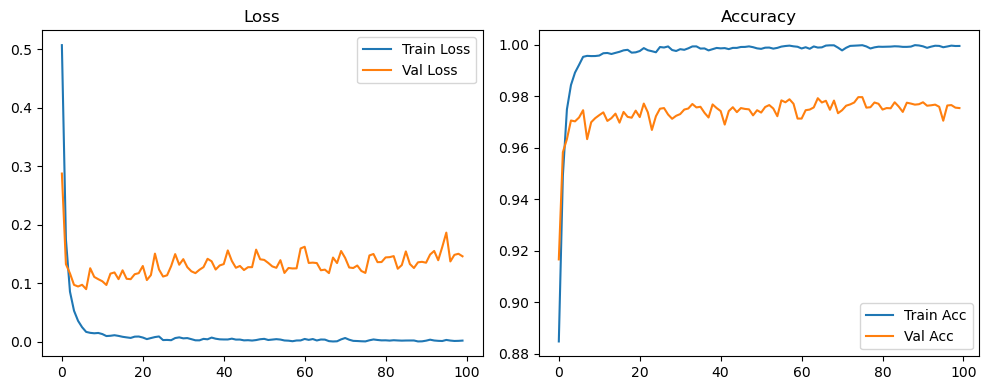

🚀 Running: batch128_lr0.001_0.001_0.001_dp0.2


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.6812, Acc: 0.8336 | Val Loss: 0.3354, Acc: 0.9031


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.3525, Acc: 0.8943 | Val Loss: 0.2423, Acc: 0.9260


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.2732, Acc: 0.9174 | Val Loss: 0.1990, Acc: 0.9391


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.2288, Acc: 0.9313 | Val Loss: 0.1685, Acc: 0.9483


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.2050, Acc: 0.9369 | Val Loss: 0.1548, Acc: 0.9523


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.1808, Acc: 0.9446 | Val Loss: 0.1455, Acc: 0.9553


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.1606, Acc: 0.9494 | Val Loss: 0.1371, Acc: 0.9597


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.1456, Acc: 0.9534 | Val Loss: 0.1359, Acc: 0.9583


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.1366, Acc: 0.9568 | Val Loss: 0.1274, Acc: 0.9617


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.1280, Acc: 0.9589 | Val Loss: 0.1276, Acc: 0.9631


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.1255, Acc: 0.9600 | Val Loss: 0.1281, Acc: 0.9637


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.1096, Acc: 0.9646 | Val Loss: 0.1247, Acc: 0.9651


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.1064, Acc: 0.9659 | Val Loss: 0.1228, Acc: 0.9653


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0963, Acc: 0.9686 | Val Loss: 0.1191, Acc: 0.9661


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0938, Acc: 0.9690 | Val Loss: 0.1274, Acc: 0.9637


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0893, Acc: 0.9717 | Val Loss: 0.1139, Acc: 0.9685


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0895, Acc: 0.9706 | Val Loss: 0.1165, Acc: 0.9679


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0829, Acc: 0.9727 | Val Loss: 0.1160, Acc: 0.9679


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0787, Acc: 0.9741 | Val Loss: 0.1172, Acc: 0.9669


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0745, Acc: 0.9754 | Val Loss: 0.1172, Acc: 0.9680


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0722, Acc: 0.9764 | Val Loss: 0.1149, Acc: 0.9682


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0686, Acc: 0.9775 | Val Loss: 0.1185, Acc: 0.9681


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0669, Acc: 0.9778 | Val Loss: 0.1134, Acc: 0.9692


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0644, Acc: 0.9788 | Val Loss: 0.1239, Acc: 0.9672


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0626, Acc: 0.9791 | Val Loss: 0.1234, Acc: 0.9683


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0608, Acc: 0.9804 | Val Loss: 0.1231, Acc: 0.9683


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0572, Acc: 0.9811 | Val Loss: 0.1262, Acc: 0.9683


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0550, Acc: 0.9820 | Val Loss: 0.1158, Acc: 0.9699


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0522, Acc: 0.9828 | Val Loss: 0.1209, Acc: 0.9695


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0544, Acc: 0.9815 | Val Loss: 0.1185, Acc: 0.9697


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0486, Acc: 0.9829 | Val Loss: 0.1223, Acc: 0.9690


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0516, Acc: 0.9823 | Val Loss: 0.1189, Acc: 0.9712


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0485, Acc: 0.9838 | Val Loss: 0.1232, Acc: 0.9688


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0457, Acc: 0.9848 | Val Loss: 0.1184, Acc: 0.9704


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0450, Acc: 0.9846 | Val Loss: 0.1213, Acc: 0.9697


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0459, Acc: 0.9842 | Val Loss: 0.1206, Acc: 0.9692


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0408, Acc: 0.9860 | Val Loss: 0.1239, Acc: 0.9700


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0421, Acc: 0.9854 | Val Loss: 0.1270, Acc: 0.9689


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0404, Acc: 0.9861 | Val Loss: 0.1266, Acc: 0.9696


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0422, Acc: 0.9857 | Val Loss: 0.1297, Acc: 0.9691


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0381, Acc: 0.9875 | Val Loss: 0.1214, Acc: 0.9708


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0391, Acc: 0.9869 | Val Loss: 0.1206, Acc: 0.9703


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0366, Acc: 0.9875 | Val Loss: 0.1262, Acc: 0.9686


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0385, Acc: 0.9867 | Val Loss: 0.1218, Acc: 0.9698


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0375, Acc: 0.9870 | Val Loss: 0.1246, Acc: 0.9702


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0353, Acc: 0.9885 | Val Loss: 0.1249, Acc: 0.9718


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0345, Acc: 0.9881 | Val Loss: 0.1328, Acc: 0.9696


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0333, Acc: 0.9891 | Val Loss: 0.1300, Acc: 0.9706


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0332, Acc: 0.9893 | Val Loss: 0.1308, Acc: 0.9699


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0337, Acc: 0.9884 | Val Loss: 0.1274, Acc: 0.9709


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0322, Acc: 0.9894 | Val Loss: 0.1268, Acc: 0.9709


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0335, Acc: 0.9888 | Val Loss: 0.1311, Acc: 0.9717


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0315, Acc: 0.9896 | Val Loss: 0.1263, Acc: 0.9713


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0310, Acc: 0.9893 | Val Loss: 0.1401, Acc: 0.9688


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0313, Acc: 0.9892 | Val Loss: 0.1297, Acc: 0.9720


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0288, Acc: 0.9903 | Val Loss: 0.1283, Acc: 0.9725


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0292, Acc: 0.9900 | Val Loss: 0.1299, Acc: 0.9718


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0294, Acc: 0.9900 | Val Loss: 0.1268, Acc: 0.9718


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0292, Acc: 0.9896 | Val Loss: 0.1263, Acc: 0.9716


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0290, Acc: 0.9904 | Val Loss: 0.1290, Acc: 0.9728


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0263, Acc: 0.9910 | Val Loss: 0.1334, Acc: 0.9718


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0276, Acc: 0.9906 | Val Loss: 0.1309, Acc: 0.9733


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0262, Acc: 0.9910 | Val Loss: 0.1280, Acc: 0.9718


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0290, Acc: 0.9901 | Val Loss: 0.1320, Acc: 0.9717


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0276, Acc: 0.9906 | Val Loss: 0.1314, Acc: 0.9712


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0265, Acc: 0.9909 | Val Loss: 0.1296, Acc: 0.9714


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0239, Acc: 0.9924 | Val Loss: 0.1323, Acc: 0.9716


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0245, Acc: 0.9914 | Val Loss: 0.1302, Acc: 0.9714


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0259, Acc: 0.9914 | Val Loss: 0.1298, Acc: 0.9712


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0248, Acc: 0.9911 | Val Loss: 0.1310, Acc: 0.9722


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0246, Acc: 0.9919 | Val Loss: 0.1282, Acc: 0.9730


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0237, Acc: 0.9917 | Val Loss: 0.1376, Acc: 0.9703


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0255, Acc: 0.9918 | Val Loss: 0.1326, Acc: 0.9702


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0241, Acc: 0.9919 | Val Loss: 0.1378, Acc: 0.9706


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0244, Acc: 0.9923 | Val Loss: 0.1314, Acc: 0.9718


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0256, Acc: 0.9918 | Val Loss: 0.1286, Acc: 0.9714


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0232, Acc: 0.9924 | Val Loss: 0.1286, Acc: 0.9727


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0212, Acc: 0.9924 | Val Loss: 0.1341, Acc: 0.9729


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0228, Acc: 0.9920 | Val Loss: 0.1360, Acc: 0.9732


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0219, Acc: 0.9928 | Val Loss: 0.1374, Acc: 0.9712


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0213, Acc: 0.9930 | Val Loss: 0.1364, Acc: 0.9725


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0211, Acc: 0.9928 | Val Loss: 0.1418, Acc: 0.9706


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0218, Acc: 0.9923 | Val Loss: 0.1424, Acc: 0.9714


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0211, Acc: 0.9928 | Val Loss: 0.1392, Acc: 0.9719


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0225, Acc: 0.9926 | Val Loss: 0.1490, Acc: 0.9712


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0209, Acc: 0.9932 | Val Loss: 0.1350, Acc: 0.9720


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0203, Acc: 0.9932 | Val Loss: 0.1398, Acc: 0.9716


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0210, Acc: 0.9926 | Val Loss: 0.1454, Acc: 0.9712


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0201, Acc: 0.9931 | Val Loss: 0.1353, Acc: 0.9728


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0195, Acc: 0.9938 | Val Loss: 0.1326, Acc: 0.9725


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0191, Acc: 0.9938 | Val Loss: 0.1418, Acc: 0.9707


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0195, Acc: 0.9934 | Val Loss: 0.1412, Acc: 0.9711


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0214, Acc: 0.9931 | Val Loss: 0.1394, Acc: 0.9718


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0191, Acc: 0.9934 | Val Loss: 0.1413, Acc: 0.9726


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0194, Acc: 0.9937 | Val Loss: 0.1431, Acc: 0.9727


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0194, Acc: 0.9937 | Val Loss: 0.1463, Acc: 0.9714


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0188, Acc: 0.9940 | Val Loss: 0.1377, Acc: 0.9713


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0177, Acc: 0.9937 | Val Loss: 0.1430, Acc: 0.9712


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0185, Acc: 0.9942 | Val Loss: 0.1403, Acc: 0.9726


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0160, Acc: 0.9945 | Val Loss: 0.1413, Acc: 0.9730


Final Test Loss: 0.1153 Accuracy: 0.9767


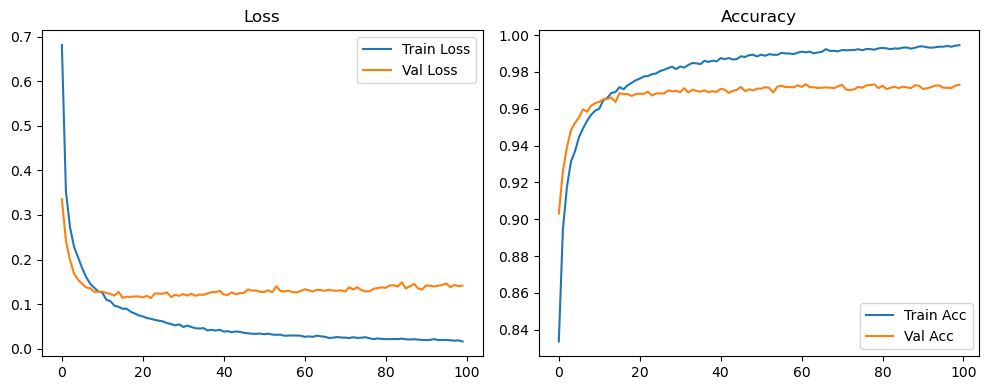

🚀 Running: batch128_lr0.001_0.001_0.001_dp0.5


Epoch 1/100 - LR: 0.00100 | Train Loss: 1.1112, Acc: 0.6595 | Val Loss: 0.4352, Acc: 0.8872


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.6174, Acc: 0.8110 | Val Loss: 0.3453, Acc: 0.9002


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.5078, Acc: 0.8491 | Val Loss: 0.3125, Acc: 0.9082


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.4562, Acc: 0.8640 | Val Loss: 0.2893, Acc: 0.9141


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.4208, Acc: 0.8740 | Val Loss: 0.2680, Acc: 0.9190


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.3864, Acc: 0.8853 | Val Loss: 0.2569, Acc: 0.9227


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.3587, Acc: 0.8943 | Val Loss: 0.2408, Acc: 0.9284


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.3366, Acc: 0.8999 | Val Loss: 0.2330, Acc: 0.9292


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.3235, Acc: 0.9041 | Val Loss: 0.2218, Acc: 0.9323


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.3080, Acc: 0.9083 | Val Loss: 0.2152, Acc: 0.9351


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.2939, Acc: 0.9111 | Val Loss: 0.2064, Acc: 0.9378


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.2818, Acc: 0.9160 | Val Loss: 0.1919, Acc: 0.9423


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.2689, Acc: 0.9185 | Val Loss: 0.1925, Acc: 0.9433


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.2555, Acc: 0.9239 | Val Loss: 0.1845, Acc: 0.9441


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.2485, Acc: 0.9268 | Val Loss: 0.1822, Acc: 0.9457


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.2386, Acc: 0.9295 | Val Loss: 0.1749, Acc: 0.9483


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.2273, Acc: 0.9313 | Val Loss: 0.1674, Acc: 0.9509


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.2197, Acc: 0.9338 | Val Loss: 0.1652, Acc: 0.9515


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.2135, Acc: 0.9363 | Val Loss: 0.1622, Acc: 0.9514


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.2091, Acc: 0.9371 | Val Loss: 0.1562, Acc: 0.9543


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.1978, Acc: 0.9393 | Val Loss: 0.1561, Acc: 0.9549


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.1969, Acc: 0.9409 | Val Loss: 0.1551, Acc: 0.9547


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.1906, Acc: 0.9419 | Val Loss: 0.1525, Acc: 0.9544


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.1851, Acc: 0.9443 | Val Loss: 0.1497, Acc: 0.9553


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.1804, Acc: 0.9447 | Val Loss: 0.1504, Acc: 0.9558


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.1758, Acc: 0.9472 | Val Loss: 0.1414, Acc: 0.9591


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.1736, Acc: 0.9480 | Val Loss: 0.1444, Acc: 0.9585


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.1631, Acc: 0.9493 | Val Loss: 0.1395, Acc: 0.9593


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.1622, Acc: 0.9502 | Val Loss: 0.1399, Acc: 0.9589


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.1595, Acc: 0.9523 | Val Loss: 0.1374, Acc: 0.9623


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.1570, Acc: 0.9527 | Val Loss: 0.1350, Acc: 0.9618


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.1530, Acc: 0.9536 | Val Loss: 0.1348, Acc: 0.9623


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.1480, Acc: 0.9553 | Val Loss: 0.1312, Acc: 0.9637


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.1438, Acc: 0.9556 | Val Loss: 0.1274, Acc: 0.9636


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.1431, Acc: 0.9561 | Val Loss: 0.1327, Acc: 0.9639


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.1437, Acc: 0.9555 | Val Loss: 0.1275, Acc: 0.9637


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.1365, Acc: 0.9579 | Val Loss: 0.1285, Acc: 0.9639


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.1363, Acc: 0.9573 | Val Loss: 0.1301, Acc: 0.9634


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.1320, Acc: 0.9589 | Val Loss: 0.1314, Acc: 0.9643


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.1320, Acc: 0.9593 | Val Loss: 0.1263, Acc: 0.9646


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.1293, Acc: 0.9601 | Val Loss: 0.1280, Acc: 0.9653


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.1243, Acc: 0.9616 | Val Loss: 0.1286, Acc: 0.9651


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.1199, Acc: 0.9632 | Val Loss: 0.1288, Acc: 0.9640


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.1240, Acc: 0.9614 | Val Loss: 0.1265, Acc: 0.9649


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.1240, Acc: 0.9615 | Val Loss: 0.1295, Acc: 0.9656


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.1198, Acc: 0.9620 | Val Loss: 0.1253, Acc: 0.9663


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.1212, Acc: 0.9615 | Val Loss: 0.1236, Acc: 0.9667


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.1183, Acc: 0.9633 | Val Loss: 0.1253, Acc: 0.9667


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.1161, Acc: 0.9637 | Val Loss: 0.1240, Acc: 0.9666


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.1127, Acc: 0.9645 | Val Loss: 0.1236, Acc: 0.9664


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.1116, Acc: 0.9650 | Val Loss: 0.1226, Acc: 0.9670


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.1086, Acc: 0.9656 | Val Loss: 0.1241, Acc: 0.9664


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.1096, Acc: 0.9654 | Val Loss: 0.1247, Acc: 0.9670


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.1093, Acc: 0.9651 | Val Loss: 0.1251, Acc: 0.9665


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.1051, Acc: 0.9665 | Val Loss: 0.1231, Acc: 0.9673


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.1033, Acc: 0.9674 | Val Loss: 0.1246, Acc: 0.9676


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.1017, Acc: 0.9674 | Val Loss: 0.1209, Acc: 0.9683


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.1044, Acc: 0.9677 | Val Loss: 0.1217, Acc: 0.9680


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.1025, Acc: 0.9677 | Val Loss: 0.1219, Acc: 0.9680


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0991, Acc: 0.9675 | Val Loss: 0.1229, Acc: 0.9683


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0987, Acc: 0.9694 | Val Loss: 0.1252, Acc: 0.9671


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0939, Acc: 0.9696 | Val Loss: 0.1229, Acc: 0.9684


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0932, Acc: 0.9710 | Val Loss: 0.1193, Acc: 0.9690


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0972, Acc: 0.9691 | Val Loss: 0.1188, Acc: 0.9685


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0980, Acc: 0.9675 | Val Loss: 0.1235, Acc: 0.9683


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0934, Acc: 0.9705 | Val Loss: 0.1200, Acc: 0.9683


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0880, Acc: 0.9713 | Val Loss: 0.1237, Acc: 0.9671


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0909, Acc: 0.9719 | Val Loss: 0.1192, Acc: 0.9692


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0926, Acc: 0.9699 | Val Loss: 0.1192, Acc: 0.9693


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0896, Acc: 0.9709 | Val Loss: 0.1208, Acc: 0.9692


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0915, Acc: 0.9710 | Val Loss: 0.1185, Acc: 0.9694


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0880, Acc: 0.9719 | Val Loss: 0.1205, Acc: 0.9688


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0853, Acc: 0.9734 | Val Loss: 0.1208, Acc: 0.9691


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0896, Acc: 0.9719 | Val Loss: 0.1213, Acc: 0.9701


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0891, Acc: 0.9711 | Val Loss: 0.1191, Acc: 0.9692


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0888, Acc: 0.9713 | Val Loss: 0.1156, Acc: 0.9710


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0850, Acc: 0.9728 | Val Loss: 0.1192, Acc: 0.9706


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0843, Acc: 0.9740 | Val Loss: 0.1229, Acc: 0.9695


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0836, Acc: 0.9730 | Val Loss: 0.1196, Acc: 0.9702


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0772, Acc: 0.9746 | Val Loss: 0.1190, Acc: 0.9696


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0824, Acc: 0.9739 | Val Loss: 0.1190, Acc: 0.9702


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0832, Acc: 0.9734 | Val Loss: 0.1196, Acc: 0.9685


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0790, Acc: 0.9746 | Val Loss: 0.1196, Acc: 0.9696


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0775, Acc: 0.9744 | Val Loss: 0.1183, Acc: 0.9698


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0804, Acc: 0.9744 | Val Loss: 0.1215, Acc: 0.9692


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0782, Acc: 0.9754 | Val Loss: 0.1205, Acc: 0.9692


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0778, Acc: 0.9750 | Val Loss: 0.1236, Acc: 0.9689


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0801, Acc: 0.9746 | Val Loss: 0.1202, Acc: 0.9702


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0785, Acc: 0.9741 | Val Loss: 0.1193, Acc: 0.9695


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0748, Acc: 0.9759 | Val Loss: 0.1170, Acc: 0.9702


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0753, Acc: 0.9761 | Val Loss: 0.1194, Acc: 0.9696


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0764, Acc: 0.9751 | Val Loss: 0.1176, Acc: 0.9701


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0767, Acc: 0.9753 | Val Loss: 0.1201, Acc: 0.9702


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0754, Acc: 0.9760 | Val Loss: 0.1182, Acc: 0.9705


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0734, Acc: 0.9759 | Val Loss: 0.1204, Acc: 0.9709


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0742, Acc: 0.9760 | Val Loss: 0.1173, Acc: 0.9708


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0752, Acc: 0.9760 | Val Loss: 0.1171, Acc: 0.9708


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0696, Acc: 0.9775 | Val Loss: 0.1197, Acc: 0.9703


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0721, Acc: 0.9776 | Val Loss: 0.1218, Acc: 0.9703


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0710, Acc: 0.9772 | Val Loss: 0.1183, Acc: 0.9700


Final Test Loss: 0.1097 Accuracy: 0.9728


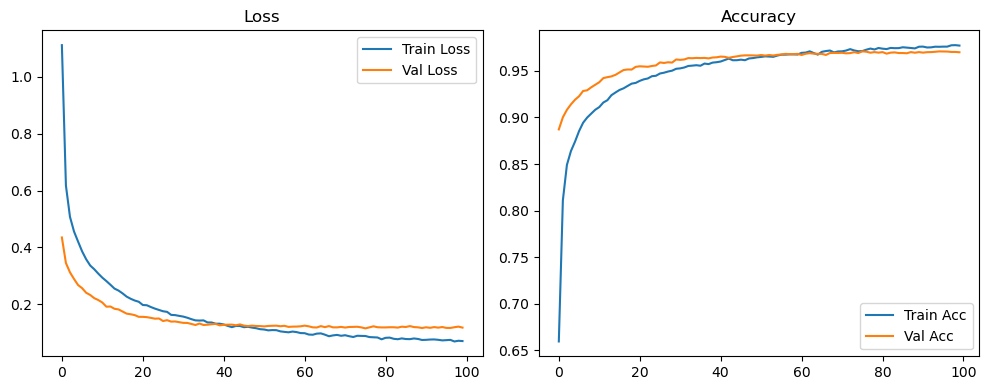

🚀 Running: batch256_lr0.01_0.01_0.01_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3853, Acc: 0.8867 | Val Loss: 0.2894, Acc: 0.9107


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1916, Acc: 0.9421 | Val Loss: 0.1868, Acc: 0.9407


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1128, Acc: 0.9646 | Val Loss: 0.1458, Acc: 0.9567


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0757, Acc: 0.9763 | Val Loss: 0.1433, Acc: 0.9572


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0532, Acc: 0.9825 | Val Loss: 0.1381, Acc: 0.9619


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0408, Acc: 0.9865 | Val Loss: 0.1294, Acc: 0.9645


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0291, Acc: 0.9900 | Val Loss: 0.1326, Acc: 0.9660


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9920 | Val Loss: 0.1530, Acc: 0.9603


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9927 | Val Loss: 0.1318, Acc: 0.9691


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0244, Acc: 0.9914 | Val Loss: 0.1453, Acc: 0.9673


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9914 | Val Loss: 0.1669, Acc: 0.9638


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9943 | Val Loss: 0.1334, Acc: 0.9717


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9955 | Val Loss: 0.1488, Acc: 0.9701


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9949 | Val Loss: 0.1761, Acc: 0.9640


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9941 | Val Loss: 0.1660, Acc: 0.9667


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9948 | Val Loss: 0.1592, Acc: 0.9683


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9960 | Val Loss: 0.1547, Acc: 0.9700


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9949 | Val Loss: 0.1573, Acc: 0.9688


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9963 | Val Loss: 0.1569, Acc: 0.9680


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9955 | Val Loss: 0.1675, Acc: 0.9688


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9957 | Val Loss: 0.1620, Acc: 0.9702


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9958 | Val Loss: 0.1604, Acc: 0.9700


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9975 | Val Loss: 0.1548, Acc: 0.9718


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9969 | Val Loss: 0.1799, Acc: 0.9698


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9966 | Val Loss: 0.1729, Acc: 0.9691


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9966 | Val Loss: 0.1669, Acc: 0.9709


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.1721, Acc: 0.9708


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9973 | Val Loss: 0.2190, Acc: 0.9648


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9964 | Val Loss: 0.1986, Acc: 0.9685


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9969 | Val Loss: 0.1876, Acc: 0.9706


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9964 | Val Loss: 0.1855, Acc: 0.9712


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9973 | Val Loss: 0.1621, Acc: 0.9741


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9969 | Val Loss: 0.1927, Acc: 0.9712


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1978, Acc: 0.9698


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9974 | Val Loss: 0.1752, Acc: 0.9698


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.1552, Acc: 0.9736


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.1532, Acc: 0.9722


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1860, Acc: 0.9728


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1708, Acc: 0.9715


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.1639, Acc: 0.9717


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9980 | Val Loss: 0.1752, Acc: 0.9707


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.1433, Acc: 0.9740


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1599, Acc: 0.9744


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1643, Acc: 0.9738


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.2070, Acc: 0.9711


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.2095, Acc: 0.9623


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.1307, Acc: 0.9732


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9989 | Val Loss: 0.1481, Acc: 0.9755


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9983 | Val Loss: 0.1431, Acc: 0.9725


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1643, Acc: 0.9733


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.2048, Acc: 0.9665


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.2188, Acc: 0.9578


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1367, Acc: 0.9748


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1564, Acc: 0.9748


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.2293, Acc: 0.9666


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9973 | Val Loss: 0.1730, Acc: 0.9698


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1279, Acc: 0.9751


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1459, Acc: 0.9742


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1282, Acc: 0.9751


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1674, Acc: 0.9710


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1824, Acc: 0.9723


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.1490, Acc: 0.9741


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1589, Acc: 0.9722


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.2395, Acc: 0.9649


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1594, Acc: 0.9737


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.1819, Acc: 0.9710


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1368, Acc: 0.9755


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1510, Acc: 0.9758


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1788, Acc: 0.9715


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1403, Acc: 0.9758


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1718, Acc: 0.9731


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1644, Acc: 0.9712


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1455, Acc: 0.9726


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.1493, Acc: 0.9748


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1728, Acc: 0.9756


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1582, Acc: 0.9736


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1544, Acc: 0.9758


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1928, Acc: 0.9690


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1665, Acc: 0.9727


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1617, Acc: 0.9727


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1619, Acc: 0.9746


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9987 | Val Loss: 0.1713, Acc: 0.9748


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1812, Acc: 0.9754


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1739, Acc: 0.9733


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1766, Acc: 0.9728


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1349, Acc: 0.9740


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1655, Acc: 0.9728


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1967, Acc: 0.9729


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1782, Acc: 0.9743


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1696, Acc: 0.9732


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1695, Acc: 0.9742


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1539, Acc: 0.9743


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.1852, Acc: 0.9722


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1618, Acc: 0.9738


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9987 | Val Loss: 0.1633, Acc: 0.9747


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1979, Acc: 0.9748


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1507, Acc: 0.9759


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1451, Acc: 0.9741


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1564, Acc: 0.9762


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1370, Acc: 0.9760


Final Test Loss: 0.1148 Accuracy: 0.9788


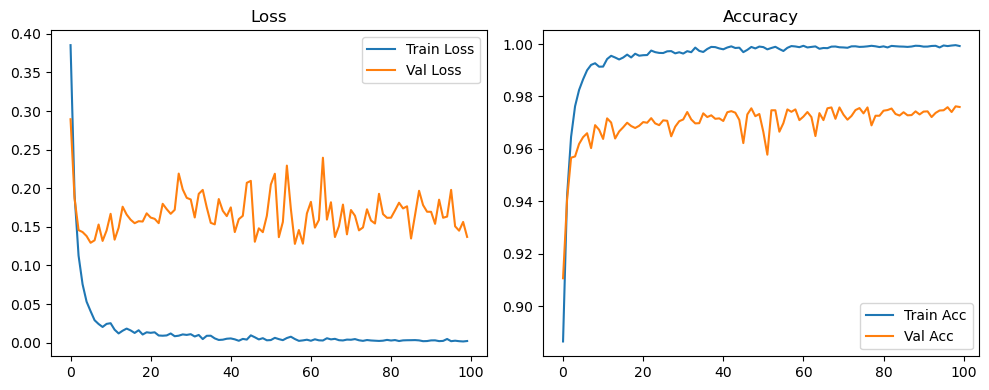

🚀 Running: batch256_lr0.01_0.01_0.01_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4888, Acc: 0.8513 | Val Loss: 0.2794, Acc: 0.9163


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2696, Acc: 0.9182 | Val Loss: 0.2094, Acc: 0.9364


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1922, Acc: 0.9415 | Val Loss: 0.1766, Acc: 0.9479


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1451, Acc: 0.9553 | Val Loss: 0.1272, Acc: 0.9627


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1253, Acc: 0.9604 | Val Loss: 0.1224, Acc: 0.9643


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1003, Acc: 0.9674 | Val Loss: 0.1171, Acc: 0.9673


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0862, Acc: 0.9725 | Val Loss: 0.1144, Acc: 0.9672


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0762, Acc: 0.9755 | Val Loss: 0.1099, Acc: 0.9688


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0635, Acc: 0.9782 | Val Loss: 0.1194, Acc: 0.9688


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0611, Acc: 0.9796 | Val Loss: 0.1076, Acc: 0.9704


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0528, Acc: 0.9829 | Val Loss: 0.1101, Acc: 0.9721


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0483, Acc: 0.9835 | Val Loss: 0.1101, Acc: 0.9712


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0444, Acc: 0.9853 | Val Loss: 0.1073, Acc: 0.9731


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0431, Acc: 0.9860 | Val Loss: 0.1159, Acc: 0.9718


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0379, Acc: 0.9874 | Val Loss: 0.1111, Acc: 0.9722


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0359, Acc: 0.9882 | Val Loss: 0.1093, Acc: 0.9735


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0340, Acc: 0.9886 | Val Loss: 0.1124, Acc: 0.9745


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0341, Acc: 0.9883 | Val Loss: 0.1043, Acc: 0.9761


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0316, Acc: 0.9897 | Val Loss: 0.1058, Acc: 0.9751


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0309, Acc: 0.9898 | Val Loss: 0.1059, Acc: 0.9748


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0304, Acc: 0.9897 | Val Loss: 0.1054, Acc: 0.9757


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0285, Acc: 0.9904 | Val Loss: 0.1072, Acc: 0.9740


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9908 | Val Loss: 0.1082, Acc: 0.9747


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0244, Acc: 0.9916 | Val Loss: 0.1108, Acc: 0.9743


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0244, Acc: 0.9918 | Val Loss: 0.1125, Acc: 0.9745


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0257, Acc: 0.9914 | Val Loss: 0.1074, Acc: 0.9742


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0224, Acc: 0.9923 | Val Loss: 0.1118, Acc: 0.9753


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0213, Acc: 0.9931 | Val Loss: 0.1177, Acc: 0.9743


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9932 | Val Loss: 0.1112, Acc: 0.9743


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9930 | Val Loss: 0.1005, Acc: 0.9771


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9925 | Val Loss: 0.1078, Acc: 0.9752


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0200, Acc: 0.9932 | Val Loss: 0.1037, Acc: 0.9768


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0211, Acc: 0.9928 | Val Loss: 0.1177, Acc: 0.9752


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0186, Acc: 0.9939 | Val Loss: 0.1125, Acc: 0.9758


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0184, Acc: 0.9938 | Val Loss: 0.1177, Acc: 0.9762


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9944 | Val Loss: 0.1182, Acc: 0.9754


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9935 | Val Loss: 0.1219, Acc: 0.9750


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9942 | Val Loss: 0.1162, Acc: 0.9763


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9939 | Val Loss: 0.1201, Acc: 0.9747


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9941 | Val Loss: 0.1095, Acc: 0.9772


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9949 | Val Loss: 0.1184, Acc: 0.9772


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9950 | Val Loss: 0.1307, Acc: 0.9753


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9951 | Val Loss: 0.1296, Acc: 0.9771


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9955 | Val Loss: 0.1278, Acc: 0.9759


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9948 | Val Loss: 0.1161, Acc: 0.9756


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9947 | Val Loss: 0.1160, Acc: 0.9763


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9949 | Val Loss: 0.1109, Acc: 0.9775


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9951 | Val Loss: 0.1213, Acc: 0.9758


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9958 | Val Loss: 0.1205, Acc: 0.9773


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9958 | Val Loss: 0.1070, Acc: 0.9775


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9959 | Val Loss: 0.1083, Acc: 0.9775


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9959 | Val Loss: 0.1100, Acc: 0.9785


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9957 | Val Loss: 0.1257, Acc: 0.9754


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9957 | Val Loss: 0.1173, Acc: 0.9775


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9956 | Val Loss: 0.1176, Acc: 0.9770


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9958 | Val Loss: 0.1089, Acc: 0.9769


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9960 | Val Loss: 0.1266, Acc: 0.9758


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9960 | Val Loss: 0.1145, Acc: 0.9768


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9959 | Val Loss: 0.1305, Acc: 0.9770


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9962 | Val Loss: 0.1131, Acc: 0.9758


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.1251, Acc: 0.9752


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9964 | Val Loss: 0.1271, Acc: 0.9768


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9965 | Val Loss: 0.1206, Acc: 0.9758


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9959 | Val Loss: 0.1205, Acc: 0.9762


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9961 | Val Loss: 0.1185, Acc: 0.9758


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9959 | Val Loss: 0.1026, Acc: 0.9772


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9963 | Val Loss: 0.1254, Acc: 0.9764


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9968 | Val Loss: 0.1189, Acc: 0.9770


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9966 | Val Loss: 0.1089, Acc: 0.9767


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9965 | Val Loss: 0.1276, Acc: 0.9755


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9967 | Val Loss: 0.1410, Acc: 0.9768


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9966 | Val Loss: 0.1128, Acc: 0.9772


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9969 | Val Loss: 0.1317, Acc: 0.9780


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9966 | Val Loss: 0.1244, Acc: 0.9772


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9967 | Val Loss: 0.1238, Acc: 0.9782


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9967 | Val Loss: 0.1021, Acc: 0.9774


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.1370, Acc: 0.9783


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9972 | Val Loss: 0.1324, Acc: 0.9772


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.1138, Acc: 0.9781


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.1325, Acc: 0.9778


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.1213, Acc: 0.9771


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9970 | Val Loss: 0.1078, Acc: 0.9776


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9969 | Val Loss: 0.1176, Acc: 0.9773


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.1340, Acc: 0.9782


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9969 | Val Loss: 0.1272, Acc: 0.9770


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9972 | Val Loss: 0.1107, Acc: 0.9774


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9973 | Val Loss: 0.1312, Acc: 0.9774


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.1288, Acc: 0.9778


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.1245, Acc: 0.9769


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9971 | Val Loss: 0.1188, Acc: 0.9772


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9972 | Val Loss: 0.1147, Acc: 0.9773


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9974 | Val Loss: 0.1386, Acc: 0.9768


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.1428, Acc: 0.9766


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9973 | Val Loss: 0.1244, Acc: 0.9771


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9971 | Val Loss: 0.1432, Acc: 0.9783


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.1211, Acc: 0.9779


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9973 | Val Loss: 0.1245, Acc: 0.9794


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.1128, Acc: 0.9782


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9974 | Val Loss: 0.1148, Acc: 0.9794


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9976 | Val Loss: 0.1034, Acc: 0.9785


Final Test Loss: 0.1018 Accuracy: 0.9800


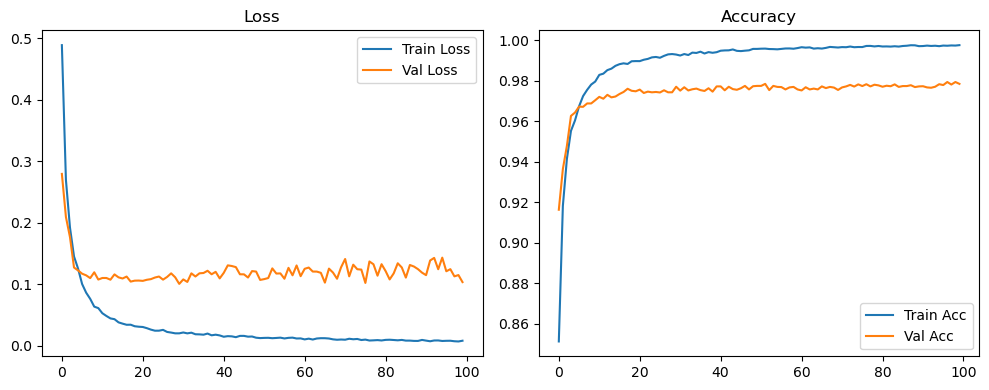

🚀 Running: batch256_lr0.01_0.01_0.01_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.7479, Acc: 0.7590 | Val Loss: 0.3265, Acc: 0.9031


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.4263, Acc: 0.8720 | Val Loss: 0.2593, Acc: 0.9233


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.3422, Acc: 0.8983 | Val Loss: 0.2261, Acc: 0.9355


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2826, Acc: 0.9164 | Val Loss: 0.1737, Acc: 0.9473


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.2450, Acc: 0.9271 | Val Loss: 0.1546, Acc: 0.9528


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.2158, Acc: 0.9349 | Val Loss: 0.1495, Acc: 0.9574


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1984, Acc: 0.9412 | Val Loss: 0.1393, Acc: 0.9601


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1793, Acc: 0.9452 | Val Loss: 0.1328, Acc: 0.9606


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1686, Acc: 0.9487 | Val Loss: 0.1222, Acc: 0.9644


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1555, Acc: 0.9526 | Val Loss: 0.1182, Acc: 0.9647


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1465, Acc: 0.9556 | Val Loss: 0.1203, Acc: 0.9664


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1380, Acc: 0.9576 | Val Loss: 0.1137, Acc: 0.9674


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1337, Acc: 0.9590 | Val Loss: 0.1139, Acc: 0.9668


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1282, Acc: 0.9610 | Val Loss: 0.1100, Acc: 0.9682


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1182, Acc: 0.9636 | Val Loss: 0.1089, Acc: 0.9698


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1199, Acc: 0.9629 | Val Loss: 0.1093, Acc: 0.9688


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1147, Acc: 0.9651 | Val Loss: 0.1027, Acc: 0.9702


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1069, Acc: 0.9663 | Val Loss: 0.1022, Acc: 0.9718


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1042, Acc: 0.9679 | Val Loss: 0.1033, Acc: 0.9708


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0987, Acc: 0.9690 | Val Loss: 0.1027, Acc: 0.9718


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.1008, Acc: 0.9682 | Val Loss: 0.1043, Acc: 0.9712


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0966, Acc: 0.9696 | Val Loss: 0.1028, Acc: 0.9719


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0926, Acc: 0.9711 | Val Loss: 0.1017, Acc: 0.9732


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0895, Acc: 0.9719 | Val Loss: 0.1063, Acc: 0.9697


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0869, Acc: 0.9722 | Val Loss: 0.1069, Acc: 0.9718


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0871, Acc: 0.9723 | Val Loss: 0.1068, Acc: 0.9720


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0838, Acc: 0.9736 | Val Loss: 0.1079, Acc: 0.9729


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0803, Acc: 0.9749 | Val Loss: 0.1050, Acc: 0.9734


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0782, Acc: 0.9750 | Val Loss: 0.0992, Acc: 0.9721


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0812, Acc: 0.9740 | Val Loss: 0.1036, Acc: 0.9723


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0743, Acc: 0.9761 | Val Loss: 0.1004, Acc: 0.9732


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0743, Acc: 0.9762 | Val Loss: 0.1012, Acc: 0.9726


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0729, Acc: 0.9781 | Val Loss: 0.0978, Acc: 0.9732


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0695, Acc: 0.9782 | Val Loss: 0.1017, Acc: 0.9721


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0714, Acc: 0.9779 | Val Loss: 0.0974, Acc: 0.9722


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0701, Acc: 0.9777 | Val Loss: 0.1029, Acc: 0.9732


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0702, Acc: 0.9774 | Val Loss: 0.1021, Acc: 0.9726


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0671, Acc: 0.9784 | Val Loss: 0.0985, Acc: 0.9726


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0659, Acc: 0.9793 | Val Loss: 0.0985, Acc: 0.9738


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0662, Acc: 0.9787 | Val Loss: 0.1033, Acc: 0.9734


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0672, Acc: 0.9787 | Val Loss: 0.1066, Acc: 0.9743


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0638, Acc: 0.9802 | Val Loss: 0.1047, Acc: 0.9752


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0614, Acc: 0.9809 | Val Loss: 0.1042, Acc: 0.9743


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0619, Acc: 0.9801 | Val Loss: 0.1010, Acc: 0.9751


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0629, Acc: 0.9802 | Val Loss: 0.0956, Acc: 0.9748


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0599, Acc: 0.9818 | Val Loss: 0.0975, Acc: 0.9754


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0577, Acc: 0.9815 | Val Loss: 0.0934, Acc: 0.9762


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0596, Acc: 0.9810 | Val Loss: 0.1025, Acc: 0.9739


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0591, Acc: 0.9811 | Val Loss: 0.1026, Acc: 0.9752


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0551, Acc: 0.9825 | Val Loss: 0.0978, Acc: 0.9752


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0566, Acc: 0.9816 | Val Loss: 0.1021, Acc: 0.9747


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0571, Acc: 0.9817 | Val Loss: 0.0948, Acc: 0.9749


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0526, Acc: 0.9842 | Val Loss: 0.1005, Acc: 0.9756


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0536, Acc: 0.9828 | Val Loss: 0.1018, Acc: 0.9741


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0547, Acc: 0.9820 | Val Loss: 0.1025, Acc: 0.9754


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0527, Acc: 0.9834 | Val Loss: 0.1059, Acc: 0.9744


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0524, Acc: 0.9826 | Val Loss: 0.1040, Acc: 0.9753


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0507, Acc: 0.9833 | Val Loss: 0.1032, Acc: 0.9752


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0500, Acc: 0.9841 | Val Loss: 0.1075, Acc: 0.9734


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0513, Acc: 0.9835 | Val Loss: 0.1051, Acc: 0.9738


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0470, Acc: 0.9855 | Val Loss: 0.1035, Acc: 0.9753


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0499, Acc: 0.9837 | Val Loss: 0.1013, Acc: 0.9749


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0480, Acc: 0.9849 | Val Loss: 0.1023, Acc: 0.9768


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0469, Acc: 0.9848 | Val Loss: 0.1108, Acc: 0.9755


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0476, Acc: 0.9849 | Val Loss: 0.1064, Acc: 0.9747


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0504, Acc: 0.9838 | Val Loss: 0.1014, Acc: 0.9746


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0480, Acc: 0.9840 | Val Loss: 0.1169, Acc: 0.9733


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0492, Acc: 0.9849 | Val Loss: 0.1013, Acc: 0.9744


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0430, Acc: 0.9860 | Val Loss: 0.1073, Acc: 0.9754


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0444, Acc: 0.9862 | Val Loss: 0.1048, Acc: 0.9742


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0444, Acc: 0.9858 | Val Loss: 0.1026, Acc: 0.9749


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0457, Acc: 0.9854 | Val Loss: 0.1002, Acc: 0.9758


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0452, Acc: 0.9860 | Val Loss: 0.1034, Acc: 0.9757


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0440, Acc: 0.9861 | Val Loss: 0.1114, Acc: 0.9752


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0425, Acc: 0.9865 | Val Loss: 0.1097, Acc: 0.9748


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0435, Acc: 0.9860 | Val Loss: 0.0978, Acc: 0.9750


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0407, Acc: 0.9868 | Val Loss: 0.1086, Acc: 0.9748


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0414, Acc: 0.9867 | Val Loss: 0.1084, Acc: 0.9748


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0433, Acc: 0.9862 | Val Loss: 0.1050, Acc: 0.9747


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0427, Acc: 0.9866 | Val Loss: 0.1088, Acc: 0.9751


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0414, Acc: 0.9871 | Val Loss: 0.1039, Acc: 0.9751


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0413, Acc: 0.9867 | Val Loss: 0.1058, Acc: 0.9758


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0405, Acc: 0.9868 | Val Loss: 0.1060, Acc: 0.9749


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0409, Acc: 0.9870 | Val Loss: 0.0992, Acc: 0.9748


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0405, Acc: 0.9869 | Val Loss: 0.1010, Acc: 0.9754


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0412, Acc: 0.9870 | Val Loss: 0.1045, Acc: 0.9748


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0391, Acc: 0.9882 | Val Loss: 0.1127, Acc: 0.9753


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0362, Acc: 0.9884 | Val Loss: 0.1218, Acc: 0.9758


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0387, Acc: 0.9872 | Val Loss: 0.1031, Acc: 0.9741


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0377, Acc: 0.9880 | Val Loss: 0.0953, Acc: 0.9766


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0370, Acc: 0.9889 | Val Loss: 0.1029, Acc: 0.9750


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0384, Acc: 0.9878 | Val Loss: 0.1115, Acc: 0.9746


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0374, Acc: 0.9882 | Val Loss: 0.1001, Acc: 0.9748


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0413, Acc: 0.9869 | Val Loss: 0.1117, Acc: 0.9746


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0356, Acc: 0.9885 | Val Loss: 0.1059, Acc: 0.9763


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0362, Acc: 0.9887 | Val Loss: 0.1020, Acc: 0.9750


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0359, Acc: 0.9889 | Val Loss: 0.1042, Acc: 0.9759


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0360, Acc: 0.9885 | Val Loss: 0.1223, Acc: 0.9749


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0365, Acc: 0.9883 | Val Loss: 0.0973, Acc: 0.9752


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0369, Acc: 0.9879 | Val Loss: 0.1138, Acc: 0.9748


Final Test Loss: 0.1011 Accuracy: 0.9781


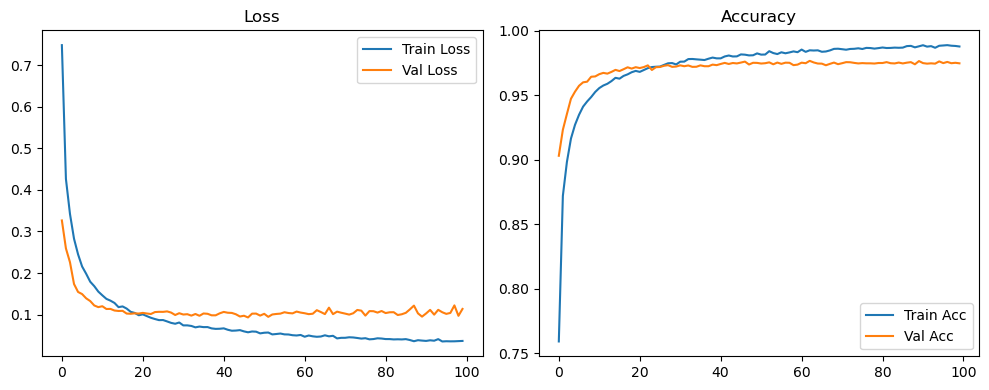

🚀 Running: batch256_lr0.01_0.005_0.002_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3853, Acc: 0.8867 | Val Loss: 0.2894, Acc: 0.9107


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1916, Acc: 0.9421 | Val Loss: 0.1868, Acc: 0.9407


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1128, Acc: 0.9646 | Val Loss: 0.1458, Acc: 0.9567


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0757, Acc: 0.9763 | Val Loss: 0.1433, Acc: 0.9572


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0532, Acc: 0.9825 | Val Loss: 0.1381, Acc: 0.9619


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0408, Acc: 0.9865 | Val Loss: 0.1294, Acc: 0.9645


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0291, Acc: 0.9900 | Val Loss: 0.1326, Acc: 0.9660


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9920 | Val Loss: 0.1530, Acc: 0.9603


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9927 | Val Loss: 0.1318, Acc: 0.9691


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0244, Acc: 0.9914 | Val Loss: 0.1453, Acc: 0.9673


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9914 | Val Loss: 0.1669, Acc: 0.9638


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9943 | Val Loss: 0.1334, Acc: 0.9717


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9955 | Val Loss: 0.1488, Acc: 0.9701


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9949 | Val Loss: 0.1761, Acc: 0.9640


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9941 | Val Loss: 0.1660, Acc: 0.9667


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9948 | Val Loss: 0.1592, Acc: 0.9683


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9960 | Val Loss: 0.1547, Acc: 0.9700


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9949 | Val Loss: 0.1573, Acc: 0.9688


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9963 | Val Loss: 0.1569, Acc: 0.9680


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9955 | Val Loss: 0.1675, Acc: 0.9688


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9957 | Val Loss: 0.1620, Acc: 0.9702


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9958 | Val Loss: 0.1604, Acc: 0.9700


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9975 | Val Loss: 0.1548, Acc: 0.9718


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9969 | Val Loss: 0.1799, Acc: 0.9698


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9966 | Val Loss: 0.1729, Acc: 0.9691


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9966 | Val Loss: 0.1669, Acc: 0.9709


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.1721, Acc: 0.9708


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9973 | Val Loss: 0.2190, Acc: 0.9648


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9964 | Val Loss: 0.1986, Acc: 0.9685


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9969 | Val Loss: 0.1876, Acc: 0.9706


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9964 | Val Loss: 0.1855, Acc: 0.9712


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9973 | Val Loss: 0.1621, Acc: 0.9741


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9969 | Val Loss: 0.1927, Acc: 0.9712


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1978, Acc: 0.9698


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9974 | Val Loss: 0.1752, Acc: 0.9698


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.1552, Acc: 0.9736


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.1532, Acc: 0.9722


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1860, Acc: 0.9728


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1708, Acc: 0.9715


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.1639, Acc: 0.9717


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9980 | Val Loss: 0.1752, Acc: 0.9707


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.1433, Acc: 0.9740


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1599, Acc: 0.9744


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1643, Acc: 0.9738


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.2070, Acc: 0.9711


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.2095, Acc: 0.9623


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.1307, Acc: 0.9732


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9989 | Val Loss: 0.1481, Acc: 0.9755


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9983 | Val Loss: 0.1431, Acc: 0.9725


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1643, Acc: 0.9733


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.1580, Acc: 0.9768


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.1629, Acc: 0.9767


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1742, Acc: 0.9778


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1675, Acc: 0.9775


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1720, Acc: 0.9772


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1652, Acc: 0.9784


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1658, Acc: 0.9781


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1702, Acc: 0.9781


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1702, Acc: 0.9784


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1902, Acc: 0.9742


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1597, Acc: 0.9748


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1730, Acc: 0.9749


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1572, Acc: 0.9744


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1427, Acc: 0.9762


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9995 | Val Loss: 0.1657, Acc: 0.9761


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1645, Acc: 0.9770


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1529, Acc: 0.9749


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1547, Acc: 0.9771


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1756, Acc: 0.9764


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.2054, Acc: 0.9737


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1856, Acc: 0.9735


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1811, Acc: 0.9749


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.1832, Acc: 0.9733


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1717, Acc: 0.9739


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1686, Acc: 0.9752


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9997 | Val Loss: 0.1909, Acc: 0.9743


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1977, Acc: 0.9742


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9995 | Val Loss: 0.1812, Acc: 0.9743


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.1781, Acc: 0.9756


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1735, Acc: 0.9752


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1714, Acc: 0.9758


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1799, Acc: 0.9756


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1818, Acc: 0.9763


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1784, Acc: 0.9768


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1863, Acc: 0.9758


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1881, Acc: 0.9762


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1912, Acc: 0.9761


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1910, Acc: 0.9762


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1933, Acc: 0.9764


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1918, Acc: 0.9769


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1985, Acc: 0.9755


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1933, Acc: 0.9769


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1921, Acc: 0.9765


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1830, Acc: 0.9766


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1763, Acc: 0.9776


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1770, Acc: 0.9772


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1850, Acc: 0.9770


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1853, Acc: 0.9775


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1825, Acc: 0.9779


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1871, Acc: 0.9778


Final Test Loss: 0.1833 Accuracy: 0.9798


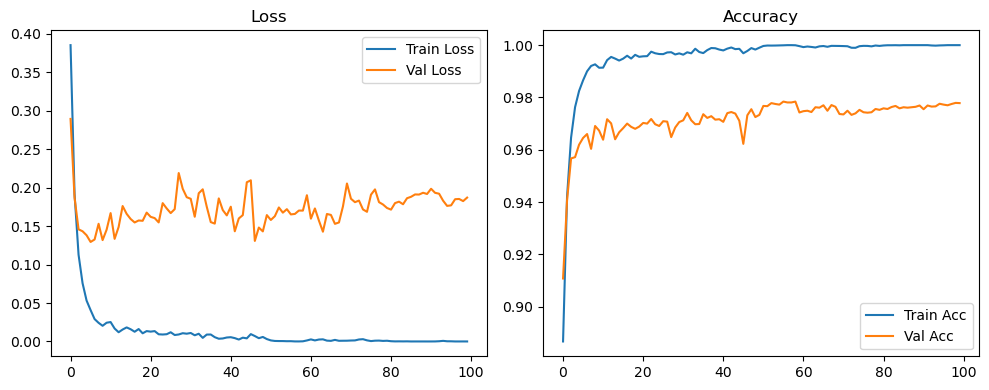

🚀 Running: batch256_lr0.01_0.005_0.002_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4888, Acc: 0.8513 | Val Loss: 0.2794, Acc: 0.9163


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2696, Acc: 0.9182 | Val Loss: 0.2094, Acc: 0.9364


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1922, Acc: 0.9415 | Val Loss: 0.1766, Acc: 0.9479


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1451, Acc: 0.9553 | Val Loss: 0.1272, Acc: 0.9627


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1253, Acc: 0.9604 | Val Loss: 0.1224, Acc: 0.9643


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1003, Acc: 0.9674 | Val Loss: 0.1171, Acc: 0.9673


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0862, Acc: 0.9725 | Val Loss: 0.1144, Acc: 0.9672


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0762, Acc: 0.9755 | Val Loss: 0.1099, Acc: 0.9688


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0635, Acc: 0.9782 | Val Loss: 0.1194, Acc: 0.9688


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0611, Acc: 0.9796 | Val Loss: 0.1076, Acc: 0.9704


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0528, Acc: 0.9829 | Val Loss: 0.1101, Acc: 0.9721


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0483, Acc: 0.9835 | Val Loss: 0.1101, Acc: 0.9712


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0444, Acc: 0.9853 | Val Loss: 0.1073, Acc: 0.9731


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0431, Acc: 0.9860 | Val Loss: 0.1159, Acc: 0.9718


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0379, Acc: 0.9874 | Val Loss: 0.1111, Acc: 0.9722


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0359, Acc: 0.9882 | Val Loss: 0.1093, Acc: 0.9735


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0340, Acc: 0.9886 | Val Loss: 0.1124, Acc: 0.9745


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0341, Acc: 0.9883 | Val Loss: 0.1043, Acc: 0.9761


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0316, Acc: 0.9897 | Val Loss: 0.1058, Acc: 0.9751


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0309, Acc: 0.9898 | Val Loss: 0.1059, Acc: 0.9748


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0304, Acc: 0.9897 | Val Loss: 0.1054, Acc: 0.9757


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0285, Acc: 0.9904 | Val Loss: 0.1072, Acc: 0.9740


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9908 | Val Loss: 0.1082, Acc: 0.9747


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0244, Acc: 0.9916 | Val Loss: 0.1108, Acc: 0.9743


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0244, Acc: 0.9918 | Val Loss: 0.1125, Acc: 0.9745


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0257, Acc: 0.9914 | Val Loss: 0.1074, Acc: 0.9742


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0224, Acc: 0.9923 | Val Loss: 0.1118, Acc: 0.9753


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0213, Acc: 0.9931 | Val Loss: 0.1177, Acc: 0.9743


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9932 | Val Loss: 0.1112, Acc: 0.9743


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9930 | Val Loss: 0.1005, Acc: 0.9771


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9925 | Val Loss: 0.1078, Acc: 0.9752


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0200, Acc: 0.9932 | Val Loss: 0.1037, Acc: 0.9768


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0211, Acc: 0.9928 | Val Loss: 0.1177, Acc: 0.9752


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0186, Acc: 0.9939 | Val Loss: 0.1125, Acc: 0.9758


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0184, Acc: 0.9938 | Val Loss: 0.1177, Acc: 0.9762


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9944 | Val Loss: 0.1182, Acc: 0.9754


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9935 | Val Loss: 0.1219, Acc: 0.9750


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9942 | Val Loss: 0.1162, Acc: 0.9763


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9939 | Val Loss: 0.1201, Acc: 0.9747


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9941 | Val Loss: 0.1095, Acc: 0.9772


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9949 | Val Loss: 0.1184, Acc: 0.9772


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9950 | Val Loss: 0.1307, Acc: 0.9753


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9951 | Val Loss: 0.1296, Acc: 0.9771


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9955 | Val Loss: 0.1278, Acc: 0.9759


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9948 | Val Loss: 0.1161, Acc: 0.9756


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9947 | Val Loss: 0.1160, Acc: 0.9763


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9949 | Val Loss: 0.1109, Acc: 0.9775


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9951 | Val Loss: 0.1213, Acc: 0.9758


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9958 | Val Loss: 0.1205, Acc: 0.9773


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9958 | Val Loss: 0.1070, Acc: 0.9775


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.1155, Acc: 0.9781


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9971 | Val Loss: 0.1145, Acc: 0.9786


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9977 | Val Loss: 0.1209, Acc: 0.9769


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1197, Acc: 0.9787


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.1232, Acc: 0.9780


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.1264, Acc: 0.9776


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9978 | Val Loss: 0.1361, Acc: 0.9776


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.1366, Acc: 0.9778


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.1230, Acc: 0.9786


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.1391, Acc: 0.9769


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9985 | Val Loss: 0.1314, Acc: 0.9782


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9977 | Val Loss: 0.1446, Acc: 0.9758


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.1429, Acc: 0.9780


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9976 | Val Loss: 0.1409, Acc: 0.9778


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.1237, Acc: 0.9778


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.1111, Acc: 0.9782


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9977 | Val Loss: 0.1187, Acc: 0.9784


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1342, Acc: 0.9776


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.1266, Acc: 0.9785


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1232, Acc: 0.9792


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.1290, Acc: 0.9786


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.1471, Acc: 0.9789


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.1406, Acc: 0.9775


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.1390, Acc: 0.9775


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.1347, Acc: 0.9782


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1350, Acc: 0.9784


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9983 | Val Loss: 0.1423, Acc: 0.9774


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9983 | Val Loss: 0.1448, Acc: 0.9764


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1360, Acc: 0.9780


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.1349, Acc: 0.9773


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.1375, Acc: 0.9785


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1415, Acc: 0.9781


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1351, Acc: 0.9787


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1385, Acc: 0.9785


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1334, Acc: 0.9787


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1381, Acc: 0.9788


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1361, Acc: 0.9788


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1414, Acc: 0.9787


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.1387, Acc: 0.9781


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1425, Acc: 0.9788


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1412, Acc: 0.9788


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.1477, Acc: 0.9788


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.1553, Acc: 0.9788


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1506, Acc: 0.9798


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9992 | Val Loss: 0.1544, Acc: 0.9789


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1536, Acc: 0.9782


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1419, Acc: 0.9788


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1415, Acc: 0.9782


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.1448, Acc: 0.9784


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1450, Acc: 0.9782


Final Test Loss: 0.1397 Accuracy: 0.9796


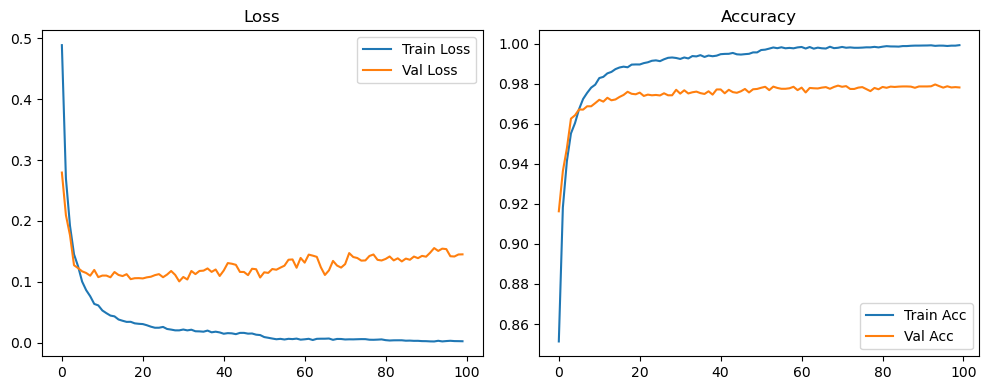

🚀 Running: batch256_lr0.01_0.005_0.002_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.7479, Acc: 0.7590 | Val Loss: 0.3265, Acc: 0.9031


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.4263, Acc: 0.8720 | Val Loss: 0.2593, Acc: 0.9233


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.3422, Acc: 0.8983 | Val Loss: 0.2261, Acc: 0.9355


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2826, Acc: 0.9164 | Val Loss: 0.1737, Acc: 0.9473


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.2450, Acc: 0.9271 | Val Loss: 0.1546, Acc: 0.9528


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.2158, Acc: 0.9349 | Val Loss: 0.1495, Acc: 0.9574


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1984, Acc: 0.9412 | Val Loss: 0.1393, Acc: 0.9601


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1793, Acc: 0.9452 | Val Loss: 0.1328, Acc: 0.9606


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1686, Acc: 0.9487 | Val Loss: 0.1222, Acc: 0.9644


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1555, Acc: 0.9526 | Val Loss: 0.1182, Acc: 0.9647


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1465, Acc: 0.9556 | Val Loss: 0.1203, Acc: 0.9664


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1380, Acc: 0.9576 | Val Loss: 0.1137, Acc: 0.9674


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1337, Acc: 0.9590 | Val Loss: 0.1139, Acc: 0.9668


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1282, Acc: 0.9610 | Val Loss: 0.1100, Acc: 0.9682


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1182, Acc: 0.9636 | Val Loss: 0.1089, Acc: 0.9698


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1199, Acc: 0.9629 | Val Loss: 0.1093, Acc: 0.9688


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1147, Acc: 0.9651 | Val Loss: 0.1027, Acc: 0.9702


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1069, Acc: 0.9663 | Val Loss: 0.1022, Acc: 0.9718


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1042, Acc: 0.9679 | Val Loss: 0.1033, Acc: 0.9708


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0987, Acc: 0.9690 | Val Loss: 0.1027, Acc: 0.9718


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.1008, Acc: 0.9682 | Val Loss: 0.1043, Acc: 0.9712


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0966, Acc: 0.9696 | Val Loss: 0.1028, Acc: 0.9719


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0926, Acc: 0.9711 | Val Loss: 0.1017, Acc: 0.9732


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0895, Acc: 0.9719 | Val Loss: 0.1063, Acc: 0.9697


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0869, Acc: 0.9722 | Val Loss: 0.1069, Acc: 0.9718


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0871, Acc: 0.9723 | Val Loss: 0.1068, Acc: 0.9720


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0838, Acc: 0.9736 | Val Loss: 0.1079, Acc: 0.9729


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0803, Acc: 0.9749 | Val Loss: 0.1050, Acc: 0.9734


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0782, Acc: 0.9750 | Val Loss: 0.0992, Acc: 0.9721


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0812, Acc: 0.9740 | Val Loss: 0.1036, Acc: 0.9723


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0743, Acc: 0.9761 | Val Loss: 0.1004, Acc: 0.9732


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0743, Acc: 0.9762 | Val Loss: 0.1012, Acc: 0.9726


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0729, Acc: 0.9781 | Val Loss: 0.0978, Acc: 0.9732


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0695, Acc: 0.9782 | Val Loss: 0.1017, Acc: 0.9721


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0714, Acc: 0.9779 | Val Loss: 0.0974, Acc: 0.9722


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0701, Acc: 0.9777 | Val Loss: 0.1029, Acc: 0.9732


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0702, Acc: 0.9774 | Val Loss: 0.1021, Acc: 0.9726


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0671, Acc: 0.9784 | Val Loss: 0.0985, Acc: 0.9726


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0659, Acc: 0.9793 | Val Loss: 0.0985, Acc: 0.9738


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0662, Acc: 0.9787 | Val Loss: 0.1033, Acc: 0.9734


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0672, Acc: 0.9787 | Val Loss: 0.1066, Acc: 0.9743


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0638, Acc: 0.9802 | Val Loss: 0.1047, Acc: 0.9752


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0614, Acc: 0.9809 | Val Loss: 0.1042, Acc: 0.9743


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0619, Acc: 0.9801 | Val Loss: 0.1010, Acc: 0.9751


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0629, Acc: 0.9802 | Val Loss: 0.0956, Acc: 0.9748


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0599, Acc: 0.9818 | Val Loss: 0.0975, Acc: 0.9754


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0577, Acc: 0.9815 | Val Loss: 0.0934, Acc: 0.9762


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0596, Acc: 0.9810 | Val Loss: 0.1025, Acc: 0.9739


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0591, Acc: 0.9811 | Val Loss: 0.1026, Acc: 0.9752


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0551, Acc: 0.9825 | Val Loss: 0.0978, Acc: 0.9752


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0511, Acc: 0.9831 | Val Loss: 0.0986, Acc: 0.9757


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0484, Acc: 0.9843 | Val Loss: 0.0970, Acc: 0.9767


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0427, Acc: 0.9866 | Val Loss: 0.1011, Acc: 0.9762


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0424, Acc: 0.9860 | Val Loss: 0.1030, Acc: 0.9755


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0424, Acc: 0.9861 | Val Loss: 0.1057, Acc: 0.9754


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0403, Acc: 0.9874 | Val Loss: 0.1052, Acc: 0.9753


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0392, Acc: 0.9872 | Val Loss: 0.1031, Acc: 0.9756


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0400, Acc: 0.9869 | Val Loss: 0.1013, Acc: 0.9761


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0380, Acc: 0.9875 | Val Loss: 0.1091, Acc: 0.9758


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0398, Acc: 0.9874 | Val Loss: 0.1057, Acc: 0.9750


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0363, Acc: 0.9889 | Val Loss: 0.1070, Acc: 0.9756


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0382, Acc: 0.9877 | Val Loss: 0.1058, Acc: 0.9752


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0371, Acc: 0.9887 | Val Loss: 0.1057, Acc: 0.9753


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0348, Acc: 0.9887 | Val Loss: 0.1117, Acc: 0.9756


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0366, Acc: 0.9882 | Val Loss: 0.1099, Acc: 0.9757


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0379, Acc: 0.9883 | Val Loss: 0.1073, Acc: 0.9758


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0380, Acc: 0.9878 | Val Loss: 0.1152, Acc: 0.9752


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0383, Acc: 0.9881 | Val Loss: 0.1055, Acc: 0.9749


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0337, Acc: 0.9893 | Val Loss: 0.1093, Acc: 0.9753


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0343, Acc: 0.9888 | Val Loss: 0.1062, Acc: 0.9748


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0348, Acc: 0.9888 | Val Loss: 0.1131, Acc: 0.9752


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0332, Acc: 0.9886 | Val Loss: 0.1092, Acc: 0.9757


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0360, Acc: 0.9890 | Val Loss: 0.1084, Acc: 0.9751


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0332, Acc: 0.9894 | Val Loss: 0.1193, Acc: 0.9742


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0326, Acc: 0.9899 | Val Loss: 0.1141, Acc: 0.9746


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0342, Acc: 0.9890 | Val Loss: 0.1075, Acc: 0.9752


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0309, Acc: 0.9904 | Val Loss: 0.1122, Acc: 0.9748


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0320, Acc: 0.9899 | Val Loss: 0.1121, Acc: 0.9749


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0321, Acc: 0.9902 | Val Loss: 0.1135, Acc: 0.9753


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0346, Acc: 0.9890 | Val Loss: 0.1130, Acc: 0.9752


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0301, Acc: 0.9903 | Val Loss: 0.1113, Acc: 0.9752


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0293, Acc: 0.9905 | Val Loss: 0.1146, Acc: 0.9758


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0257, Acc: 0.9917 | Val Loss: 0.1154, Acc: 0.9759


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0299, Acc: 0.9902 | Val Loss: 0.1117, Acc: 0.9751


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0272, Acc: 0.9911 | Val Loss: 0.1137, Acc: 0.9754


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0262, Acc: 0.9917 | Val Loss: 0.1138, Acc: 0.9752


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0253, Acc: 0.9925 | Val Loss: 0.1164, Acc: 0.9754


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0254, Acc: 0.9919 | Val Loss: 0.1155, Acc: 0.9756


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0249, Acc: 0.9917 | Val Loss: 0.1189, Acc: 0.9752


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0239, Acc: 0.9924 | Val Loss: 0.1140, Acc: 0.9752


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0243, Acc: 0.9920 | Val Loss: 0.1135, Acc: 0.9752


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0241, Acc: 0.9927 | Val Loss: 0.1142, Acc: 0.9753


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0238, Acc: 0.9923 | Val Loss: 0.1166, Acc: 0.9759


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0260, Acc: 0.9915 | Val Loss: 0.1171, Acc: 0.9757


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0215, Acc: 0.9931 | Val Loss: 0.1224, Acc: 0.9758


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0230, Acc: 0.9925 | Val Loss: 0.1191, Acc: 0.9757


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0230, Acc: 0.9929 | Val Loss: 0.1145, Acc: 0.9758


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0228, Acc: 0.9924 | Val Loss: 0.1178, Acc: 0.9754


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0230, Acc: 0.9922 | Val Loss: 0.1179, Acc: 0.9763


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0224, Acc: 0.9925 | Val Loss: 0.1226, Acc: 0.9758


Final Test Loss: 0.1035 Accuracy: 0.9787


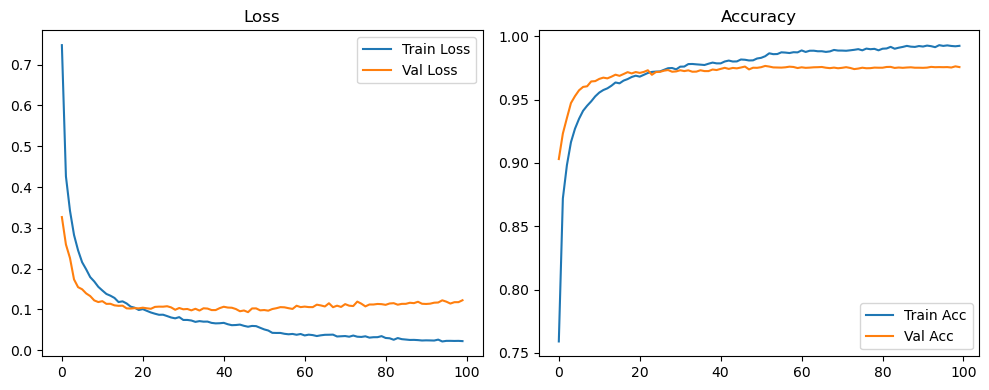

🚀 Running: batch256_lr0.01_0.005_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3853, Acc: 0.8867 | Val Loss: 0.2894, Acc: 0.9107


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1916, Acc: 0.9421 | Val Loss: 0.1868, Acc: 0.9407


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1128, Acc: 0.9646 | Val Loss: 0.1458, Acc: 0.9567


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0757, Acc: 0.9763 | Val Loss: 0.1433, Acc: 0.9572


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0532, Acc: 0.9825 | Val Loss: 0.1381, Acc: 0.9619


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0408, Acc: 0.9865 | Val Loss: 0.1294, Acc: 0.9645


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0291, Acc: 0.9900 | Val Loss: 0.1326, Acc: 0.9660


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9920 | Val Loss: 0.1530, Acc: 0.9603


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9927 | Val Loss: 0.1318, Acc: 0.9691


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0244, Acc: 0.9914 | Val Loss: 0.1453, Acc: 0.9673


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9914 | Val Loss: 0.1669, Acc: 0.9638


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9943 | Val Loss: 0.1334, Acc: 0.9717


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9955 | Val Loss: 0.1488, Acc: 0.9701


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9949 | Val Loss: 0.1761, Acc: 0.9640


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9941 | Val Loss: 0.1660, Acc: 0.9667


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9948 | Val Loss: 0.1592, Acc: 0.9683


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9960 | Val Loss: 0.1547, Acc: 0.9700


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9949 | Val Loss: 0.1573, Acc: 0.9688


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9963 | Val Loss: 0.1569, Acc: 0.9680


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9955 | Val Loss: 0.1675, Acc: 0.9688


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9957 | Val Loss: 0.1620, Acc: 0.9702


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9958 | Val Loss: 0.1604, Acc: 0.9700


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9975 | Val Loss: 0.1548, Acc: 0.9718


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9969 | Val Loss: 0.1799, Acc: 0.9698


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9966 | Val Loss: 0.1729, Acc: 0.9691


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9966 | Val Loss: 0.1669, Acc: 0.9709


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.1721, Acc: 0.9708


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9973 | Val Loss: 0.2190, Acc: 0.9648


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9964 | Val Loss: 0.1986, Acc: 0.9685


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9969 | Val Loss: 0.1876, Acc: 0.9706


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9964 | Val Loss: 0.1855, Acc: 0.9712


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9973 | Val Loss: 0.1621, Acc: 0.9741


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9969 | Val Loss: 0.1927, Acc: 0.9712


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1978, Acc: 0.9698


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9974 | Val Loss: 0.1752, Acc: 0.9698


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.1552, Acc: 0.9736


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.1532, Acc: 0.9722


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1860, Acc: 0.9728


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1708, Acc: 0.9715


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.1639, Acc: 0.9717


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9980 | Val Loss: 0.1752, Acc: 0.9707


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.1433, Acc: 0.9740


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1599, Acc: 0.9744


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1643, Acc: 0.9738


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.2070, Acc: 0.9711


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.2095, Acc: 0.9623


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.1307, Acc: 0.9732


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9989 | Val Loss: 0.1481, Acc: 0.9755


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9983 | Val Loss: 0.1431, Acc: 0.9725


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1643, Acc: 0.9733


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.1580, Acc: 0.9768


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.1629, Acc: 0.9767


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1742, Acc: 0.9778


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1675, Acc: 0.9775


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1720, Acc: 0.9772


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1652, Acc: 0.9784


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1658, Acc: 0.9781


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1702, Acc: 0.9781


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1702, Acc: 0.9784


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1902, Acc: 0.9742


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1597, Acc: 0.9748


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1730, Acc: 0.9749


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1572, Acc: 0.9744


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1427, Acc: 0.9762


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9995 | Val Loss: 0.1657, Acc: 0.9761


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1645, Acc: 0.9770


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1529, Acc: 0.9749


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1547, Acc: 0.9771


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1756, Acc: 0.9764


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.2054, Acc: 0.9737


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1856, Acc: 0.9735


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1811, Acc: 0.9749


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.1832, Acc: 0.9733


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1717, Acc: 0.9739


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1686, Acc: 0.9752


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9997 | Val Loss: 0.1909, Acc: 0.9743


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1977, Acc: 0.9742


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9995 | Val Loss: 0.1812, Acc: 0.9743


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.1781, Acc: 0.9756


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1735, Acc: 0.9752


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1694, Acc: 0.9757


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1744, Acc: 0.9757


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1784, Acc: 0.9763


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1721, Acc: 0.9766


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1779, Acc: 0.9758


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1781, Acc: 0.9767


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1796, Acc: 0.9762


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1796, Acc: 0.9766


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1825, Acc: 0.9766


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1810, Acc: 0.9768


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1858, Acc: 0.9765


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1835, Acc: 0.9762


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1809, Acc: 0.9763


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1828, Acc: 0.9765


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1857, Acc: 0.9767


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1847, Acc: 0.9767


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1918, Acc: 0.9768


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1894, Acc: 0.9769


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1894, Acc: 0.9768


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1917, Acc: 0.9771


Final Test Loss: 0.1933 Accuracy: 0.9791


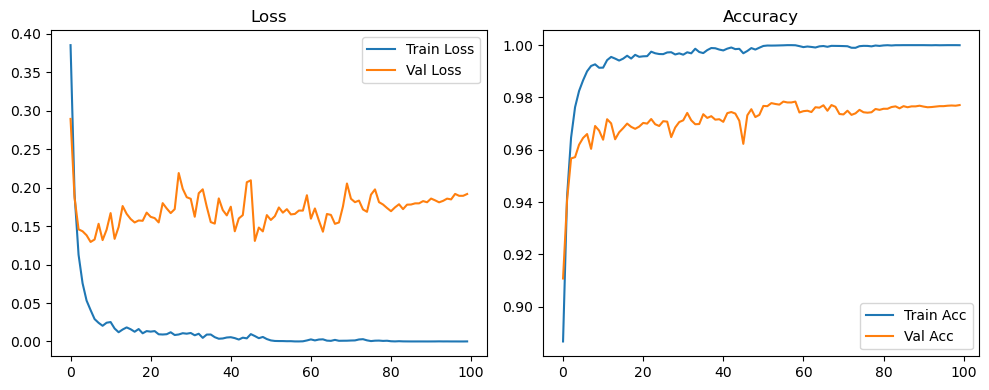

🚀 Running: batch256_lr0.01_0.005_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4888, Acc: 0.8513 | Val Loss: 0.2794, Acc: 0.9163


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2699, Acc: 0.9181 | Val Loss: 0.2113, Acc: 0.9363


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1931, Acc: 0.9413 | Val Loss: 0.1747, Acc: 0.9486


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1450, Acc: 0.9553 | Val Loss: 0.1296, Acc: 0.9618


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1254, Acc: 0.9602 | Val Loss: 0.1233, Acc: 0.9644


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1007, Acc: 0.9675 | Val Loss: 0.1186, Acc: 0.9659


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0869, Acc: 0.9719 | Val Loss: 0.1119, Acc: 0.9681


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0756, Acc: 0.9758 | Val Loss: 0.1109, Acc: 0.9683


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0648, Acc: 0.9779 | Val Loss: 0.1177, Acc: 0.9707


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0622, Acc: 0.9794 | Val Loss: 0.1048, Acc: 0.9713


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0536, Acc: 0.9819 | Val Loss: 0.1145, Acc: 0.9710


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0485, Acc: 0.9841 | Val Loss: 0.1074, Acc: 0.9720


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0427, Acc: 0.9855 | Val Loss: 0.1174, Acc: 0.9722


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0430, Acc: 0.9856 | Val Loss: 0.1177, Acc: 0.9715


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0413, Acc: 0.9870 | Val Loss: 0.1097, Acc: 0.9719


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0348, Acc: 0.9879 | Val Loss: 0.1146, Acc: 0.9732


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0342, Acc: 0.9881 | Val Loss: 0.1130, Acc: 0.9747


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0361, Acc: 0.9877 | Val Loss: 0.1197, Acc: 0.9735


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0337, Acc: 0.9886 | Val Loss: 0.1127, Acc: 0.9738


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0326, Acc: 0.9884 | Val Loss: 0.1108, Acc: 0.9750


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0331, Acc: 0.9895 | Val Loss: 0.1107, Acc: 0.9757


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0298, Acc: 0.9902 | Val Loss: 0.1159, Acc: 0.9733


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9920 | Val Loss: 0.1268, Acc: 0.9748


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0256, Acc: 0.9915 | Val Loss: 0.1284, Acc: 0.9731


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0267, Acc: 0.9911 | Val Loss: 0.1287, Acc: 0.9731


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0277, Acc: 0.9908 | Val Loss: 0.1191, Acc: 0.9736


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0267, Acc: 0.9912 | Val Loss: 0.1186, Acc: 0.9751


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0228, Acc: 0.9920 | Val Loss: 0.1220, Acc: 0.9748


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0214, Acc: 0.9928 | Val Loss: 0.1235, Acc: 0.9756


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0229, Acc: 0.9923 | Val Loss: 0.1145, Acc: 0.9750


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9936 | Val Loss: 0.1155, Acc: 0.9768


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0222, Acc: 0.9927 | Val Loss: 0.1270, Acc: 0.9753


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0234, Acc: 0.9926 | Val Loss: 0.1231, Acc: 0.9752


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0214, Acc: 0.9925 | Val Loss: 0.1327, Acc: 0.9752


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9930 | Val Loss: 0.1225, Acc: 0.9758


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0184, Acc: 0.9940 | Val Loss: 0.1035, Acc: 0.9778


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9947 | Val Loss: 0.1326, Acc: 0.9758


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0156, Acc: 0.9951 | Val Loss: 0.1193, Acc: 0.9753


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0156, Acc: 0.9948 | Val Loss: 0.1174, Acc: 0.9756


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9953 | Val Loss: 0.1186, Acc: 0.9754


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9954 | Val Loss: 0.1167, Acc: 0.9769


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9952 | Val Loss: 0.1156, Acc: 0.9761


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9941 | Val Loss: 0.1220, Acc: 0.9748


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9949 | Val Loss: 0.1344, Acc: 0.9739


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9946 | Val Loss: 0.1189, Acc: 0.9756


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9951 | Val Loss: 0.1160, Acc: 0.9762


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9951 | Val Loss: 0.1181, Acc: 0.9753


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9953 | Val Loss: 0.1394, Acc: 0.9764


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9949 | Val Loss: 0.1158, Acc: 0.9760


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9956 | Val Loss: 0.1257, Acc: 0.9749


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9967 | Val Loss: 0.1231, Acc: 0.9770


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.1297, Acc: 0.9771


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.1305, Acc: 0.9777


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9978 | Val Loss: 0.1269, Acc: 0.9775


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.1313, Acc: 0.9770


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9978 | Val Loss: 0.1357, Acc: 0.9770


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9978 | Val Loss: 0.1337, Acc: 0.9779


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9977 | Val Loss: 0.1273, Acc: 0.9776


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9980 | Val Loss: 0.1325, Acc: 0.9770


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.1300, Acc: 0.9778


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.1316, Acc: 0.9769


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.1330, Acc: 0.9764


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9983 | Val Loss: 0.1439, Acc: 0.9762


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.1274, Acc: 0.9770


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.1248, Acc: 0.9774


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1365, Acc: 0.9762


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1342, Acc: 0.9777


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.1234, Acc: 0.9784


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1341, Acc: 0.9772


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.1233, Acc: 0.9764


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.1393, Acc: 0.9766


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.1347, Acc: 0.9776


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1362, Acc: 0.9793


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.1254, Acc: 0.9792


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.1420, Acc: 0.9773


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1347, Acc: 0.9779


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9984 | Val Loss: 0.1311, Acc: 0.9778


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.1196, Acc: 0.9791


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1356, Acc: 0.9788


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1385, Acc: 0.9775


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9982 | Val Loss: 0.1293, Acc: 0.9794


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.1287, Acc: 0.9792


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1309, Acc: 0.9784


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1274, Acc: 0.9784


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1282, Acc: 0.9791


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.1305, Acc: 0.9792


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.1321, Acc: 0.9794


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.1362, Acc: 0.9793


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1355, Acc: 0.9795


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1354, Acc: 0.9788


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1352, Acc: 0.9789


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1335, Acc: 0.9790


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1351, Acc: 0.9792


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.1367, Acc: 0.9793


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.1366, Acc: 0.9795


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1371, Acc: 0.9799


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.1367, Acc: 0.9793


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1398, Acc: 0.9795


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.1407, Acc: 0.9792


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1416, Acc: 0.9789


Final Test Loss: 0.1260 Accuracy: 0.9814


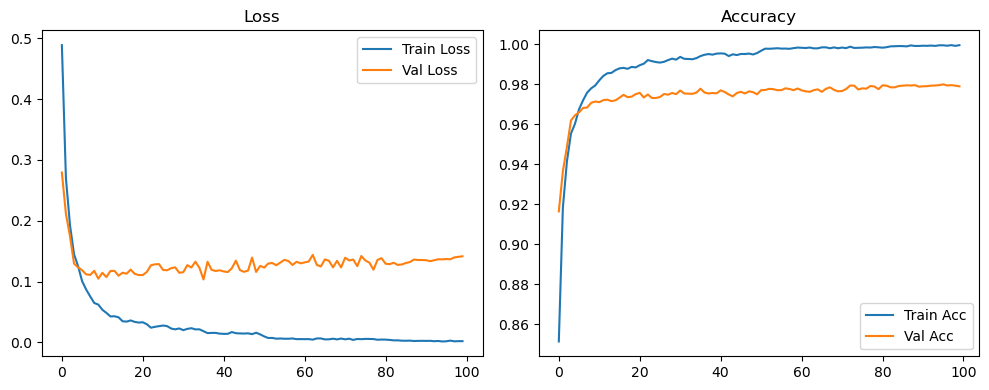

🚀 Running: batch256_lr0.01_0.005_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.7478, Acc: 0.7590 | Val Loss: 0.3266, Acc: 0.9032


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.4261, Acc: 0.8720 | Val Loss: 0.2587, Acc: 0.9226


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.3412, Acc: 0.8983 | Val Loss: 0.2246, Acc: 0.9365


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2807, Acc: 0.9173 | Val Loss: 0.1744, Acc: 0.9470


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.2427, Acc: 0.9284 | Val Loss: 0.1564, Acc: 0.9520


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.2141, Acc: 0.9363 | Val Loss: 0.1513, Acc: 0.9567


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1974, Acc: 0.9420 | Val Loss: 0.1403, Acc: 0.9596


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1793, Acc: 0.9454 | Val Loss: 0.1320, Acc: 0.9607


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1689, Acc: 0.9488 | Val Loss: 0.1224, Acc: 0.9647


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1557, Acc: 0.9531 | Val Loss: 0.1170, Acc: 0.9653


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1470, Acc: 0.9548 | Val Loss: 0.1225, Acc: 0.9660


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1388, Acc: 0.9570 | Val Loss: 0.1131, Acc: 0.9681


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1335, Acc: 0.9585 | Val Loss: 0.1129, Acc: 0.9673


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1289, Acc: 0.9610 | Val Loss: 0.1115, Acc: 0.9683


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1167, Acc: 0.9637 | Val Loss: 0.1083, Acc: 0.9694


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1192, Acc: 0.9632 | Val Loss: 0.1087, Acc: 0.9704


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1147, Acc: 0.9648 | Val Loss: 0.1015, Acc: 0.9711


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1075, Acc: 0.9667 | Val Loss: 0.1061, Acc: 0.9707


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1039, Acc: 0.9678 | Val Loss: 0.1063, Acc: 0.9706


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0999, Acc: 0.9682 | Val Loss: 0.1025, Acc: 0.9715


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.1014, Acc: 0.9681 | Val Loss: 0.1011, Acc: 0.9728


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0984, Acc: 0.9697 | Val Loss: 0.1016, Acc: 0.9712


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0921, Acc: 0.9712 | Val Loss: 0.1032, Acc: 0.9723


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0892, Acc: 0.9720 | Val Loss: 0.1040, Acc: 0.9704


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0880, Acc: 0.9720 | Val Loss: 0.1022, Acc: 0.9729


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0869, Acc: 0.9728 | Val Loss: 0.1033, Acc: 0.9725


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0829, Acc: 0.9740 | Val Loss: 0.1080, Acc: 0.9730


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0800, Acc: 0.9755 | Val Loss: 0.1040, Acc: 0.9733


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0780, Acc: 0.9751 | Val Loss: 0.1004, Acc: 0.9730


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0793, Acc: 0.9742 | Val Loss: 0.0993, Acc: 0.9735


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0751, Acc: 0.9763 | Val Loss: 0.0966, Acc: 0.9729


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0749, Acc: 0.9763 | Val Loss: 0.0941, Acc: 0.9748


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0734, Acc: 0.9769 | Val Loss: 0.0991, Acc: 0.9733


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0716, Acc: 0.9772 | Val Loss: 0.0998, Acc: 0.9738


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0699, Acc: 0.9779 | Val Loss: 0.0995, Acc: 0.9742


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0700, Acc: 0.9777 | Val Loss: 0.1030, Acc: 0.9746


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0698, Acc: 0.9781 | Val Loss: 0.0986, Acc: 0.9738


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0672, Acc: 0.9779 | Val Loss: 0.0991, Acc: 0.9744


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0656, Acc: 0.9800 | Val Loss: 0.0974, Acc: 0.9753


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0628, Acc: 0.9800 | Val Loss: 0.1011, Acc: 0.9758


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0652, Acc: 0.9794 | Val Loss: 0.0992, Acc: 0.9752


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0638, Acc: 0.9807 | Val Loss: 0.0994, Acc: 0.9757


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0616, Acc: 0.9807 | Val Loss: 0.0963, Acc: 0.9733


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0633, Acc: 0.9803 | Val Loss: 0.0983, Acc: 0.9744


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0636, Acc: 0.9798 | Val Loss: 0.0905, Acc: 0.9747


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0602, Acc: 0.9806 | Val Loss: 0.1023, Acc: 0.9758


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0595, Acc: 0.9806 | Val Loss: 0.1035, Acc: 0.9747


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0576, Acc: 0.9816 | Val Loss: 0.1056, Acc: 0.9740


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0582, Acc: 0.9817 | Val Loss: 0.1017, Acc: 0.9753


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0564, Acc: 0.9824 | Val Loss: 0.1007, Acc: 0.9749


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0494, Acc: 0.9840 | Val Loss: 0.1007, Acc: 0.9751


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0477, Acc: 0.9846 | Val Loss: 0.1009, Acc: 0.9769


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0457, Acc: 0.9856 | Val Loss: 0.0997, Acc: 0.9763


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0417, Acc: 0.9869 | Val Loss: 0.1000, Acc: 0.9768


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0426, Acc: 0.9865 | Val Loss: 0.1082, Acc: 0.9758


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0411, Acc: 0.9869 | Val Loss: 0.1027, Acc: 0.9762


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0402, Acc: 0.9871 | Val Loss: 0.1050, Acc: 0.9764


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0408, Acc: 0.9870 | Val Loss: 0.1072, Acc: 0.9761


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0385, Acc: 0.9877 | Val Loss: 0.1077, Acc: 0.9769


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0388, Acc: 0.9870 | Val Loss: 0.1054, Acc: 0.9771


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0379, Acc: 0.9879 | Val Loss: 0.1051, Acc: 0.9756


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0411, Acc: 0.9871 | Val Loss: 0.0996, Acc: 0.9770


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0359, Acc: 0.9884 | Val Loss: 0.1056, Acc: 0.9766


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0346, Acc: 0.9890 | Val Loss: 0.1027, Acc: 0.9767


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0363, Acc: 0.9876 | Val Loss: 0.1119, Acc: 0.9762


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0397, Acc: 0.9870 | Val Loss: 0.1007, Acc: 0.9766


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0392, Acc: 0.9874 | Val Loss: 0.1077, Acc: 0.9754


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0387, Acc: 0.9877 | Val Loss: 0.0947, Acc: 0.9764


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0346, Acc: 0.9882 | Val Loss: 0.1104, Acc: 0.9765


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0333, Acc: 0.9892 | Val Loss: 0.1049, Acc: 0.9756


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0354, Acc: 0.9886 | Val Loss: 0.1107, Acc: 0.9758


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0321, Acc: 0.9903 | Val Loss: 0.1063, Acc: 0.9762


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0338, Acc: 0.9895 | Val Loss: 0.1027, Acc: 0.9764


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0339, Acc: 0.9892 | Val Loss: 0.1106, Acc: 0.9757


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0328, Acc: 0.9899 | Val Loss: 0.1054, Acc: 0.9764


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0343, Acc: 0.9893 | Val Loss: 0.1054, Acc: 0.9760


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0306, Acc: 0.9899 | Val Loss: 0.1065, Acc: 0.9757


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0323, Acc: 0.9899 | Val Loss: 0.1080, Acc: 0.9762


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0309, Acc: 0.9902 | Val Loss: 0.1120, Acc: 0.9769


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0350, Acc: 0.9891 | Val Loss: 0.1116, Acc: 0.9761


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0307, Acc: 0.9901 | Val Loss: 0.1077, Acc: 0.9766


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0296, Acc: 0.9904 | Val Loss: 0.1095, Acc: 0.9762


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0275, Acc: 0.9906 | Val Loss: 0.1102, Acc: 0.9765


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0299, Acc: 0.9901 | Val Loss: 0.1044, Acc: 0.9768


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0275, Acc: 0.9913 | Val Loss: 0.1054, Acc: 0.9764


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0244, Acc: 0.9919 | Val Loss: 0.1102, Acc: 0.9768


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0257, Acc: 0.9920 | Val Loss: 0.1070, Acc: 0.9768


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0253, Acc: 0.9924 | Val Loss: 0.1084, Acc: 0.9769


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0258, Acc: 0.9915 | Val Loss: 0.1101, Acc: 0.9770


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0230, Acc: 0.9925 | Val Loss: 0.1091, Acc: 0.9769


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0228, Acc: 0.9928 | Val Loss: 0.1097, Acc: 0.9764


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0253, Acc: 0.9923 | Val Loss: 0.1083, Acc: 0.9762


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0247, Acc: 0.9922 | Val Loss: 0.1092, Acc: 0.9764


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0246, Acc: 0.9918 | Val Loss: 0.1106, Acc: 0.9778


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0220, Acc: 0.9925 | Val Loss: 0.1137, Acc: 0.9771


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0247, Acc: 0.9924 | Val Loss: 0.1128, Acc: 0.9770


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0237, Acc: 0.9920 | Val Loss: 0.1090, Acc: 0.9768


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0235, Acc: 0.9928 | Val Loss: 0.1111, Acc: 0.9770


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0226, Acc: 0.9923 | Val Loss: 0.1125, Acc: 0.9772


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0225, Acc: 0.9928 | Val Loss: 0.1139, Acc: 0.9772


Final Test Loss: 0.1006 Accuracy: 0.9789


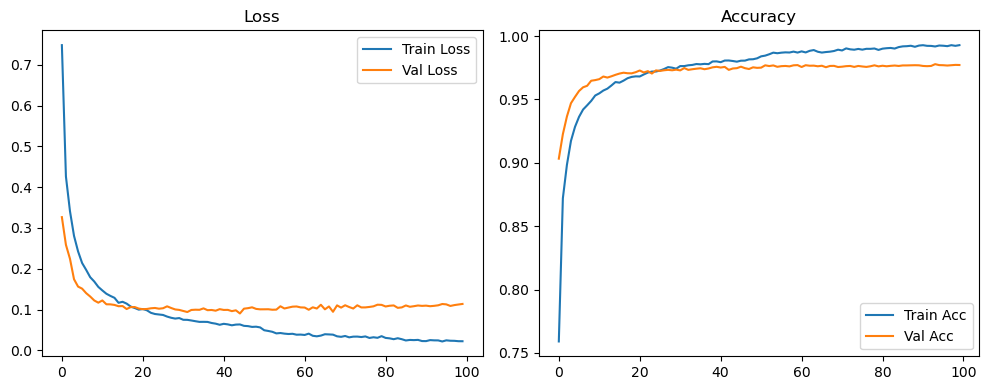

🚀 Running: batch256_lr0.01_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3853, Acc: 0.8867 | Val Loss: 0.2894, Acc: 0.9107


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1916, Acc: 0.9421 | Val Loss: 0.1868, Acc: 0.9407


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1128, Acc: 0.9646 | Val Loss: 0.1458, Acc: 0.9567


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0757, Acc: 0.9763 | Val Loss: 0.1433, Acc: 0.9572


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0532, Acc: 0.9825 | Val Loss: 0.1381, Acc: 0.9619


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0408, Acc: 0.9865 | Val Loss: 0.1294, Acc: 0.9645


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0291, Acc: 0.9900 | Val Loss: 0.1326, Acc: 0.9660


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9920 | Val Loss: 0.1530, Acc: 0.9603


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9927 | Val Loss: 0.1318, Acc: 0.9691


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0244, Acc: 0.9914 | Val Loss: 0.1453, Acc: 0.9673


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9914 | Val Loss: 0.1669, Acc: 0.9638


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9943 | Val Loss: 0.1334, Acc: 0.9717


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9955 | Val Loss: 0.1488, Acc: 0.9701


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9949 | Val Loss: 0.1761, Acc: 0.9640


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9941 | Val Loss: 0.1660, Acc: 0.9667


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9948 | Val Loss: 0.1592, Acc: 0.9683


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9960 | Val Loss: 0.1547, Acc: 0.9700


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9949 | Val Loss: 0.1573, Acc: 0.9688


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9963 | Val Loss: 0.1569, Acc: 0.9680


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9955 | Val Loss: 0.1675, Acc: 0.9688


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9957 | Val Loss: 0.1620, Acc: 0.9702


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9958 | Val Loss: 0.1604, Acc: 0.9700


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9975 | Val Loss: 0.1548, Acc: 0.9718


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9969 | Val Loss: 0.1799, Acc: 0.9698


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9966 | Val Loss: 0.1729, Acc: 0.9691


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9966 | Val Loss: 0.1669, Acc: 0.9709


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.1721, Acc: 0.9708


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9973 | Val Loss: 0.2190, Acc: 0.9648


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9964 | Val Loss: 0.1986, Acc: 0.9685


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9969 | Val Loss: 0.1876, Acc: 0.9706


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9964 | Val Loss: 0.1855, Acc: 0.9712


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9973 | Val Loss: 0.1621, Acc: 0.9741


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9969 | Val Loss: 0.1927, Acc: 0.9712


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1978, Acc: 0.9698


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9974 | Val Loss: 0.1752, Acc: 0.9698


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.1552, Acc: 0.9736


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.1532, Acc: 0.9722


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1860, Acc: 0.9728


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1708, Acc: 0.9715


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.1639, Acc: 0.9717


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9980 | Val Loss: 0.1752, Acc: 0.9707


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.1433, Acc: 0.9740


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1599, Acc: 0.9744


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1643, Acc: 0.9738


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.2070, Acc: 0.9711


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.2095, Acc: 0.9623


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.1307, Acc: 0.9732


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9989 | Val Loss: 0.1481, Acc: 0.9755


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9983 | Val Loss: 0.1431, Acc: 0.9725


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1643, Acc: 0.9733


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1519, Acc: 0.9768


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1563, Acc: 0.9775


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1604, Acc: 0.9774


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1613, Acc: 0.9772


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1651, Acc: 0.9770


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1633, Acc: 0.9774


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1639, Acc: 0.9777


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1687, Acc: 0.9776


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1701, Acc: 0.9776


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1694, Acc: 0.9781


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1741, Acc: 0.9776


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1721, Acc: 0.9778


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1719, Acc: 0.9787


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1737, Acc: 0.9772


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1762, Acc: 0.9783


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1787, Acc: 0.9778


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1794, Acc: 0.9781


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1806, Acc: 0.9776


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1779, Acc: 0.9771


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1817, Acc: 0.9771


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1877, Acc: 0.9766


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1898, Acc: 0.9768


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1788, Acc: 0.9782


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.1811, Acc: 0.9769


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1887, Acc: 0.9768


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1817, Acc: 0.9766


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1839, Acc: 0.9767


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1861, Acc: 0.9770


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1885, Acc: 0.9763


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1900, Acc: 0.9763


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1920, Acc: 0.9765


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1928, Acc: 0.9772


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1959, Acc: 0.9782


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1917, Acc: 0.9779


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1946, Acc: 0.9772


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2025, Acc: 0.9766


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1964, Acc: 0.9782


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1947, Acc: 0.9772


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1959, Acc: 0.9772


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1955, Acc: 0.9778


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1975, Acc: 0.9774


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1997, Acc: 0.9773


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.1977, Acc: 0.9772


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1978, Acc: 0.9768


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1966, Acc: 0.9780


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1961, Acc: 0.9773


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1968, Acc: 0.9772


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1987, Acc: 0.9773


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1984, Acc: 0.9775


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2013, Acc: 0.9778


Final Test Loss: 0.1794 Accuracy: 0.9807


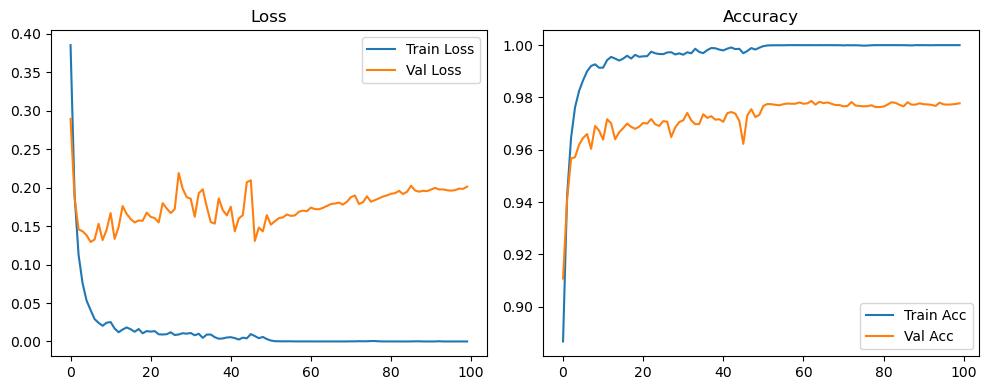

🚀 Running: batch256_lr0.01_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4888, Acc: 0.8513 | Val Loss: 0.2794, Acc: 0.9163


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2696, Acc: 0.9182 | Val Loss: 0.2094, Acc: 0.9364


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1922, Acc: 0.9415 | Val Loss: 0.1766, Acc: 0.9479


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1451, Acc: 0.9553 | Val Loss: 0.1272, Acc: 0.9627


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1253, Acc: 0.9604 | Val Loss: 0.1224, Acc: 0.9643


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1003, Acc: 0.9674 | Val Loss: 0.1171, Acc: 0.9673


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0862, Acc: 0.9725 | Val Loss: 0.1144, Acc: 0.9672


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0762, Acc: 0.9755 | Val Loss: 0.1099, Acc: 0.9688


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0635, Acc: 0.9782 | Val Loss: 0.1194, Acc: 0.9688


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0611, Acc: 0.9796 | Val Loss: 0.1076, Acc: 0.9704


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0528, Acc: 0.9829 | Val Loss: 0.1101, Acc: 0.9721


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0483, Acc: 0.9835 | Val Loss: 0.1101, Acc: 0.9712


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0444, Acc: 0.9853 | Val Loss: 0.1073, Acc: 0.9731


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0431, Acc: 0.9860 | Val Loss: 0.1159, Acc: 0.9718


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0379, Acc: 0.9874 | Val Loss: 0.1111, Acc: 0.9722


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0359, Acc: 0.9882 | Val Loss: 0.1093, Acc: 0.9735


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0340, Acc: 0.9886 | Val Loss: 0.1124, Acc: 0.9745


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0341, Acc: 0.9883 | Val Loss: 0.1043, Acc: 0.9761


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0316, Acc: 0.9897 | Val Loss: 0.1058, Acc: 0.9751


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0309, Acc: 0.9898 | Val Loss: 0.1059, Acc: 0.9748


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0304, Acc: 0.9897 | Val Loss: 0.1054, Acc: 0.9757


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0285, Acc: 0.9904 | Val Loss: 0.1072, Acc: 0.9740


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9908 | Val Loss: 0.1082, Acc: 0.9747


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0244, Acc: 0.9916 | Val Loss: 0.1108, Acc: 0.9743


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0244, Acc: 0.9918 | Val Loss: 0.1125, Acc: 0.9745


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0257, Acc: 0.9914 | Val Loss: 0.1074, Acc: 0.9742


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0224, Acc: 0.9923 | Val Loss: 0.1118, Acc: 0.9753


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0213, Acc: 0.9931 | Val Loss: 0.1177, Acc: 0.9743


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9932 | Val Loss: 0.1112, Acc: 0.9743


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9930 | Val Loss: 0.1005, Acc: 0.9771


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9925 | Val Loss: 0.1078, Acc: 0.9752


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0200, Acc: 0.9932 | Val Loss: 0.1037, Acc: 0.9768


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0211, Acc: 0.9928 | Val Loss: 0.1177, Acc: 0.9752


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0186, Acc: 0.9939 | Val Loss: 0.1125, Acc: 0.9758


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0184, Acc: 0.9938 | Val Loss: 0.1177, Acc: 0.9762


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9944 | Val Loss: 0.1182, Acc: 0.9754


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9935 | Val Loss: 0.1219, Acc: 0.9750


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9942 | Val Loss: 0.1162, Acc: 0.9763


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9939 | Val Loss: 0.1201, Acc: 0.9747


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9941 | Val Loss: 0.1095, Acc: 0.9772


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9949 | Val Loss: 0.1184, Acc: 0.9772


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9950 | Val Loss: 0.1307, Acc: 0.9753


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9951 | Val Loss: 0.1296, Acc: 0.9771


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9955 | Val Loss: 0.1278, Acc: 0.9759


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9948 | Val Loss: 0.1161, Acc: 0.9756


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9947 | Val Loss: 0.1160, Acc: 0.9763


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9949 | Val Loss: 0.1109, Acc: 0.9775


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9951 | Val Loss: 0.1213, Acc: 0.9758


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9958 | Val Loss: 0.1205, Acc: 0.9773


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9958 | Val Loss: 0.1070, Acc: 0.9775


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.1164, Acc: 0.9779


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.1176, Acc: 0.9785


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9978 | Val Loss: 0.1215, Acc: 0.9782


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1260, Acc: 0.9781


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1256, Acc: 0.9789


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9984 | Val Loss: 0.1262, Acc: 0.9782


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1274, Acc: 0.9787


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1283, Acc: 0.9780


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1278, Acc: 0.9781


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1343, Acc: 0.9782


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1283, Acc: 0.9779


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1325, Acc: 0.9777


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1400, Acc: 0.9780


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.1385, Acc: 0.9784


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.1352, Acc: 0.9777


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.1360, Acc: 0.9778


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.1309, Acc: 0.9782


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1268, Acc: 0.9783


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9987 | Val Loss: 0.1347, Acc: 0.9785


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1374, Acc: 0.9778


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1348, Acc: 0.9786


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1443, Acc: 0.9782


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.1363, Acc: 0.9792


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1455, Acc: 0.9779


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1423, Acc: 0.9790


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1359, Acc: 0.9792


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1380, Acc: 0.9782


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1362, Acc: 0.9778


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1318, Acc: 0.9785


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1339, Acc: 0.9791


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.1308, Acc: 0.9788


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.1346, Acc: 0.9785


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1316, Acc: 0.9793


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1301, Acc: 0.9790


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1318, Acc: 0.9784


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1320, Acc: 0.9788


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1330, Acc: 0.9785


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1360, Acc: 0.9786


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1328, Acc: 0.9782


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1335, Acc: 0.9782


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1375, Acc: 0.9781


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1382, Acc: 0.9789


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1420, Acc: 0.9788


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1429, Acc: 0.9792


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1474, Acc: 0.9787


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1452, Acc: 0.9786


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1395, Acc: 0.9796


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1401, Acc: 0.9792


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.1385, Acc: 0.9789


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1395, Acc: 0.9787


Final Test Loss: 0.1352 Accuracy: 0.9802


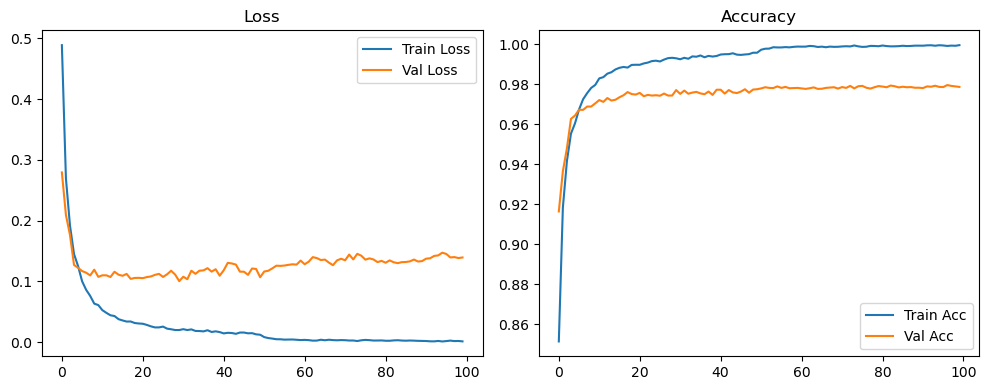

🚀 Running: batch256_lr0.01_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.7478, Acc: 0.7590 | Val Loss: 0.3266, Acc: 0.9032


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.4261, Acc: 0.8720 | Val Loss: 0.2587, Acc: 0.9226


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.3412, Acc: 0.8983 | Val Loss: 0.2246, Acc: 0.9365


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2807, Acc: 0.9173 | Val Loss: 0.1744, Acc: 0.9470


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.2427, Acc: 0.9284 | Val Loss: 0.1564, Acc: 0.9520


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.2141, Acc: 0.9363 | Val Loss: 0.1513, Acc: 0.9567


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1974, Acc: 0.9420 | Val Loss: 0.1403, Acc: 0.9596


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1793, Acc: 0.9454 | Val Loss: 0.1320, Acc: 0.9607


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1689, Acc: 0.9488 | Val Loss: 0.1224, Acc: 0.9647


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1557, Acc: 0.9531 | Val Loss: 0.1170, Acc: 0.9653


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1470, Acc: 0.9548 | Val Loss: 0.1225, Acc: 0.9660


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1388, Acc: 0.9570 | Val Loss: 0.1131, Acc: 0.9681


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1335, Acc: 0.9585 | Val Loss: 0.1129, Acc: 0.9673


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1289, Acc: 0.9610 | Val Loss: 0.1115, Acc: 0.9683


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1167, Acc: 0.9637 | Val Loss: 0.1083, Acc: 0.9694


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1192, Acc: 0.9632 | Val Loss: 0.1087, Acc: 0.9704


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1147, Acc: 0.9648 | Val Loss: 0.1015, Acc: 0.9711


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1075, Acc: 0.9667 | Val Loss: 0.1061, Acc: 0.9707


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1039, Acc: 0.9678 | Val Loss: 0.1063, Acc: 0.9706


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0999, Acc: 0.9682 | Val Loss: 0.1025, Acc: 0.9715


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.1014, Acc: 0.9681 | Val Loss: 0.1011, Acc: 0.9728


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0984, Acc: 0.9697 | Val Loss: 0.1016, Acc: 0.9712


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0921, Acc: 0.9712 | Val Loss: 0.1032, Acc: 0.9723


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0892, Acc: 0.9720 | Val Loss: 0.1040, Acc: 0.9704


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0880, Acc: 0.9720 | Val Loss: 0.1022, Acc: 0.9729


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0869, Acc: 0.9728 | Val Loss: 0.1033, Acc: 0.9725


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0829, Acc: 0.9740 | Val Loss: 0.1080, Acc: 0.9730


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0800, Acc: 0.9755 | Val Loss: 0.1040, Acc: 0.9733


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0780, Acc: 0.9751 | Val Loss: 0.1004, Acc: 0.9730


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0793, Acc: 0.9742 | Val Loss: 0.0993, Acc: 0.9735


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0751, Acc: 0.9763 | Val Loss: 0.0966, Acc: 0.9729


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0749, Acc: 0.9763 | Val Loss: 0.0941, Acc: 0.9748


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0734, Acc: 0.9769 | Val Loss: 0.0991, Acc: 0.9733


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0716, Acc: 0.9772 | Val Loss: 0.0998, Acc: 0.9738


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0699, Acc: 0.9779 | Val Loss: 0.0995, Acc: 0.9742


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0700, Acc: 0.9777 | Val Loss: 0.1030, Acc: 0.9746


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0698, Acc: 0.9781 | Val Loss: 0.0986, Acc: 0.9738


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0672, Acc: 0.9779 | Val Loss: 0.0991, Acc: 0.9744


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0656, Acc: 0.9800 | Val Loss: 0.0974, Acc: 0.9753


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0628, Acc: 0.9800 | Val Loss: 0.1011, Acc: 0.9758


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0652, Acc: 0.9794 | Val Loss: 0.0992, Acc: 0.9752


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0638, Acc: 0.9807 | Val Loss: 0.0994, Acc: 0.9757


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0616, Acc: 0.9807 | Val Loss: 0.0963, Acc: 0.9733


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0633, Acc: 0.9803 | Val Loss: 0.0983, Acc: 0.9744


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0636, Acc: 0.9798 | Val Loss: 0.0905, Acc: 0.9747


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0602, Acc: 0.9806 | Val Loss: 0.1023, Acc: 0.9758


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0595, Acc: 0.9806 | Val Loss: 0.1035, Acc: 0.9747


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0576, Acc: 0.9816 | Val Loss: 0.1056, Acc: 0.9740


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0582, Acc: 0.9817 | Val Loss: 0.1017, Acc: 0.9753


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0564, Acc: 0.9824 | Val Loss: 0.1007, Acc: 0.9749


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0488, Acc: 0.9842 | Val Loss: 0.1003, Acc: 0.9752


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0464, Acc: 0.9850 | Val Loss: 0.1010, Acc: 0.9765


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0444, Acc: 0.9862 | Val Loss: 0.1016, Acc: 0.9762


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0406, Acc: 0.9870 | Val Loss: 0.1000, Acc: 0.9762


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0407, Acc: 0.9872 | Val Loss: 0.1031, Acc: 0.9763


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0398, Acc: 0.9874 | Val Loss: 0.1006, Acc: 0.9767


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0381, Acc: 0.9878 | Val Loss: 0.1016, Acc: 0.9770


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0376, Acc: 0.9881 | Val Loss: 0.1019, Acc: 0.9763


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0367, Acc: 0.9880 | Val Loss: 0.1041, Acc: 0.9777


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0359, Acc: 0.9881 | Val Loss: 0.1020, Acc: 0.9773


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0347, Acc: 0.9890 | Val Loss: 0.1024, Acc: 0.9772


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0374, Acc: 0.9882 | Val Loss: 0.1016, Acc: 0.9772


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0332, Acc: 0.9891 | Val Loss: 0.1038, Acc: 0.9768


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0316, Acc: 0.9900 | Val Loss: 0.1025, Acc: 0.9770


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0322, Acc: 0.9892 | Val Loss: 0.1063, Acc: 0.9767


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0361, Acc: 0.9884 | Val Loss: 0.1042, Acc: 0.9768


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0351, Acc: 0.9891 | Val Loss: 0.1055, Acc: 0.9763


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0348, Acc: 0.9890 | Val Loss: 0.0990, Acc: 0.9772


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0299, Acc: 0.9904 | Val Loss: 0.1057, Acc: 0.9771


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0298, Acc: 0.9906 | Val Loss: 0.1066, Acc: 0.9764


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0311, Acc: 0.9905 | Val Loss: 0.1075, Acc: 0.9768


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0291, Acc: 0.9906 | Val Loss: 0.1061, Acc: 0.9766


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0303, Acc: 0.9906 | Val Loss: 0.1036, Acc: 0.9764


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0309, Acc: 0.9903 | Val Loss: 0.1083, Acc: 0.9769


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0286, Acc: 0.9909 | Val Loss: 0.1072, Acc: 0.9765


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0311, Acc: 0.9903 | Val Loss: 0.1048, Acc: 0.9768


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0270, Acc: 0.9914 | Val Loss: 0.1073, Acc: 0.9760


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0287, Acc: 0.9910 | Val Loss: 0.1075, Acc: 0.9762


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0280, Acc: 0.9911 | Val Loss: 0.1085, Acc: 0.9776


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0309, Acc: 0.9906 | Val Loss: 0.1065, Acc: 0.9771


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0271, Acc: 0.9912 | Val Loss: 0.1081, Acc: 0.9766


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0283, Acc: 0.9907 | Val Loss: 0.1104, Acc: 0.9768


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0265, Acc: 0.9909 | Val Loss: 0.1102, Acc: 0.9779


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0289, Acc: 0.9906 | Val Loss: 0.1051, Acc: 0.9773


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0276, Acc: 0.9912 | Val Loss: 0.1051, Acc: 0.9773


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0246, Acc: 0.9916 | Val Loss: 0.1104, Acc: 0.9771


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0264, Acc: 0.9919 | Val Loss: 0.1071, Acc: 0.9777


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0259, Acc: 0.9916 | Val Loss: 0.1082, Acc: 0.9776


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0262, Acc: 0.9917 | Val Loss: 0.1103, Acc: 0.9770


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0239, Acc: 0.9921 | Val Loss: 0.1084, Acc: 0.9770


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0234, Acc: 0.9924 | Val Loss: 0.1080, Acc: 0.9774


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0259, Acc: 0.9922 | Val Loss: 0.1084, Acc: 0.9769


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0251, Acc: 0.9916 | Val Loss: 0.1100, Acc: 0.9766


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0260, Acc: 0.9913 | Val Loss: 0.1097, Acc: 0.9778


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0239, Acc: 0.9919 | Val Loss: 0.1097, Acc: 0.9769


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0262, Acc: 0.9918 | Val Loss: 0.1097, Acc: 0.9770


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0252, Acc: 0.9917 | Val Loss: 0.1081, Acc: 0.9772


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0252, Acc: 0.9921 | Val Loss: 0.1080, Acc: 0.9772


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0234, Acc: 0.9921 | Val Loss: 0.1113, Acc: 0.9767


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0245, Acc: 0.9921 | Val Loss: 0.1119, Acc: 0.9768


Final Test Loss: 0.0999 Accuracy: 0.9779


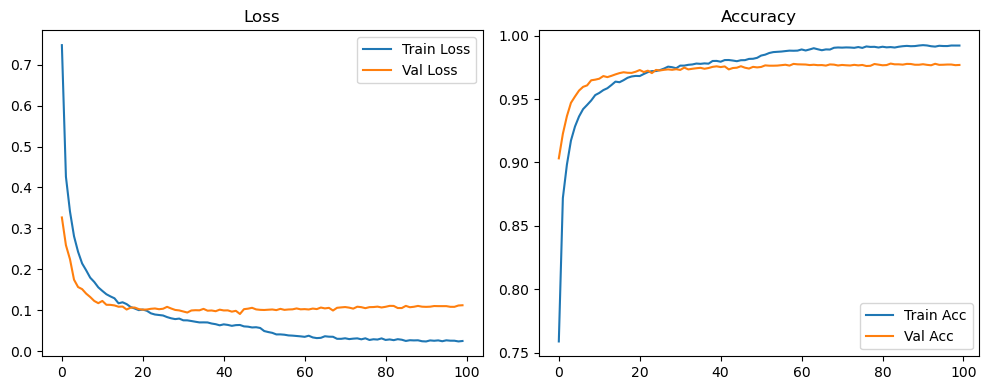

🚀 Running: batch256_lr0.005_0.005_0.005_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4017, Acc: 0.8915 | Val Loss: 0.3005, Acc: 0.9072


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2083, Acc: 0.9369 | Val Loss: 0.1850, Acc: 0.9430


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1181, Acc: 0.9636 | Val Loss: 0.1397, Acc: 0.9567


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0753, Acc: 0.9754 | Val Loss: 0.1335, Acc: 0.9583


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0487, Acc: 0.9844 | Val Loss: 0.1356, Acc: 0.9615


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0307, Acc: 0.9908 | Val Loss: 0.1232, Acc: 0.9660


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0242, Acc: 0.9918 | Val Loss: 0.1390, Acc: 0.9634


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0223, Acc: 0.9928 | Val Loss: 0.1282, Acc: 0.9647


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0166, Acc: 0.9940 | Val Loss: 0.1250, Acc: 0.9688


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0168, Acc: 0.9942 | Val Loss: 0.1232, Acc: 0.9691


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0156, Acc: 0.9946 | Val Loss: 0.1252, Acc: 0.9698


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9955 | Val Loss: 0.1162, Acc: 0.9751


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9975 | Val Loss: 0.1334, Acc: 0.9705


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0144, Acc: 0.9952 | Val Loss: 0.1597, Acc: 0.9661


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0156, Acc: 0.9945 | Val Loss: 0.1537, Acc: 0.9669


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9964 | Val Loss: 0.1606, Acc: 0.9651


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9968 | Val Loss: 0.1303, Acc: 0.9734


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9974 | Val Loss: 0.1395, Acc: 0.9699


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.1456, Acc: 0.9698


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9955 | Val Loss: 0.1880, Acc: 0.9647


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9952 | Val Loss: 0.1610, Acc: 0.9663


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9965 | Val Loss: 0.1366, Acc: 0.9717


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.1402, Acc: 0.9703


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.1530, Acc: 0.9724


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.2098, Acc: 0.9620


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9976 | Val Loss: 0.1660, Acc: 0.9692


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.1498, Acc: 0.9743


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9967 | Val Loss: 0.1993, Acc: 0.9651


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9972 | Val Loss: 0.1574, Acc: 0.9689


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.1420, Acc: 0.9729


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9987 | Val Loss: 0.1456, Acc: 0.9742


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1696, Acc: 0.9703


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9983 | Val Loss: 0.1751, Acc: 0.9695


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1583, Acc: 0.9705


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9979 | Val Loss: 0.1656, Acc: 0.9692


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9973 | Val Loss: 0.1567, Acc: 0.9716


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.1698, Acc: 0.9705


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.1550, Acc: 0.9721


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9989 | Val Loss: 0.1627, Acc: 0.9727


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9980 | Val Loss: 0.1430, Acc: 0.9727


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1400, Acc: 0.9753


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.1458, Acc: 0.9734


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1683, Acc: 0.9723


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.1789, Acc: 0.9711


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9974 | Val Loss: 0.1693, Acc: 0.9732


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.1917, Acc: 0.9692


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.1722, Acc: 0.9700


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1711, Acc: 0.9710


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1759, Acc: 0.9709


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.1683, Acc: 0.9733


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1749, Acc: 0.9726


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9984 | Val Loss: 0.1548, Acc: 0.9722


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.1773, Acc: 0.9725


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1655, Acc: 0.9734


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1757, Acc: 0.9698


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1658, Acc: 0.9722


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.1561, Acc: 0.9738


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1639, Acc: 0.9737


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.1727, Acc: 0.9725


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1622, Acc: 0.9723


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1721, Acc: 0.9702


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1510, Acc: 0.9728


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1754, Acc: 0.9715


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1681, Acc: 0.9734


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1493, Acc: 0.9757


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1485, Acc: 0.9729


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1595, Acc: 0.9737


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1620, Acc: 0.9742


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1759, Acc: 0.9713


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.1705, Acc: 0.9736


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.1831, Acc: 0.9726


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.1572, Acc: 0.9744


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1671, Acc: 0.9751


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1784, Acc: 0.9742


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1772, Acc: 0.9739


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1825, Acc: 0.9718


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9989 | Val Loss: 0.1573, Acc: 0.9730


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.1594, Acc: 0.9724


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.1678, Acc: 0.9718


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.1690, Acc: 0.9751


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1666, Acc: 0.9756


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1952, Acc: 0.9716


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1539, Acc: 0.9734


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1812, Acc: 0.9730


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1641, Acc: 0.9722


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.1568, Acc: 0.9734


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1606, Acc: 0.9764


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1729, Acc: 0.9742


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.1800, Acc: 0.9703


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1493, Acc: 0.9741


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1892, Acc: 0.9710


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.1598, Acc: 0.9737


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1522, Acc: 0.9729


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1365, Acc: 0.9743


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9998 | Val Loss: 0.1594, Acc: 0.9745


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1541, Acc: 0.9735


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.1727, Acc: 0.9748


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.1687, Acc: 0.9729


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.1429, Acc: 0.9754


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1641, Acc: 0.9750


Final Test Loss: 0.1384 Accuracy: 0.9793


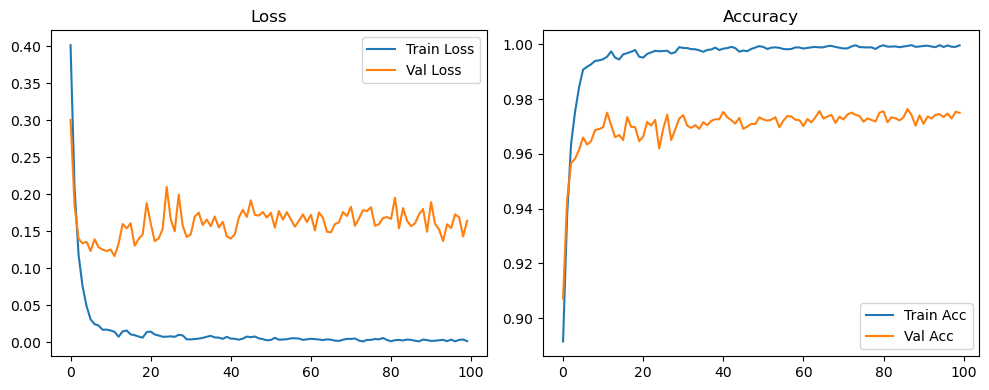

🚀 Running: batch256_lr0.005_0.005_0.005_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.5269, Acc: 0.8488 | Val Loss: 0.2998, Acc: 0.9093


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.3083, Acc: 0.9075 | Val Loss: 0.2401, Acc: 0.9276


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.2352, Acc: 0.9281 | Val Loss: 0.2031, Acc: 0.9398


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1814, Acc: 0.9447 | Val Loss: 0.1535, Acc: 0.9533


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1538, Acc: 0.9516 | Val Loss: 0.1406, Acc: 0.9573


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1268, Acc: 0.9601 | Val Loss: 0.1288, Acc: 0.9618


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1111, Acc: 0.9651 | Val Loss: 0.1267, Acc: 0.9633


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0961, Acc: 0.9700 | Val Loss: 0.1266, Acc: 0.9642


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0810, Acc: 0.9733 | Val Loss: 0.1212, Acc: 0.9651


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0755, Acc: 0.9754 | Val Loss: 0.1136, Acc: 0.9683


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0661, Acc: 0.9781 | Val Loss: 0.1116, Acc: 0.9688


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0613, Acc: 0.9798 | Val Loss: 0.1119, Acc: 0.9698


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0525, Acc: 0.9825 | Val Loss: 0.1166, Acc: 0.9690


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0493, Acc: 0.9833 | Val Loss: 0.1138, Acc: 0.9711


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0482, Acc: 0.9834 | Val Loss: 0.1179, Acc: 0.9691


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0426, Acc: 0.9853 | Val Loss: 0.1158, Acc: 0.9700


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0417, Acc: 0.9862 | Val Loss: 0.1110, Acc: 0.9711


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0374, Acc: 0.9869 | Val Loss: 0.1222, Acc: 0.9716


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0348, Acc: 0.9880 | Val Loss: 0.1136, Acc: 0.9714


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0353, Acc: 0.9875 | Val Loss: 0.1145, Acc: 0.9712


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0355, Acc: 0.9884 | Val Loss: 0.1119, Acc: 0.9727


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0321, Acc: 0.9888 | Val Loss: 0.1186, Acc: 0.9712


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0314, Acc: 0.9893 | Val Loss: 0.1238, Acc: 0.9704


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0312, Acc: 0.9898 | Val Loss: 0.1206, Acc: 0.9712


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0262, Acc: 0.9906 | Val Loss: 0.1212, Acc: 0.9720


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0276, Acc: 0.9913 | Val Loss: 0.1129, Acc: 0.9729


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0245, Acc: 0.9916 | Val Loss: 0.1126, Acc: 0.9726


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0242, Acc: 0.9917 | Val Loss: 0.1248, Acc: 0.9721


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0243, Acc: 0.9914 | Val Loss: 0.1152, Acc: 0.9738


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0258, Acc: 0.9914 | Val Loss: 0.1151, Acc: 0.9742


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0210, Acc: 0.9929 | Val Loss: 0.1165, Acc: 0.9743


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0210, Acc: 0.9928 | Val Loss: 0.1199, Acc: 0.9731


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0231, Acc: 0.9920 | Val Loss: 0.1220, Acc: 0.9738


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0210, Acc: 0.9924 | Val Loss: 0.1124, Acc: 0.9742


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0207, Acc: 0.9930 | Val Loss: 0.1123, Acc: 0.9736


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0196, Acc: 0.9936 | Val Loss: 0.1184, Acc: 0.9756


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0191, Acc: 0.9933 | Val Loss: 0.1273, Acc: 0.9747


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0206, Acc: 0.9931 | Val Loss: 0.1169, Acc: 0.9749


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0168, Acc: 0.9941 | Val Loss: 0.1232, Acc: 0.9756


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0172, Acc: 0.9939 | Val Loss: 0.1267, Acc: 0.9742


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0164, Acc: 0.9944 | Val Loss: 0.1221, Acc: 0.9742


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9942 | Val Loss: 0.1210, Acc: 0.9740


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0197, Acc: 0.9932 | Val Loss: 0.1227, Acc: 0.9742


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0173, Acc: 0.9942 | Val Loss: 0.1220, Acc: 0.9746


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9944 | Val Loss: 0.1176, Acc: 0.9772


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9945 | Val Loss: 0.1176, Acc: 0.9729


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0166, Acc: 0.9944 | Val Loss: 0.1133, Acc: 0.9762


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0144, Acc: 0.9953 | Val Loss: 0.1297, Acc: 0.9748


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0179, Acc: 0.9939 | Val Loss: 0.1142, Acc: 0.9745


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9952 | Val Loss: 0.1210, Acc: 0.9749


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9949 | Val Loss: 0.1169, Acc: 0.9757


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0153, Acc: 0.9947 | Val Loss: 0.1261, Acc: 0.9743


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0148, Acc: 0.9952 | Val Loss: 0.1162, Acc: 0.9755


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9953 | Val Loss: 0.1178, Acc: 0.9762


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9954 | Val Loss: 0.1292, Acc: 0.9760


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9956 | Val Loss: 0.1301, Acc: 0.9749


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9960 | Val Loss: 0.1315, Acc: 0.9760


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9956 | Val Loss: 0.1273, Acc: 0.9762


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9959 | Val Loss: 0.1308, Acc: 0.9751


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9961 | Val Loss: 0.1321, Acc: 0.9738


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9957 | Val Loss: 0.1330, Acc: 0.9748


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9959 | Val Loss: 0.1440, Acc: 0.9740


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9960 | Val Loss: 0.1356, Acc: 0.9751


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9957 | Val Loss: 0.1330, Acc: 0.9765


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9966 | Val Loss: 0.1428, Acc: 0.9748


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0135, Acc: 0.9953 | Val Loss: 0.1388, Acc: 0.9752


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9954 | Val Loss: 0.1283, Acc: 0.9755


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9964 | Val Loss: 0.1322, Acc: 0.9768


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0145, Acc: 0.9951 | Val Loss: 0.1160, Acc: 0.9762


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9964 | Val Loss: 0.1377, Acc: 0.9755


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9960 | Val Loss: 0.1380, Acc: 0.9761


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9962 | Val Loss: 0.1261, Acc: 0.9778


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.1314, Acc: 0.9760


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9966 | Val Loss: 0.1266, Acc: 0.9762


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9968 | Val Loss: 0.1261, Acc: 0.9759


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9962 | Val Loss: 0.1265, Acc: 0.9767


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9960 | Val Loss: 0.1215, Acc: 0.9762


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9965 | Val Loss: 0.1183, Acc: 0.9768


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9968 | Val Loss: 0.1291, Acc: 0.9769


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9971 | Val Loss: 0.1422, Acc: 0.9754


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9965 | Val Loss: 0.1194, Acc: 0.9762


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9964 | Val Loss: 0.1207, Acc: 0.9760


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9971 | Val Loss: 0.1272, Acc: 0.9777


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9977 | Val Loss: 0.1461, Acc: 0.9758


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9971 | Val Loss: 0.1279, Acc: 0.9760


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9968 | Val Loss: 0.1400, Acc: 0.9752


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9966 | Val Loss: 0.1216, Acc: 0.9765


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.1291, Acc: 0.9752


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9969 | Val Loss: 0.1291, Acc: 0.9759


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.1344, Acc: 0.9757


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9968 | Val Loss: 0.1268, Acc: 0.9752


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9970 | Val Loss: 0.1250, Acc: 0.9767


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.1369, Acc: 0.9760


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9967 | Val Loss: 0.1254, Acc: 0.9761


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.1311, Acc: 0.9759


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.1363, Acc: 0.9749


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9969 | Val Loss: 0.1280, Acc: 0.9766


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.1331, Acc: 0.9768


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.1339, Acc: 0.9763


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.1298, Acc: 0.9765


Final Test Loss: 0.1255 Accuracy: 0.9761


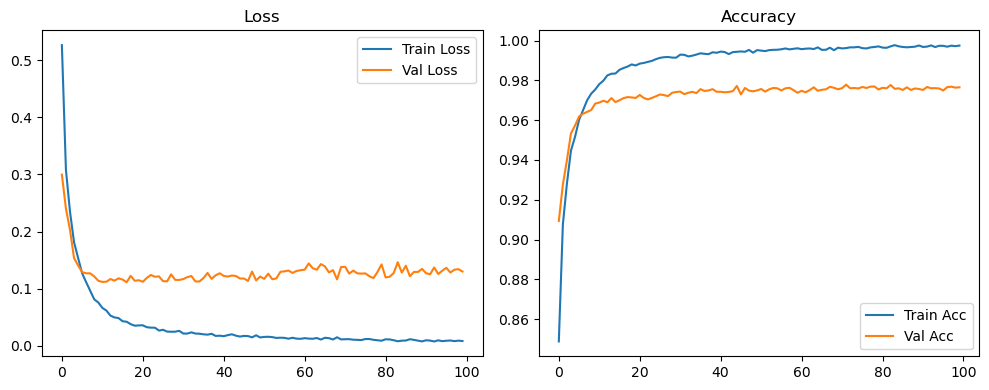

🚀 Running: batch256_lr0.005_0.005_0.005_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.8387, Acc: 0.7338 | Val Loss: 0.3580, Acc: 0.8943


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.4902, Acc: 0.8520 | Val Loss: 0.2999, Acc: 0.9125


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.4077, Acc: 0.8782 | Val Loss: 0.2648, Acc: 0.9218


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.3438, Acc: 0.8970 | Val Loss: 0.2176, Acc: 0.9345


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.3014, Acc: 0.9107 | Val Loss: 0.1917, Acc: 0.9427


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.2656, Acc: 0.9201 | Val Loss: 0.1781, Acc: 0.9478


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.2459, Acc: 0.9269 | Val Loss: 0.1626, Acc: 0.9525


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.2184, Acc: 0.9344 | Val Loss: 0.1523, Acc: 0.9563


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.2056, Acc: 0.9380 | Val Loss: 0.1441, Acc: 0.9572


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.1875, Acc: 0.9443 | Val Loss: 0.1348, Acc: 0.9597


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.1771, Acc: 0.9463 | Val Loss: 0.1371, Acc: 0.9597


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.1701, Acc: 0.9486 | Val Loss: 0.1261, Acc: 0.9645


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.1611, Acc: 0.9503 | Val Loss: 0.1273, Acc: 0.9620


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.1547, Acc: 0.9531 | Val Loss: 0.1233, Acc: 0.9639


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.1444, Acc: 0.9558 | Val Loss: 0.1177, Acc: 0.9676


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.1404, Acc: 0.9566 | Val Loss: 0.1150, Acc: 0.9668


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.1345, Acc: 0.9588 | Val Loss: 0.1137, Acc: 0.9672


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.1292, Acc: 0.9607 | Val Loss: 0.1173, Acc: 0.9667


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.1243, Acc: 0.9616 | Val Loss: 0.1139, Acc: 0.9694


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.1188, Acc: 0.9621 | Val Loss: 0.1085, Acc: 0.9698


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.1195, Acc: 0.9625 | Val Loss: 0.1079, Acc: 0.9711


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.1143, Acc: 0.9639 | Val Loss: 0.1043, Acc: 0.9705


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.1079, Acc: 0.9665 | Val Loss: 0.1045, Acc: 0.9708


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.1038, Acc: 0.9671 | Val Loss: 0.1119, Acc: 0.9692


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.1037, Acc: 0.9665 | Val Loss: 0.1111, Acc: 0.9709


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.1065, Acc: 0.9667 | Val Loss: 0.1057, Acc: 0.9714


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0977, Acc: 0.9686 | Val Loss: 0.1132, Acc: 0.9698


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0941, Acc: 0.9703 | Val Loss: 0.1076, Acc: 0.9709


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0958, Acc: 0.9705 | Val Loss: 0.1061, Acc: 0.9711


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0905, Acc: 0.9714 | Val Loss: 0.1052, Acc: 0.9721


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0897, Acc: 0.9719 | Val Loss: 0.1057, Acc: 0.9722


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0914, Acc: 0.9715 | Val Loss: 0.1032, Acc: 0.9723


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0875, Acc: 0.9711 | Val Loss: 0.1053, Acc: 0.9722


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0823, Acc: 0.9734 | Val Loss: 0.1062, Acc: 0.9728


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0816, Acc: 0.9729 | Val Loss: 0.1076, Acc: 0.9710


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0788, Acc: 0.9750 | Val Loss: 0.1039, Acc: 0.9721


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0768, Acc: 0.9756 | Val Loss: 0.1059, Acc: 0.9720


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0769, Acc: 0.9750 | Val Loss: 0.1042, Acc: 0.9728


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0774, Acc: 0.9752 | Val Loss: 0.1040, Acc: 0.9728


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0809, Acc: 0.9746 | Val Loss: 0.1022, Acc: 0.9737


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0760, Acc: 0.9760 | Val Loss: 0.1023, Acc: 0.9736


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0711, Acc: 0.9770 | Val Loss: 0.1007, Acc: 0.9748


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0720, Acc: 0.9771 | Val Loss: 0.1084, Acc: 0.9732


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0718, Acc: 0.9769 | Val Loss: 0.1001, Acc: 0.9739


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0719, Acc: 0.9768 | Val Loss: 0.1034, Acc: 0.9735


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0684, Acc: 0.9776 | Val Loss: 0.1031, Acc: 0.9741


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0692, Acc: 0.9780 | Val Loss: 0.1000, Acc: 0.9744


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0662, Acc: 0.9779 | Val Loss: 0.1061, Acc: 0.9741


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0670, Acc: 0.9789 | Val Loss: 0.1008, Acc: 0.9740


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0642, Acc: 0.9792 | Val Loss: 0.1037, Acc: 0.9741


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0601, Acc: 0.9805 | Val Loss: 0.1091, Acc: 0.9738


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0635, Acc: 0.9789 | Val Loss: 0.1078, Acc: 0.9742


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0637, Acc: 0.9805 | Val Loss: 0.1059, Acc: 0.9741


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0619, Acc: 0.9796 | Val Loss: 0.1034, Acc: 0.9739


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0607, Acc: 0.9805 | Val Loss: 0.1008, Acc: 0.9757


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0578, Acc: 0.9815 | Val Loss: 0.0976, Acc: 0.9740


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0600, Acc: 0.9804 | Val Loss: 0.1008, Acc: 0.9737


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0559, Acc: 0.9813 | Val Loss: 0.1045, Acc: 0.9739


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0565, Acc: 0.9818 | Val Loss: 0.1026, Acc: 0.9744


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0574, Acc: 0.9820 | Val Loss: 0.0962, Acc: 0.9745


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0562, Acc: 0.9822 | Val Loss: 0.1031, Acc: 0.9738


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0525, Acc: 0.9831 | Val Loss: 0.1050, Acc: 0.9744


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0526, Acc: 0.9821 | Val Loss: 0.0980, Acc: 0.9753


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0529, Acc: 0.9831 | Val Loss: 0.0989, Acc: 0.9758


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0517, Acc: 0.9831 | Val Loss: 0.1027, Acc: 0.9749


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0526, Acc: 0.9828 | Val Loss: 0.1027, Acc: 0.9755


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0509, Acc: 0.9836 | Val Loss: 0.1052, Acc: 0.9741


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0532, Acc: 0.9831 | Val Loss: 0.0997, Acc: 0.9753


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0498, Acc: 0.9840 | Val Loss: 0.1065, Acc: 0.9743


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0499, Acc: 0.9838 | Val Loss: 0.1041, Acc: 0.9729


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0468, Acc: 0.9849 | Val Loss: 0.1083, Acc: 0.9749


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0483, Acc: 0.9842 | Val Loss: 0.1067, Acc: 0.9738


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0487, Acc: 0.9841 | Val Loss: 0.1015, Acc: 0.9745


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0487, Acc: 0.9841 | Val Loss: 0.1046, Acc: 0.9742


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0456, Acc: 0.9859 | Val Loss: 0.1039, Acc: 0.9754


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0466, Acc: 0.9852 | Val Loss: 0.1058, Acc: 0.9751


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0442, Acc: 0.9855 | Val Loss: 0.0992, Acc: 0.9753


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0450, Acc: 0.9853 | Val Loss: 0.1048, Acc: 0.9757


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0462, Acc: 0.9846 | Val Loss: 0.1052, Acc: 0.9750


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0468, Acc: 0.9845 | Val Loss: 0.1075, Acc: 0.9744


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0455, Acc: 0.9851 | Val Loss: 0.1048, Acc: 0.9759


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0452, Acc: 0.9853 | Val Loss: 0.1070, Acc: 0.9742


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0447, Acc: 0.9854 | Val Loss: 0.1045, Acc: 0.9756


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0457, Acc: 0.9855 | Val Loss: 0.1009, Acc: 0.9765


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0440, Acc: 0.9858 | Val Loss: 0.1017, Acc: 0.9744


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0428, Acc: 0.9861 | Val Loss: 0.1020, Acc: 0.9742


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0448, Acc: 0.9853 | Val Loss: 0.1039, Acc: 0.9756


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0433, Acc: 0.9860 | Val Loss: 0.1036, Acc: 0.9762


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0411, Acc: 0.9866 | Val Loss: 0.1070, Acc: 0.9751


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0410, Acc: 0.9872 | Val Loss: 0.1062, Acc: 0.9749


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0393, Acc: 0.9874 | Val Loss: 0.1085, Acc: 0.9750


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0397, Acc: 0.9869 | Val Loss: 0.1093, Acc: 0.9743


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0413, Acc: 0.9870 | Val Loss: 0.1045, Acc: 0.9754


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0422, Acc: 0.9863 | Val Loss: 0.1027, Acc: 0.9750


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0414, Acc: 0.9869 | Val Loss: 0.1042, Acc: 0.9748


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0388, Acc: 0.9871 | Val Loss: 0.1078, Acc: 0.9758


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0413, Acc: 0.9866 | Val Loss: 0.1030, Acc: 0.9758


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0381, Acc: 0.9881 | Val Loss: 0.1076, Acc: 0.9749


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0427, Acc: 0.9863 | Val Loss: 0.1045, Acc: 0.9758


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0399, Acc: 0.9870 | Val Loss: 0.1048, Acc: 0.9756


Final Test Loss: 0.0995 Accuracy: 0.9764


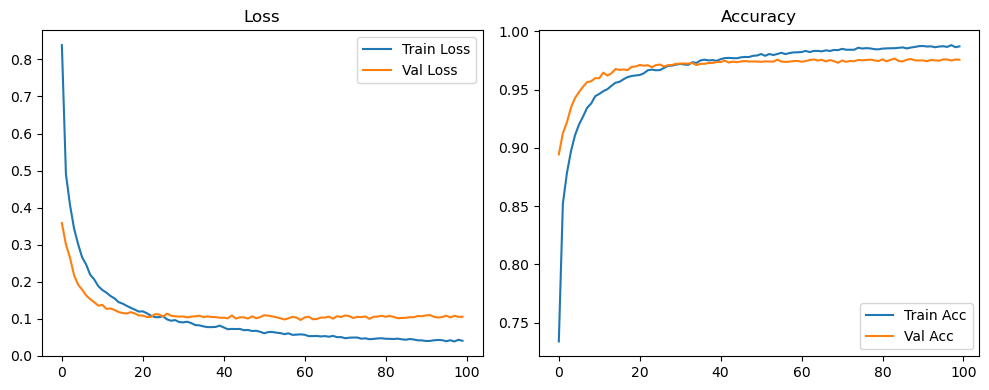

🚀 Running: batch256_lr0.005_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4017, Acc: 0.8915 | Val Loss: 0.3005, Acc: 0.9072


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2083, Acc: 0.9369 | Val Loss: 0.1850, Acc: 0.9430


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1181, Acc: 0.9636 | Val Loss: 0.1397, Acc: 0.9567


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0753, Acc: 0.9754 | Val Loss: 0.1335, Acc: 0.9583


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0487, Acc: 0.9844 | Val Loss: 0.1356, Acc: 0.9615


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0307, Acc: 0.9908 | Val Loss: 0.1232, Acc: 0.9660


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0242, Acc: 0.9918 | Val Loss: 0.1390, Acc: 0.9634


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0223, Acc: 0.9928 | Val Loss: 0.1282, Acc: 0.9647


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0166, Acc: 0.9940 | Val Loss: 0.1250, Acc: 0.9688


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0168, Acc: 0.9942 | Val Loss: 0.1232, Acc: 0.9691


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0156, Acc: 0.9946 | Val Loss: 0.1252, Acc: 0.9698


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9955 | Val Loss: 0.1162, Acc: 0.9751


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9975 | Val Loss: 0.1334, Acc: 0.9705


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0144, Acc: 0.9952 | Val Loss: 0.1597, Acc: 0.9661


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0156, Acc: 0.9945 | Val Loss: 0.1537, Acc: 0.9669


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9964 | Val Loss: 0.1606, Acc: 0.9651


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9968 | Val Loss: 0.1303, Acc: 0.9734


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9974 | Val Loss: 0.1395, Acc: 0.9699


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.1456, Acc: 0.9698


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9955 | Val Loss: 0.1880, Acc: 0.9647


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9952 | Val Loss: 0.1610, Acc: 0.9663


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9965 | Val Loss: 0.1366, Acc: 0.9717


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.1402, Acc: 0.9703


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.1530, Acc: 0.9724


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.2098, Acc: 0.9620


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9976 | Val Loss: 0.1660, Acc: 0.9692


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.1498, Acc: 0.9743


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9967 | Val Loss: 0.1993, Acc: 0.9651


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9972 | Val Loss: 0.1574, Acc: 0.9689


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.1420, Acc: 0.9729


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9987 | Val Loss: 0.1456, Acc: 0.9742


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1696, Acc: 0.9703


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9983 | Val Loss: 0.1751, Acc: 0.9695


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1583, Acc: 0.9705


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9979 | Val Loss: 0.1656, Acc: 0.9692


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9973 | Val Loss: 0.1567, Acc: 0.9716


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.1698, Acc: 0.9705


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.1550, Acc: 0.9721


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9989 | Val Loss: 0.1627, Acc: 0.9727


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9980 | Val Loss: 0.1430, Acc: 0.9727


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1400, Acc: 0.9753


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.1458, Acc: 0.9734


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1683, Acc: 0.9723


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.1789, Acc: 0.9711


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9974 | Val Loss: 0.1693, Acc: 0.9732


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.1917, Acc: 0.9692


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.1722, Acc: 0.9700


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1711, Acc: 0.9710


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1759, Acc: 0.9709


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.1683, Acc: 0.9733


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1548, Acc: 0.9755


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1579, Acc: 0.9743


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1577, Acc: 0.9757


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1566, Acc: 0.9758


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1622, Acc: 0.9765


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1602, Acc: 0.9768


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1604, Acc: 0.9762


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1608, Acc: 0.9763


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1730, Acc: 0.9752


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1712, Acc: 0.9760


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1693, Acc: 0.9754


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1692, Acc: 0.9761


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1649, Acc: 0.9768


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1694, Acc: 0.9758


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1639, Acc: 0.9767


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1710, Acc: 0.9759


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1677, Acc: 0.9758


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1654, Acc: 0.9762


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1906, Acc: 0.9738


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1898, Acc: 0.9722


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.2125, Acc: 0.9683


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1904, Acc: 0.9742


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1671, Acc: 0.9750


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1674, Acc: 0.9751


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1700, Acc: 0.9762


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1678, Acc: 0.9769


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1707, Acc: 0.9768


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1758, Acc: 0.9763


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1748, Acc: 0.9761


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1771, Acc: 0.9756


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1737, Acc: 0.9752


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1782, Acc: 0.9754


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1765, Acc: 0.9765


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1722, Acc: 0.9770


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1774, Acc: 0.9765


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1777, Acc: 0.9762


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1739, Acc: 0.9772


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1753, Acc: 0.9770


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1763, Acc: 0.9773


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1743, Acc: 0.9775


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1764, Acc: 0.9771


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1756, Acc: 0.9772


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1770, Acc: 0.9766


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1841, Acc: 0.9758


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1844, Acc: 0.9763


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1837, Acc: 0.9768


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1893, Acc: 0.9762


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1968, Acc: 0.9752


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1828, Acc: 0.9761


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1826, Acc: 0.9756


Final Test Loss: 0.1530 Accuracy: 0.9779


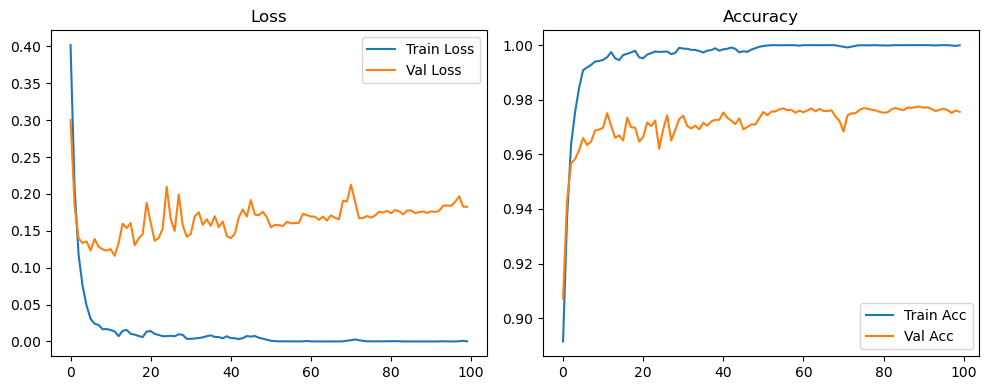

🚀 Running: batch256_lr0.005_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.5269, Acc: 0.8488 | Val Loss: 0.2998, Acc: 0.9093


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.3083, Acc: 0.9075 | Val Loss: 0.2401, Acc: 0.9276


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.2352, Acc: 0.9281 | Val Loss: 0.2031, Acc: 0.9398


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1814, Acc: 0.9447 | Val Loss: 0.1535, Acc: 0.9533


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1538, Acc: 0.9516 | Val Loss: 0.1406, Acc: 0.9573


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1268, Acc: 0.9601 | Val Loss: 0.1288, Acc: 0.9618


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1111, Acc: 0.9651 | Val Loss: 0.1267, Acc: 0.9633


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0961, Acc: 0.9700 | Val Loss: 0.1266, Acc: 0.9642


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0810, Acc: 0.9733 | Val Loss: 0.1212, Acc: 0.9651


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0755, Acc: 0.9754 | Val Loss: 0.1136, Acc: 0.9683


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0661, Acc: 0.9781 | Val Loss: 0.1116, Acc: 0.9688


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0613, Acc: 0.9798 | Val Loss: 0.1119, Acc: 0.9698


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0525, Acc: 0.9825 | Val Loss: 0.1166, Acc: 0.9690


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0493, Acc: 0.9833 | Val Loss: 0.1138, Acc: 0.9711


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0482, Acc: 0.9834 | Val Loss: 0.1179, Acc: 0.9691


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0426, Acc: 0.9853 | Val Loss: 0.1158, Acc: 0.9700


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0417, Acc: 0.9862 | Val Loss: 0.1110, Acc: 0.9711


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0374, Acc: 0.9869 | Val Loss: 0.1222, Acc: 0.9716


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0348, Acc: 0.9880 | Val Loss: 0.1136, Acc: 0.9714


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0353, Acc: 0.9875 | Val Loss: 0.1145, Acc: 0.9712


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0355, Acc: 0.9884 | Val Loss: 0.1119, Acc: 0.9727


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0321, Acc: 0.9888 | Val Loss: 0.1186, Acc: 0.9712


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0314, Acc: 0.9893 | Val Loss: 0.1238, Acc: 0.9704


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0312, Acc: 0.9898 | Val Loss: 0.1206, Acc: 0.9712


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0262, Acc: 0.9906 | Val Loss: 0.1212, Acc: 0.9720


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0276, Acc: 0.9913 | Val Loss: 0.1129, Acc: 0.9729


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0245, Acc: 0.9916 | Val Loss: 0.1126, Acc: 0.9726


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0242, Acc: 0.9917 | Val Loss: 0.1248, Acc: 0.9721


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0243, Acc: 0.9914 | Val Loss: 0.1152, Acc: 0.9738


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0258, Acc: 0.9914 | Val Loss: 0.1151, Acc: 0.9742


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0210, Acc: 0.9929 | Val Loss: 0.1165, Acc: 0.9743


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0210, Acc: 0.9928 | Val Loss: 0.1199, Acc: 0.9731


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0231, Acc: 0.9920 | Val Loss: 0.1220, Acc: 0.9738


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0210, Acc: 0.9924 | Val Loss: 0.1124, Acc: 0.9742


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0207, Acc: 0.9930 | Val Loss: 0.1123, Acc: 0.9736


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0196, Acc: 0.9936 | Val Loss: 0.1184, Acc: 0.9756


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0191, Acc: 0.9933 | Val Loss: 0.1273, Acc: 0.9747


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0206, Acc: 0.9931 | Val Loss: 0.1169, Acc: 0.9749


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0168, Acc: 0.9941 | Val Loss: 0.1232, Acc: 0.9756


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0172, Acc: 0.9939 | Val Loss: 0.1267, Acc: 0.9742


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0164, Acc: 0.9944 | Val Loss: 0.1221, Acc: 0.9742


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9942 | Val Loss: 0.1210, Acc: 0.9740


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0197, Acc: 0.9932 | Val Loss: 0.1227, Acc: 0.9742


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0173, Acc: 0.9942 | Val Loss: 0.1220, Acc: 0.9746


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9944 | Val Loss: 0.1176, Acc: 0.9772


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9945 | Val Loss: 0.1176, Acc: 0.9729


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0166, Acc: 0.9944 | Val Loss: 0.1133, Acc: 0.9762


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0144, Acc: 0.9953 | Val Loss: 0.1297, Acc: 0.9748


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0179, Acc: 0.9939 | Val Loss: 0.1142, Acc: 0.9745


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9952 | Val Loss: 0.1210, Acc: 0.9749


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0114, Acc: 0.9963 | Val Loss: 0.1164, Acc: 0.9767


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.1235, Acc: 0.9765


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.1279, Acc: 0.9753


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9974 | Val Loss: 0.1245, Acc: 0.9766


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.1313, Acc: 0.9766


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9978 | Val Loss: 0.1300, Acc: 0.9775


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.1292, Acc: 0.9782


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.1300, Acc: 0.9768


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.1368, Acc: 0.9770


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1329, Acc: 0.9773


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9980 | Val Loss: 0.1351, Acc: 0.9768


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.1413, Acc: 0.9778


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.1324, Acc: 0.9767


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9977 | Val Loss: 0.1399, Acc: 0.9770


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9984 | Val Loss: 0.1413, Acc: 0.9772


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1396, Acc: 0.9757


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1300, Acc: 0.9767


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1378, Acc: 0.9772


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9977 | Val Loss: 0.1377, Acc: 0.9765


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.1344, Acc: 0.9761


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.1450, Acc: 0.9771


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9978 | Val Loss: 0.1433, Acc: 0.9762


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.1448, Acc: 0.9761


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.1415, Acc: 0.9766


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.1407, Acc: 0.9763


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9976 | Val Loss: 0.1350, Acc: 0.9757


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.1344, Acc: 0.9775


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.1497, Acc: 0.9750


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9983 | Val Loss: 0.1417, Acc: 0.9769


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1436, Acc: 0.9772


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1403, Acc: 0.9770


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.1456, Acc: 0.9766


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1498, Acc: 0.9767


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1484, Acc: 0.9758


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1462, Acc: 0.9768


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1511, Acc: 0.9778


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.1558, Acc: 0.9770


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1506, Acc: 0.9768


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1539, Acc: 0.9767


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9989 | Val Loss: 0.1564, Acc: 0.9762


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9989 | Val Loss: 0.1532, Acc: 0.9769


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1572, Acc: 0.9776


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1578, Acc: 0.9766


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1576, Acc: 0.9772


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1605, Acc: 0.9769


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1622, Acc: 0.9773


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1602, Acc: 0.9773


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.1588, Acc: 0.9768


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1576, Acc: 0.9763


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.1535, Acc: 0.9760


Final Test Loss: 0.1353 Accuracy: 0.9799


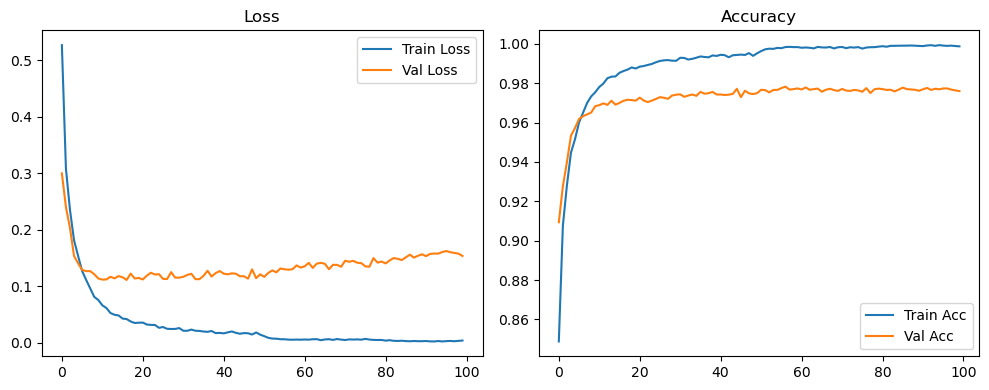

🚀 Running: batch256_lr0.005_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.8387, Acc: 0.7338 | Val Loss: 0.3580, Acc: 0.8943


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.4902, Acc: 0.8520 | Val Loss: 0.2999, Acc: 0.9125


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.4077, Acc: 0.8782 | Val Loss: 0.2648, Acc: 0.9218


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.3438, Acc: 0.8970 | Val Loss: 0.2176, Acc: 0.9345


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.3014, Acc: 0.9107 | Val Loss: 0.1917, Acc: 0.9427


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.2656, Acc: 0.9201 | Val Loss: 0.1781, Acc: 0.9478


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.2459, Acc: 0.9269 | Val Loss: 0.1626, Acc: 0.9525


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.2184, Acc: 0.9344 | Val Loss: 0.1523, Acc: 0.9563


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.2056, Acc: 0.9380 | Val Loss: 0.1441, Acc: 0.9572


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.1875, Acc: 0.9443 | Val Loss: 0.1348, Acc: 0.9597


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.1771, Acc: 0.9463 | Val Loss: 0.1371, Acc: 0.9597


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.1701, Acc: 0.9486 | Val Loss: 0.1261, Acc: 0.9645


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.1611, Acc: 0.9503 | Val Loss: 0.1273, Acc: 0.9620


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.1547, Acc: 0.9531 | Val Loss: 0.1233, Acc: 0.9639


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.1444, Acc: 0.9558 | Val Loss: 0.1177, Acc: 0.9676


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.1404, Acc: 0.9566 | Val Loss: 0.1150, Acc: 0.9668


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.1345, Acc: 0.9588 | Val Loss: 0.1137, Acc: 0.9672


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.1292, Acc: 0.9607 | Val Loss: 0.1173, Acc: 0.9667


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.1243, Acc: 0.9616 | Val Loss: 0.1139, Acc: 0.9694


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.1188, Acc: 0.9621 | Val Loss: 0.1085, Acc: 0.9698


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.1195, Acc: 0.9625 | Val Loss: 0.1079, Acc: 0.9711


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.1143, Acc: 0.9639 | Val Loss: 0.1043, Acc: 0.9705


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.1079, Acc: 0.9665 | Val Loss: 0.1045, Acc: 0.9708


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.1038, Acc: 0.9671 | Val Loss: 0.1119, Acc: 0.9692


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.1037, Acc: 0.9665 | Val Loss: 0.1111, Acc: 0.9709


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.1065, Acc: 0.9667 | Val Loss: 0.1057, Acc: 0.9714


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0977, Acc: 0.9686 | Val Loss: 0.1132, Acc: 0.9698


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0941, Acc: 0.9703 | Val Loss: 0.1076, Acc: 0.9709


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0958, Acc: 0.9705 | Val Loss: 0.1061, Acc: 0.9711


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0905, Acc: 0.9714 | Val Loss: 0.1052, Acc: 0.9721


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0897, Acc: 0.9719 | Val Loss: 0.1057, Acc: 0.9722


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0914, Acc: 0.9715 | Val Loss: 0.1032, Acc: 0.9723


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0875, Acc: 0.9711 | Val Loss: 0.1053, Acc: 0.9722


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0823, Acc: 0.9734 | Val Loss: 0.1062, Acc: 0.9728


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0816, Acc: 0.9729 | Val Loss: 0.1076, Acc: 0.9710


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0788, Acc: 0.9750 | Val Loss: 0.1039, Acc: 0.9721


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0768, Acc: 0.9756 | Val Loss: 0.1059, Acc: 0.9720


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0769, Acc: 0.9750 | Val Loss: 0.1042, Acc: 0.9728


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0774, Acc: 0.9752 | Val Loss: 0.1040, Acc: 0.9728


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0809, Acc: 0.9746 | Val Loss: 0.1022, Acc: 0.9737


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0760, Acc: 0.9760 | Val Loss: 0.1023, Acc: 0.9736


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0711, Acc: 0.9770 | Val Loss: 0.1007, Acc: 0.9748


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0720, Acc: 0.9771 | Val Loss: 0.1084, Acc: 0.9732


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0718, Acc: 0.9769 | Val Loss: 0.1001, Acc: 0.9739


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0719, Acc: 0.9768 | Val Loss: 0.1034, Acc: 0.9735


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0684, Acc: 0.9776 | Val Loss: 0.1031, Acc: 0.9741


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0692, Acc: 0.9780 | Val Loss: 0.1000, Acc: 0.9744


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0662, Acc: 0.9779 | Val Loss: 0.1061, Acc: 0.9741


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0670, Acc: 0.9789 | Val Loss: 0.1008, Acc: 0.9740


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0642, Acc: 0.9792 | Val Loss: 0.1037, Acc: 0.9741


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0542, Acc: 0.9824 | Val Loss: 0.1036, Acc: 0.9742


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0525, Acc: 0.9830 | Val Loss: 0.1044, Acc: 0.9749


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0496, Acc: 0.9848 | Val Loss: 0.1024, Acc: 0.9757


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0471, Acc: 0.9845 | Val Loss: 0.1009, Acc: 0.9752


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0471, Acc: 0.9852 | Val Loss: 0.1038, Acc: 0.9759


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0462, Acc: 0.9848 | Val Loss: 0.1013, Acc: 0.9753


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0464, Acc: 0.9848 | Val Loss: 0.1052, Acc: 0.9744


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0443, Acc: 0.9853 | Val Loss: 0.1053, Acc: 0.9753


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0439, Acc: 0.9854 | Val Loss: 0.1063, Acc: 0.9754


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0455, Acc: 0.9851 | Val Loss: 0.1022, Acc: 0.9754


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0445, Acc: 0.9856 | Val Loss: 0.1038, Acc: 0.9751


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0407, Acc: 0.9869 | Val Loss: 0.1078, Acc: 0.9747


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0418, Acc: 0.9864 | Val Loss: 0.1017, Acc: 0.9752


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0411, Acc: 0.9867 | Val Loss: 0.1051, Acc: 0.9748


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0408, Acc: 0.9870 | Val Loss: 0.1051, Acc: 0.9752


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0413, Acc: 0.9862 | Val Loss: 0.1036, Acc: 0.9756


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0403, Acc: 0.9869 | Val Loss: 0.1038, Acc: 0.9753


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0417, Acc: 0.9864 | Val Loss: 0.1032, Acc: 0.9755


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0383, Acc: 0.9875 | Val Loss: 0.1079, Acc: 0.9748


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0371, Acc: 0.9883 | Val Loss: 0.1076, Acc: 0.9751


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0375, Acc: 0.9879 | Val Loss: 0.1091, Acc: 0.9749


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0369, Acc: 0.9879 | Val Loss: 0.1103, Acc: 0.9742


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0378, Acc: 0.9877 | Val Loss: 0.1066, Acc: 0.9747


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0380, Acc: 0.9878 | Val Loss: 0.1072, Acc: 0.9742


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0359, Acc: 0.9885 | Val Loss: 0.1044, Acc: 0.9755


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0372, Acc: 0.9884 | Val Loss: 0.1068, Acc: 0.9744


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0354, Acc: 0.9885 | Val Loss: 0.1013, Acc: 0.9760


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0342, Acc: 0.9890 | Val Loss: 0.1077, Acc: 0.9754


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0356, Acc: 0.9885 | Val Loss: 0.1056, Acc: 0.9751


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0366, Acc: 0.9880 | Val Loss: 0.1076, Acc: 0.9752


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0336, Acc: 0.9887 | Val Loss: 0.1077, Acc: 0.9749


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0345, Acc: 0.9888 | Val Loss: 0.1105, Acc: 0.9748


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0323, Acc: 0.9892 | Val Loss: 0.1097, Acc: 0.9761


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0324, Acc: 0.9893 | Val Loss: 0.1074, Acc: 0.9761


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0312, Acc: 0.9897 | Val Loss: 0.1088, Acc: 0.9755


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0303, Acc: 0.9901 | Val Loss: 0.1088, Acc: 0.9748


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0319, Acc: 0.9889 | Val Loss: 0.1097, Acc: 0.9753


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0319, Acc: 0.9897 | Val Loss: 0.1082, Acc: 0.9758


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0293, Acc: 0.9906 | Val Loss: 0.1100, Acc: 0.9755


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0302, Acc: 0.9900 | Val Loss: 0.1089, Acc: 0.9752


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0279, Acc: 0.9910 | Val Loss: 0.1106, Acc: 0.9758


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0270, Acc: 0.9911 | Val Loss: 0.1124, Acc: 0.9755


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0287, Acc: 0.9906 | Val Loss: 0.1118, Acc: 0.9757


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0298, Acc: 0.9905 | Val Loss: 0.1121, Acc: 0.9758


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0293, Acc: 0.9909 | Val Loss: 0.1119, Acc: 0.9748


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0275, Acc: 0.9905 | Val Loss: 0.1126, Acc: 0.9760


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0298, Acc: 0.9898 | Val Loss: 0.1122, Acc: 0.9758


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0274, Acc: 0.9906 | Val Loss: 0.1115, Acc: 0.9750


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0300, Acc: 0.9903 | Val Loss: 0.1127, Acc: 0.9748


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0285, Acc: 0.9903 | Val Loss: 0.1103, Acc: 0.9757


Final Test Loss: 0.1104 Accuracy: 0.9757


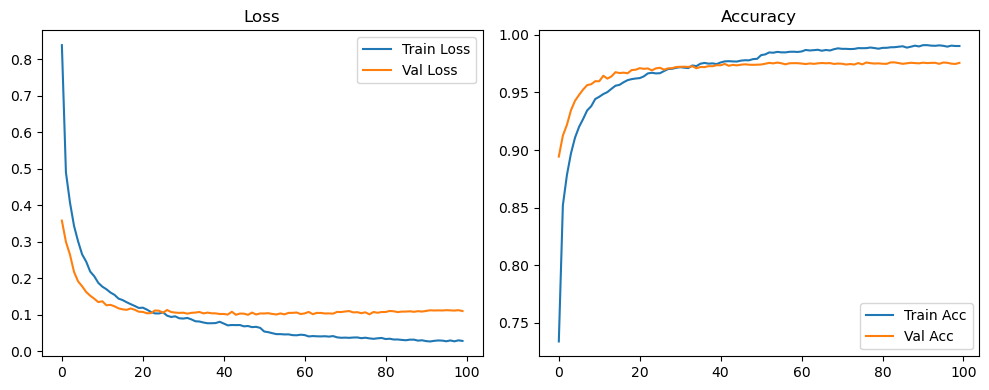

🚀 Running: batch256_lr0.002_0.002_0.002_dp0.0


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.4876, Acc: 0.8864 | Val Loss: 0.2995, Acc: 0.9103


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.2358, Acc: 0.9316 | Val Loss: 0.2073, Acc: 0.9369


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1297, Acc: 0.9600 | Val Loss: 0.1588, Acc: 0.9523


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0735, Acc: 0.9778 | Val Loss: 0.1134, Acc: 0.9636


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0451, Acc: 0.9868 | Val Loss: 0.1040, Acc: 0.9688


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0290, Acc: 0.9917 | Val Loss: 0.1093, Acc: 0.9675


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0170, Acc: 0.9955 | Val Loss: 0.1026, Acc: 0.9696


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0164, Acc: 0.9952 | Val Loss: 0.1274, Acc: 0.9621


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0133, Acc: 0.9962 | Val Loss: 0.1002, Acc: 0.9721


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9970 | Val Loss: 0.1134, Acc: 0.9696


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9975 | Val Loss: 0.1134, Acc: 0.9707


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0147, Acc: 0.9952 | Val Loss: 0.1168, Acc: 0.9697


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0125, Acc: 0.9960 | Val Loss: 0.1206, Acc: 0.9683


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9976 | Val Loss: 0.1145, Acc: 0.9718


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.1242, Acc: 0.9703


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.1069, Acc: 0.9742


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9995 | Val Loss: 0.1017, Acc: 0.9753


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1060, Acc: 0.9752


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.0970, Acc: 0.9771


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.1568, Acc: 0.9637


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0205, Acc: 0.9933 | Val Loss: 0.1515, Acc: 0.9640


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0164, Acc: 0.9943 | Val Loss: 0.1191, Acc: 0.9708


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.1162, Acc: 0.9720


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9994 | Val Loss: 0.1147, Acc: 0.9736


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9994 | Val Loss: 0.1104, Acc: 0.9755


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1366, Acc: 0.9705


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9976 | Val Loss: 0.1387, Acc: 0.9710


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.1308, Acc: 0.9712


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1406, Acc: 0.9720


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1299, Acc: 0.9731


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.1395, Acc: 0.9705


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.1470, Acc: 0.9705


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.1304, Acc: 0.9735


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1285, Acc: 0.9749


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9997 | Val Loss: 0.1222, Acc: 0.9771


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.1288, Acc: 0.9746


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1563, Acc: 0.9710


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.1516, Acc: 0.9720


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1346, Acc: 0.9737


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.1322, Acc: 0.9739


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1325, Acc: 0.9743


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1429, Acc: 0.9732


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.1368, Acc: 0.9746


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1385, Acc: 0.9742


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9974 | Val Loss: 0.1431, Acc: 0.9730


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1564, Acc: 0.9722


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.1492, Acc: 0.9733


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1595, Acc: 0.9738


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1373, Acc: 0.9755


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1420, Acc: 0.9751


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1455, Acc: 0.9745


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9991 | Val Loss: 0.1409, Acc: 0.9744


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1872, Acc: 0.9700


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.1438, Acc: 0.9738


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.1398, Acc: 0.9738


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.1485, Acc: 0.9722


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1362, Acc: 0.9740


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1343, Acc: 0.9760


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1359, Acc: 0.9767


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1351, Acc: 0.9760


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1421, Acc: 0.9748


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1772, Acc: 0.9702


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.1623, Acc: 0.9732


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1712, Acc: 0.9712


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9980 | Val Loss: 0.1644, Acc: 0.9738


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9984 | Val Loss: 0.1558, Acc: 0.9738


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1584, Acc: 0.9742


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1463, Acc: 0.9770


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1446, Acc: 0.9772


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.1393, Acc: 0.9776


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1488, Acc: 0.9771


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9991 | Val Loss: 0.1732, Acc: 0.9716


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.1572, Acc: 0.9729


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.1464, Acc: 0.9727


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1406, Acc: 0.9768


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1374, Acc: 0.9772


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1335, Acc: 0.9780


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1431, Acc: 0.9763


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1377, Acc: 0.9769


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1422, Acc: 0.9772


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1459, Acc: 0.9757


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1426, Acc: 0.9775


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.1513, Acc: 0.9750


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1489, Acc: 0.9749


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1470, Acc: 0.9759


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1505, Acc: 0.9756


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1500, Acc: 0.9738


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1585, Acc: 0.9748


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1577, Acc: 0.9744


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1643, Acc: 0.9720


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1540, Acc: 0.9761


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1485, Acc: 0.9758


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1474, Acc: 0.9758


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1493, Acc: 0.9771


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1530, Acc: 0.9759


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1562, Acc: 0.9758


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9993 | Val Loss: 0.1423, Acc: 0.9760


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1503, Acc: 0.9756


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1516, Acc: 0.9762


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1522, Acc: 0.9766


Final Test Loss: 0.1460 Accuracy: 0.9768


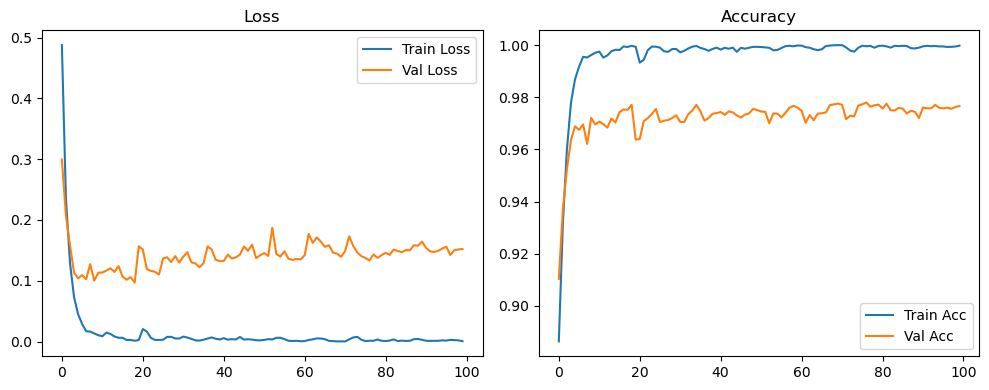

🚀 Running: batch256_lr0.002_0.002_0.002_dp0.2


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.6494, Acc: 0.8350 | Val Loss: 0.3313, Acc: 0.9022


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.3593, Acc: 0.8925 | Val Loss: 0.2828, Acc: 0.9153


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.3014, Acc: 0.9091 | Val Loss: 0.2435, Acc: 0.9264


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.2434, Acc: 0.9258 | Val Loss: 0.1949, Acc: 0.9400


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.2105, Acc: 0.9355 | Val Loss: 0.1763, Acc: 0.9460


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.1812, Acc: 0.9433 | Val Loss: 0.1642, Acc: 0.9508


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.1592, Acc: 0.9502 | Val Loss: 0.1499, Acc: 0.9559


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.1403, Acc: 0.9561 | Val Loss: 0.1489, Acc: 0.9549


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.1220, Acc: 0.9610 | Val Loss: 0.1368, Acc: 0.9591


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.1119, Acc: 0.9636 | Val Loss: 0.1285, Acc: 0.9620


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.1006, Acc: 0.9683 | Val Loss: 0.1259, Acc: 0.9627


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0920, Acc: 0.9702 | Val Loss: 0.1201, Acc: 0.9667


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0813, Acc: 0.9739 | Val Loss: 0.1227, Acc: 0.9664


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0762, Acc: 0.9746 | Val Loss: 0.1205, Acc: 0.9671


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0689, Acc: 0.9776 | Val Loss: 0.1187, Acc: 0.9667


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0638, Acc: 0.9786 | Val Loss: 0.1173, Acc: 0.9677


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0599, Acc: 0.9798 | Val Loss: 0.1148, Acc: 0.9684


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0544, Acc: 0.9815 | Val Loss: 0.1184, Acc: 0.9678


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0501, Acc: 0.9833 | Val Loss: 0.1165, Acc: 0.9686


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0509, Acc: 0.9830 | Val Loss: 0.1195, Acc: 0.9690


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0471, Acc: 0.9845 | Val Loss: 0.1192, Acc: 0.9702


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0456, Acc: 0.9844 | Val Loss: 0.1284, Acc: 0.9674


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0401, Acc: 0.9867 | Val Loss: 0.1236, Acc: 0.9692


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0390, Acc: 0.9863 | Val Loss: 0.1225, Acc: 0.9688


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0359, Acc: 0.9877 | Val Loss: 0.1259, Acc: 0.9704


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0370, Acc: 0.9878 | Val Loss: 0.1174, Acc: 0.9712


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0322, Acc: 0.9891 | Val Loss: 0.1199, Acc: 0.9703


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0313, Acc: 0.9894 | Val Loss: 0.1245, Acc: 0.9708


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0303, Acc: 0.9894 | Val Loss: 0.1258, Acc: 0.9702


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0318, Acc: 0.9894 | Val Loss: 0.1225, Acc: 0.9710


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0268, Acc: 0.9907 | Val Loss: 0.1230, Acc: 0.9719


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0278, Acc: 0.9905 | Val Loss: 0.1257, Acc: 0.9711


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0299, Acc: 0.9898 | Val Loss: 0.1274, Acc: 0.9707


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0253, Acc: 0.9911 | Val Loss: 0.1255, Acc: 0.9721


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0248, Acc: 0.9919 | Val Loss: 0.1243, Acc: 0.9722


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0261, Acc: 0.9910 | Val Loss: 0.1264, Acc: 0.9708


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0253, Acc: 0.9915 | Val Loss: 0.1335, Acc: 0.9696


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0228, Acc: 0.9921 | Val Loss: 0.1301, Acc: 0.9708


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0221, Acc: 0.9923 | Val Loss: 0.1340, Acc: 0.9712


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0210, Acc: 0.9930 | Val Loss: 0.1301, Acc: 0.9720


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0205, Acc: 0.9926 | Val Loss: 0.1296, Acc: 0.9706


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0232, Acc: 0.9922 | Val Loss: 0.1364, Acc: 0.9715


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0223, Acc: 0.9928 | Val Loss: 0.1351, Acc: 0.9702


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0207, Acc: 0.9926 | Val Loss: 0.1311, Acc: 0.9722


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0192, Acc: 0.9931 | Val Loss: 0.1331, Acc: 0.9721


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0174, Acc: 0.9942 | Val Loss: 0.1305, Acc: 0.9724


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0177, Acc: 0.9938 | Val Loss: 0.1373, Acc: 0.9712


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0184, Acc: 0.9935 | Val Loss: 0.1494, Acc: 0.9708


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0194, Acc: 0.9935 | Val Loss: 0.1387, Acc: 0.9722


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0158, Acc: 0.9943 | Val Loss: 0.1367, Acc: 0.9734


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0172, Acc: 0.9944 | Val Loss: 0.1337, Acc: 0.9729


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0186, Acc: 0.9939 | Val Loss: 0.1357, Acc: 0.9718


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0168, Acc: 0.9939 | Val Loss: 0.1322, Acc: 0.9726


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0176, Acc: 0.9941 | Val Loss: 0.1380, Acc: 0.9716


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0179, Acc: 0.9941 | Val Loss: 0.1358, Acc: 0.9720


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0151, Acc: 0.9950 | Val Loss: 0.1370, Acc: 0.9734


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0134, Acc: 0.9953 | Val Loss: 0.1379, Acc: 0.9725


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0143, Acc: 0.9952 | Val Loss: 0.1351, Acc: 0.9729


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0149, Acc: 0.9948 | Val Loss: 0.1471, Acc: 0.9717


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0138, Acc: 0.9953 | Val Loss: 0.1429, Acc: 0.9715


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0150, Acc: 0.9951 | Val Loss: 0.1369, Acc: 0.9730


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0128, Acc: 0.9957 | Val Loss: 0.1454, Acc: 0.9720


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0143, Acc: 0.9951 | Val Loss: 0.1465, Acc: 0.9713


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0152, Acc: 0.9946 | Val Loss: 0.1475, Acc: 0.9731


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0133, Acc: 0.9952 | Val Loss: 0.1464, Acc: 0.9715


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0173, Acc: 0.9938 | Val Loss: 0.1402, Acc: 0.9731


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0134, Acc: 0.9957 | Val Loss: 0.1410, Acc: 0.9733


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0135, Acc: 0.9955 | Val Loss: 0.1458, Acc: 0.9725


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0121, Acc: 0.9956 | Val Loss: 0.1445, Acc: 0.9726


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0139, Acc: 0.9951 | Val Loss: 0.1502, Acc: 0.9711


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0127, Acc: 0.9958 | Val Loss: 0.1447, Acc: 0.9734


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0141, Acc: 0.9951 | Val Loss: 0.1441, Acc: 0.9724


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0131, Acc: 0.9954 | Val Loss: 0.1346, Acc: 0.9730


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0142, Acc: 0.9953 | Val Loss: 0.1575, Acc: 0.9709


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0123, Acc: 0.9957 | Val Loss: 0.1388, Acc: 0.9739


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0132, Acc: 0.9958 | Val Loss: 0.1405, Acc: 0.9737


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9965 | Val Loss: 0.1454, Acc: 0.9739


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0114, Acc: 0.9961 | Val Loss: 0.1436, Acc: 0.9733


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0126, Acc: 0.9958 | Val Loss: 0.1493, Acc: 0.9742


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9965 | Val Loss: 0.1429, Acc: 0.9728


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9961 | Val Loss: 0.1426, Acc: 0.9741


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9962 | Val Loss: 0.1414, Acc: 0.9742


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0127, Acc: 0.9960 | Val Loss: 0.1504, Acc: 0.9726


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0122, Acc: 0.9960 | Val Loss: 0.1387, Acc: 0.9732


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9962 | Val Loss: 0.1416, Acc: 0.9734


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0107, Acc: 0.9963 | Val Loss: 0.1426, Acc: 0.9741


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9966 | Val Loss: 0.1481, Acc: 0.9726


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9966 | Val Loss: 0.1426, Acc: 0.9744


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9956 | Val Loss: 0.1411, Acc: 0.9743


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9963 | Val Loss: 0.1501, Acc: 0.9732


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9966 | Val Loss: 0.1428, Acc: 0.9760


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.1466, Acc: 0.9755


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0105, Acc: 0.9967 | Val Loss: 0.1404, Acc: 0.9743


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9961 | Val Loss: 0.1473, Acc: 0.9748


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.1538, Acc: 0.9722


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9969 | Val Loss: 0.1613, Acc: 0.9738


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9966 | Val Loss: 0.1466, Acc: 0.9732


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0115, Acc: 0.9962 | Val Loss: 0.1541, Acc: 0.9738


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9968 | Val Loss: 0.1551, Acc: 0.9734


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0122, Acc: 0.9958 | Val Loss: 0.1512, Acc: 0.9727


Final Test Loss: 0.1399 Accuracy: 0.9767


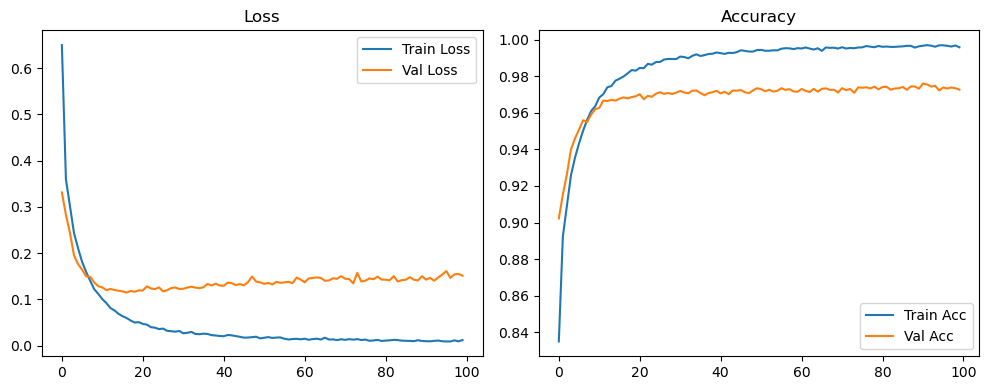

🚀 Running: batch256_lr0.002_0.002_0.002_dp0.5


Epoch 1/100 - LR: 0.00200 | Train Loss: 1.0526, Acc: 0.6729 | Val Loss: 0.4177, Acc: 0.8848


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.5906, Acc: 0.8190 | Val Loss: 0.3444, Acc: 0.8996


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.5019, Acc: 0.8491 | Val Loss: 0.3120, Acc: 0.9086


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.4418, Acc: 0.8672 | Val Loss: 0.2868, Acc: 0.9162


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.3975, Acc: 0.8817 | Val Loss: 0.2611, Acc: 0.9222


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.3622, Acc: 0.8925 | Val Loss: 0.2447, Acc: 0.9291


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.3398, Acc: 0.9004 | Val Loss: 0.2334, Acc: 0.9300


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.3095, Acc: 0.9085 | Val Loss: 0.2189, Acc: 0.9361


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.2929, Acc: 0.9127 | Val Loss: 0.2100, Acc: 0.9367


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.2717, Acc: 0.9199 | Val Loss: 0.1910, Acc: 0.9428


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.2565, Acc: 0.9234 | Val Loss: 0.1886, Acc: 0.9447


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.2451, Acc: 0.9265 | Val Loss: 0.1764, Acc: 0.9478


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.2328, Acc: 0.9300 | Val Loss: 0.1735, Acc: 0.9495


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.2199, Acc: 0.9331 | Val Loss: 0.1646, Acc: 0.9517


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.2087, Acc: 0.9371 | Val Loss: 0.1584, Acc: 0.9537


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.2044, Acc: 0.9381 | Val Loss: 0.1546, Acc: 0.9552


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.1938, Acc: 0.9419 | Val Loss: 0.1528, Acc: 0.9556


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.1833, Acc: 0.9447 | Val Loss: 0.1465, Acc: 0.9590


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.1755, Acc: 0.9467 | Val Loss: 0.1466, Acc: 0.9583


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.1697, Acc: 0.9476 | Val Loss: 0.1384, Acc: 0.9610


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.1645, Acc: 0.9498 | Val Loss: 0.1356, Acc: 0.9620


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.1606, Acc: 0.9512 | Val Loss: 0.1367, Acc: 0.9621


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.1559, Acc: 0.9515 | Val Loss: 0.1302, Acc: 0.9633


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.1470, Acc: 0.9553 | Val Loss: 0.1332, Acc: 0.9633


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.1429, Acc: 0.9549 | Val Loss: 0.1310, Acc: 0.9647


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.1429, Acc: 0.9565 | Val Loss: 0.1274, Acc: 0.9654


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.1407, Acc: 0.9569 | Val Loss: 0.1343, Acc: 0.9632


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.1278, Acc: 0.9598 | Val Loss: 0.1281, Acc: 0.9642


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.1301, Acc: 0.9588 | Val Loss: 0.1257, Acc: 0.9640


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.1260, Acc: 0.9610 | Val Loss: 0.1253, Acc: 0.9663


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.1261, Acc: 0.9610 | Val Loss: 0.1224, Acc: 0.9673


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.1227, Acc: 0.9617 | Val Loss: 0.1278, Acc: 0.9657


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.1187, Acc: 0.9636 | Val Loss: 0.1243, Acc: 0.9661


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.1149, Acc: 0.9640 | Val Loss: 0.1243, Acc: 0.9660


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.1115, Acc: 0.9643 | Val Loss: 0.1214, Acc: 0.9681


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.1063, Acc: 0.9672 | Val Loss: 0.1179, Acc: 0.9697


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.1104, Acc: 0.9653 | Val Loss: 0.1230, Acc: 0.9677


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.1052, Acc: 0.9673 | Val Loss: 0.1211, Acc: 0.9686


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.1020, Acc: 0.9675 | Val Loss: 0.1249, Acc: 0.9685


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.1053, Acc: 0.9673 | Val Loss: 0.1199, Acc: 0.9689


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.1031, Acc: 0.9682 | Val Loss: 0.1241, Acc: 0.9677


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0989, Acc: 0.9688 | Val Loss: 0.1211, Acc: 0.9688


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0973, Acc: 0.9697 | Val Loss: 0.1198, Acc: 0.9702


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0948, Acc: 0.9701 | Val Loss: 0.1193, Acc: 0.9702


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0948, Acc: 0.9698 | Val Loss: 0.1180, Acc: 0.9698


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0917, Acc: 0.9711 | Val Loss: 0.1179, Acc: 0.9692


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0924, Acc: 0.9703 | Val Loss: 0.1200, Acc: 0.9703


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0892, Acc: 0.9715 | Val Loss: 0.1238, Acc: 0.9705


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0897, Acc: 0.9716 | Val Loss: 0.1208, Acc: 0.9703


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0849, Acc: 0.9732 | Val Loss: 0.1171, Acc: 0.9715


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0811, Acc: 0.9747 | Val Loss: 0.1207, Acc: 0.9713


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0861, Acc: 0.9724 | Val Loss: 0.1217, Acc: 0.9702


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0820, Acc: 0.9734 | Val Loss: 0.1188, Acc: 0.9712


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0790, Acc: 0.9747 | Val Loss: 0.1181, Acc: 0.9713


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0826, Acc: 0.9744 | Val Loss: 0.1188, Acc: 0.9726


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0795, Acc: 0.9742 | Val Loss: 0.1173, Acc: 0.9714


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0820, Acc: 0.9736 | Val Loss: 0.1210, Acc: 0.9704


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0770, Acc: 0.9752 | Val Loss: 0.1216, Acc: 0.9706


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0756, Acc: 0.9759 | Val Loss: 0.1199, Acc: 0.9717


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0796, Acc: 0.9747 | Val Loss: 0.1161, Acc: 0.9715


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0755, Acc: 0.9761 | Val Loss: 0.1204, Acc: 0.9698


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0715, Acc: 0.9769 | Val Loss: 0.1257, Acc: 0.9692


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0773, Acc: 0.9758 | Val Loss: 0.1153, Acc: 0.9717


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0725, Acc: 0.9772 | Val Loss: 0.1187, Acc: 0.9711


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0678, Acc: 0.9779 | Val Loss: 0.1219, Acc: 0.9700


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0735, Acc: 0.9769 | Val Loss: 0.1194, Acc: 0.9704


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0694, Acc: 0.9774 | Val Loss: 0.1200, Acc: 0.9708


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0711, Acc: 0.9771 | Val Loss: 0.1195, Acc: 0.9722


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0650, Acc: 0.9785 | Val Loss: 0.1180, Acc: 0.9733


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0666, Acc: 0.9791 | Val Loss: 0.1193, Acc: 0.9720


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0671, Acc: 0.9779 | Val Loss: 0.1199, Acc: 0.9722


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0646, Acc: 0.9786 | Val Loss: 0.1218, Acc: 0.9709


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0680, Acc: 0.9780 | Val Loss: 0.1149, Acc: 0.9727


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0670, Acc: 0.9788 | Val Loss: 0.1148, Acc: 0.9726


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0607, Acc: 0.9804 | Val Loss: 0.1190, Acc: 0.9713


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0644, Acc: 0.9801 | Val Loss: 0.1156, Acc: 0.9714


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0631, Acc: 0.9804 | Val Loss: 0.1108, Acc: 0.9734


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0601, Acc: 0.9802 | Val Loss: 0.1206, Acc: 0.9715


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0622, Acc: 0.9798 | Val Loss: 0.1167, Acc: 0.9713


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0618, Acc: 0.9804 | Val Loss: 0.1141, Acc: 0.9722


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0642, Acc: 0.9793 | Val Loss: 0.1159, Acc: 0.9726


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0603, Acc: 0.9800 | Val Loss: 0.1198, Acc: 0.9730


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0599, Acc: 0.9811 | Val Loss: 0.1170, Acc: 0.9726


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0615, Acc: 0.9800 | Val Loss: 0.1145, Acc: 0.9741


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0608, Acc: 0.9809 | Val Loss: 0.1176, Acc: 0.9719


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0577, Acc: 0.9820 | Val Loss: 0.1189, Acc: 0.9716


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0608, Acc: 0.9807 | Val Loss: 0.1173, Acc: 0.9718


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0592, Acc: 0.9809 | Val Loss: 0.1166, Acc: 0.9722


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0593, Acc: 0.9812 | Val Loss: 0.1201, Acc: 0.9712


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0572, Acc: 0.9815 | Val Loss: 0.1173, Acc: 0.9716


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0536, Acc: 0.9834 | Val Loss: 0.1193, Acc: 0.9729


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0552, Acc: 0.9819 | Val Loss: 0.1267, Acc: 0.9718


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0545, Acc: 0.9826 | Val Loss: 0.1214, Acc: 0.9726


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0564, Acc: 0.9814 | Val Loss: 0.1206, Acc: 0.9717


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0543, Acc: 0.9822 | Val Loss: 0.1251, Acc: 0.9718


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0521, Acc: 0.9835 | Val Loss: 0.1265, Acc: 0.9732


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0543, Acc: 0.9831 | Val Loss: 0.1229, Acc: 0.9718


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0519, Acc: 0.9834 | Val Loss: 0.1253, Acc: 0.9722


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0546, Acc: 0.9824 | Val Loss: 0.1200, Acc: 0.9729


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0530, Acc: 0.9825 | Val Loss: 0.1213, Acc: 0.9718


Final Test Loss: 0.1066 Accuracy: 0.9757


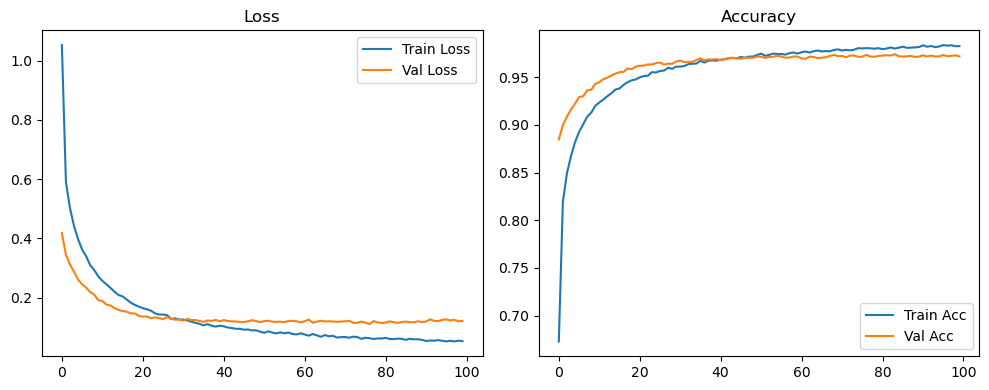

🚀 Running: batch256_lr0.001_0.001_0.001_dp0.0


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.6119, Acc: 0.8774 | Val Loss: 0.3478, Acc: 0.9069


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.2740, Acc: 0.9265 | Val Loss: 0.2338, Acc: 0.9320


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.1522, Acc: 0.9567 | Val Loss: 0.1614, Acc: 0.9521


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0828, Acc: 0.9761 | Val Loss: 0.1148, Acc: 0.9632


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0497, Acc: 0.9862 | Val Loss: 0.1009, Acc: 0.9674


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0303, Acc: 0.9923 | Val Loss: 0.1004, Acc: 0.9693


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0187, Acc: 0.9957 | Val Loss: 0.0906, Acc: 0.9709


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0140, Acc: 0.9967 | Val Loss: 0.1016, Acc: 0.9684


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0094, Acc: 0.9981 | Val Loss: 0.0922, Acc: 0.9737


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9992 | Val Loss: 0.0818, Acc: 0.9762


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9991 | Val Loss: 0.0844, Acc: 0.9746


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9979 | Val Loss: 0.0884, Acc: 0.9760


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9981 | Val Loss: 0.1017, Acc: 0.9721


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0126, Acc: 0.9961 | Val Loss: 0.1112, Acc: 0.9692


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9979 | Val Loss: 0.0876, Acc: 0.9742


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9983 | Val Loss: 0.0986, Acc: 0.9732


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9988 | Val Loss: 0.0975, Acc: 0.9735


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9994 | Val Loss: 0.1036, Acc: 0.9726


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9994 | Val Loss: 0.0881, Acc: 0.9760


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9995 | Val Loss: 0.0943, Acc: 0.9762


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9972 | Val Loss: 0.1701, Acc: 0.9583


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0153, Acc: 0.9950 | Val Loss: 0.1053, Acc: 0.9733


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9984 | Val Loss: 0.0947, Acc: 0.9750


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9991 | Val Loss: 0.1093, Acc: 0.9731


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0995, Acc: 0.9758


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9998 | Val Loss: 0.0889, Acc: 0.9768


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0926, Acc: 0.9773


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 1.0000 | Val Loss: 0.0881, Acc: 0.9784


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0889, Acc: 0.9787


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0911, Acc: 0.9783


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0890, Acc: 0.9794


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0890, Acc: 0.9789


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0918, Acc: 0.9791


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0898, Acc: 0.9797


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0887, Acc: 0.9798


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0894, Acc: 0.9794


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0905, Acc: 0.9798


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0218, Acc: 0.9940 | Val Loss: 0.2473, Acc: 0.9393


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0361, Acc: 0.9879 | Val Loss: 0.1080, Acc: 0.9732


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9973 | Val Loss: 0.0962, Acc: 0.9751


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9994 | Val Loss: 0.0910, Acc: 0.9776


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.0878, Acc: 0.9795


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0876, Acc: 0.9796


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0885, Acc: 0.9794


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0895, Acc: 0.9794


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.0964, Acc: 0.9775


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1054, Acc: 0.9761


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1140, Acc: 0.9752


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9976 | Val Loss: 0.1218, Acc: 0.9721


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.1600, Acc: 0.9640


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1087, Acc: 0.9757


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1080, Acc: 0.9758


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.1032, Acc: 0.9775


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0998, Acc: 0.9775


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0979, Acc: 0.9788


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1073, Acc: 0.9778


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9997 | Val Loss: 0.1162, Acc: 0.9768


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1253, Acc: 0.9740


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.1204, Acc: 0.9752


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1258, Acc: 0.9732


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1082, Acc: 0.9774


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1183, Acc: 0.9753


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1221, Acc: 0.9742


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.1103, Acc: 0.9778


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1217, Acc: 0.9771


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1163, Acc: 0.9765


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.1060, Acc: 0.9799


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1159, Acc: 0.9776


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1360, Acc: 0.9734


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1342, Acc: 0.9737


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.1570, Acc: 0.9716


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9982 | Val Loss: 0.1287, Acc: 0.9743


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1151, Acc: 0.9772


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1148, Acc: 0.9782


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1112, Acc: 0.9780


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1105, Acc: 0.9786


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1118, Acc: 0.9786


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1137, Acc: 0.9785


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1112, Acc: 0.9784


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1096, Acc: 0.9788


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1107, Acc: 0.9789


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1112, Acc: 0.9798


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1117, Acc: 0.9793


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1112, Acc: 0.9792


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1118, Acc: 0.9791


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1118, Acc: 0.9792


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1129, Acc: 0.9792


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1132, Acc: 0.9792


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1144, Acc: 0.9797


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1131, Acc: 0.9788


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1136, Acc: 0.9795


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1140, Acc: 0.9792


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.4265, Acc: 0.9266


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0247, Acc: 0.9923 | Val Loss: 0.1600, Acc: 0.9708


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1304, Acc: 0.9743


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1274, Acc: 0.9738


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1183, Acc: 0.9767


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1204, Acc: 0.9758


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1263, Acc: 0.9750


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1212, Acc: 0.9761


Final Test Loss: 0.1099 Accuracy: 0.9791


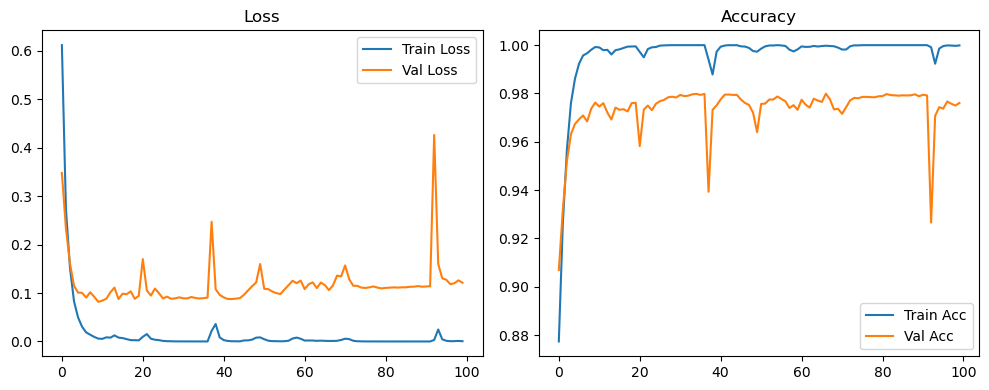

🚀 Running: batch256_lr0.001_0.001_0.001_dp0.2


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.8212, Acc: 0.8136 | Val Loss: 0.3917, Acc: 0.8966


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.4137, Acc: 0.8844 | Val Loss: 0.3117, Acc: 0.9094


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.3324, Acc: 0.9020 | Val Loss: 0.2527, Acc: 0.9243


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.2680, Acc: 0.9196 | Val Loss: 0.2015, Acc: 0.9392


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.2337, Acc: 0.9288 | Val Loss: 0.1770, Acc: 0.9457


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.2061, Acc: 0.9366 | Val Loss: 0.1651, Acc: 0.9493


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.1847, Acc: 0.9433 | Val Loss: 0.1575, Acc: 0.9510


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.1680, Acc: 0.9475 | Val Loss: 0.1479, Acc: 0.9547


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.1542, Acc: 0.9504 | Val Loss: 0.1445, Acc: 0.9552


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.1419, Acc: 0.9548 | Val Loss: 0.1336, Acc: 0.9595


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.1295, Acc: 0.9596 | Val Loss: 0.1378, Acc: 0.9587


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.1248, Acc: 0.9598 | Val Loss: 0.1310, Acc: 0.9606


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.1139, Acc: 0.9639 | Val Loss: 0.1310, Acc: 0.9618


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.1083, Acc: 0.9653 | Val Loss: 0.1293, Acc: 0.9617


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.1003, Acc: 0.9680 | Val Loss: 0.1239, Acc: 0.9637


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0923, Acc: 0.9697 | Val Loss: 0.1247, Acc: 0.9647


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0905, Acc: 0.9706 | Val Loss: 0.1261, Acc: 0.9626


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0857, Acc: 0.9724 | Val Loss: 0.1239, Acc: 0.9644


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0808, Acc: 0.9735 | Val Loss: 0.1223, Acc: 0.9650


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0769, Acc: 0.9746 | Val Loss: 0.1223, Acc: 0.9639


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0768, Acc: 0.9748 | Val Loss: 0.1207, Acc: 0.9655


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0725, Acc: 0.9762 | Val Loss: 0.1215, Acc: 0.9658


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0651, Acc: 0.9781 | Val Loss: 0.1239, Acc: 0.9666


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0641, Acc: 0.9785 | Val Loss: 0.1191, Acc: 0.9685


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0615, Acc: 0.9797 | Val Loss: 0.1223, Acc: 0.9678


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0619, Acc: 0.9795 | Val Loss: 0.1186, Acc: 0.9683


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0564, Acc: 0.9821 | Val Loss: 0.1238, Acc: 0.9673


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0540, Acc: 0.9811 | Val Loss: 0.1259, Acc: 0.9680


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0499, Acc: 0.9838 | Val Loss: 0.1209, Acc: 0.9685


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0497, Acc: 0.9829 | Val Loss: 0.1223, Acc: 0.9689


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0467, Acc: 0.9842 | Val Loss: 0.1239, Acc: 0.9681


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0492, Acc: 0.9833 | Val Loss: 0.1242, Acc: 0.9681


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0487, Acc: 0.9841 | Val Loss: 0.1229, Acc: 0.9679


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0442, Acc: 0.9850 | Val Loss: 0.1292, Acc: 0.9681


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0454, Acc: 0.9846 | Val Loss: 0.1235, Acc: 0.9696


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0443, Acc: 0.9849 | Val Loss: 0.1249, Acc: 0.9678


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0405, Acc: 0.9859 | Val Loss: 0.1265, Acc: 0.9688


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0389, Acc: 0.9859 | Val Loss: 0.1312, Acc: 0.9673


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0393, Acc: 0.9870 | Val Loss: 0.1301, Acc: 0.9688


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0387, Acc: 0.9872 | Val Loss: 0.1328, Acc: 0.9671


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0355, Acc: 0.9878 | Val Loss: 0.1334, Acc: 0.9690


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0368, Acc: 0.9871 | Val Loss: 0.1274, Acc: 0.9694


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0346, Acc: 0.9882 | Val Loss: 0.1339, Acc: 0.9694


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0332, Acc: 0.9885 | Val Loss: 0.1309, Acc: 0.9694


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0331, Acc: 0.9884 | Val Loss: 0.1293, Acc: 0.9685


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0348, Acc: 0.9880 | Val Loss: 0.1315, Acc: 0.9683


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0318, Acc: 0.9895 | Val Loss: 0.1282, Acc: 0.9683


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0307, Acc: 0.9894 | Val Loss: 0.1281, Acc: 0.9692


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0311, Acc: 0.9891 | Val Loss: 0.1293, Acc: 0.9700


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0317, Acc: 0.9892 | Val Loss: 0.1321, Acc: 0.9705


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0289, Acc: 0.9895 | Val Loss: 0.1348, Acc: 0.9706


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0284, Acc: 0.9900 | Val Loss: 0.1285, Acc: 0.9702


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0262, Acc: 0.9911 | Val Loss: 0.1329, Acc: 0.9702


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0262, Acc: 0.9909 | Val Loss: 0.1333, Acc: 0.9688


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0273, Acc: 0.9909 | Val Loss: 0.1300, Acc: 0.9709


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0257, Acc: 0.9913 | Val Loss: 0.1309, Acc: 0.9698


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0259, Acc: 0.9907 | Val Loss: 0.1272, Acc: 0.9704


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0222, Acc: 0.9926 | Val Loss: 0.1272, Acc: 0.9709


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0250, Acc: 0.9913 | Val Loss: 0.1316, Acc: 0.9702


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0249, Acc: 0.9913 | Val Loss: 0.1346, Acc: 0.9700


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0242, Acc: 0.9917 | Val Loss: 0.1348, Acc: 0.9706


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0241, Acc: 0.9919 | Val Loss: 0.1381, Acc: 0.9694


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0250, Acc: 0.9915 | Val Loss: 0.1339, Acc: 0.9700


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0238, Acc: 0.9920 | Val Loss: 0.1355, Acc: 0.9698


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0227, Acc: 0.9924 | Val Loss: 0.1390, Acc: 0.9698


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0210, Acc: 0.9930 | Val Loss: 0.1418, Acc: 0.9712


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0221, Acc: 0.9925 | Val Loss: 0.1385, Acc: 0.9702


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0224, Acc: 0.9921 | Val Loss: 0.1397, Acc: 0.9701


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0219, Acc: 0.9925 | Val Loss: 0.1389, Acc: 0.9721


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0209, Acc: 0.9930 | Val Loss: 0.1451, Acc: 0.9688


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0198, Acc: 0.9933 | Val Loss: 0.1402, Acc: 0.9704


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0203, Acc: 0.9930 | Val Loss: 0.1397, Acc: 0.9706


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0202, Acc: 0.9928 | Val Loss: 0.1382, Acc: 0.9708


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0191, Acc: 0.9934 | Val Loss: 0.1482, Acc: 0.9696


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0205, Acc: 0.9925 | Val Loss: 0.1463, Acc: 0.9705


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0227, Acc: 0.9926 | Val Loss: 0.1394, Acc: 0.9704


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0175, Acc: 0.9938 | Val Loss: 0.1446, Acc: 0.9704


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0178, Acc: 0.9940 | Val Loss: 0.1473, Acc: 0.9715


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0197, Acc: 0.9934 | Val Loss: 0.1448, Acc: 0.9701


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0172, Acc: 0.9939 | Val Loss: 0.1446, Acc: 0.9706


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0174, Acc: 0.9944 | Val Loss: 0.1391, Acc: 0.9713


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0170, Acc: 0.9943 | Val Loss: 0.1439, Acc: 0.9708


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0184, Acc: 0.9934 | Val Loss: 0.1484, Acc: 0.9698


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0165, Acc: 0.9945 | Val Loss: 0.1495, Acc: 0.9702


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0177, Acc: 0.9938 | Val Loss: 0.1472, Acc: 0.9693


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0162, Acc: 0.9943 | Val Loss: 0.1481, Acc: 0.9706


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0173, Acc: 0.9940 | Val Loss: 0.1407, Acc: 0.9722


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0163, Acc: 0.9944 | Val Loss: 0.1402, Acc: 0.9717


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0158, Acc: 0.9949 | Val Loss: 0.1450, Acc: 0.9708


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0166, Acc: 0.9947 | Val Loss: 0.1459, Acc: 0.9689


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0161, Acc: 0.9949 | Val Loss: 0.1445, Acc: 0.9708


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0150, Acc: 0.9953 | Val Loss: 0.1527, Acc: 0.9705


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0160, Acc: 0.9949 | Val Loss: 0.1451, Acc: 0.9715


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0183, Acc: 0.9939 | Val Loss: 0.1455, Acc: 0.9714


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0158, Acc: 0.9945 | Val Loss: 0.1434, Acc: 0.9716


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0155, Acc: 0.9945 | Val Loss: 0.1435, Acc: 0.9703


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0142, Acc: 0.9952 | Val Loss: 0.1469, Acc: 0.9712


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0142, Acc: 0.9950 | Val Loss: 0.1461, Acc: 0.9716


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0146, Acc: 0.9951 | Val Loss: 0.1504, Acc: 0.9712


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0148, Acc: 0.9951 | Val Loss: 0.1487, Acc: 0.9714


Final Test Loss: 0.1223 Accuracy: 0.9762


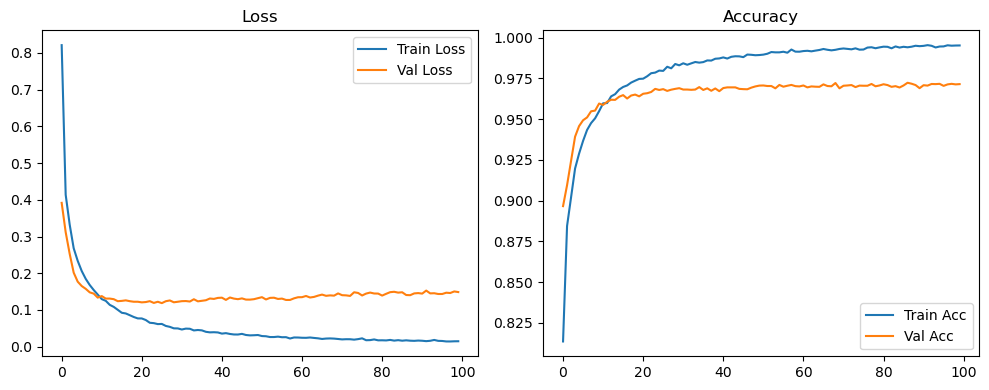

🚀 Running: batch256_lr0.001_0.001_0.001_dp0.5


Epoch 1/100 - LR: 0.00100 | Train Loss: 1.3003, Acc: 0.6024 | Val Loss: 0.5526, Acc: 0.8745


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.7146, Acc: 0.7834 | Val Loss: 0.4072, Acc: 0.8882


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.6018, Acc: 0.8150 | Val Loss: 0.3587, Acc: 0.8978


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.5364, Acc: 0.8365 | Val Loss: 0.3340, Acc: 0.9023


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.4854, Acc: 0.8520 | Val Loss: 0.3116, Acc: 0.9069


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.4507, Acc: 0.8633 | Val Loss: 0.2974, Acc: 0.9130


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.4265, Acc: 0.8730 | Val Loss: 0.2839, Acc: 0.9153


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.3947, Acc: 0.8819 | Val Loss: 0.2684, Acc: 0.9200


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.3746, Acc: 0.8884 | Val Loss: 0.2531, Acc: 0.9217


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.3503, Acc: 0.8946 | Val Loss: 0.2392, Acc: 0.9286


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.3290, Acc: 0.9017 | Val Loss: 0.2284, Acc: 0.9321


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.3169, Acc: 0.9040 | Val Loss: 0.2174, Acc: 0.9337


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.2998, Acc: 0.9112 | Val Loss: 0.2114, Acc: 0.9365


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.2865, Acc: 0.9144 | Val Loss: 0.2004, Acc: 0.9408


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.2703, Acc: 0.9190 | Val Loss: 0.1929, Acc: 0.9424


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.2623, Acc: 0.9218 | Val Loss: 0.1823, Acc: 0.9453


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.2508, Acc: 0.9245 | Val Loss: 0.1790, Acc: 0.9477


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.2364, Acc: 0.9301 | Val Loss: 0.1716, Acc: 0.9503


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.2273, Acc: 0.9326 | Val Loss: 0.1699, Acc: 0.9523


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.2207, Acc: 0.9340 | Val Loss: 0.1606, Acc: 0.9535


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.2107, Acc: 0.9374 | Val Loss: 0.1564, Acc: 0.9555


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.2096, Acc: 0.9383 | Val Loss: 0.1552, Acc: 0.9557


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.2010, Acc: 0.9399 | Val Loss: 0.1494, Acc: 0.9568


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.1925, Acc: 0.9422 | Val Loss: 0.1527, Acc: 0.9573


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.1889, Acc: 0.9428 | Val Loss: 0.1486, Acc: 0.9573


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.1839, Acc: 0.9438 | Val Loss: 0.1449, Acc: 0.9593


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.1803, Acc: 0.9454 | Val Loss: 0.1510, Acc: 0.9577


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.1664, Acc: 0.9493 | Val Loss: 0.1391, Acc: 0.9613


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.1689, Acc: 0.9499 | Val Loss: 0.1392, Acc: 0.9605


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.1635, Acc: 0.9503 | Val Loss: 0.1391, Acc: 0.9616


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.1623, Acc: 0.9517 | Val Loss: 0.1336, Acc: 0.9626


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.1605, Acc: 0.9514 | Val Loss: 0.1378, Acc: 0.9622


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.1512, Acc: 0.9543 | Val Loss: 0.1356, Acc: 0.9623


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.1457, Acc: 0.9557 | Val Loss: 0.1336, Acc: 0.9625


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.1435, Acc: 0.9555 | Val Loss: 0.1327, Acc: 0.9639


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.1398, Acc: 0.9575 | Val Loss: 0.1285, Acc: 0.9662


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.1377, Acc: 0.9576 | Val Loss: 0.1287, Acc: 0.9657


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.1376, Acc: 0.9574 | Val Loss: 0.1292, Acc: 0.9650


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.1322, Acc: 0.9594 | Val Loss: 0.1315, Acc: 0.9644


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.1307, Acc: 0.9595 | Val Loss: 0.1289, Acc: 0.9663


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.1284, Acc: 0.9600 | Val Loss: 0.1287, Acc: 0.9667


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.1253, Acc: 0.9612 | Val Loss: 0.1253, Acc: 0.9669


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.1233, Acc: 0.9627 | Val Loss: 0.1265, Acc: 0.9675


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.1199, Acc: 0.9627 | Val Loss: 0.1254, Acc: 0.9668


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.1178, Acc: 0.9636 | Val Loss: 0.1227, Acc: 0.9677


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.1143, Acc: 0.9644 | Val Loss: 0.1219, Acc: 0.9680


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.1160, Acc: 0.9645 | Val Loss: 0.1253, Acc: 0.9673


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.1112, Acc: 0.9656 | Val Loss: 0.1273, Acc: 0.9691


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.1091, Acc: 0.9664 | Val Loss: 0.1250, Acc: 0.9672


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.1077, Acc: 0.9661 | Val Loss: 0.1226, Acc: 0.9692


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.1023, Acc: 0.9680 | Val Loss: 0.1252, Acc: 0.9684


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.1033, Acc: 0.9683 | Val Loss: 0.1255, Acc: 0.9686


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.1020, Acc: 0.9679 | Val Loss: 0.1246, Acc: 0.9688


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0982, Acc: 0.9695 | Val Loss: 0.1216, Acc: 0.9690


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0991, Acc: 0.9692 | Val Loss: 0.1218, Acc: 0.9695


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0981, Acc: 0.9687 | Val Loss: 0.1222, Acc: 0.9707


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0983, Acc: 0.9683 | Val Loss: 0.1291, Acc: 0.9690


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0953, Acc: 0.9694 | Val Loss: 0.1233, Acc: 0.9691


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0944, Acc: 0.9701 | Val Loss: 0.1227, Acc: 0.9702


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0963, Acc: 0.9699 | Val Loss: 0.1253, Acc: 0.9702


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0879, Acc: 0.9723 | Val Loss: 0.1258, Acc: 0.9696


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0901, Acc: 0.9715 | Val Loss: 0.1291, Acc: 0.9688


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0930, Acc: 0.9711 | Val Loss: 0.1250, Acc: 0.9688


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0853, Acc: 0.9733 | Val Loss: 0.1243, Acc: 0.9699


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0833, Acc: 0.9734 | Val Loss: 0.1279, Acc: 0.9689


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0873, Acc: 0.9719 | Val Loss: 0.1265, Acc: 0.9696


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0878, Acc: 0.9726 | Val Loss: 0.1247, Acc: 0.9692


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0825, Acc: 0.9736 | Val Loss: 0.1252, Acc: 0.9695


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0825, Acc: 0.9736 | Val Loss: 0.1262, Acc: 0.9700


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0797, Acc: 0.9748 | Val Loss: 0.1297, Acc: 0.9691


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0806, Acc: 0.9743 | Val Loss: 0.1265, Acc: 0.9702


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0784, Acc: 0.9748 | Val Loss: 0.1282, Acc: 0.9698


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0808, Acc: 0.9744 | Val Loss: 0.1242, Acc: 0.9701


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0779, Acc: 0.9759 | Val Loss: 0.1263, Acc: 0.9700


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0749, Acc: 0.9755 | Val Loss: 0.1277, Acc: 0.9692


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0783, Acc: 0.9753 | Val Loss: 0.1244, Acc: 0.9698


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0751, Acc: 0.9771 | Val Loss: 0.1237, Acc: 0.9714


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0731, Acc: 0.9766 | Val Loss: 0.1302, Acc: 0.9702


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0721, Acc: 0.9772 | Val Loss: 0.1257, Acc: 0.9703


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0747, Acc: 0.9767 | Val Loss: 0.1249, Acc: 0.9698


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0751, Acc: 0.9761 | Val Loss: 0.1247, Acc: 0.9702


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0735, Acc: 0.9764 | Val Loss: 0.1271, Acc: 0.9706


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0708, Acc: 0.9775 | Val Loss: 0.1281, Acc: 0.9706


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0708, Acc: 0.9778 | Val Loss: 0.1277, Acc: 0.9715


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0705, Acc: 0.9778 | Val Loss: 0.1272, Acc: 0.9708


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0689, Acc: 0.9782 | Val Loss: 0.1253, Acc: 0.9705


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0716, Acc: 0.9767 | Val Loss: 0.1267, Acc: 0.9703


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0724, Acc: 0.9771 | Val Loss: 0.1234, Acc: 0.9713


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0676, Acc: 0.9779 | Val Loss: 0.1292, Acc: 0.9702


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0669, Acc: 0.9789 | Val Loss: 0.1248, Acc: 0.9714


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0636, Acc: 0.9801 | Val Loss: 0.1292, Acc: 0.9708


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0652, Acc: 0.9791 | Val Loss: 0.1326, Acc: 0.9702


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0637, Acc: 0.9794 | Val Loss: 0.1280, Acc: 0.9704


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0662, Acc: 0.9784 | Val Loss: 0.1320, Acc: 0.9703


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0631, Acc: 0.9802 | Val Loss: 0.1295, Acc: 0.9704


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0635, Acc: 0.9791 | Val Loss: 0.1311, Acc: 0.9695


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0663, Acc: 0.9791 | Val Loss: 0.1287, Acc: 0.9709


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0618, Acc: 0.9800 | Val Loss: 0.1309, Acc: 0.9716


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0639, Acc: 0.9800 | Val Loss: 0.1302, Acc: 0.9712


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0605, Acc: 0.9800 | Val Loss: 0.1299, Acc: 0.9708


Final Test Loss: 0.1216 Accuracy: 0.9735


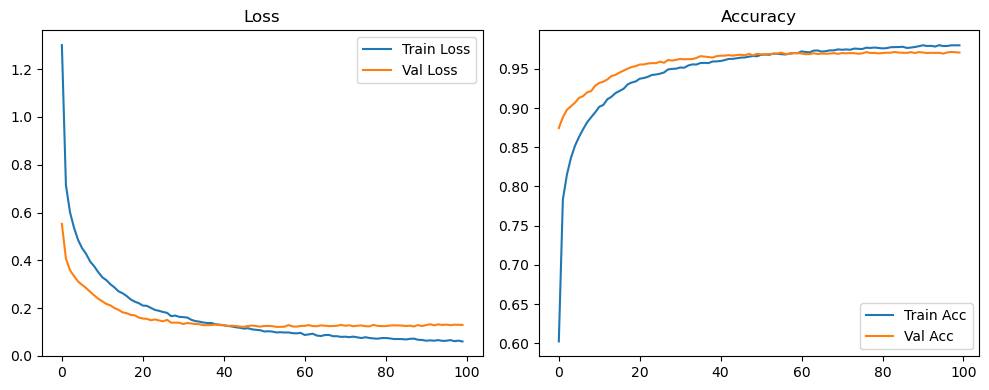

🏆 Best Config: batch64_lr0.01_0.002_0.001_dp0.0 Accuracy: 0.9831


In [8]:
root_path = "MLP_256_8bit_regular_Sigmoid"

epochs = 100
batch_sizes = [64, 128, 256]
dropout_rates = [0.0, 0.2, 0.5]
lr_pool = [0.01, 0.005, 0.002, 0.001]

Hyperparameter_searching(root_path, epochs, batch_sizes, lr_pool, dropout_rates)